# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#4285F4;overflow:hidden">Introduction</div>

<span style="font-size:18px; font-family:Georgia;"><b>Objectives</b>: In creating this notebook, my objectives are:</span>
    
<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li>To learn about the data by exploration and visualization</li>

<li>To perform some processing techniques for further development</li>

</span></ul>


<span style="font-size:18px; font-family:Georgia;"><b>Isolated Sign Language (ISL):</b> The signs in the dataset represent 250 of the first concepts taught to infants in any language. The goal is to create an isolated sign recognizer to incorporate into educational games for helping hearing parents of Deaf children learn American Sign Language (ASL) <a href="https://www.kaggle.com/competitions/asl-signs/overview/data-card">[G1]</a>
<br> The 5 parameters of ASL are <a href="https://www.mtsac.edu/llc/passportrewards/languagepartners/5ParametersofASL.pdf">[G2]</a>:</span>

<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li>Handshapes</li>

<li>Palm Orientations</li>
    
<li>Locations</li>
    
<li>Movements</li>
    
<li>Non-Manual Signals (NMS)</li>

</span></ul>

<span style="font-size:18px; font-family:Georgia;"><b>Landmarks Files:</b> The landmarks were extracted from raw videos with the MediaPipe holistic model <a href="https://google.github.io/mediapipe/solutions/holistic.html">[G3]</a>. Not all of the frames necessarily had visible hands or hands that could be detected by the model <a href="https://www.kaggle.com/competitions/asl-signs/data">[G4]</a>. The spatial coordinates of the landmark are normalized to 0 and 1. Any points that are outside of [0, 1] are Mediapipe artifacts <a href="https://www.kaggle.com/competitions/asl-signs/discussion/392286">[G5]</a>.</span>
    

In [1]:
# Install
!pip install -q itables 2> /dev/null
!pip install -q flatbuffers 2> /dev/null
!pip install -q mediapipe 2> /dev/null

In [2]:
# Imports

# activate interactive mode of pd.dataframe
import pandas as pd
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

import os

import json
from tqdm import tqdm
import numpy as np
import itertools

import tensorflow as tf

#pytorch model
import torch
import torch.nn.functional as F
import torch.nn as nn

import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from matplotlib import animation
from pathlib import Path
import IPython
from IPython import display
from IPython.core.display import display, HTML, Javascript
from IPython.display import Markdown as md

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Config

class Cfg:
    INPUT_ROOT = Path('/kaggle/input/asl-signs/')
    OUTPUT_ROOT = Path('kaggle/working')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'
    
LANDMARK_FILES_DIR = "/kaggle/input/asl-signs/train_landmark_files"
label_map = json.load(open("/kaggle/input/asl-signs/sign_to_prediction_index_map.json", "r"))

train_df = pd.read_csv("/kaggle/input/gislr-extended-train-dataframe/extended_train.csv")
train_df['label'] = train_df['sign'].map(label_map)

In [4]:
# Helpers

ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# https://www.kaggle.com/code/ted0071/gislr-visualization
def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
    """Reads the sign to predict as json file."""
    with open(file_path, "r") as f:
        result = json.load(f)
    return result    

def read_train(file_path=Cfg.TRAN_FILE):
    """Reads the train csv as pandas data frame."""
    return pd.read_csv(file_path).set_index(Cfg.INDEX)

def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_landmark_data_by_id(sequence_id, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data.loc[sequence_id]['path']
    return read_landmark_data_by_path(file_path)

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#4285F4;overflow:hidden">Metadata Analysis</div>

<span style="font-size:18px; font-family:Georgia;">In this section, I want to explore the number of sequences, frames, and average frames per sign, and participant. Thus, I split the train data into 2 levels for further analysis: </span>

<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li><b>ISL Level:</b> I group the train dataframe by <b>sign</b>. Then, I aggregrate the number of sequence ids and total number of frames. This level is to help me explore the number of sequences, frames, and average frames per sign.</li>

<li><b>Participant Level:</b> I group the train dataframe by <b>participant_id</b> and <b>sign</b>. Then, I aggregrate the number of sequence ids and total number of frames. This level is to help me explore the number of sequences, frames, and average frames per sign per participant.</li>

</span></ul>

<span style="font-size:25px; font-family:Georgia;"><b>ISL Level</b></span>


In [5]:
meta_data_df = train_df.groupby('sign').agg({'sequence_id': 'count',
                                             'total_frames': 'sum'})
meta_data_df.columns = ['num_seq','num_frames']
meta_data_df['avg_frames'] = np.round(meta_data_df['num_frames']/meta_data_df['num_seq'])

meta_data_df

num_seq  num_frames  avg_frames
sign                                      
TV             385       14197        37.0
after          347       10546        30.0
airplane       393       17274        44.0
all            386       14090        37.0
alligator      390       18021        46.0
...            ...         ...         ...
yesterday      398       15705        39.0
yourself       385       13499        35.0
yucky          379       14190        37.0
zebra          375       14399        38.0
zipper         299        9750        33.0

[250 rows x 3 columns]

In [6]:
int(meta_data_df.num_seq.sum()/250), int(meta_data_df.avg_frames.sum()/250)

(377, 37)

In [7]:
fig = go.Figure()

cols_name = meta_data_df.columns.values.tolist()
colors = ["#0F9D58","#4285F4","#F4B400"]

for color,col in zip(colors,cols_name):
    # store tmp df
    tmp = meta_data_df.sort_values(col)
    fig.add_trace(go.Bar(x=tmp.index, 
                         y=tmp[col],
                         width=0.5,name=col,marker_color=color))

fig.update_layout(
    title={
            'text': "ISL Distribution: All Traces",
            'font': dict(size=20,family="Georgia",color=colors[1]),
            'y':0.87,
            'x':0.035,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=-45,
    width= 4000,
    xaxis=dict(title='Sign', fixedrange=True),
    yaxis=dict(title='Count',fixedrange=True),
    showlegend=True,
  
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.005,
            xanchor="right",
            y=1.2,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, True,True]},
                           {"title": "ISL Distribution: All Traces",
                            "legend":True,
                            }]),
                dict(label="Sequences",
                     method="update",
                     args=[{"visible": [True, False,False]},
                           {"title": "Distribution of Number of Sequences per Sign",
                            "legend":True,
                            }]),
                dict(label="Frames",
                     method="update",
                     args=[{"visible": [False,True, False]},
                           {"title": "Distribution of Number of Frames per Sign",
                            "legend":True,
                            }]),
                dict(label="Avg frames",
                     method="update",
                     args=[{"visible": [False, False,True]},
                           {"title": "Distribution of Average Frames per Sequence per Sign",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

<div style="background-color:white;font-size:22px;font-family:Georgia;border-style: solid;border-color: #F4B400;border-width:5px;padding:20px;margin: 0px;color:black;overflow:hidden">
<span style="font-size:18px; font-family:Georgia;"><b>Observations:</b> </span>
    
<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li>Number of sequences are evenly distributed for each sign</li>

<li>Sign "mitten" has the most number of frames, and average frames per sequence </li>
    
<li>On average, there are <b>377</b> sequences per sign, and <b>37</b> frames per sequence</li>

</span></ul>

</div>

<span style="font-size:25px; font-family:Georgia;"><b>Participant Level</b></span>

In [8]:
participant_level_df = train_df.groupby(['participant_id','sign']).agg({'sequence_id': 'count',
                                                                        'total_frames': 'sum'})
participant_level_df['avg_frames'] = np.round(participant_level_df.total_frames/participant_level_df.sequence_id)
participant_level_df.columns = ['num_seq','num_frames','avg_frames']
participant_level_df = participant_level_df.reset_index()
participant_level_df

participant_id       sign  num_seq  num_frames  avg_frames
0               2044         TV       20         295        15.0
1               2044      after       22         215        10.0
2               2044   airplane       19         407        21.0
3               2044        all       19         283        15.0
4               2044  alligator       20         530        26.0
...              ...        ...      ...         ...         ...
5225           62590  yesterday       19         385        20.0
5226           62590   yourself       19         543        29.0
5227           62590      yucky       18         641        36.0
5228           62590      zebra       19         676        36.0
5229           62590     zipper       17         285        17.0

[5230 rows x 5 columns]

In [9]:
int(participant_level_df.num_seq.sum()/21), int(participant_level_df.num_frames.sum()/21)

(4498, 170666)

In [10]:
fig = go.Figure()

cols_name = participant_level_df.columns.values.tolist()[2:]
colors = ["#0F9D58","#4285F4","#F4B400"]
methods = ['sum','sum','sum']

for color,col,method in zip(colors,cols_name,methods):
    # store tmp series object
    tmp = participant_level_df.groupby(['participant_id'])\
                              .agg({col: method})[col]\
                              .sort_values(ascending=True)
    fig.add_trace(go.Bar(x=tmp.index.astype('str'), 
                         y=tmp.values,
                         width=0.8,name=col,marker_color=color))
fig.update_layout(
    title={
            'text': "Participant Distribution: All Traces",
            'font': dict(size=20,family="Georgia",color=colors[1]),
            'y':0.87,
            'x':0.18,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=-45,
    width= 800,
    height=500,
    xaxis=dict(title='Participant_ID', fixedrange=True),
    yaxis=dict(title='Count',fixedrange=True),
    showlegend=True,
    
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.01,
            xanchor="right",
            y=1.20,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, True,True]},
                           {"title": "Participant Distribution: All Traces",
                            "legend":True,
                            }]),
                dict(label="Sequences",
                     method="update",
                     args=[{"visible": [True, False,False]},
                           {"title": "Distribution of Number of Sequences per Participant",
                            "legend":True,
                            }]),
                dict(label="Frames",
                     method="update",
                     args=[{"visible": [False,True, False]},
                           {"title": "Distribution of Number of Frames per Participant",
                            "legend":True,
                            }]),
                dict(label="Avg frames",
                     method="update",
                     args=[{"visible": [False, False,True]},
                           {"title": "Distribution of Average Frames per Participant",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

<div style="background-color:white;font-size:22px;font-family:Georgia;border-style: solid;border-color: #F4B400;border-width:5px;padding:20px;margin: 0px;color:black;overflow:hidden">
<span style="font-size:18px; font-family:Georgia;"><b>Observations:</b> </span>
    
<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li>3 participants have the least number of sequences</li>

<li>Participant ID-49445 has the most number of frames, whereas participant ID-37779 has the least number of frames </li>
    
<li>On average, there are <b>4498</b> sequences per participant, and <b>170666</b> frames per participant.</li>

</span></ul>

</div>

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#4285F4;overflow:hidden">Landmarks Analysis</div>


<span style="font-size:18px; font-family:Georgia;">In this section, I want to visualize and gain more insights from individual frames for each sequence. Thus, I adjust some helper functions from Roland Abel <a href="https://www.kaggle.com/code/ted0071/gislr-visualization">[C1]</a> and create another helper function for interactive landmarks visualization.<br>Below are some references for hand, full body, and face landmarks: </span>

<span style="font-size:25px; font-family:Georgia;"><b>Hand Landmarks</b></span>

![Hand Landmarks](https://developers.google.com/static/mediapipe/images/solutions/hand-landmarks.png)

<span style="font-size:25px; font-family:Georgia;"><b>Full Body Landmarks</b></span>
![Full Body Landmarks](https://mediapipe.dev/images/mobile/pose_tracking_full_body_landmarks.png)


<span style="font-size:18px; font-family:Georgia;">For ASL, the upper body landmarks are more important than the lower body landmarks.</span>

<span style="font-size:25px; font-family:Georgia;"><b>Face Landmarks (Contours)</b></span>


<span style="font-size:18px; font-family:Georgia;">For ASL, the non-manual signals such as head nod, eyebrows, nose, eyes, and lips are used to convey additional meaning with a sign. Thus, instead of visualizing the facemesh tesselation, I decide to only use facemesh contours.<br> Face Landmarks to use: </span>

<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li><b>Tensors to face landmarks</b> <a href="https://github.com/google/mediapipe/blob/master/mediapipe/modules/face_landmark/tensors_to_face_landmarks_with_attention.pbtxt">[G6]</a></li>

<li><b>Facemesh connections</b> <a href="https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/face_mesh_connections.py">[G7]</a></li>

</span></ul>


In [11]:
# Helper Functions
# [C1] adjusted from Roland Abel: https://www.kaggle.com/code/ted0071/gislr-visualization
train_data = read_train()

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

# contour connections
CONTOURS = list(itertools.chain(*mp_face_mesh.FACEMESH_CONTOURS))

def create_blank_image(height, width):
    return np.zeros((height, width, 3), np.uint8)

def draw_landmarks(data, image, frame_id, 
                   landmark_type, connection_type, 
                   landmark_color=(255, 0, 0), connection_color=(0, 20, 255), 
                   thickness=2, circle_radius=1):
    """Draws landmarks"""
    df = data.groupby(['frame', 'type']).get_group((frame_id, landmark_type)).copy()
    if landmark_type == 'face':
        df.loc[~df['landmark_index'].isin(CONTOURS),'x'] = float('NaN') #-1*df[~df['landmark_index'].isin(CONTOURS)]['x'].values

        
    landmarks = [landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for idx, lm in df.iterrows()]
    landmark_list = landmark_pb2.NormalizedLandmarkList(landmark = landmarks)
    #print(len(landmark_list.landmark))
    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmark_list, 
        connections=connection_type,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=landmark_color, 
            thickness=thickness, 
            circle_radius=circle_radius),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=connection_color, 
            thickness=thickness, 
            circle_radius=circle_radius))
    return image

In [12]:
def get_ids(df, row):
    participant_id = df.participant_id.values[row]
    sequence_id = df.sequence_id.values[row]
    
    return participant_id, sequence_id

def draw_data(participant_id, sequence_id, train_data):
    height = 700
    width = 500

    # Read and get frames
    data = read_landmark_data_by_id(sequence_id, train_data)
    frame_ids = data.frame.unique().tolist()
    buttons_ids = []
    buttons_seq_ids = []
    buttons=[]

    fig = make_subplots(rows=2, cols=3,
                    specs=[[{}, {},{"rowspan": 2}],
                           [{}, {},None]],
                    vertical_spacing=0.1,
                    subplot_titles=('Face',  'Pose',
                                    'All',  'Left Hand',
                                    'Right Hand'),
                    print_grid=False)

    buttons_seq_ids.append(dict(label=f"{sequence_id}",
                                method="restyle",
                                args=[{"visible": None}]
                                ))
    buttons_ids.append(dict(label=f"{participant_id}",
                                method="restyle",
                                args=[{"visible": None}]
                                ))

    for i,frame_id in enumerate(frame_ids): 
        r_hand = draw_landmarks(data, image=create_blank_image(height, width ), 
                              frame_id=frame_id,
                              landmark_type = 'right_hand', 
                              connection_type = mp_hands.HAND_CONNECTIONS,
                              landmark_color=(255, 0, 0),
                              connection_color=(0, 20, 255), 
                              thickness=3, 
                              circle_radius=3)


        l_hand = draw_landmarks(data, image=create_blank_image(height, width), 
                              frame_id=frame_id,
                              landmark_type = 'left_hand', 
                              connection_type = mp_hands.HAND_CONNECTIONS,
                              landmark_color=(255, 0, 0),
                              connection_color=(0, 20, 255), 
                              thickness=3, 
                              circle_radius=3)



        face = draw_landmarks(data, image=create_blank_image(height, width), 
                              frame_id=frame_id,
                              landmark_type='face', 
                              connection_type= mp_face_mesh.FACEMESH_CONTOURS,
                              landmark_color=(255, 255, 255),
                              connection_color=(0, 255, 0),
                              thickness=1, 
                              circle_radius=1)

        pose = draw_landmarks(data, image=create_blank_image(height, width), 
                               frame_id=frame_id,
                               landmark_type='pose', 
                               connection_type= mp_pose.POSE_CONNECTIONS,
                               landmark_color=(255, 255, 255),
                               connection_color=(255, 0, 0),
                               thickness=2, 
                               circle_radius=2)

        fig.add_trace(px.imshow(face).data[0], row=1, col=1)
        fig.add_trace(px.imshow(pose).data[0], row=1, col=2)
        fig.add_trace(px.imshow(l_hand).data[0], row=2, col=1)
        fig.add_trace(px.imshow(r_hand).data[0], row=2, col=2)
        fig.add_trace(px.imshow(face+pose+l_hand+r_hand, aspect='auto').data[0], row=1, col=3)

        visible=[False,False,False,False,False]*len(frame_ids)
        visible[i*5:i*5+5]=[True]*5
        buttons.append(dict(label=f"{frame_id}",
                            method="update",
                            args=[{"visible": visible}]))  

    sign = train_df.query('sequence_id == @sequence_id')['sign'].values[0]

    fig.update_layout(
        title={
            'text': f'<b>Sign: {sign}',
            'font': dict(size=20,family="Georgia",color=colors[1]),
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},


        template="plotly_white",
        width= 800,
        height=600,
        showlegend=True,


        updatemenus=[
            # Participant_ID
            dict(
                # customize dropdown
                active=0,
                direction="down",
                pad={"r": 50, "t": 25},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.2,
                yanchor="top",

                # customize button      
                buttons=buttons_ids),

            # Sequence_ID
            dict(
                # customize dropdown
                active=0,
                direction="down",
                pad={"r": 50, "t": 25},
                showactive=True,
                x=0.43,
                xanchor="left",
                y=1.2,
                yanchor="top",

                # customize button      
                buttons=buttons_seq_ids),

            # Frames_ID
            dict(
                # customize dropdown
                active=0,
                direction="down",
                pad={"r": 50, "t": 25},
                showactive=True,
                x=0.8,
                xanchor="left",
                y=1.2,
                yanchor="top",

                # customize button      
                buttons=buttons),

        ])

    fig.update_xaxes(showticklabels=False,fixedrange=True)
    fig.update_yaxes(showticklabels=False,fixedrange=True)

    fig.add_annotation(text="Participant_ID", x=-0.05, xref="paper", y=1.12, yref="paper",
                       align="left", showarrow=False)
    fig.add_annotation(text="Sequence_ID", x=0.35, xref="paper", y=1.125, yref="paper",
                       align="left", showarrow=False)
    fig.add_annotation(text="Frame_ID", x=0.78, xref="paper", y=1.13, yref="paper",
                       align="left", showarrow=False)
    
    return fig

<span style="font-size:25px; font-family:Georgia;"><b>Landmarks Visualization</b></span>

In [13]:
sign_table = {}
for i in range(25):
    sign_table[f'{i}'] = train_df.sign.unique()[i*10:i*10+10].tolist()
sign_table = pd.DataFrame(sign_table)
sign_table

0       1        2            3        4            5          6  \
0    blow  vacuum   zipper         shoe   hungry          bad      black   
1    wait   apple    clean          wet   orange          can   yourself   
2   cloud  puzzle   closet          see     milk          say       open   
3    bird  mitten    quiet        empty       go  callonphone  alligator   
4    owie   there     have         fall   drawer       finish       moon   
5    duck     dry  brother      balloon       TV          old       find   
6  minemy   shirt    clown  frenchfries  another     backyard      pizza   
7    lips     owl    cheek       finger  giraffe         sick       shhh   
8  flower  yellow     cute         same     wake         look       fast   
9    time     not    store          cry      bee         that     jacket   

          7        8      9  ...       15            16         17       18  \
0  scissors     fish    sad  ...     will          loud        cut      eye   
1       now   cowboy   face  ...     hate           hen  underwear    snack   
2       man     snow  penny  ...       on        listen     please    story   
3    sticky    dryer   gift  ...  pretend          give      child   police   
4      jump    green  night  ...    kitty          wolf      smile      arm   
5     sleep      bug   hair  ...  fireman           dad        pen     talk   
6       sun      nap    who  ...   before           gum  yesterday  grandpa   
7     first     feet  think  ...     doll          hear      horse   tongue   
8     grass    yucky  brown  ...   stairs  refrigerator        pig     pool   
9     uncle  morning    mad  ...     kiss       outside      table     girl   

        19      20        21           22          23        24  
0       up     cat       yes        puppy        read      lamp  
1   better     why  airplane       cereal       every      room  
2     tree  carrot      book        touch     bedroom     dirty  
3    dance     dog      blue        mouth      napkin     chair  
4    close   mouse  icecream          boy         ear       hat  
5    taste   jeans   garbage      thirsty  toothbrush  elephant  
6     chin  shower  tomorrow         make        home     after  
7     ride   later       red          for     pajamas       car  
8  because     mom       cow  glasswindow       hello      hide  
9       if    nose    person         into  helicopter     goose  

[10 rows x 25 columns]

<span style="font-size:20px; font-family:Georgia;"><b>Example 1: Wait</b></span>

> <span style="font-size:18px; font-family:Georgia;"><b>Disclaimer:</b> I want to produce an interactive visualization based on Participant_ID, Sequence_ID, and Frame_ID. However, I haven't figured out the way to do the chained dropdown callback without using Dash Plottly yet. Thus, only the <b>Frame_ID</b> dropdown is <b>active</b>, the <b>Participant_ID</b> and <b>Sequence_ID</b> dropdowns are currently <b>inactive</b> ^^'. </span>


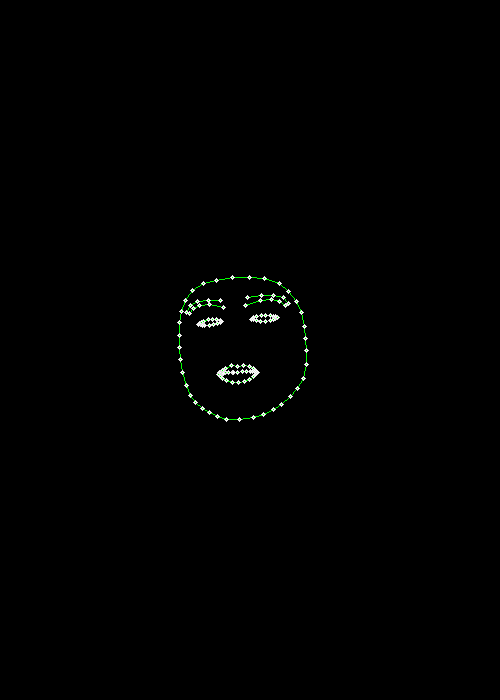
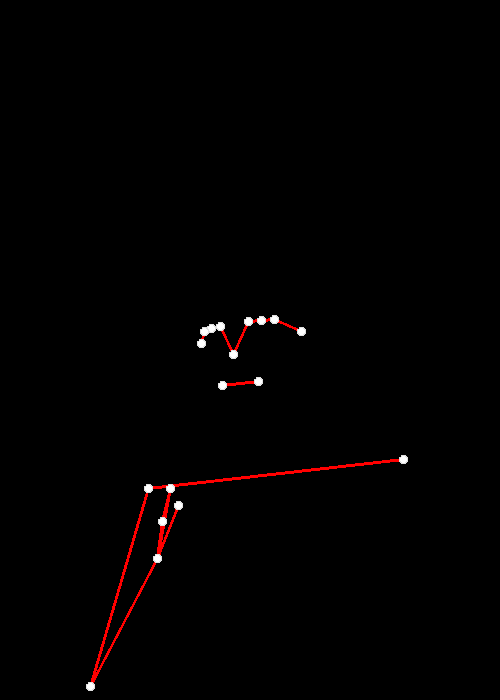
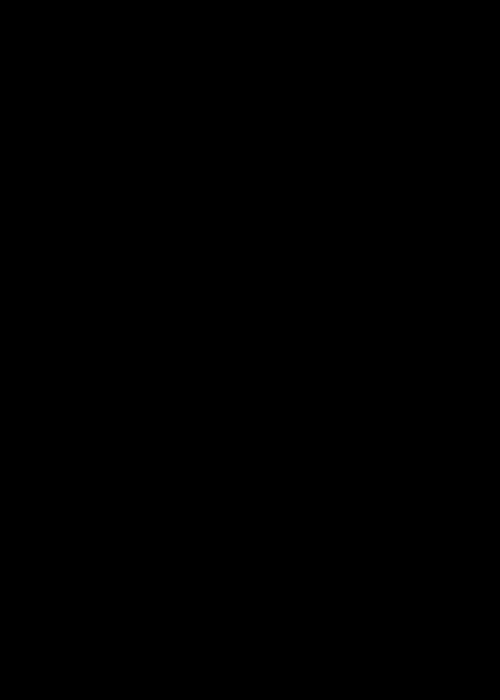
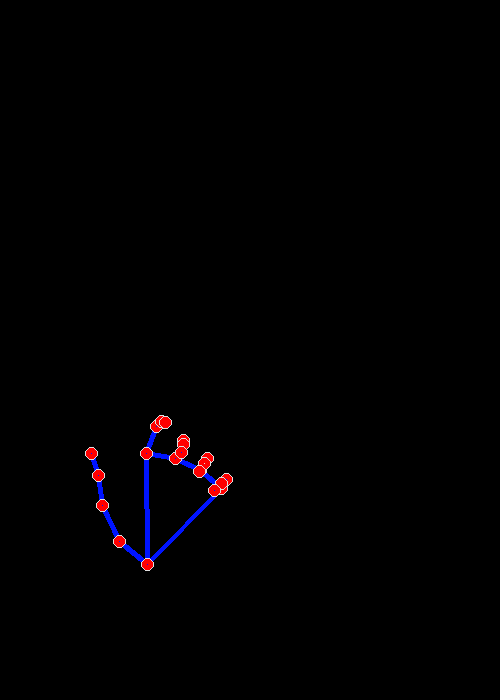
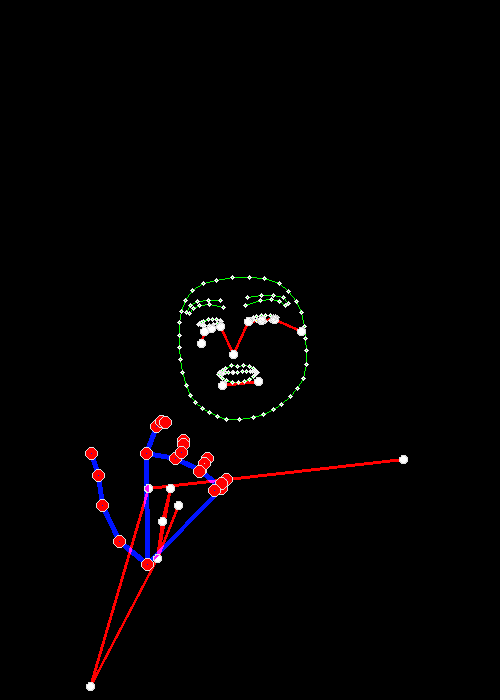
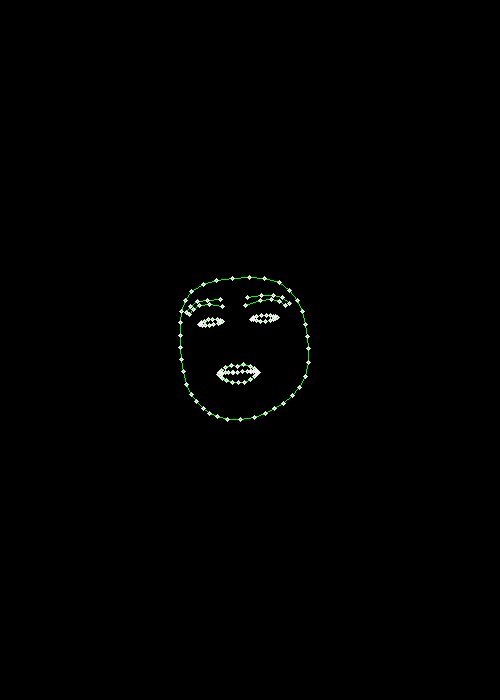
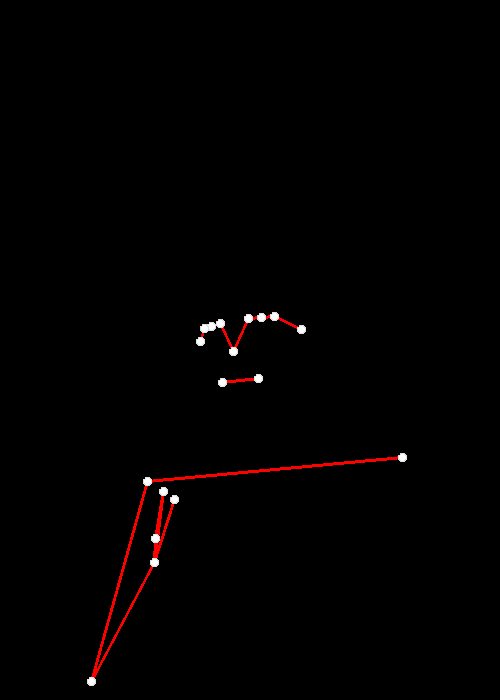
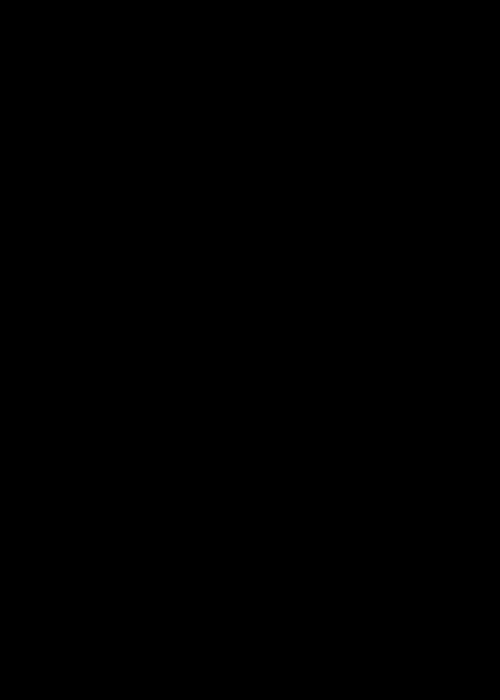
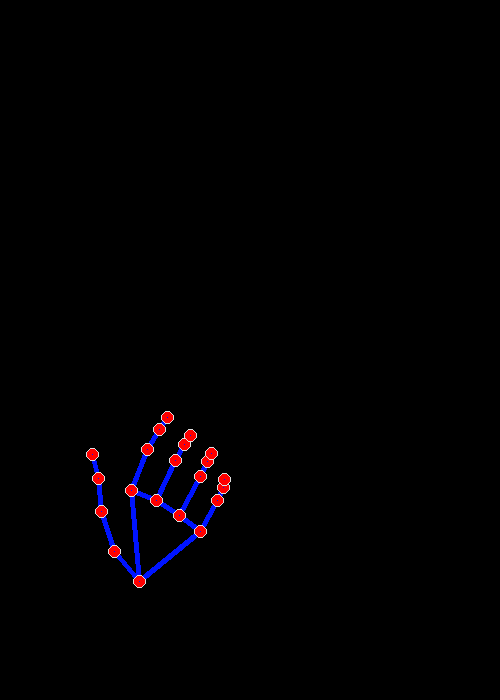
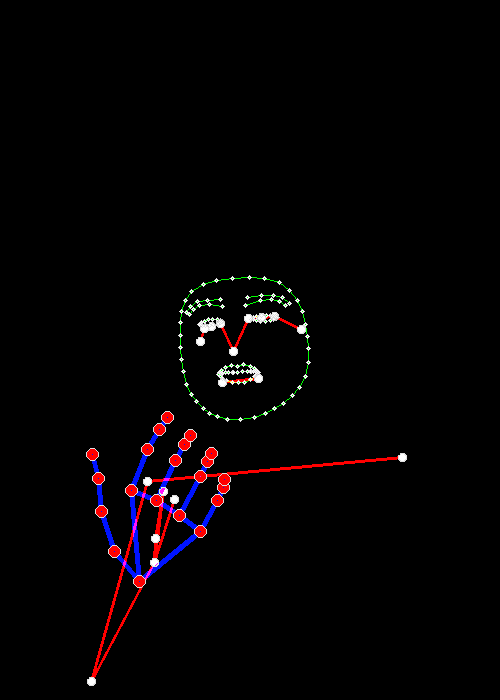
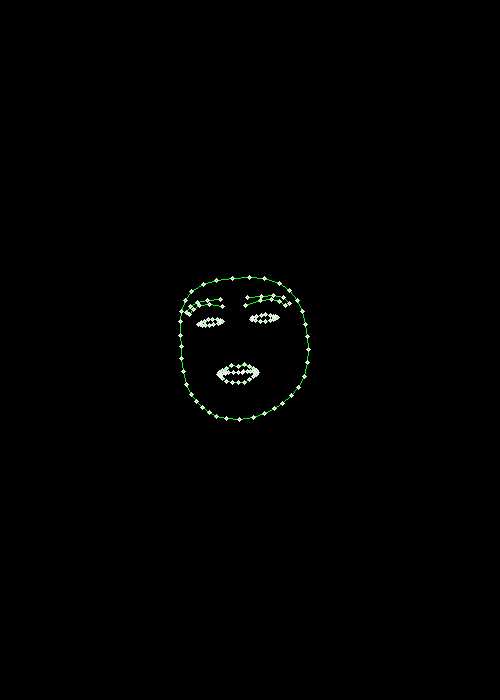
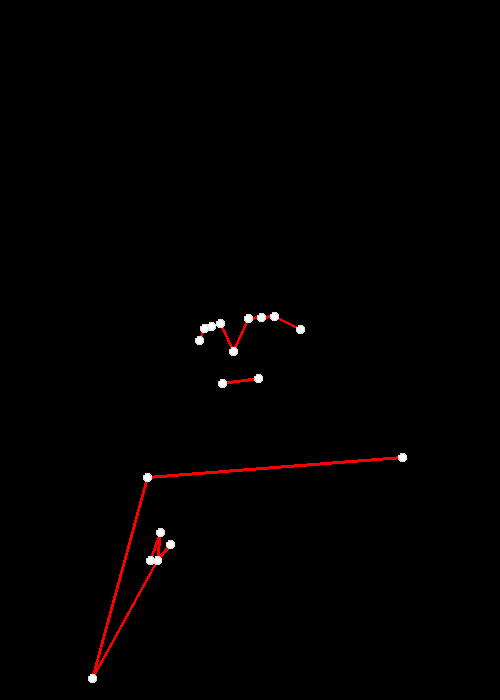
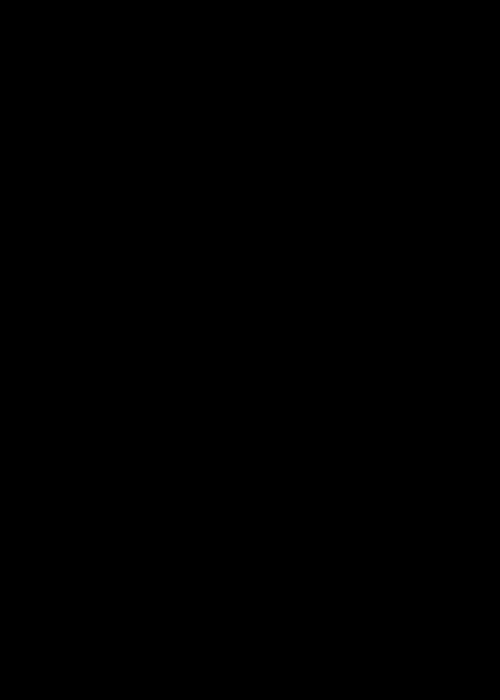
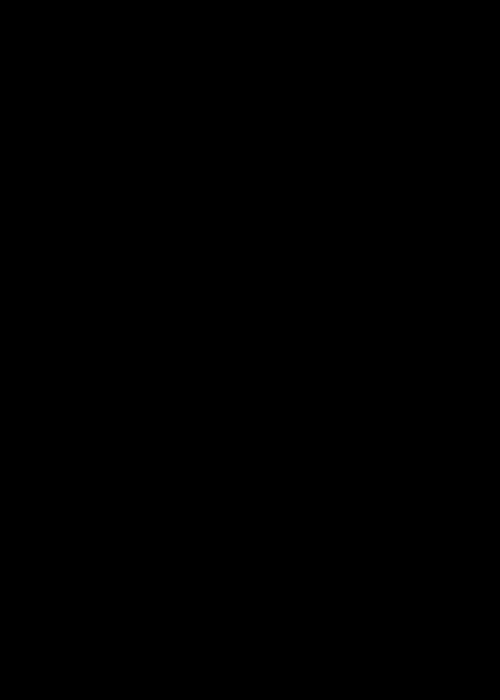
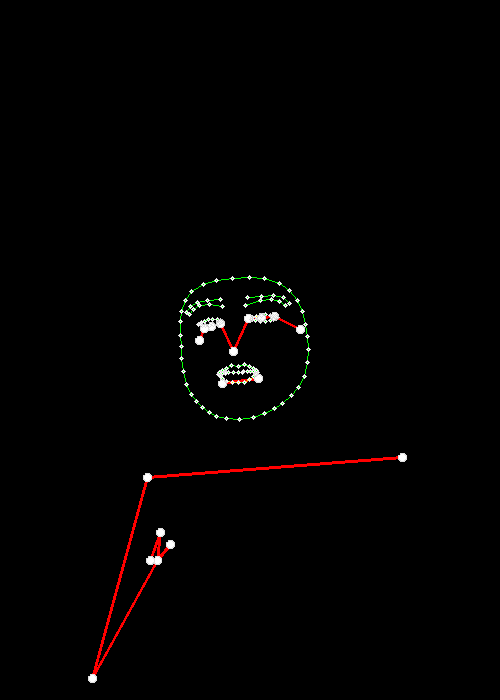
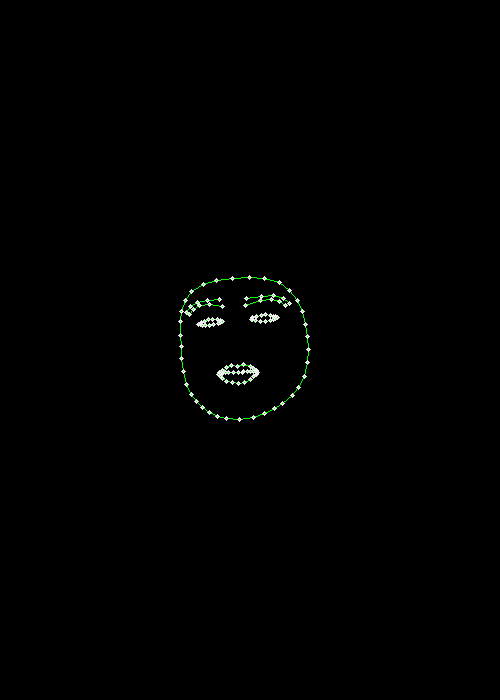
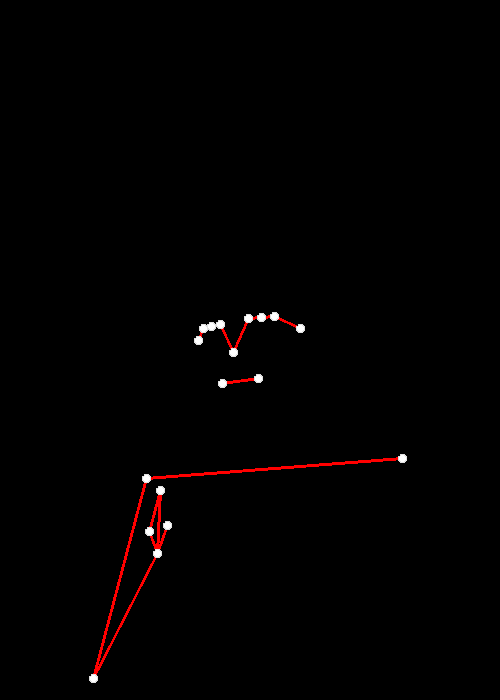
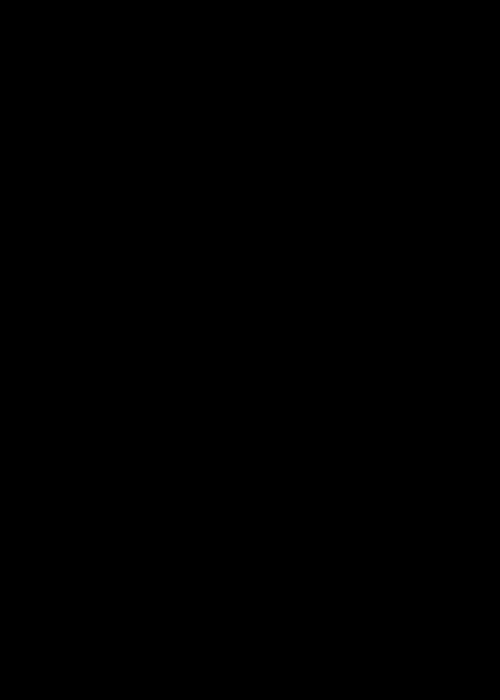
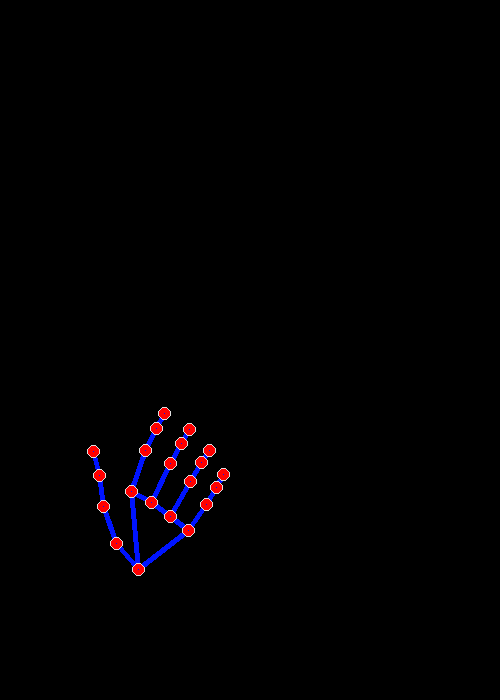
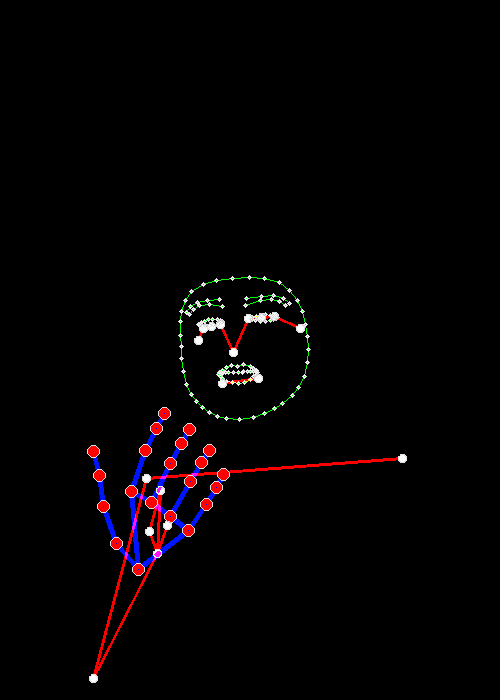
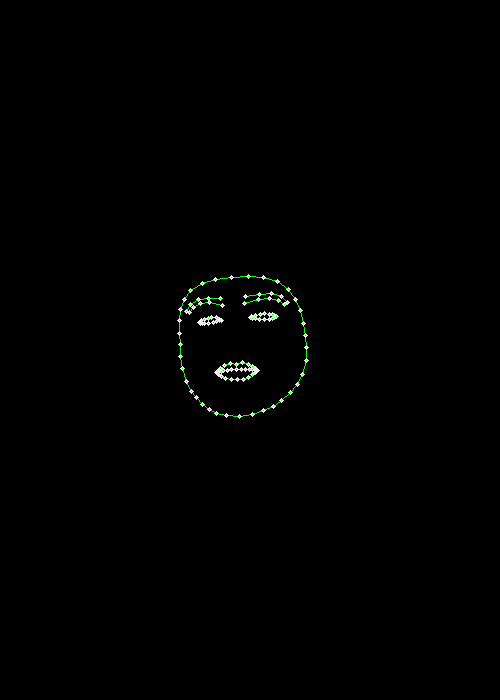
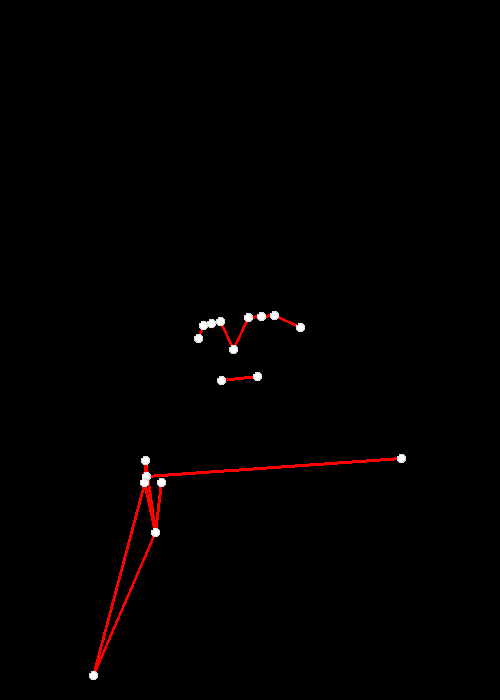
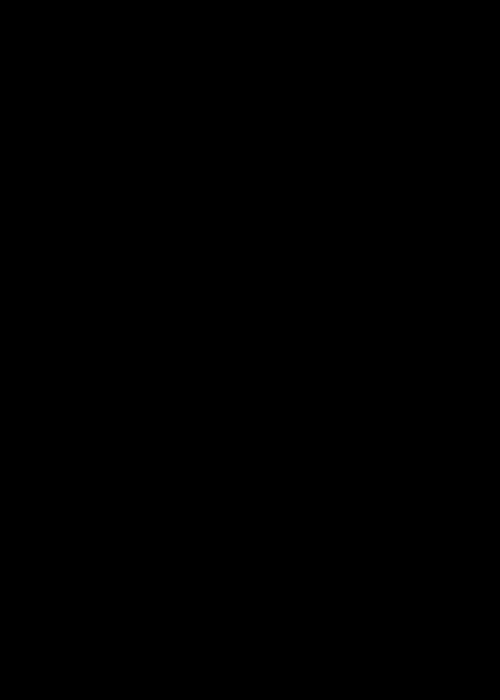
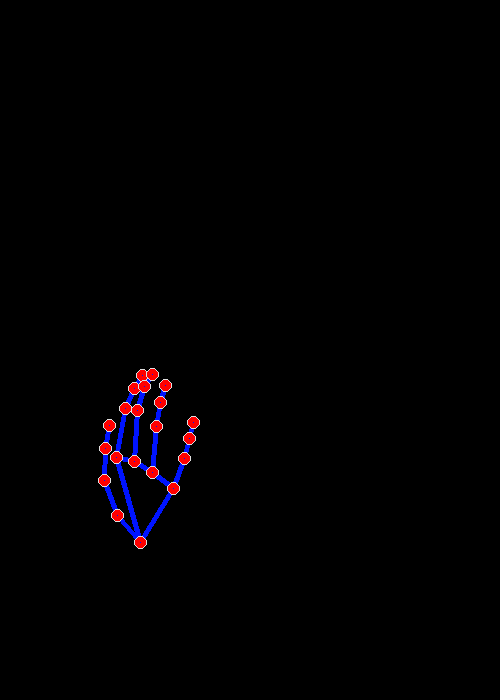
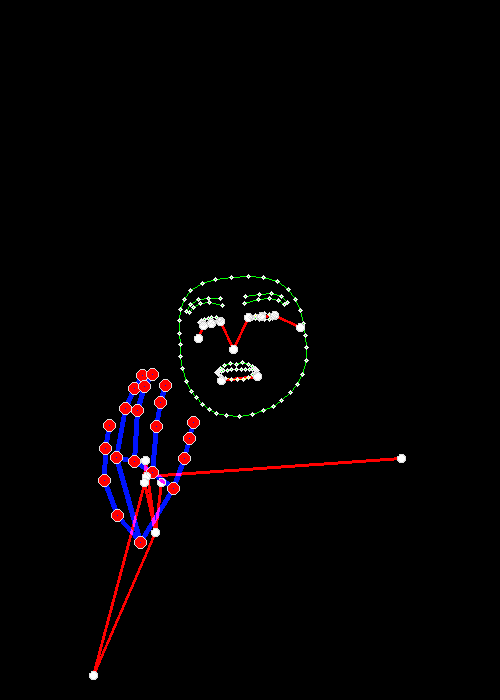
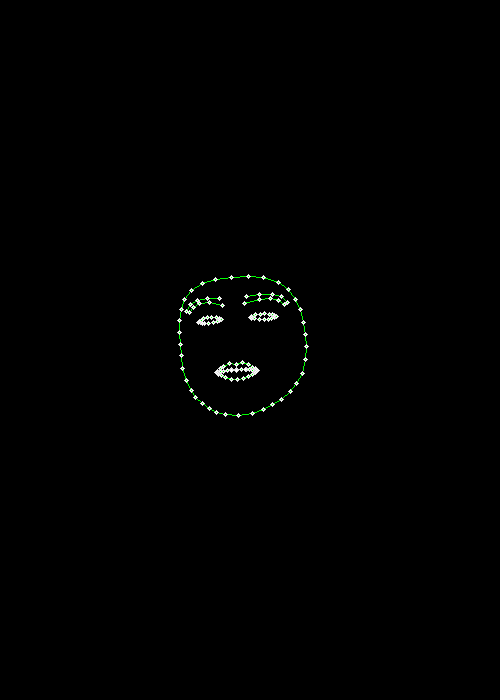
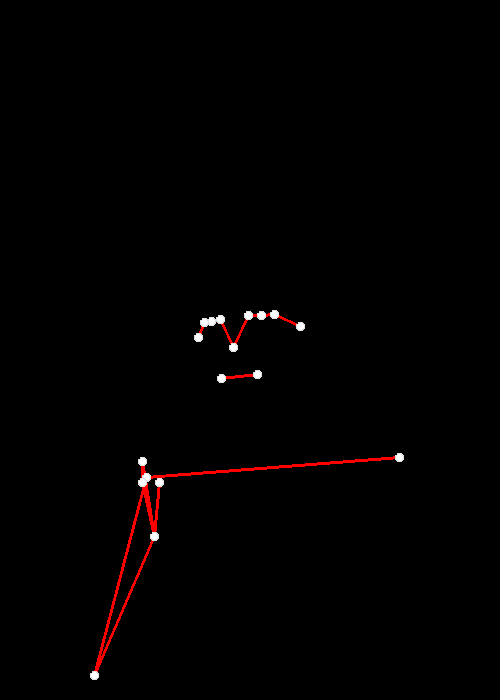
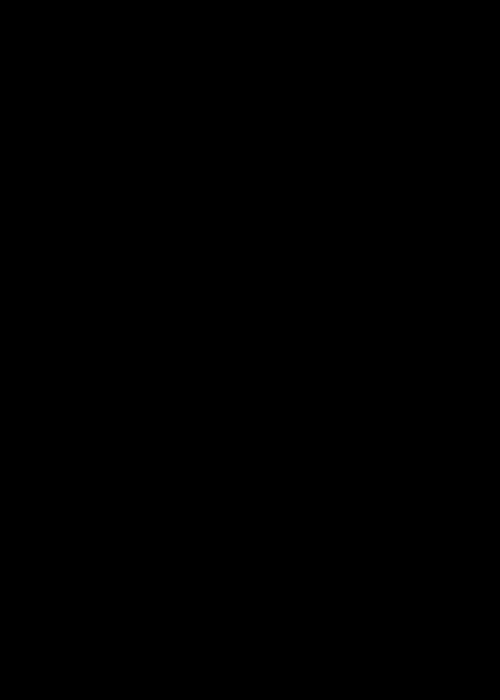
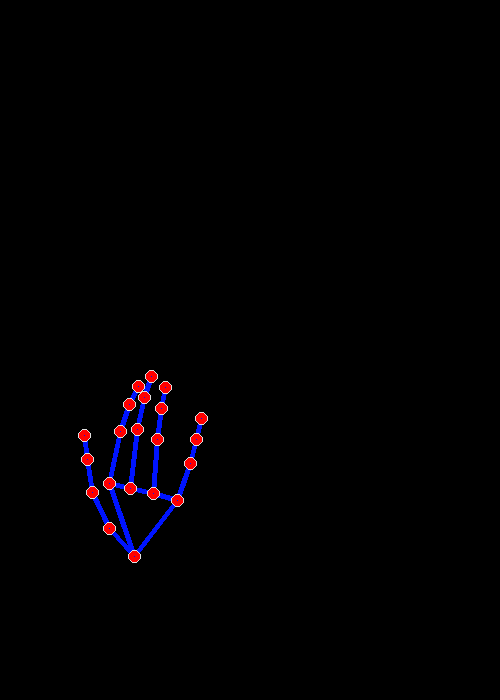
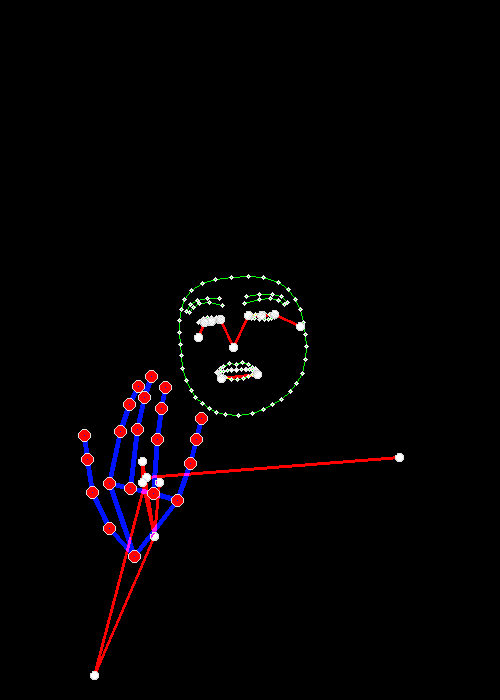
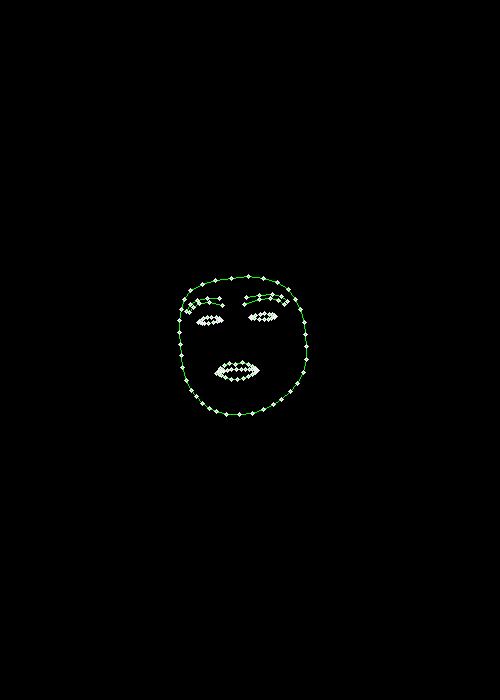
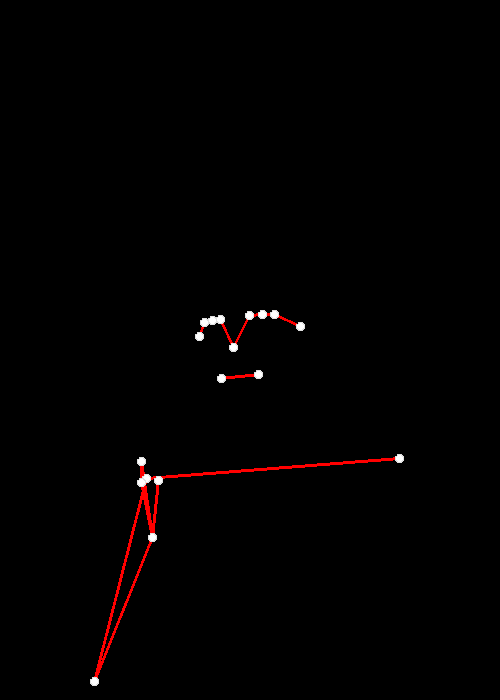
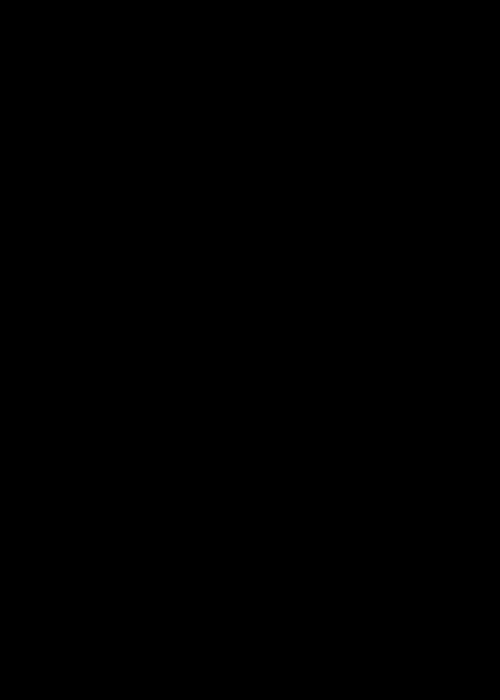
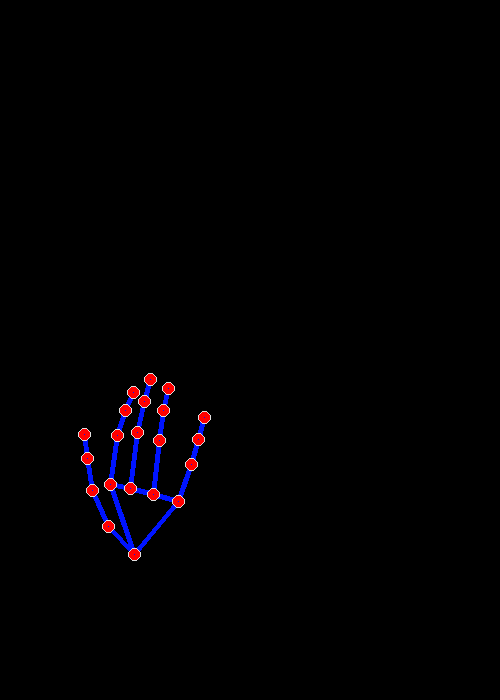
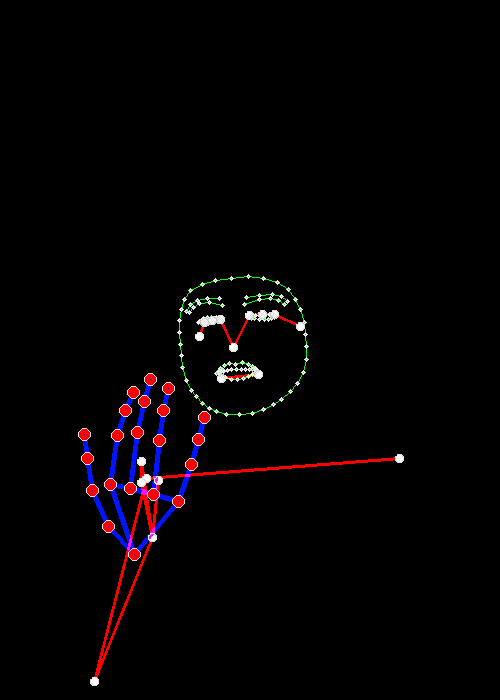
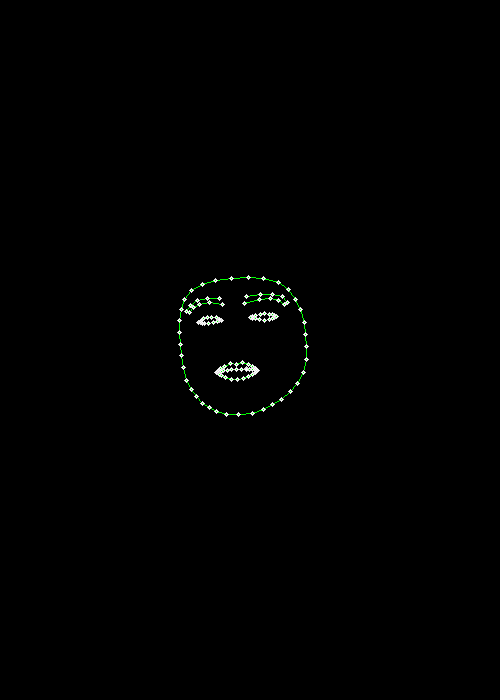
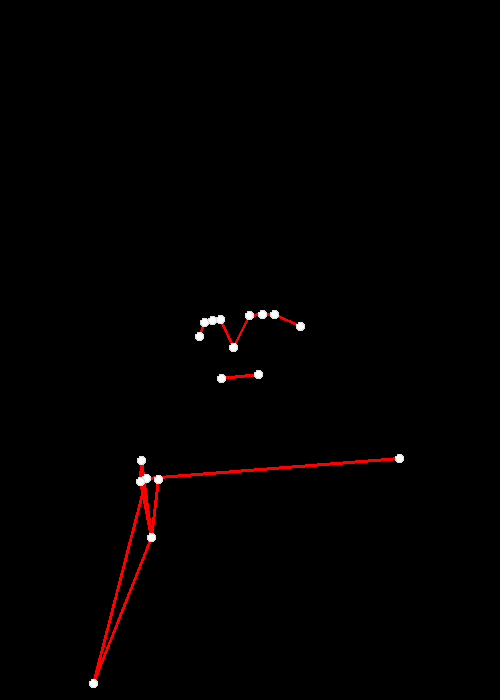
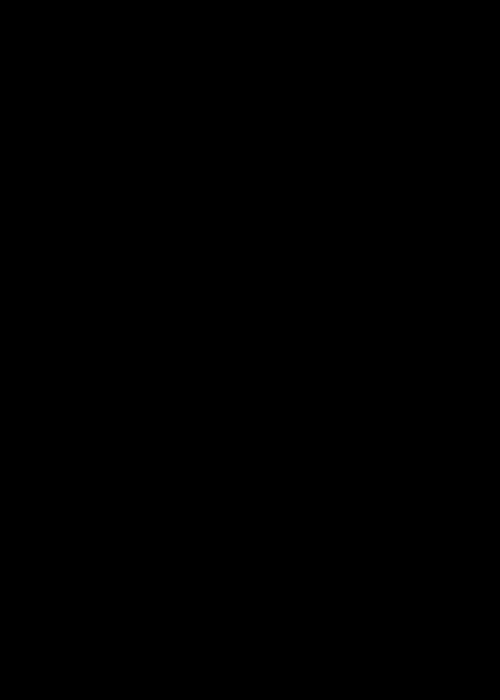
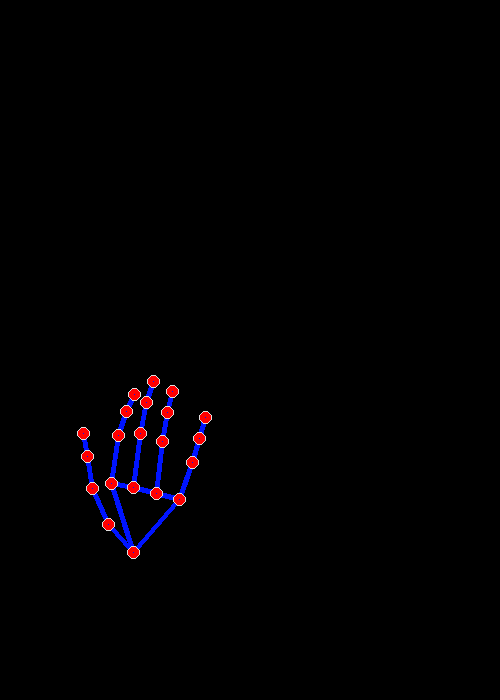
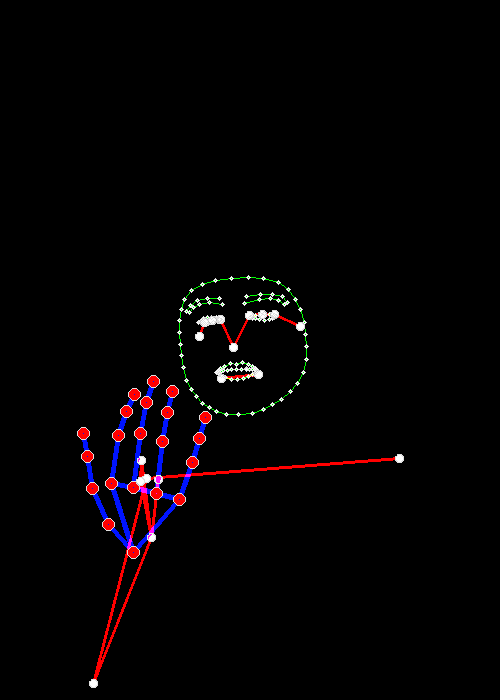
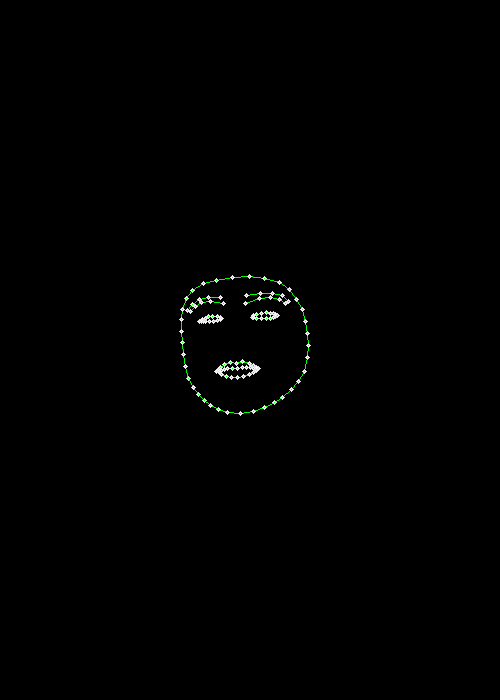
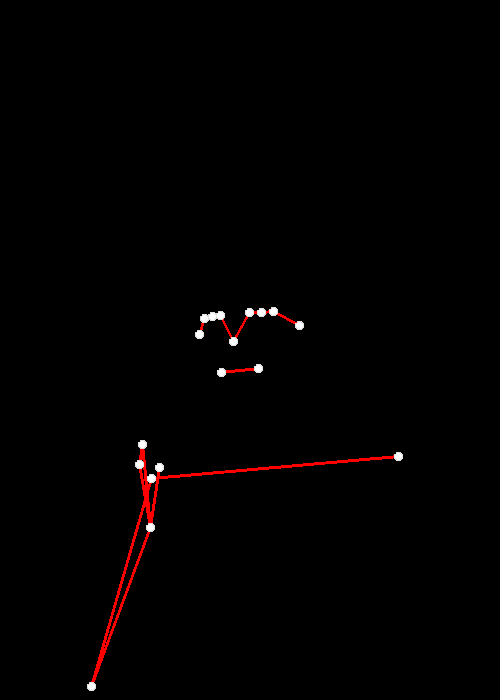
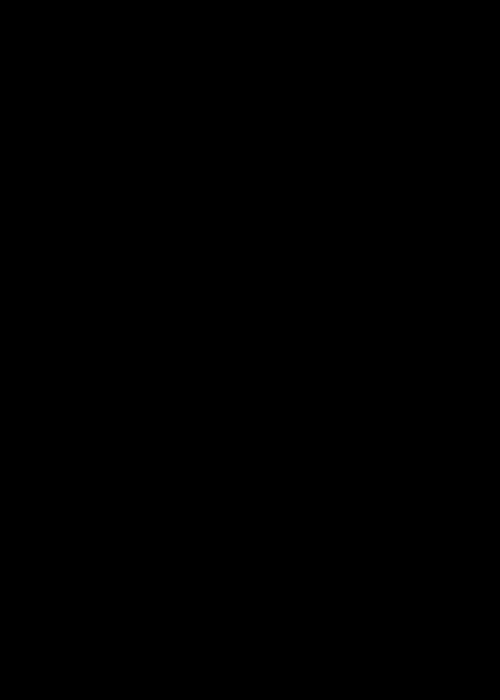
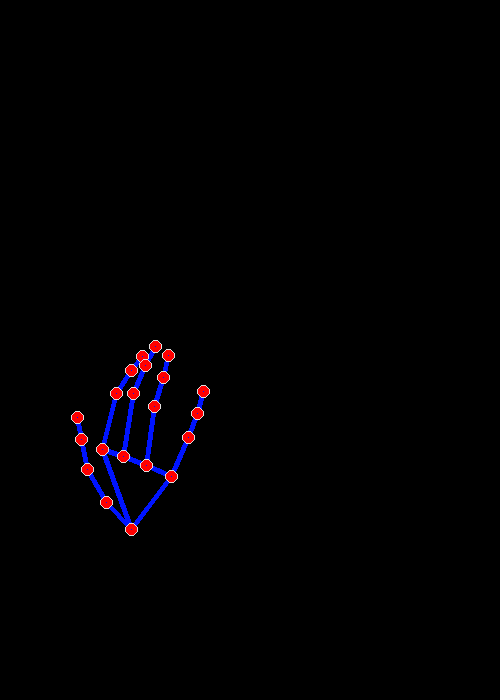
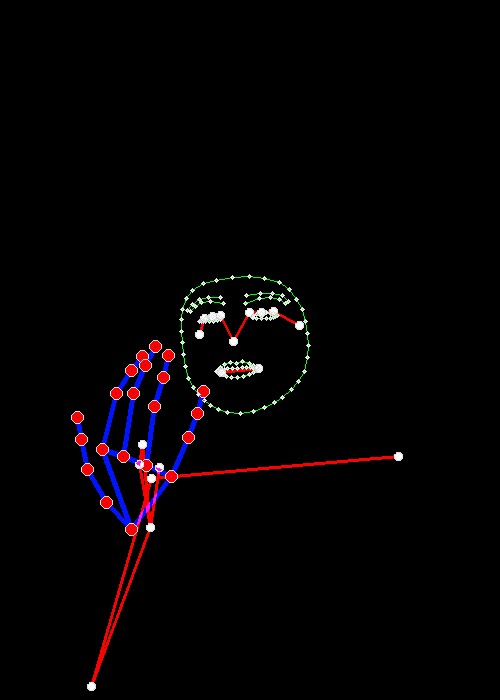
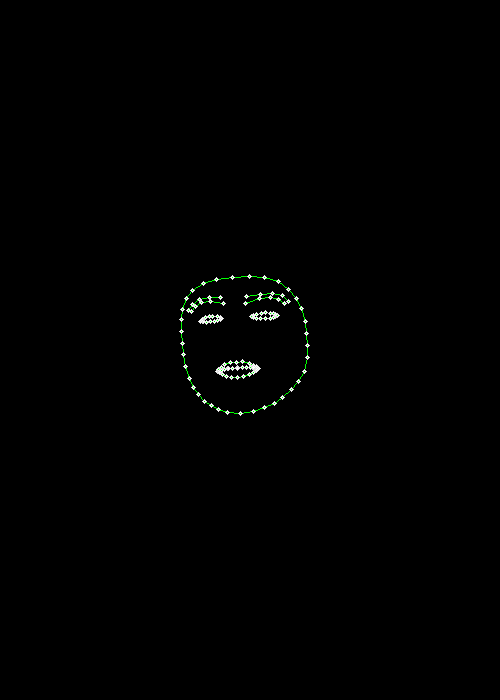
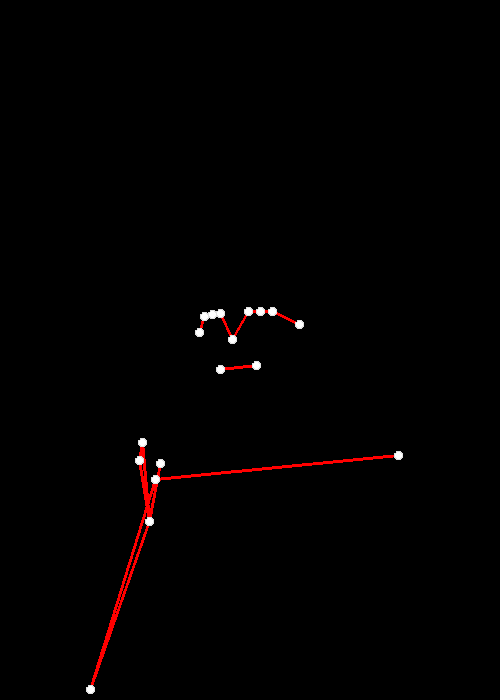
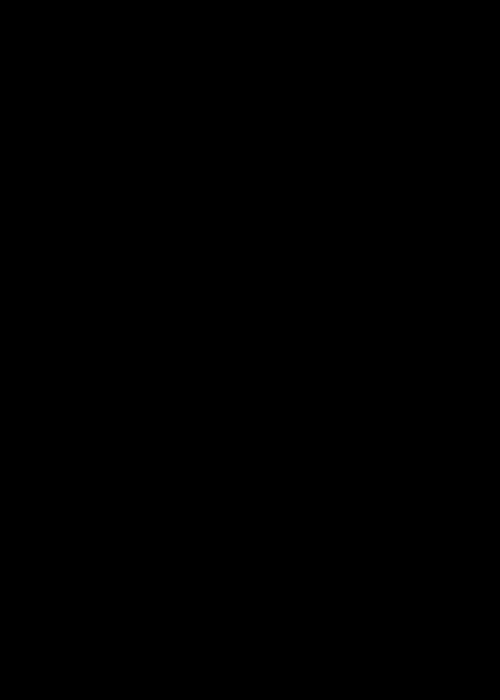
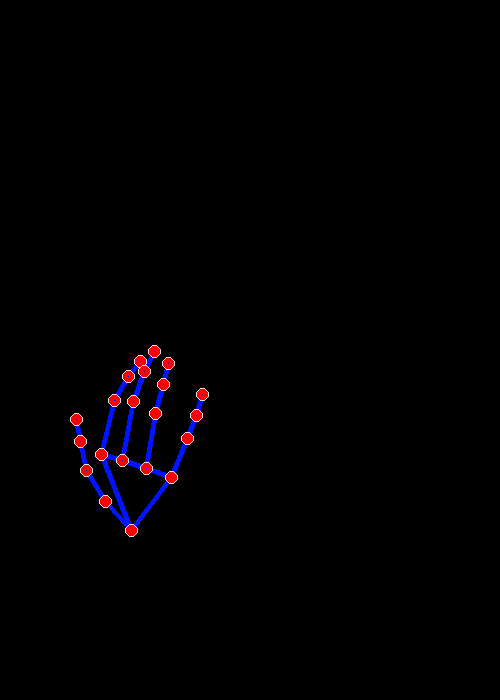
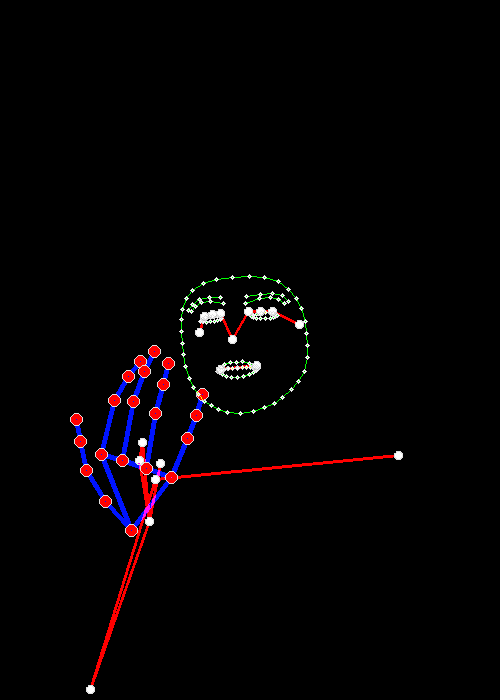
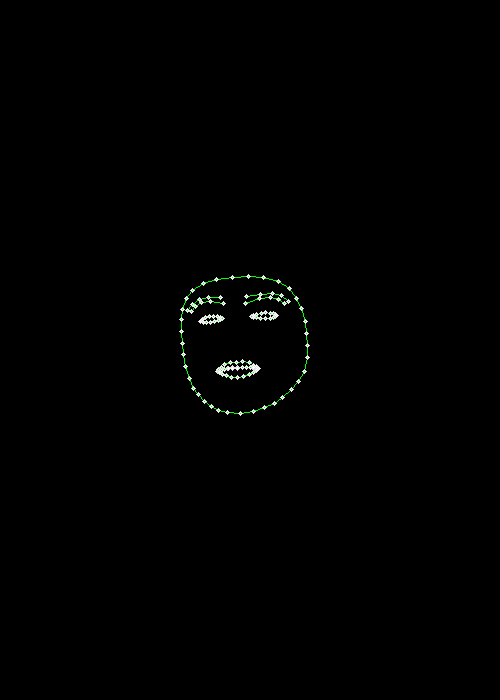
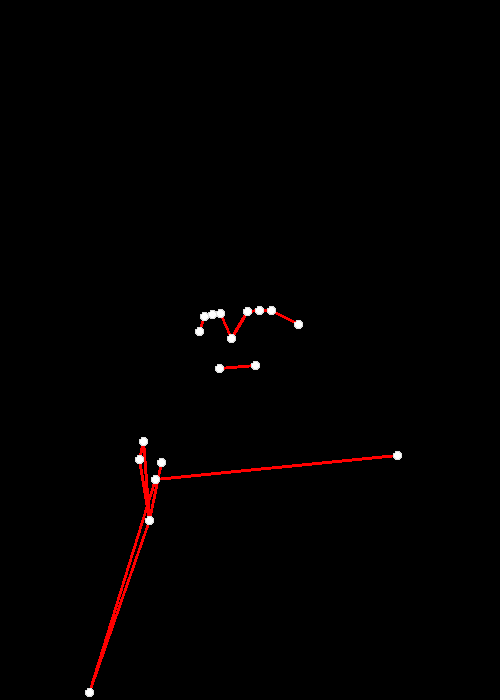
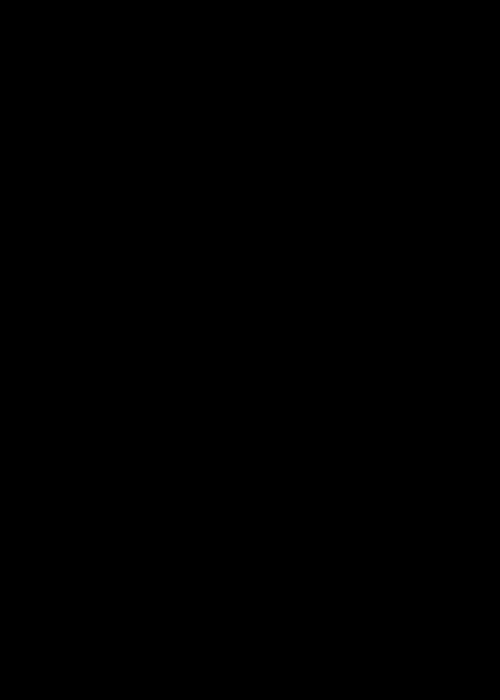
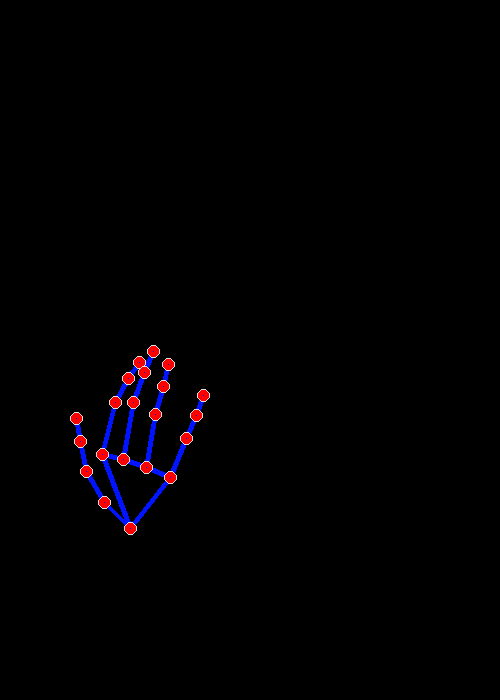
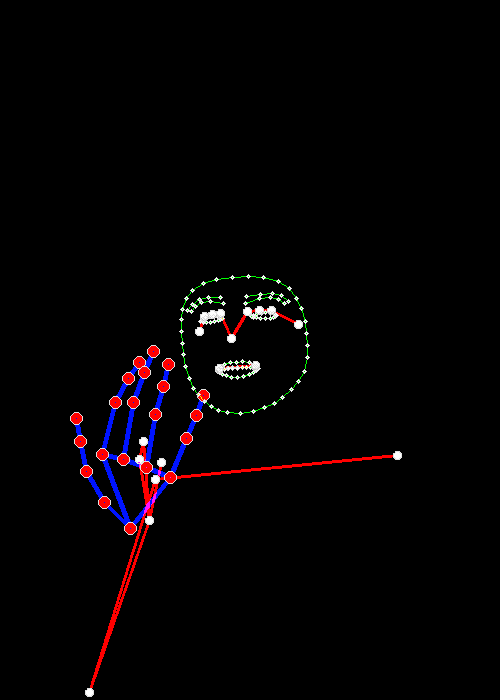
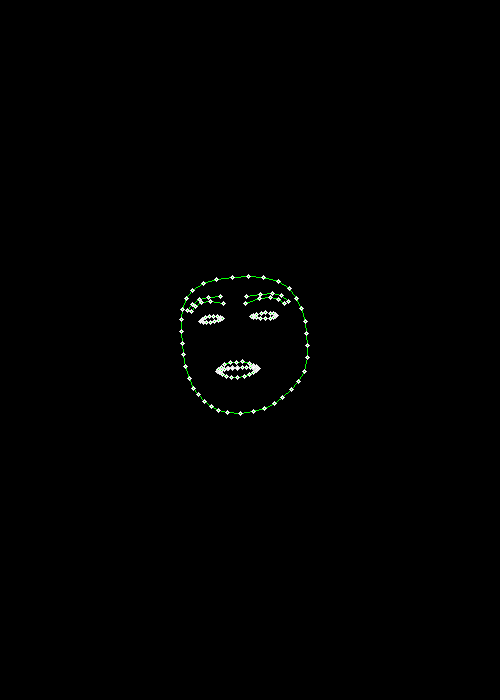
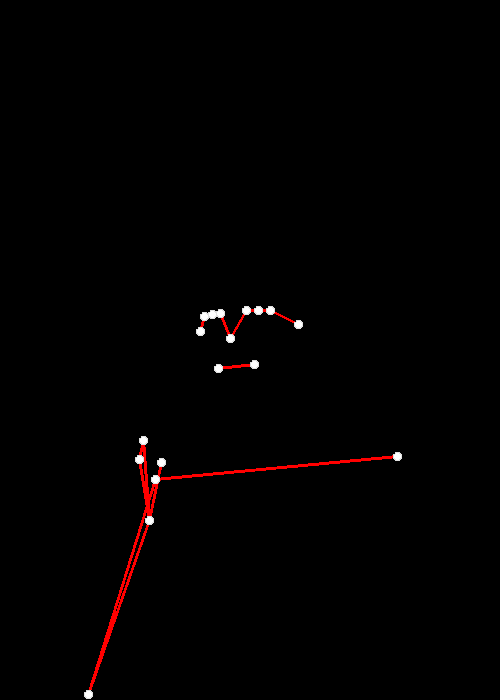
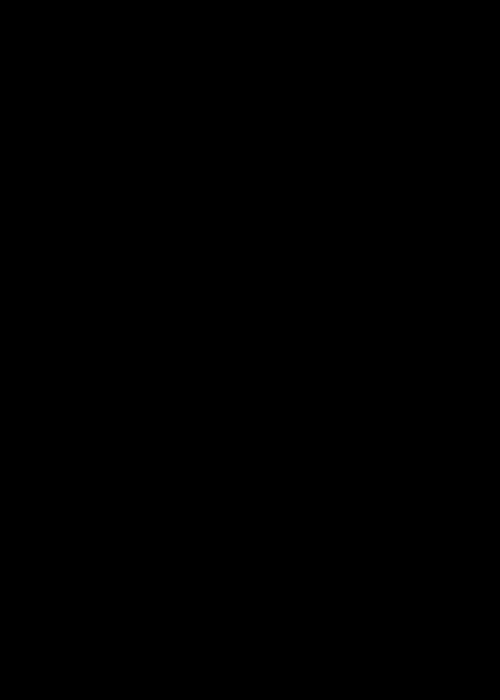
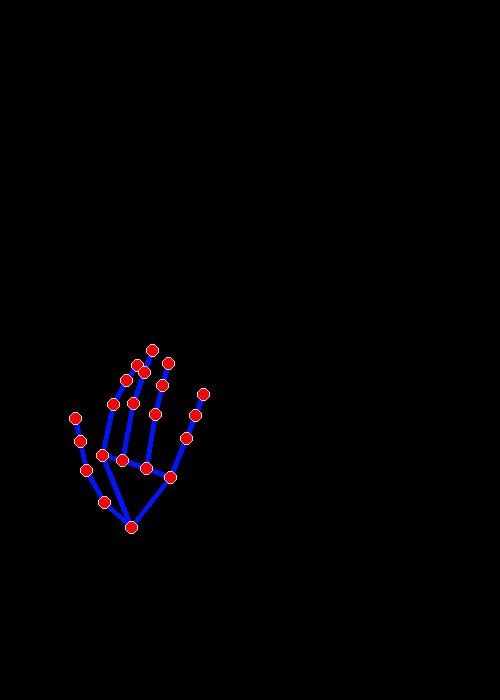
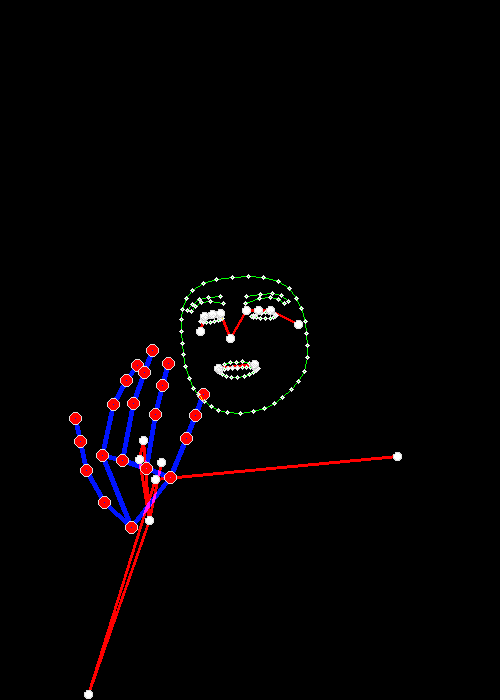
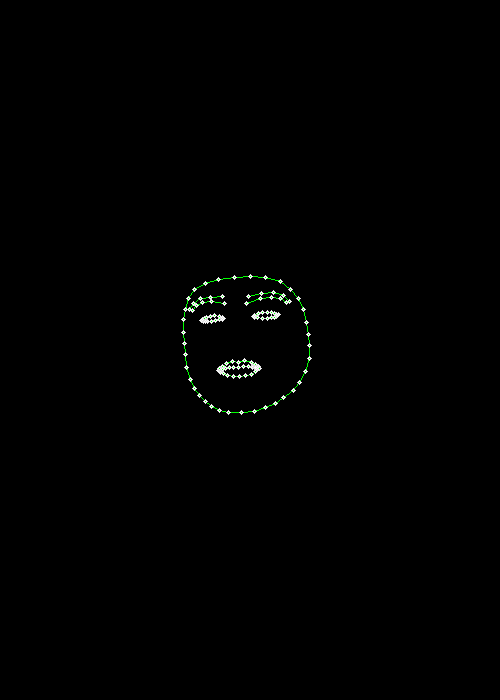
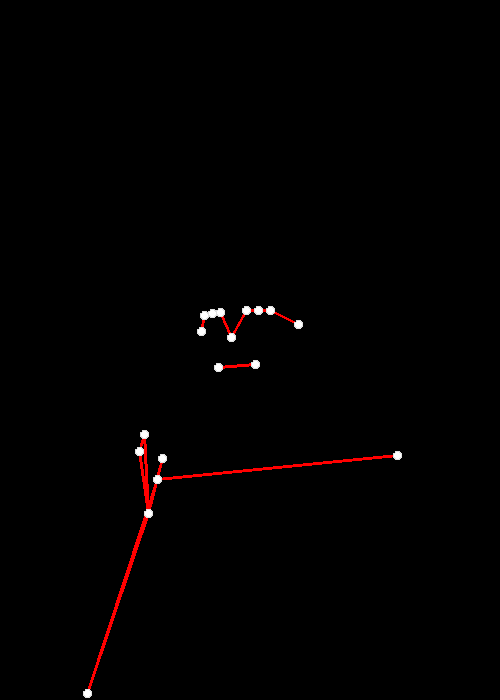
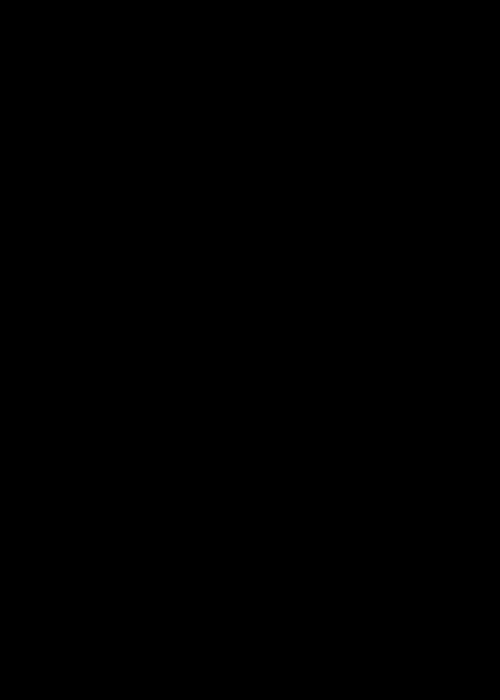
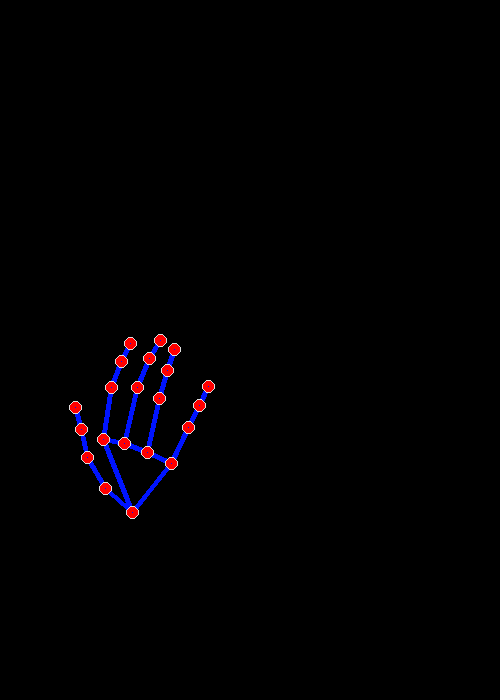
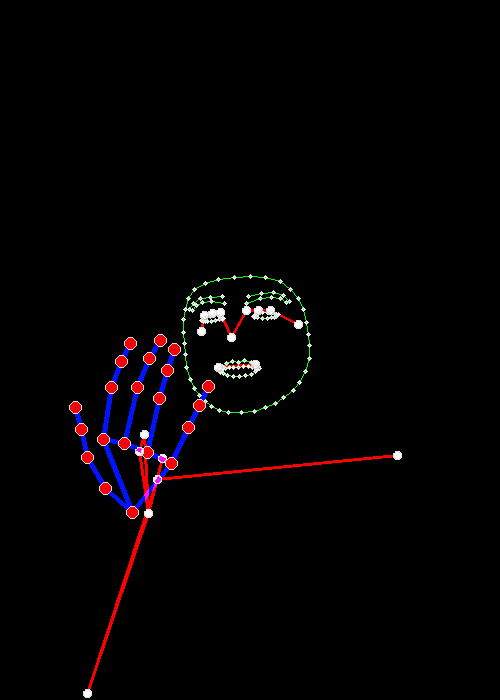
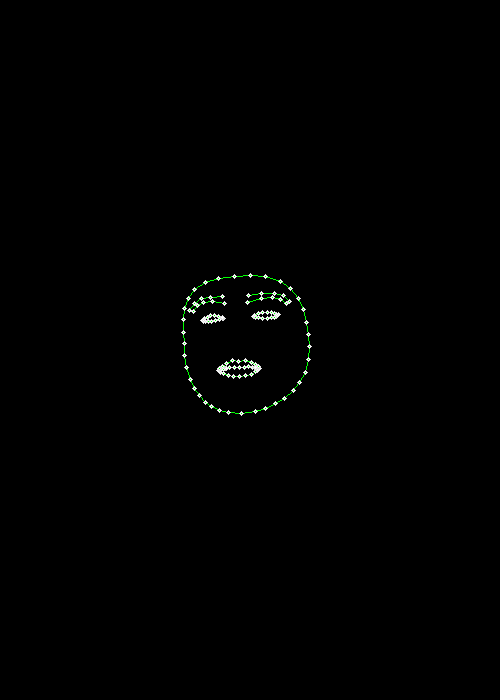
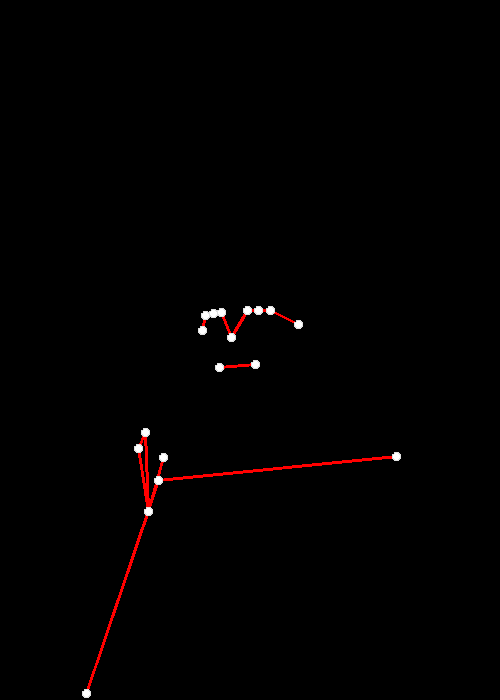
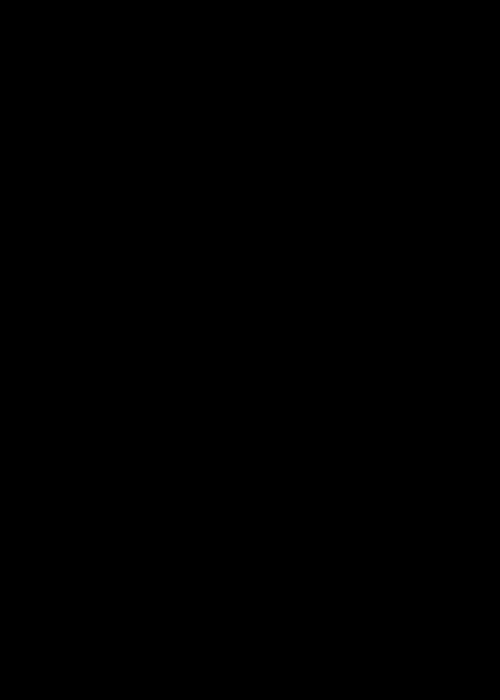
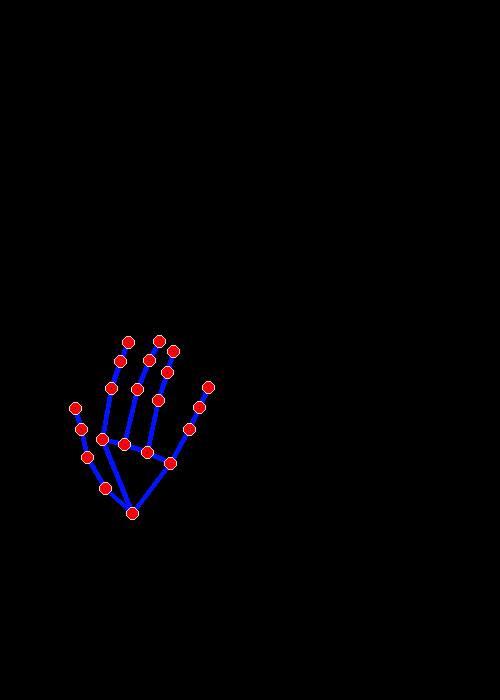
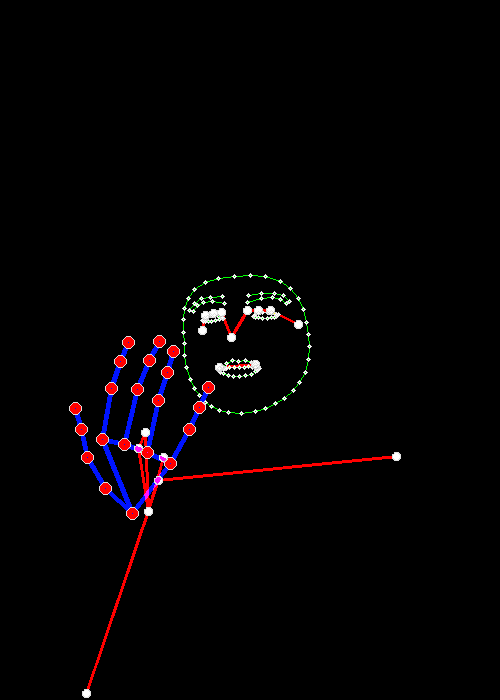
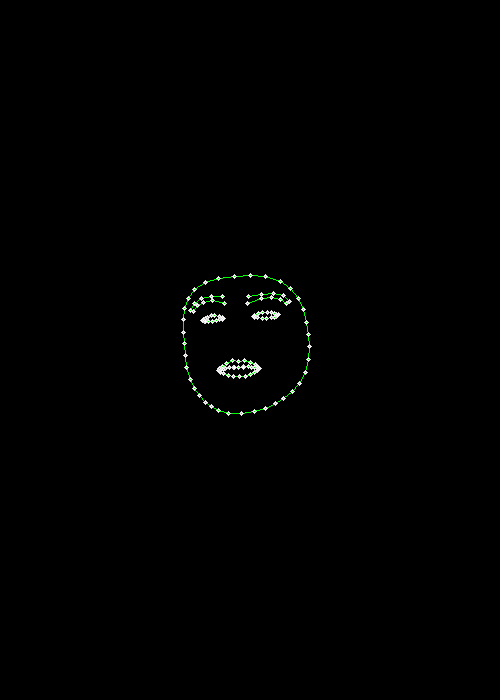
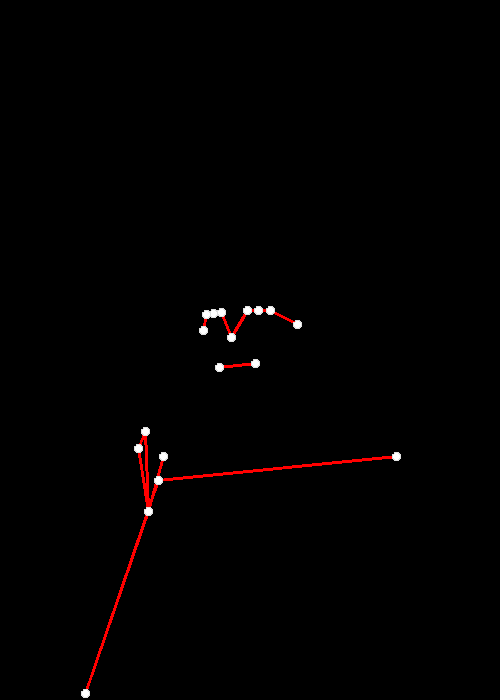
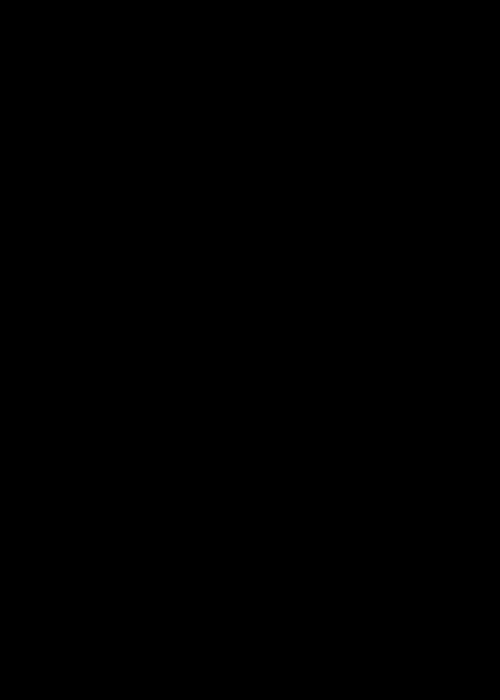
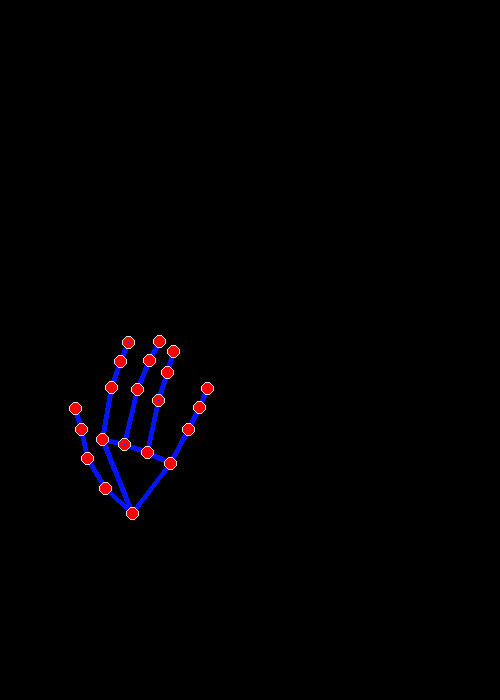
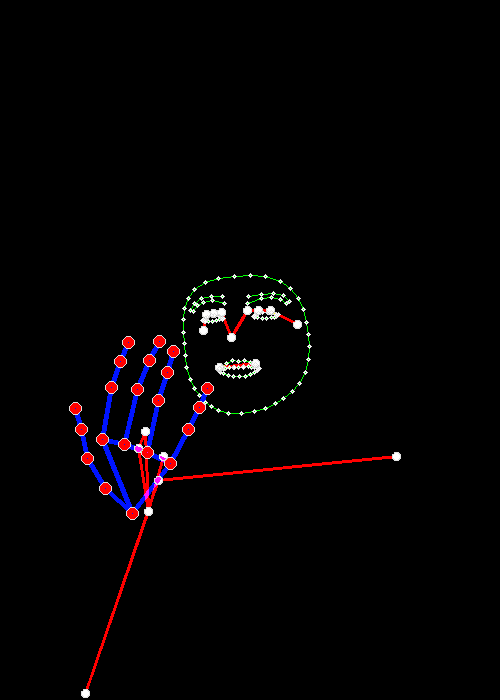
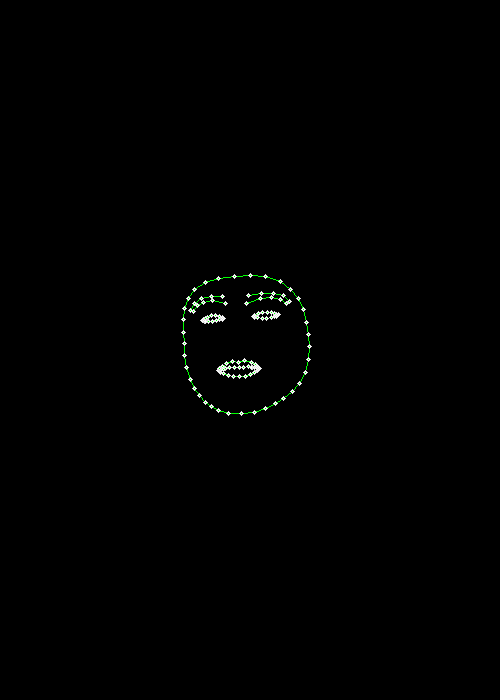
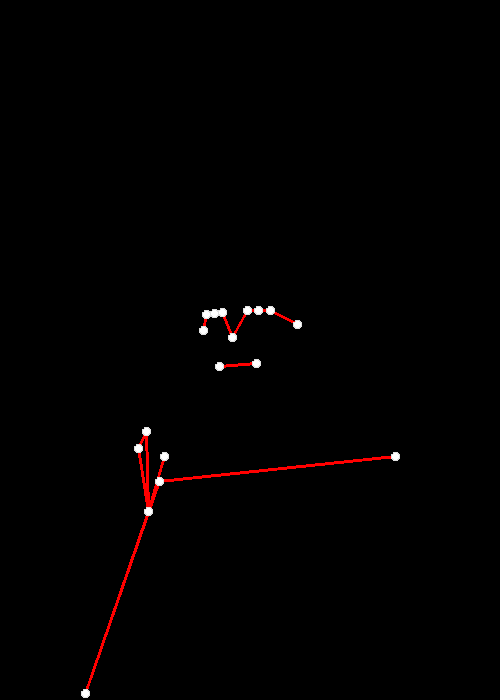
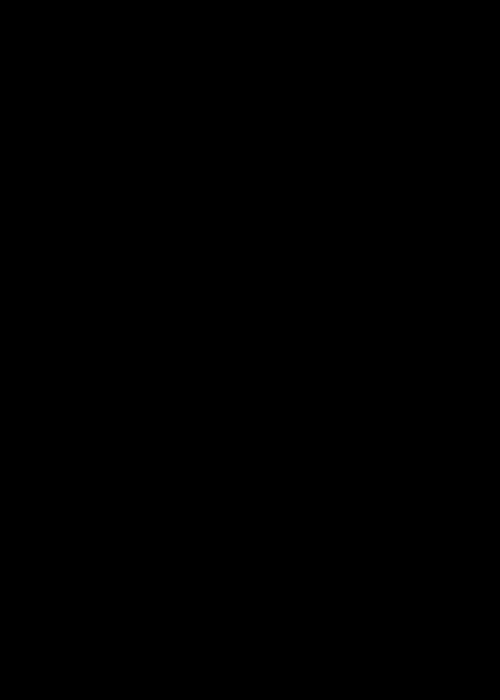
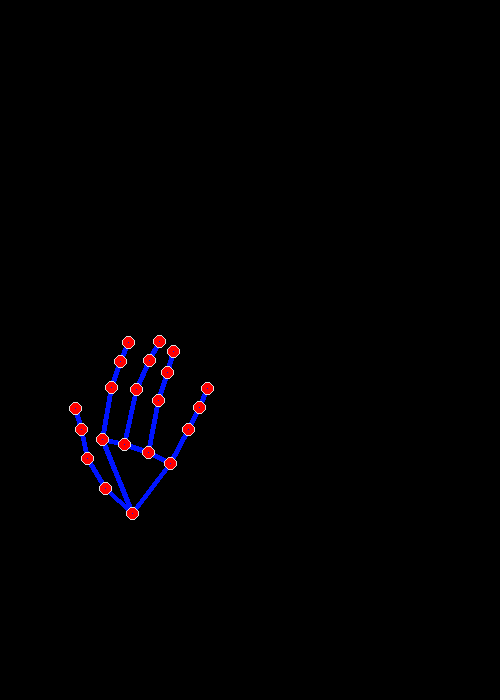
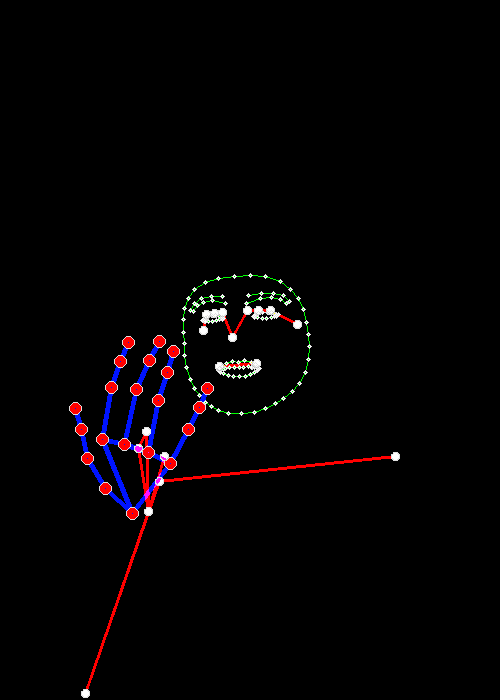
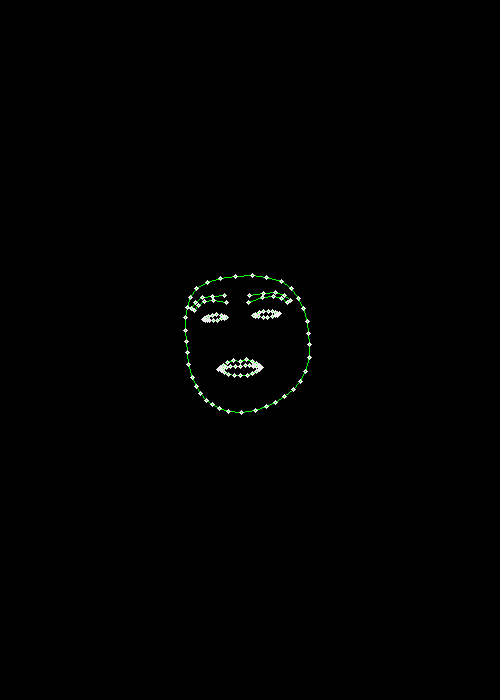
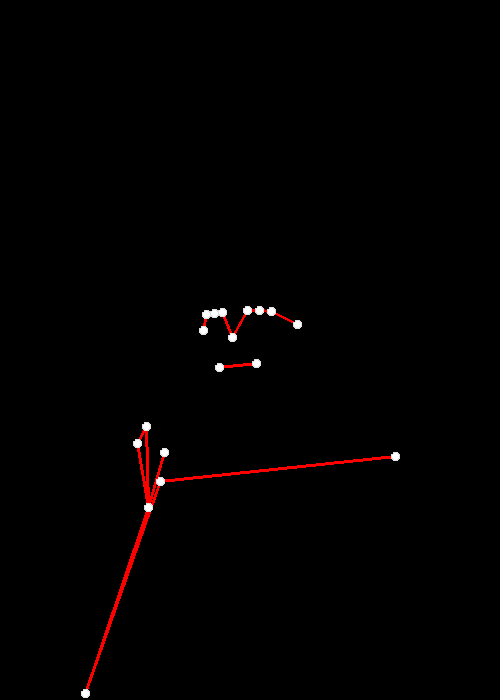
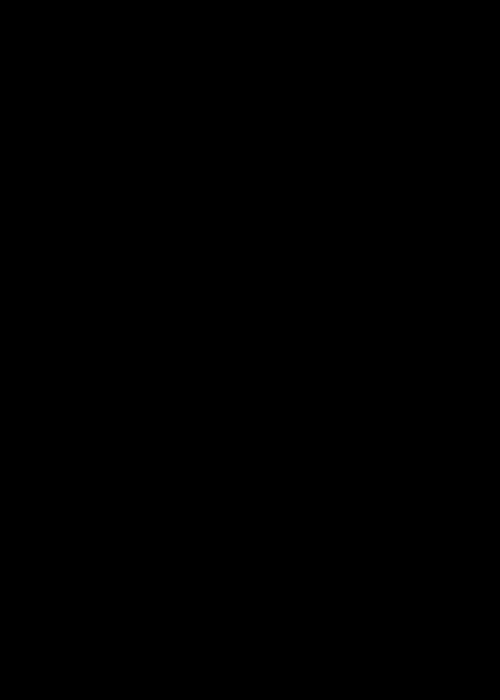
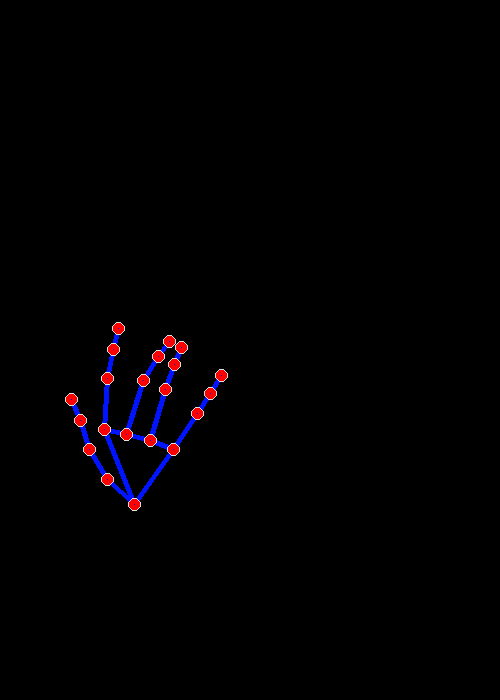
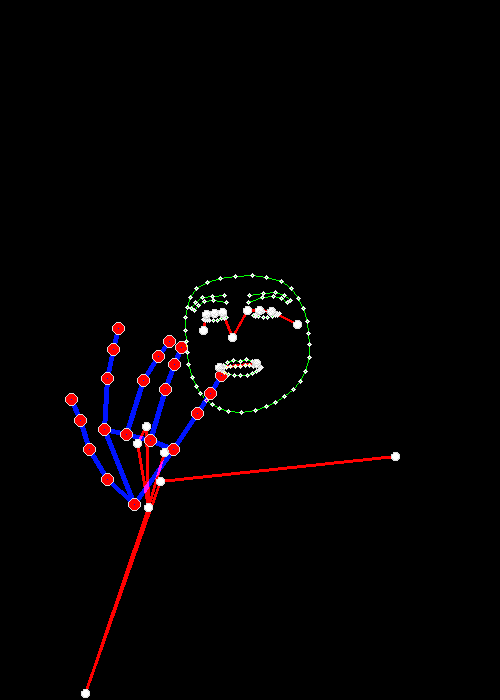
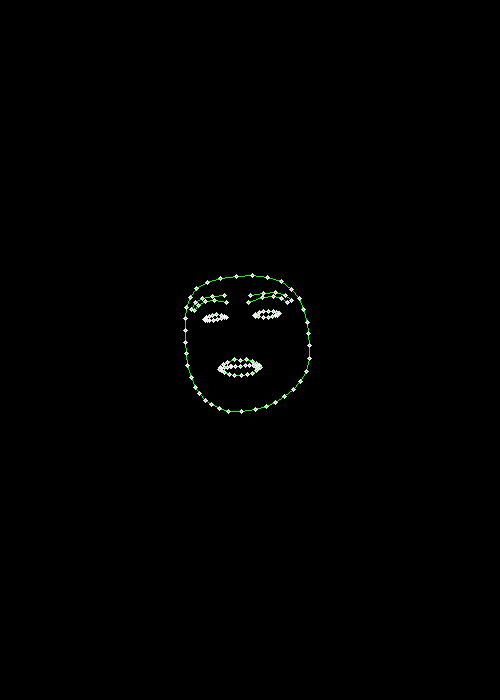
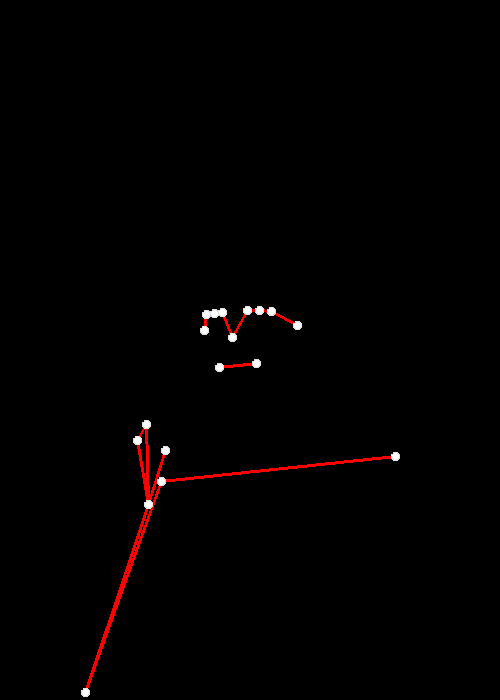
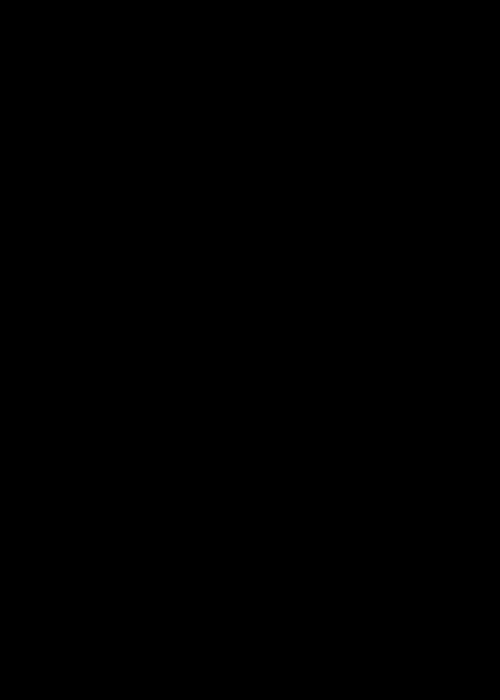
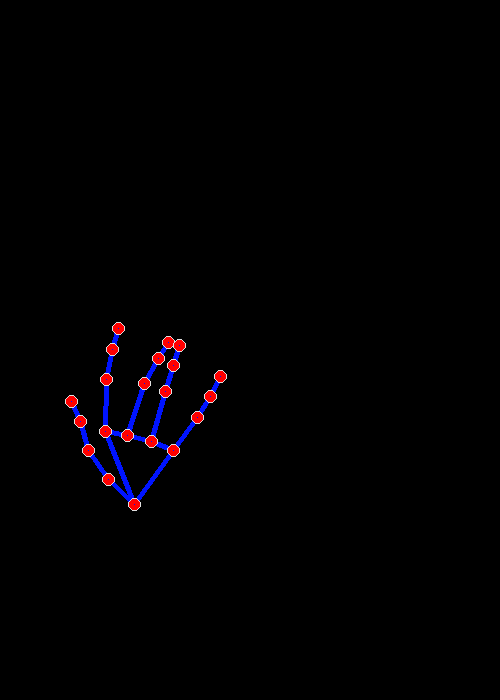
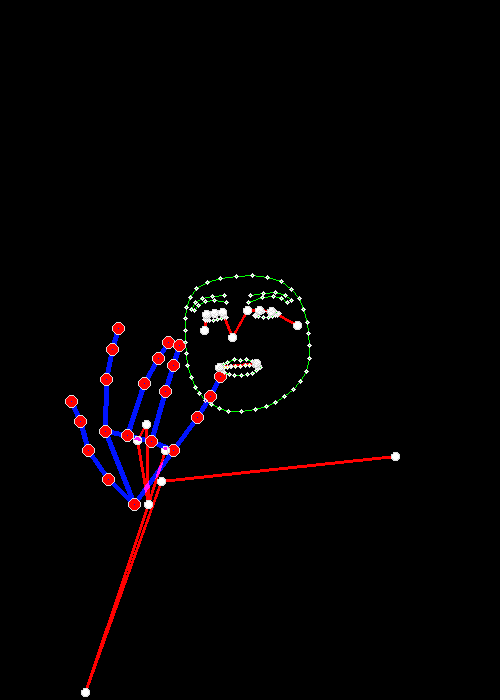
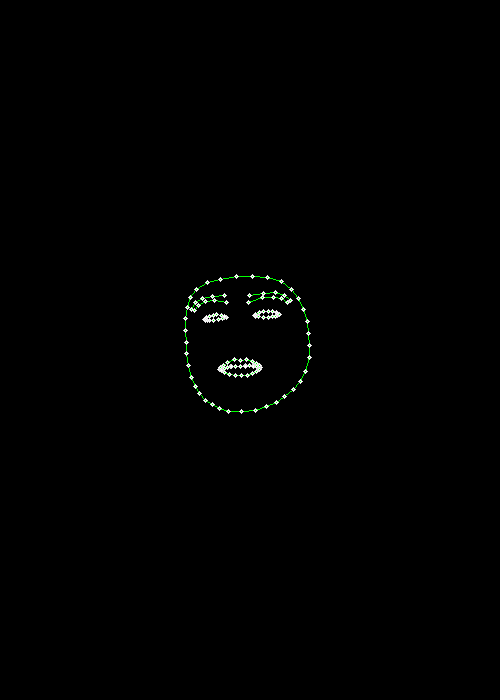
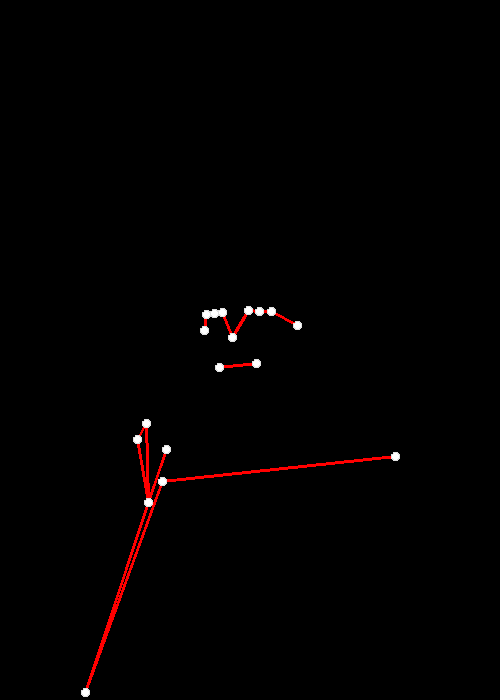
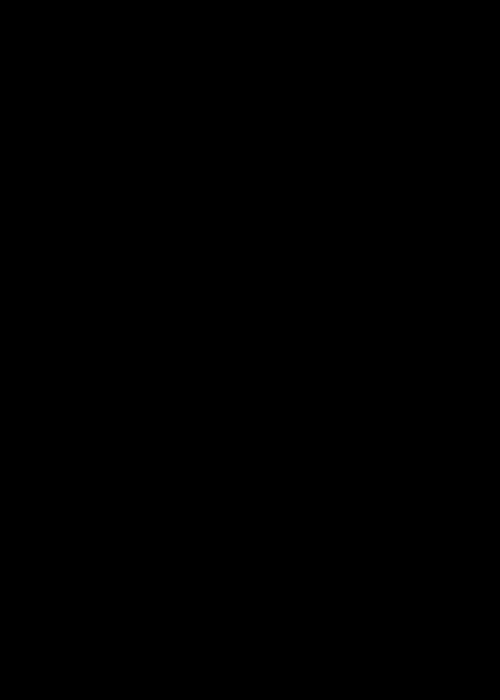
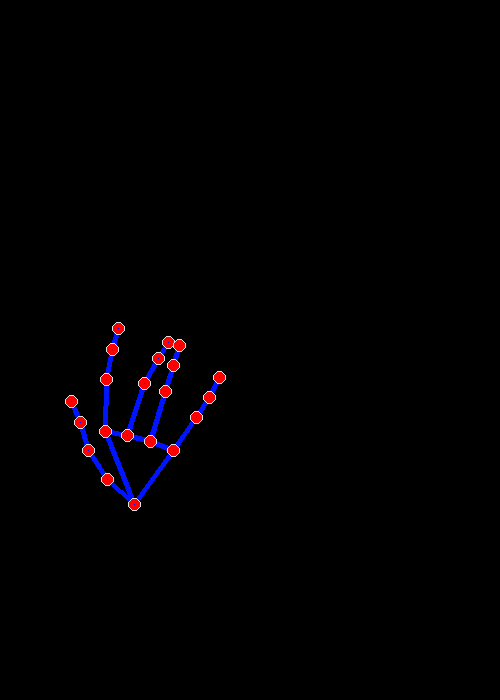
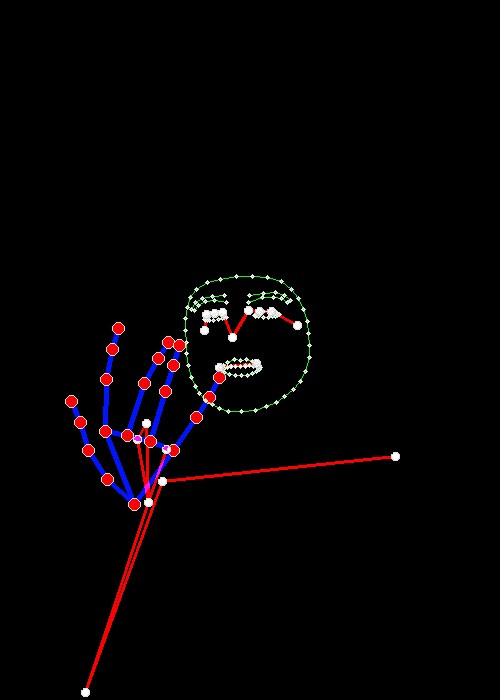
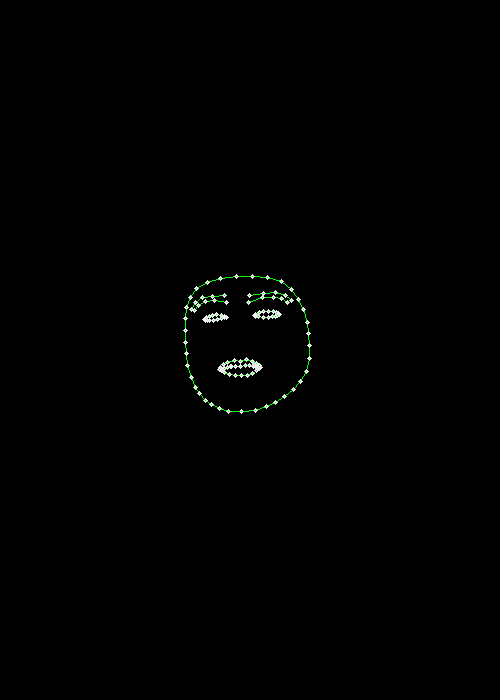
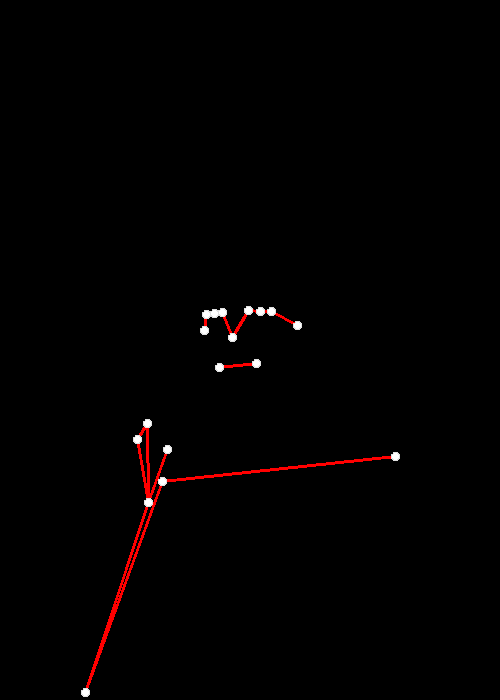
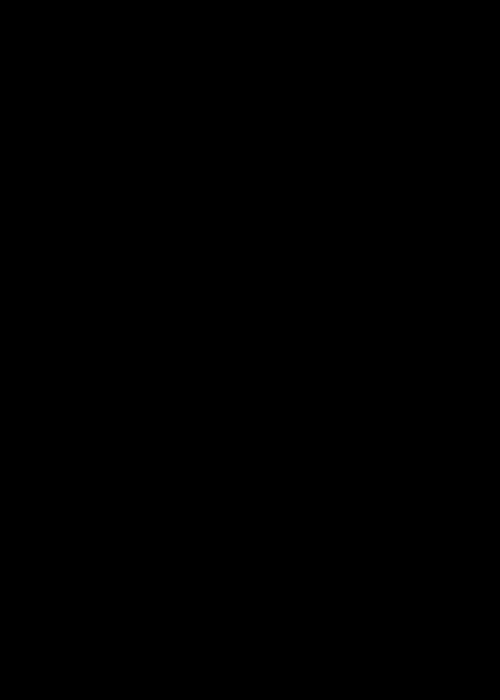
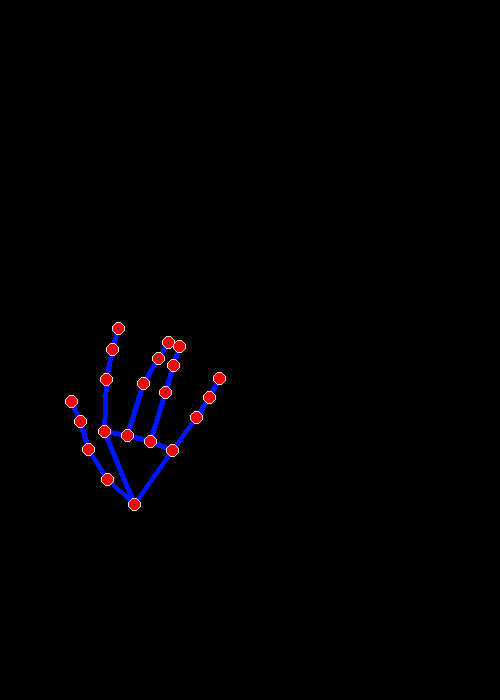
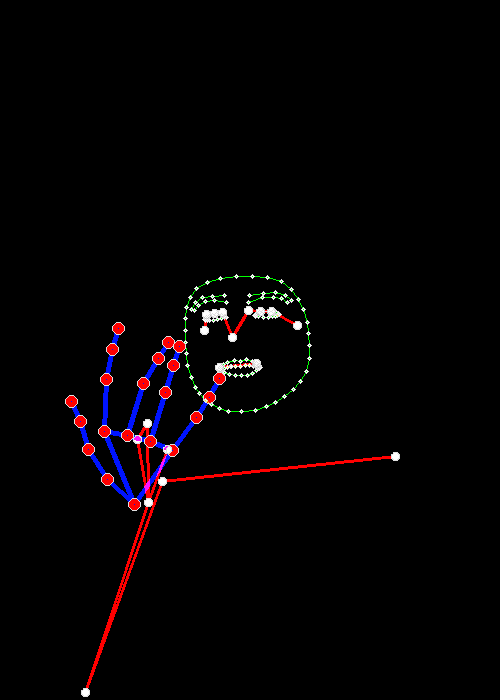
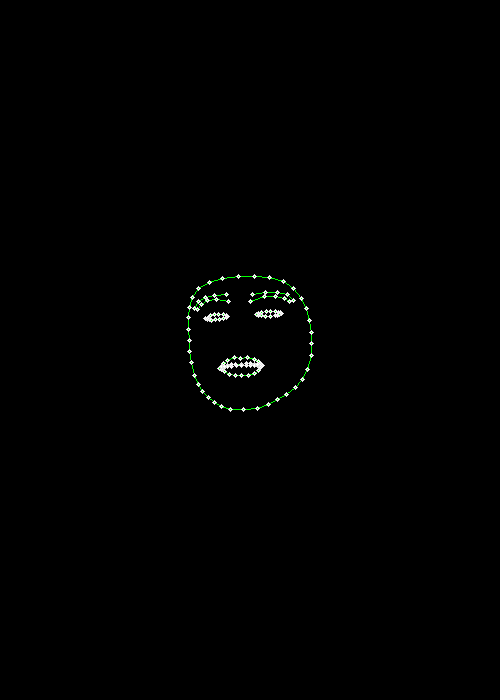
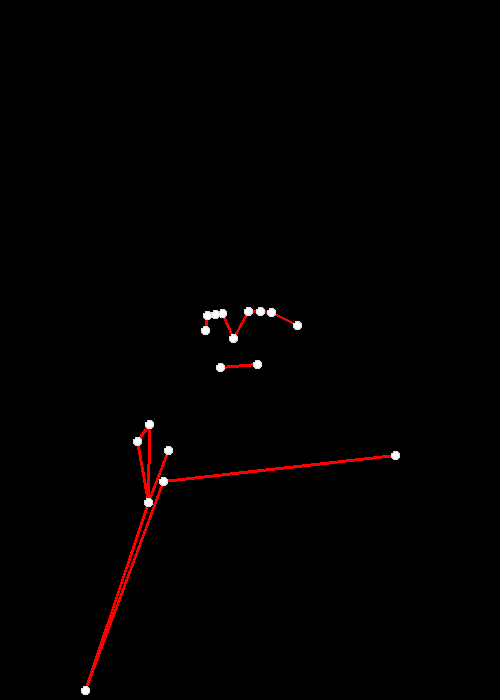
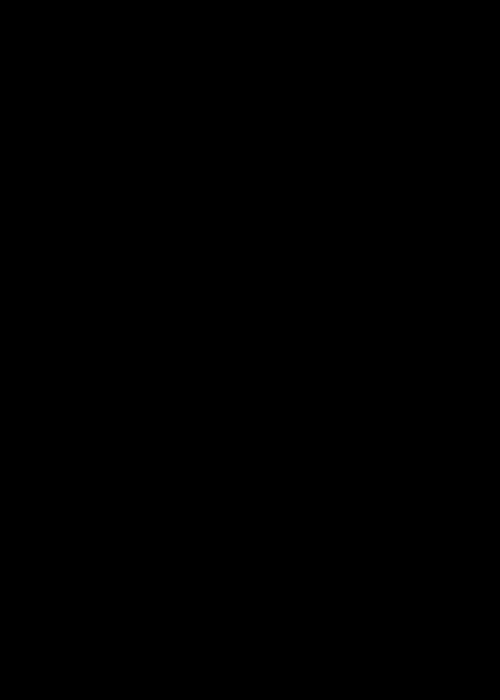
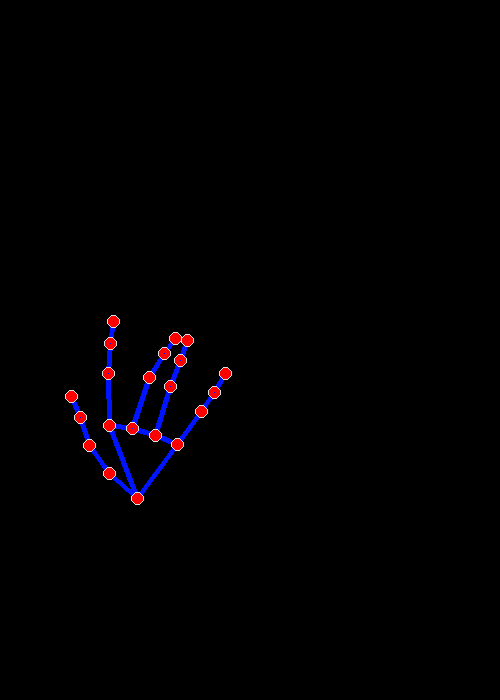
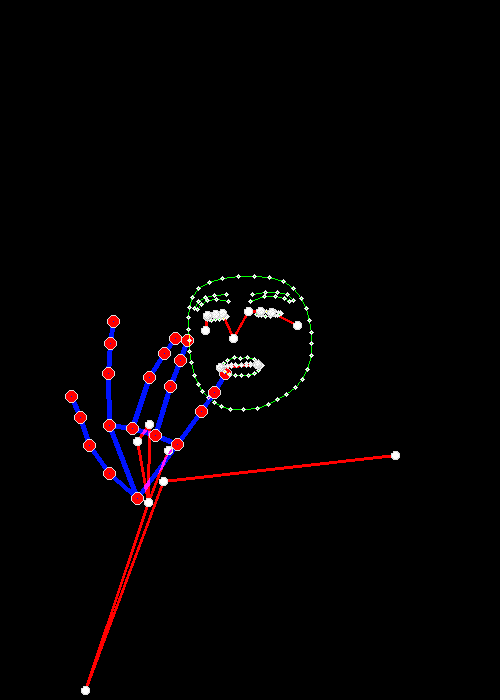
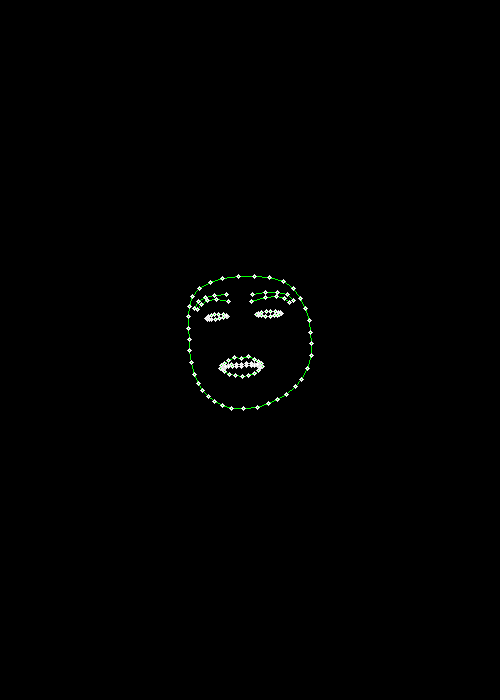
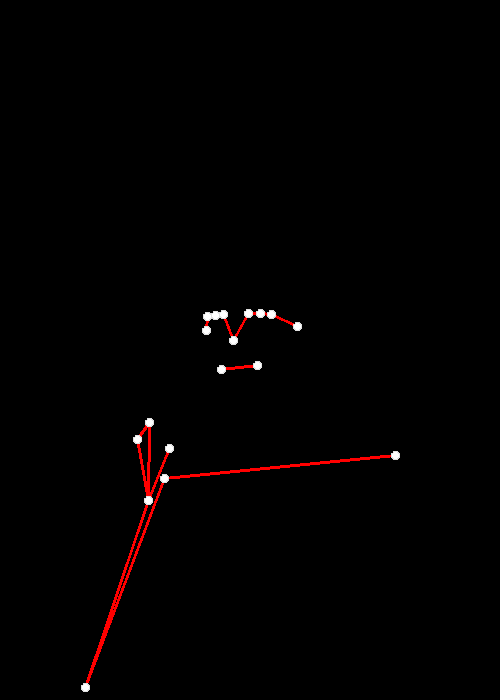
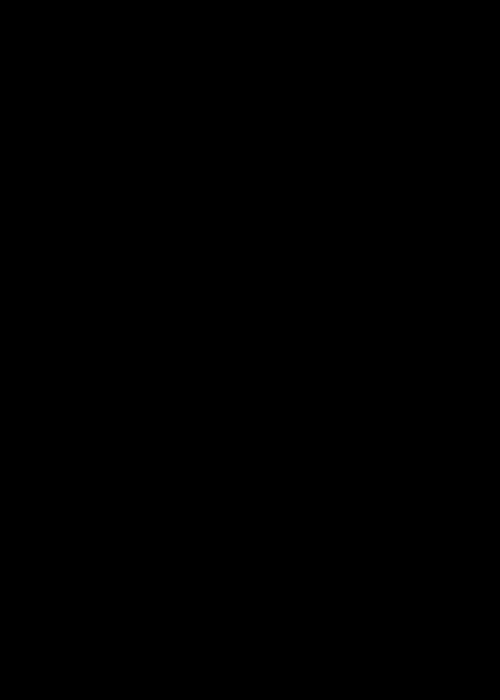
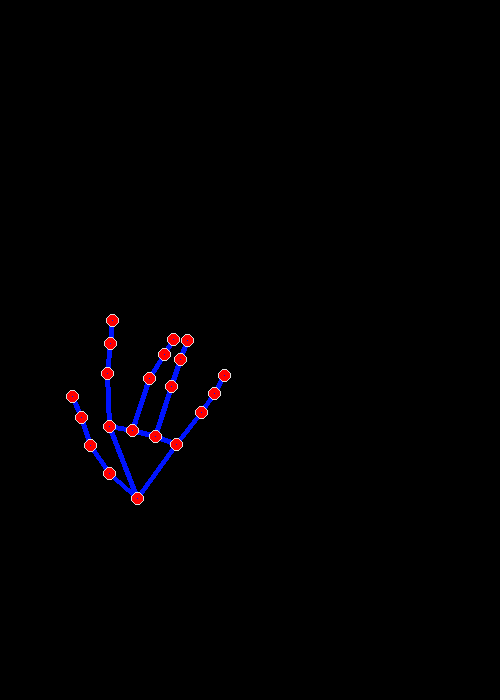
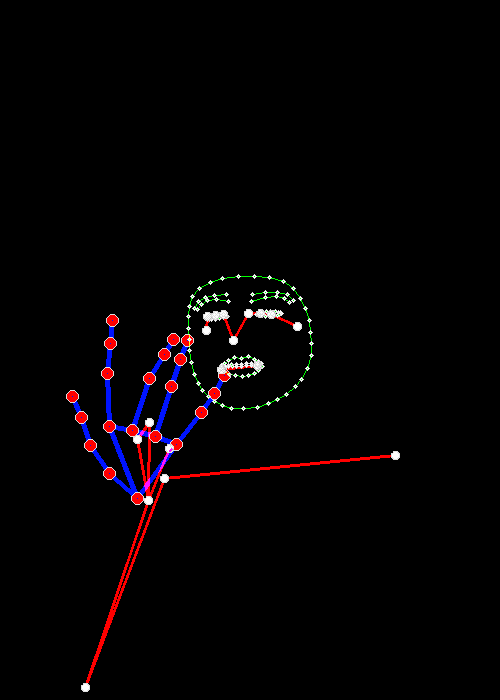
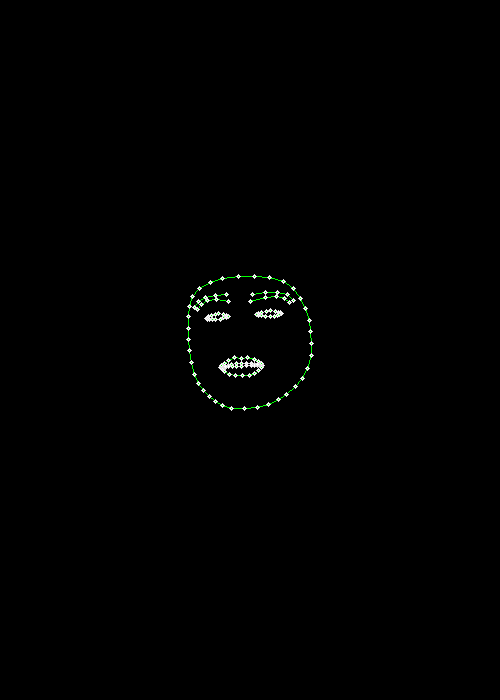
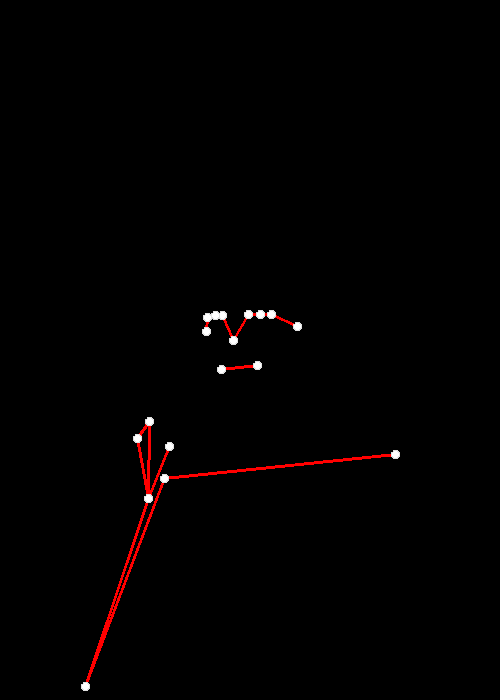
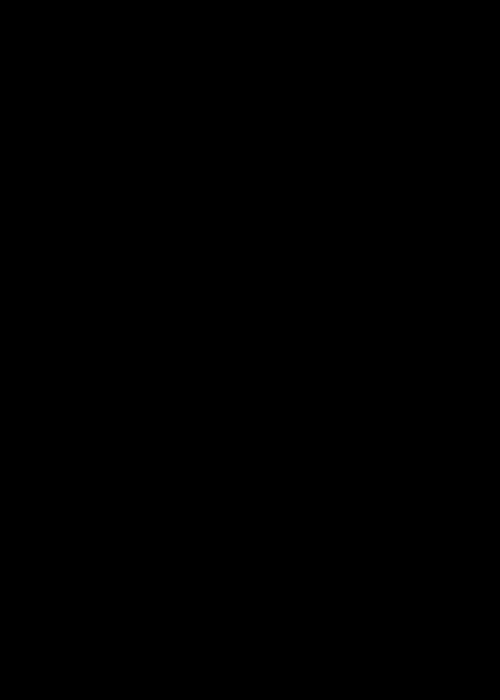
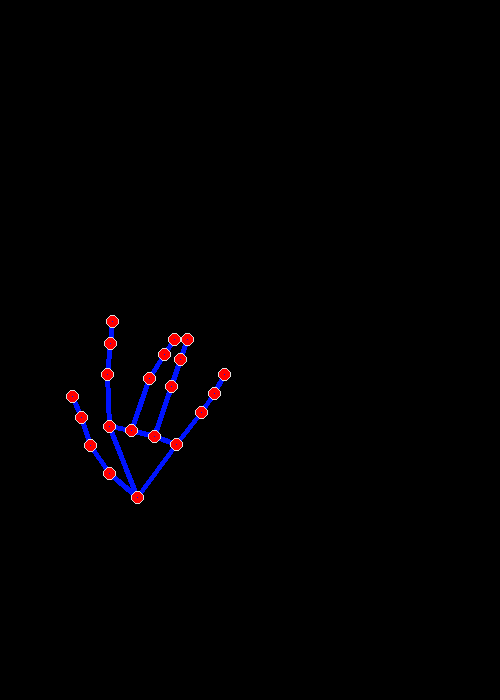
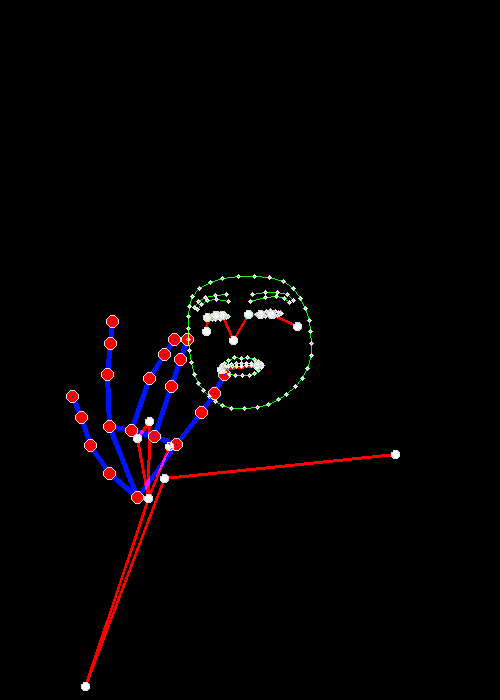
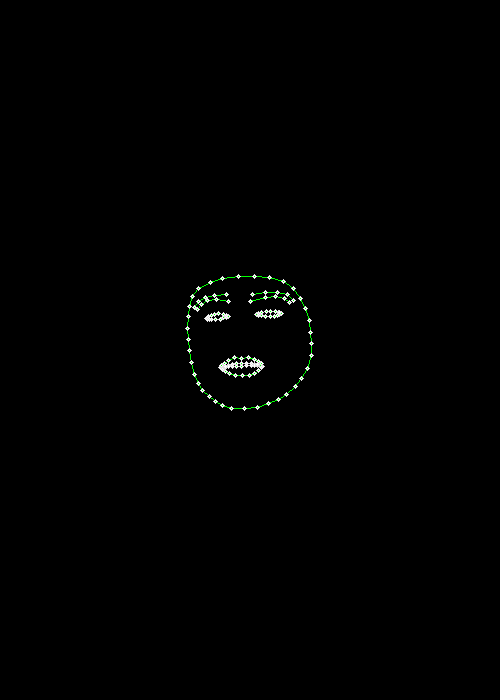
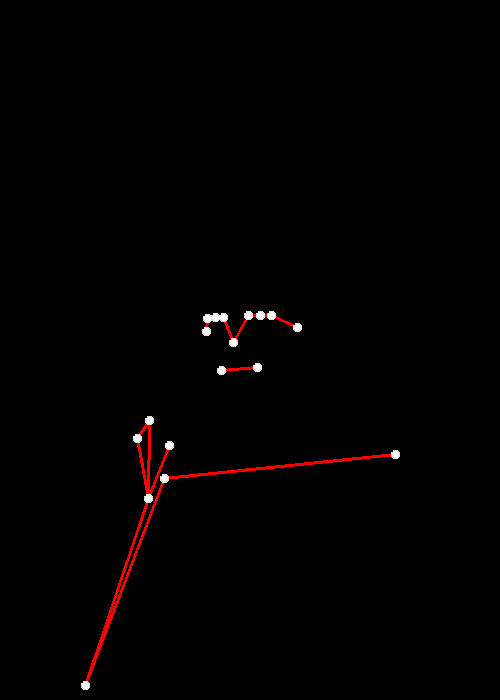
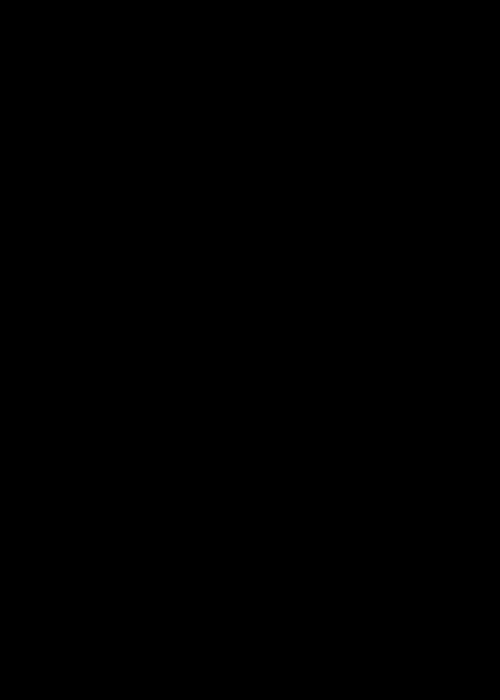
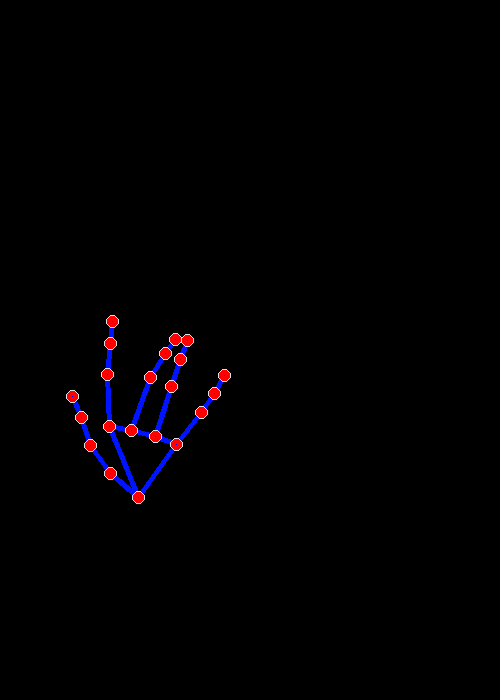
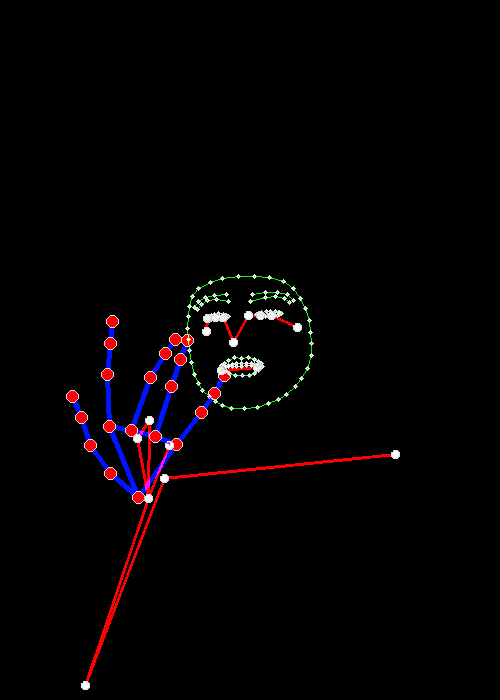
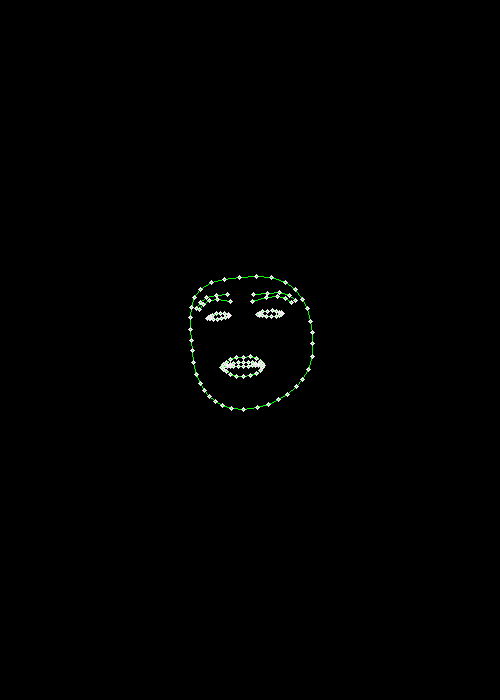
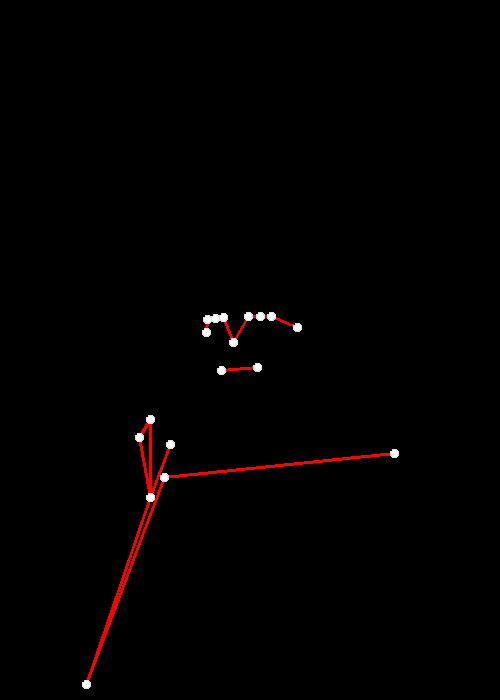
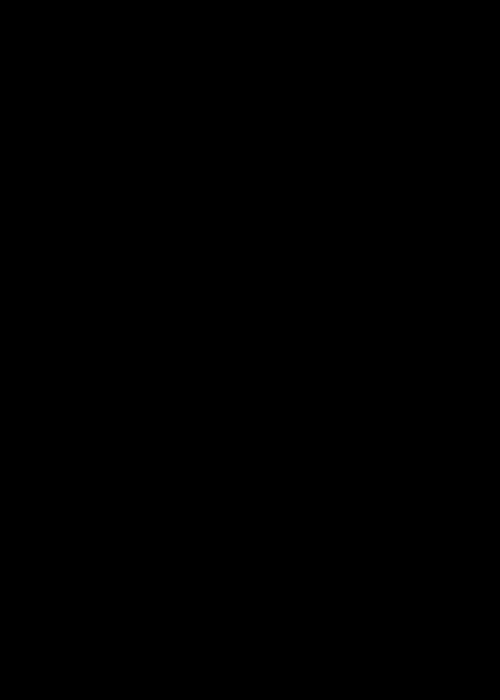
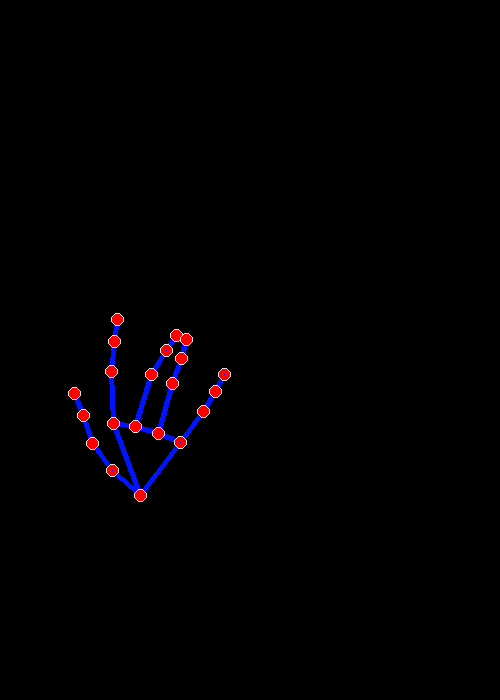
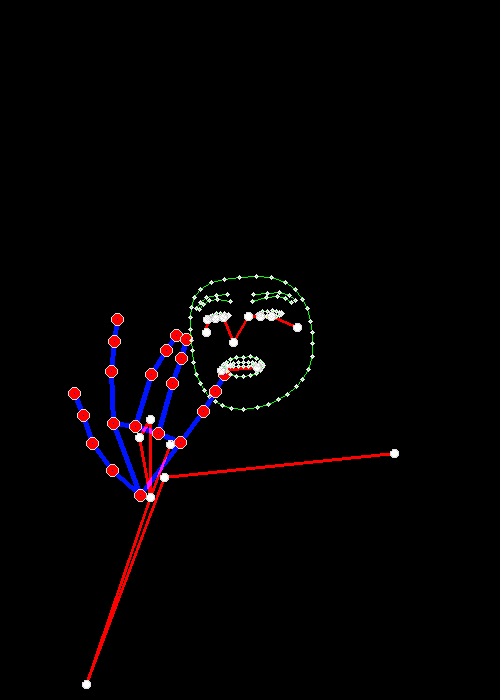
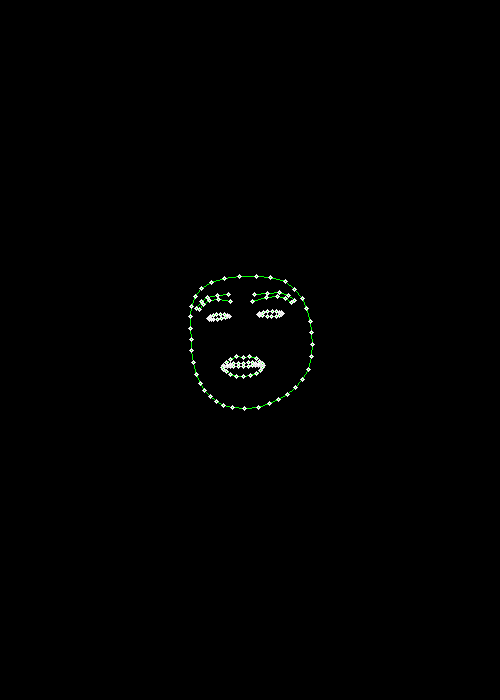
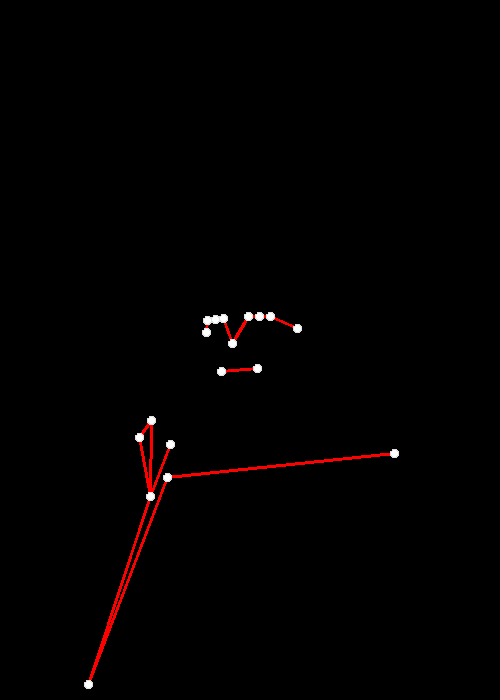
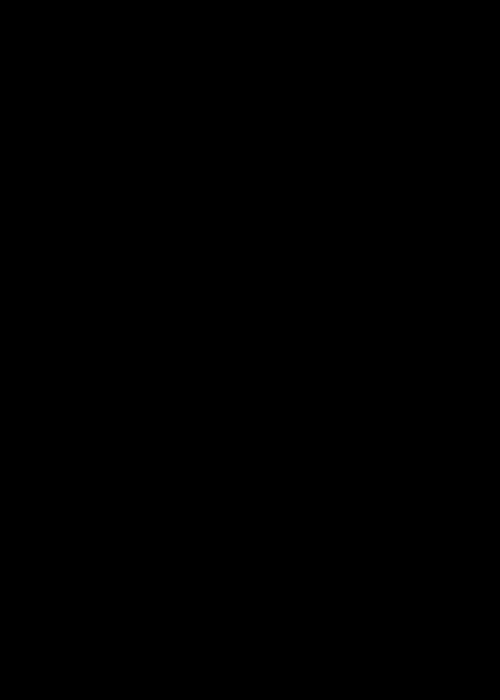
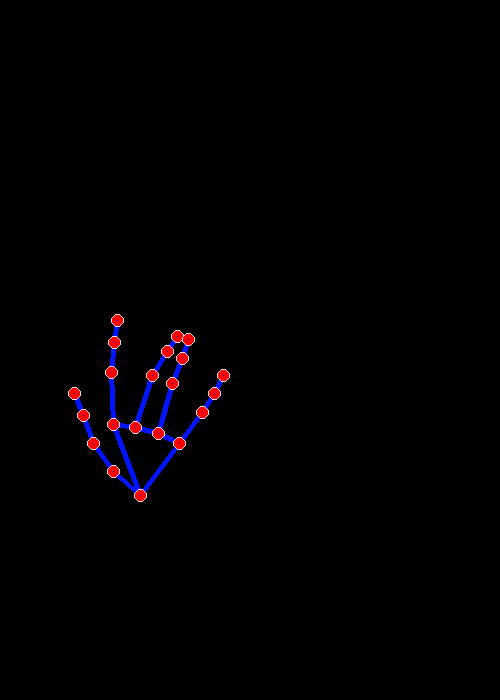
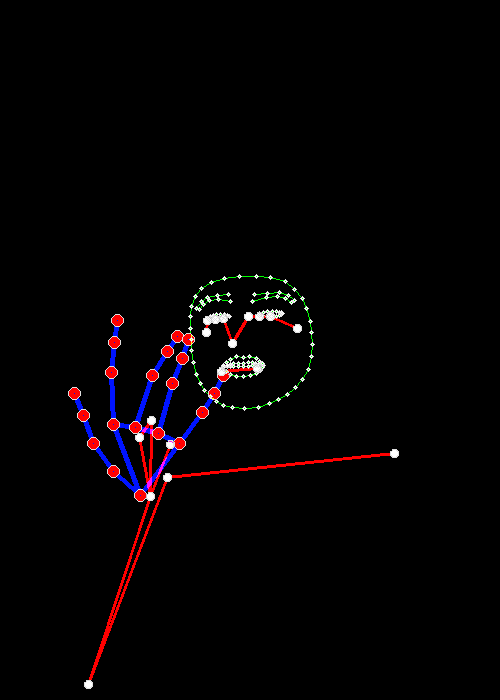
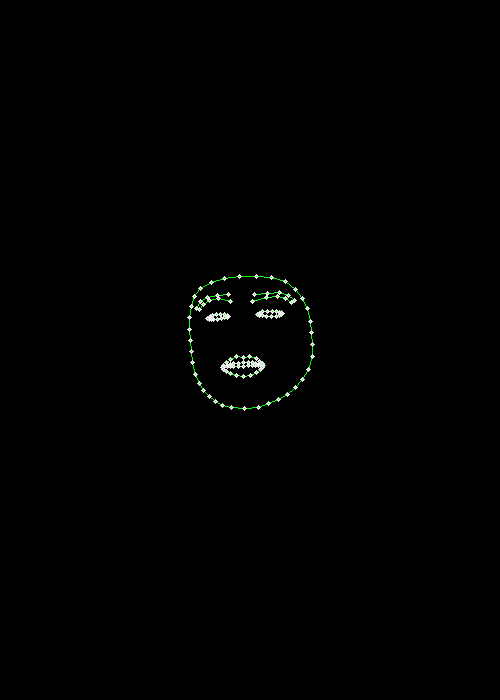
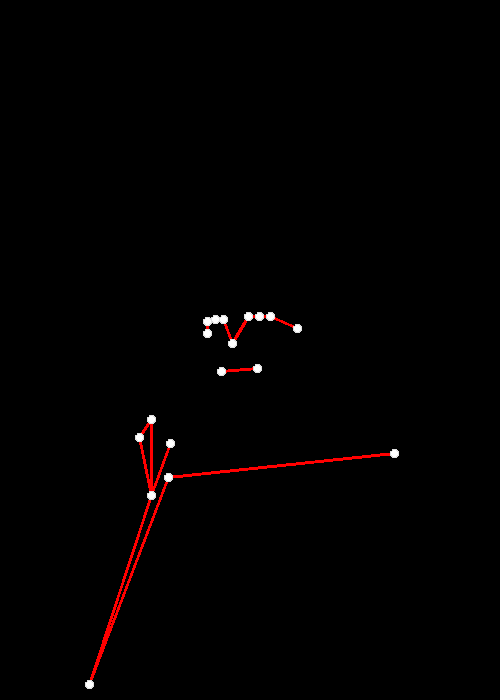
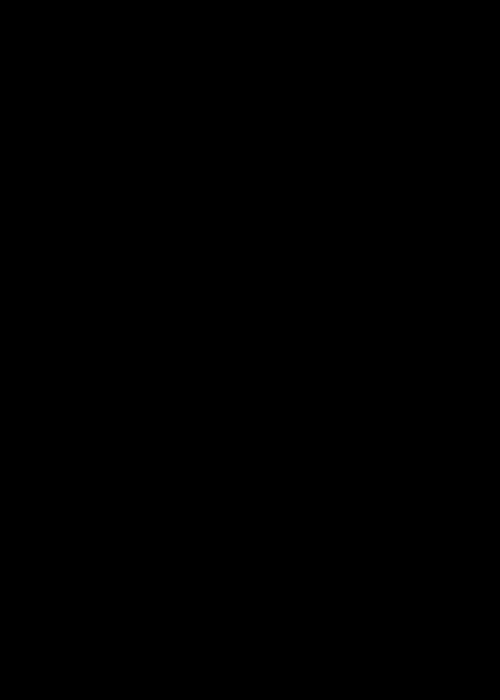
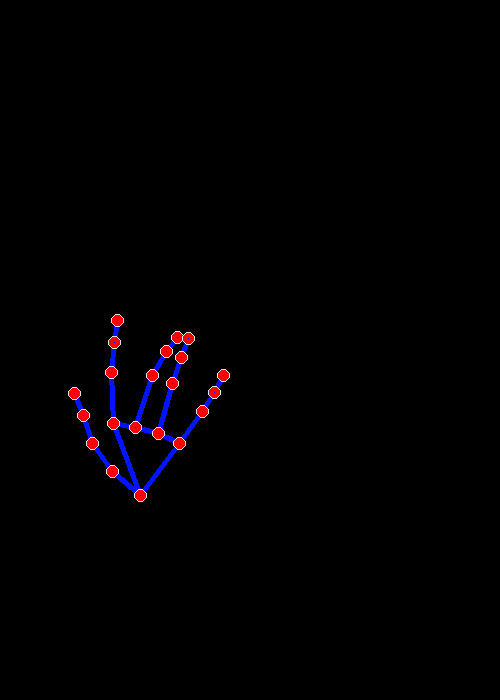
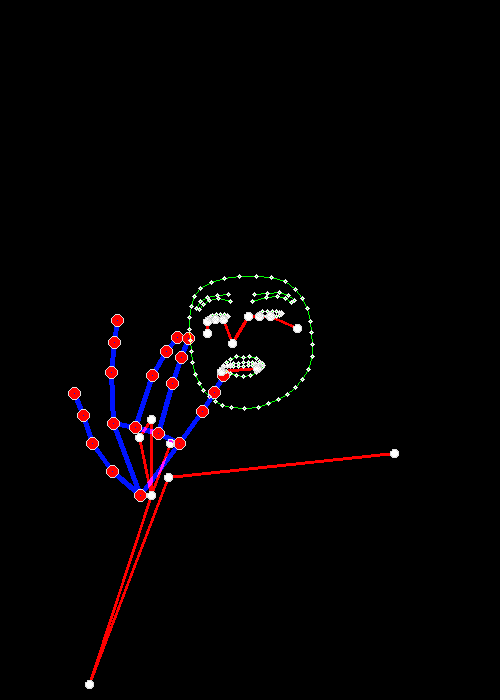
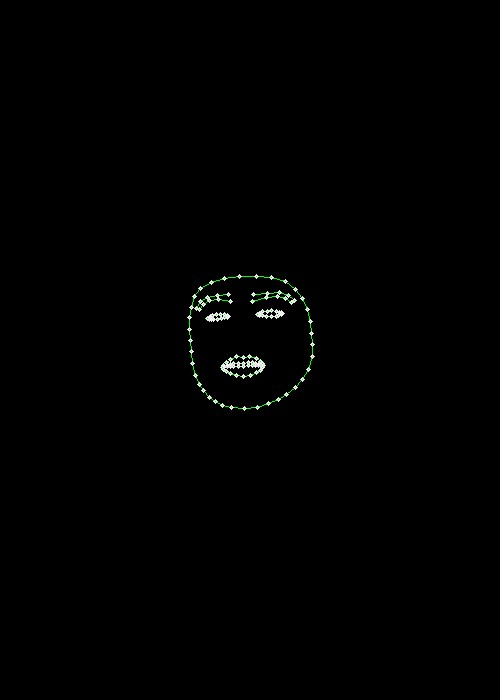
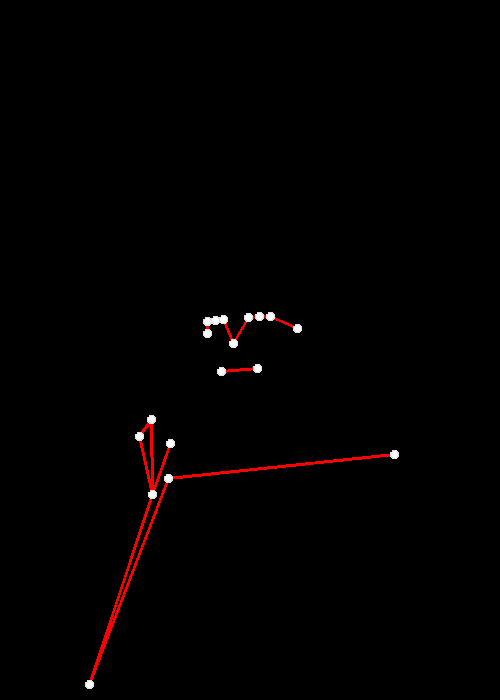
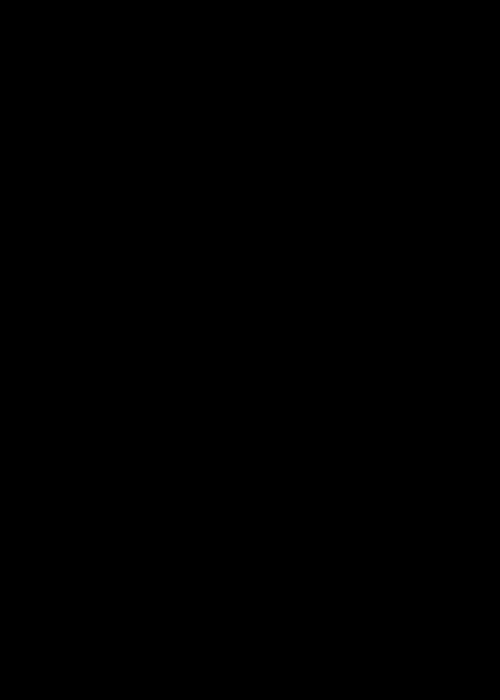
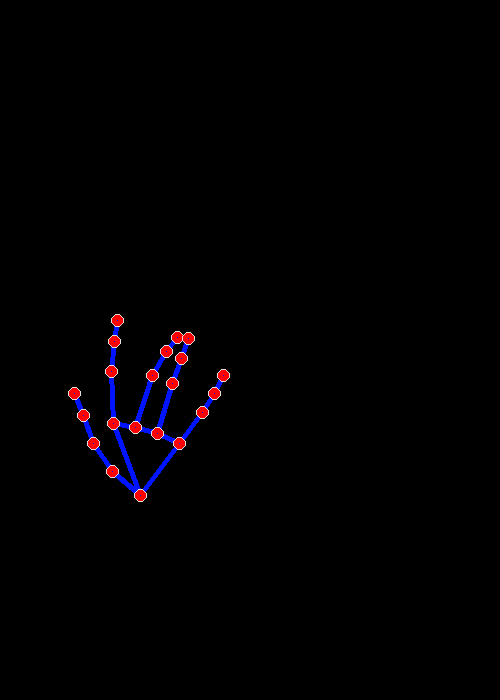
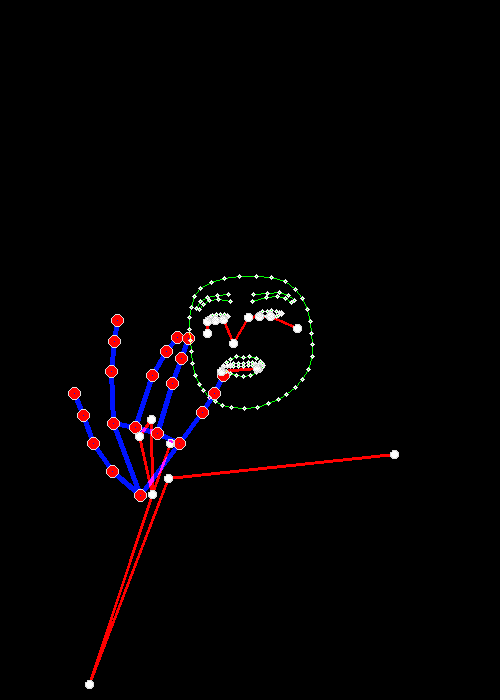
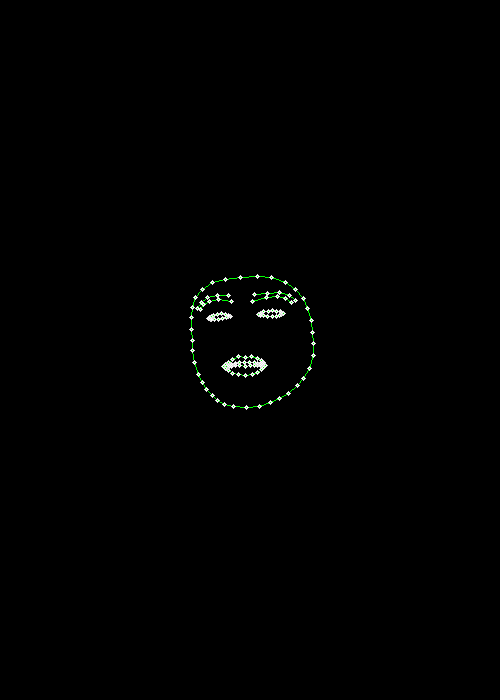
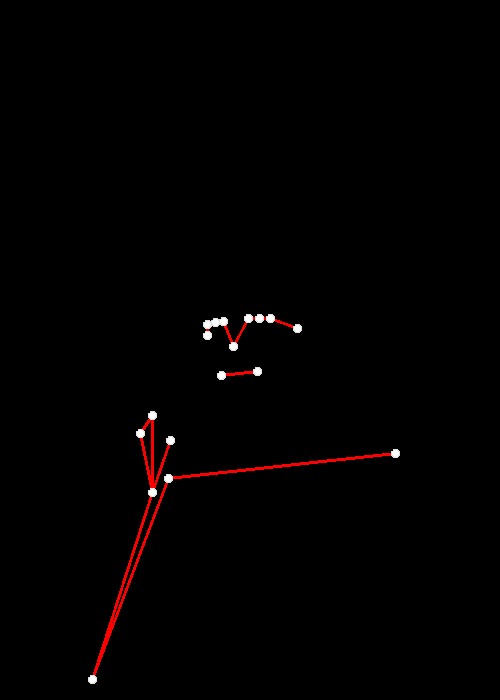
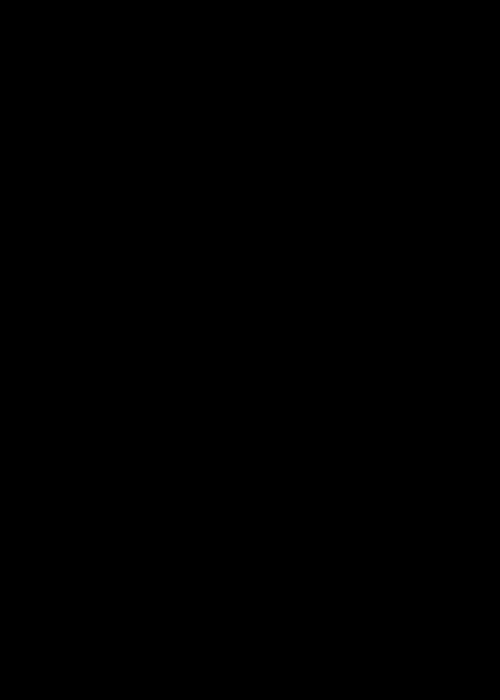
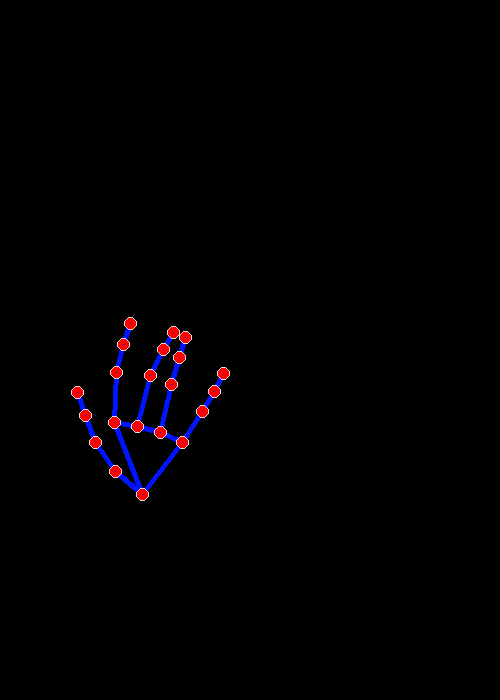
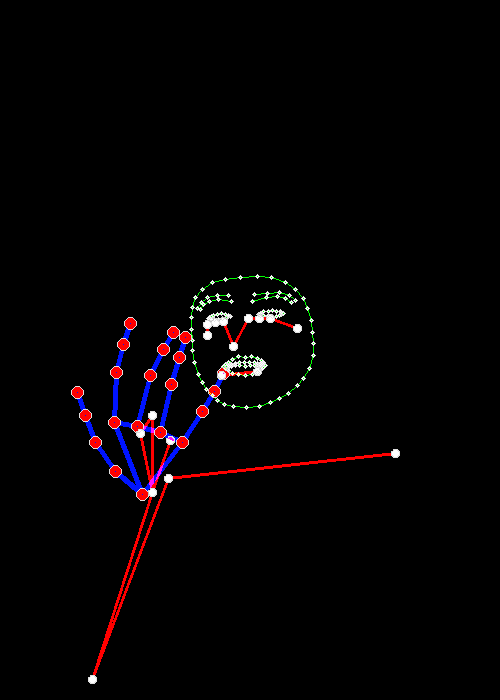
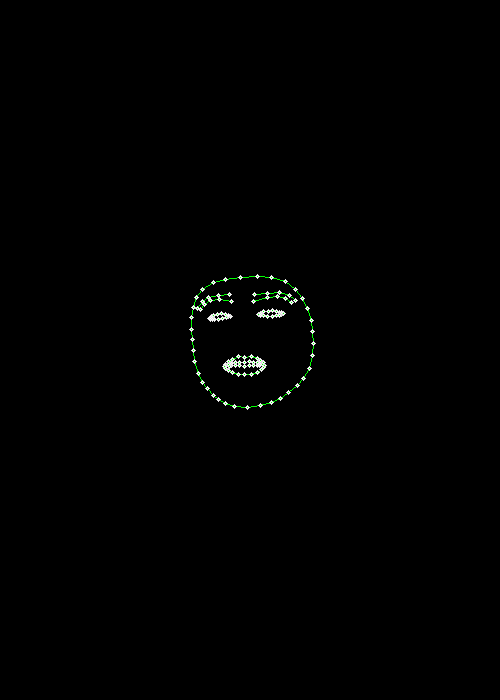
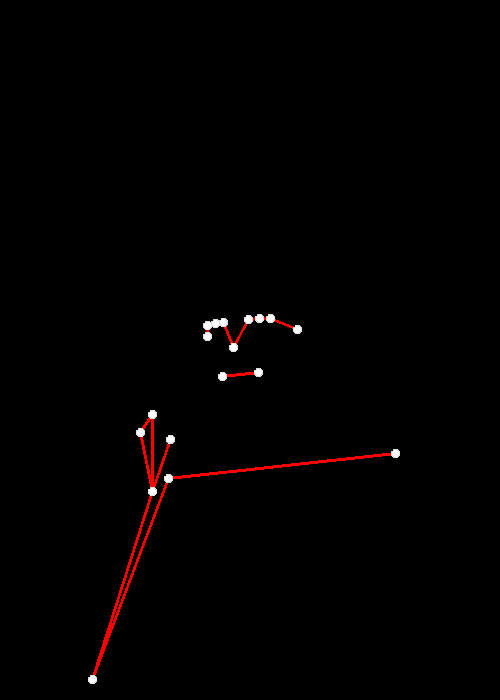
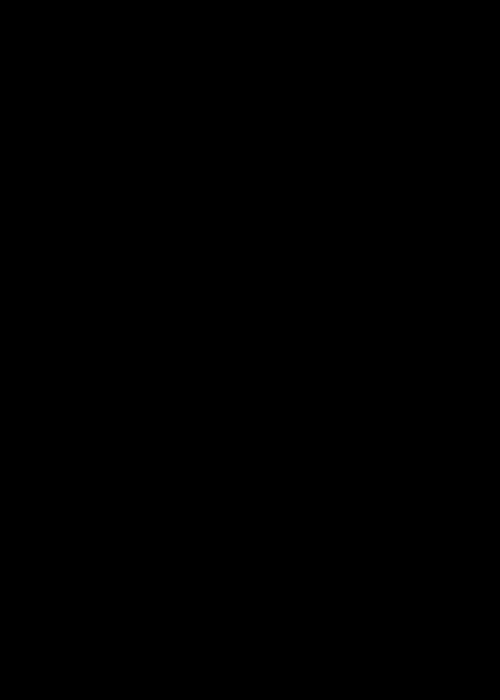
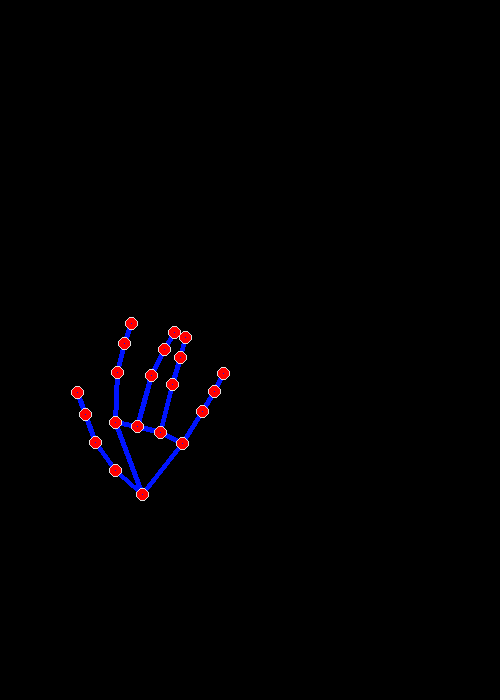
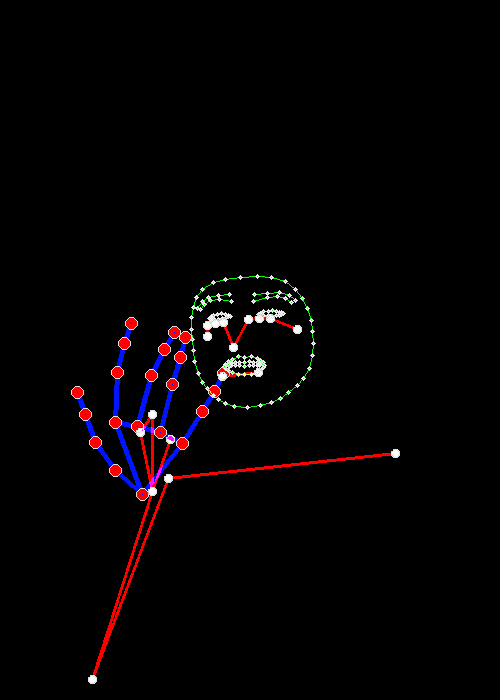
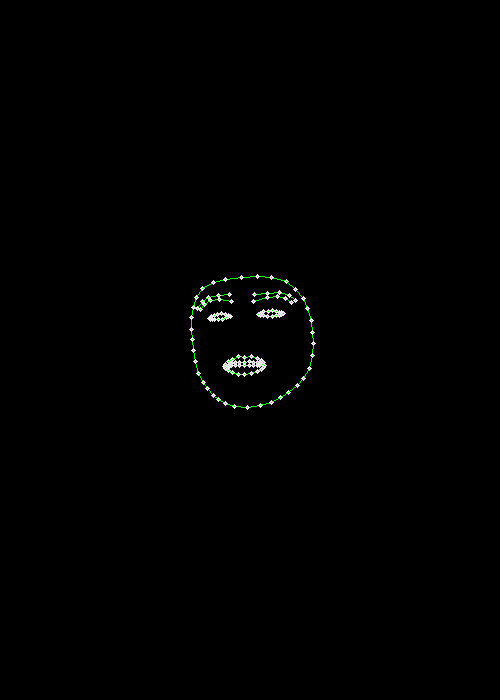
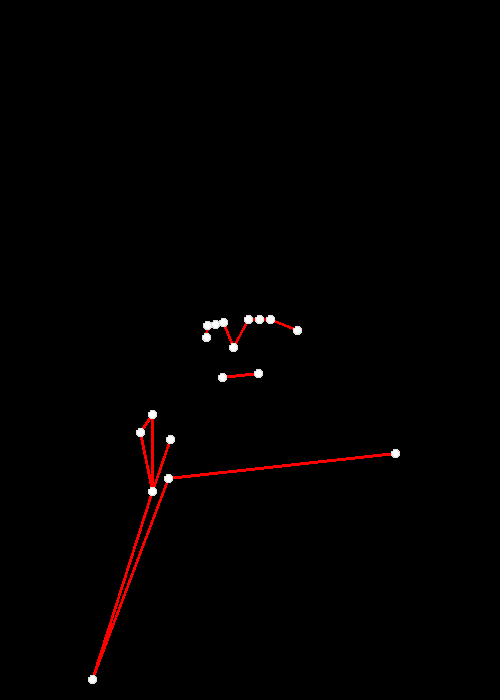
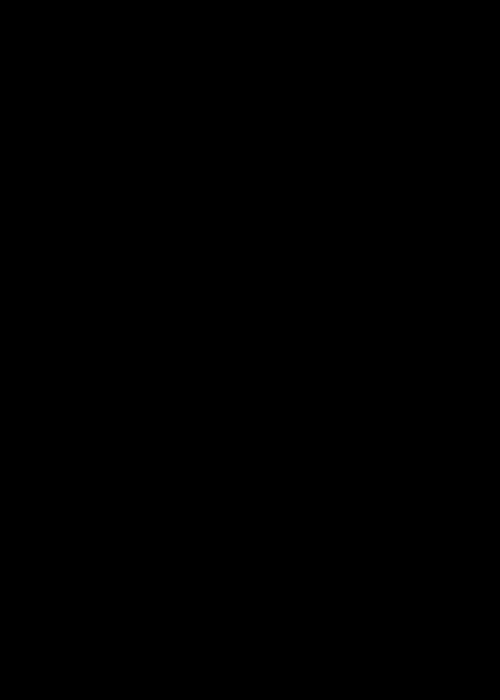
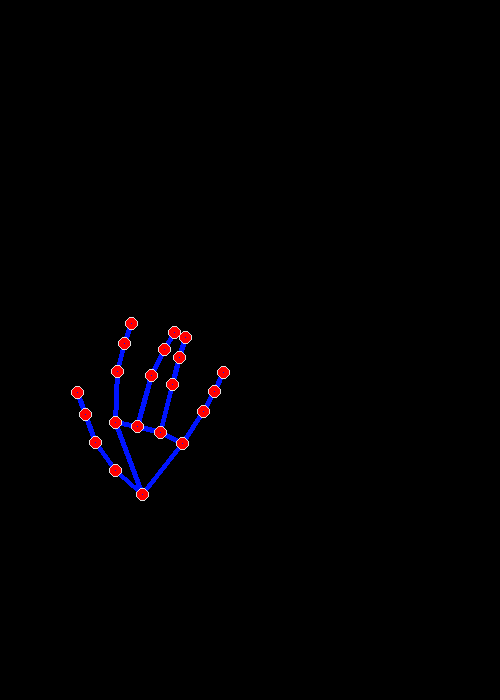
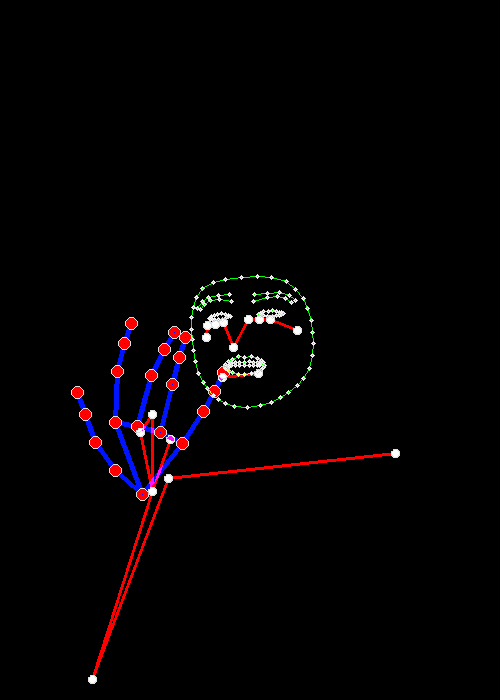
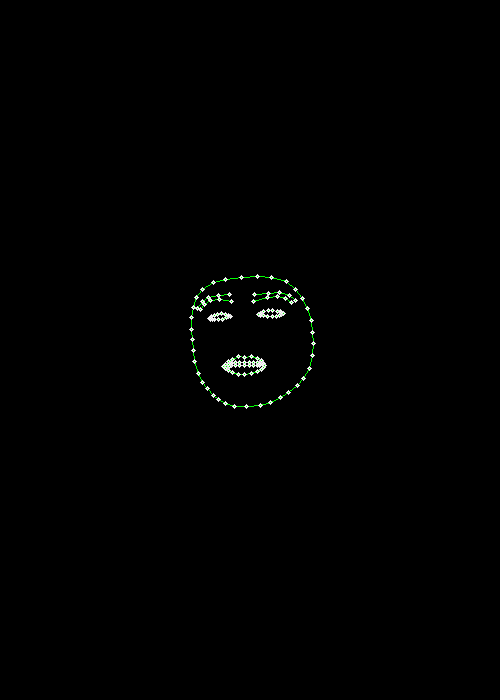
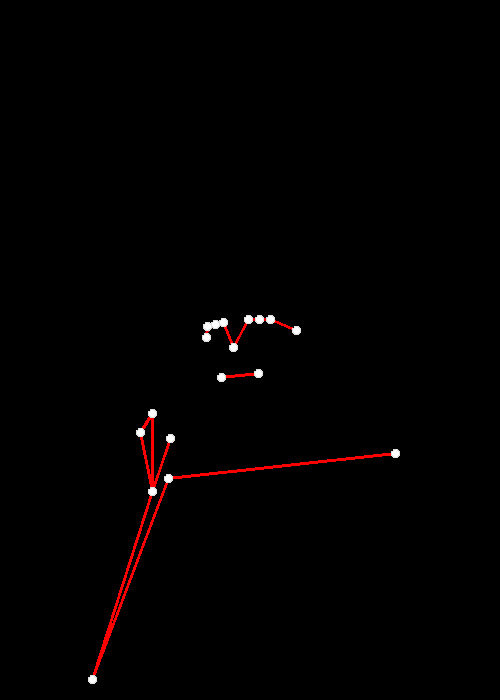
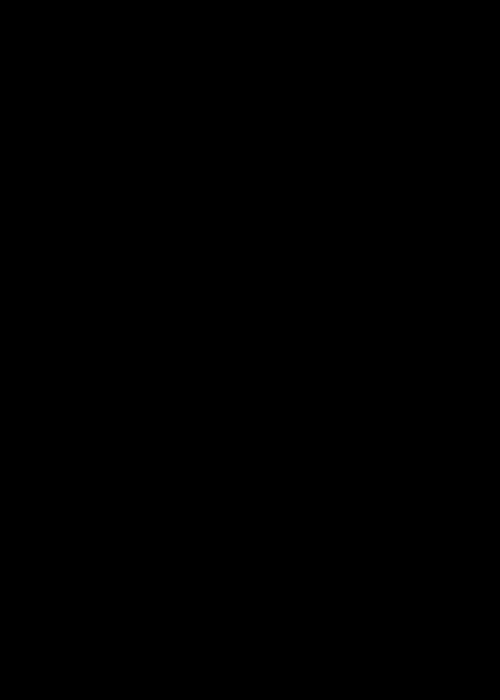
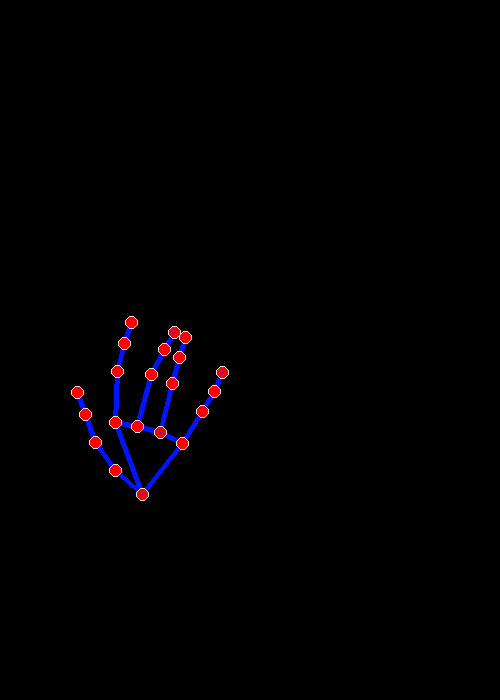
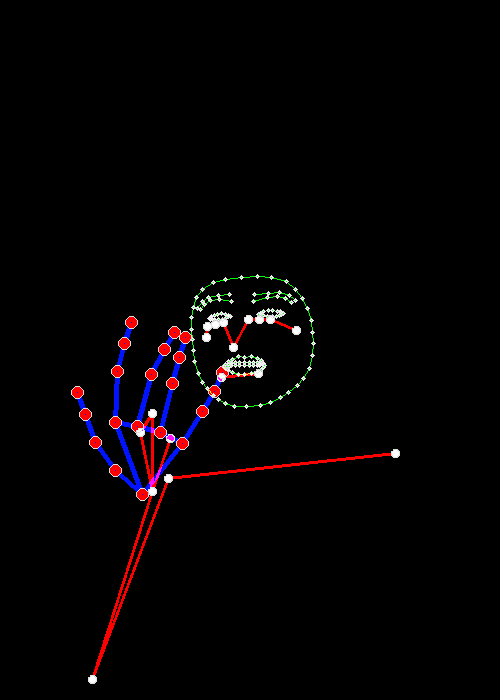
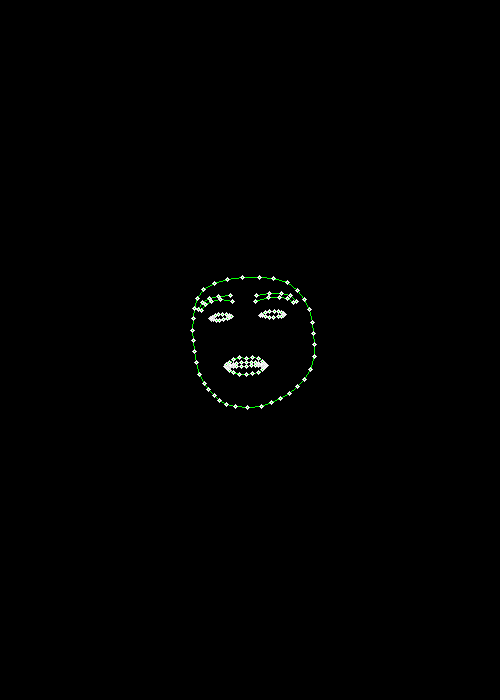
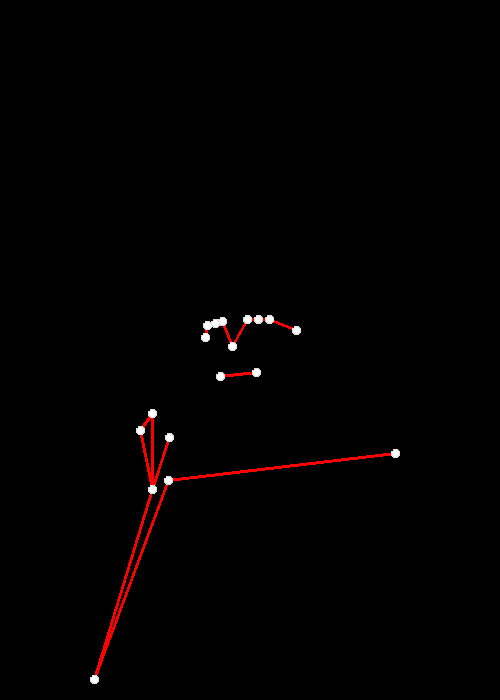
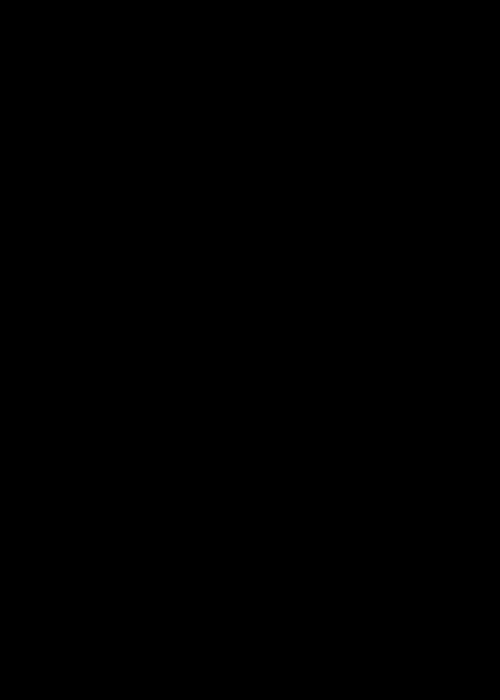
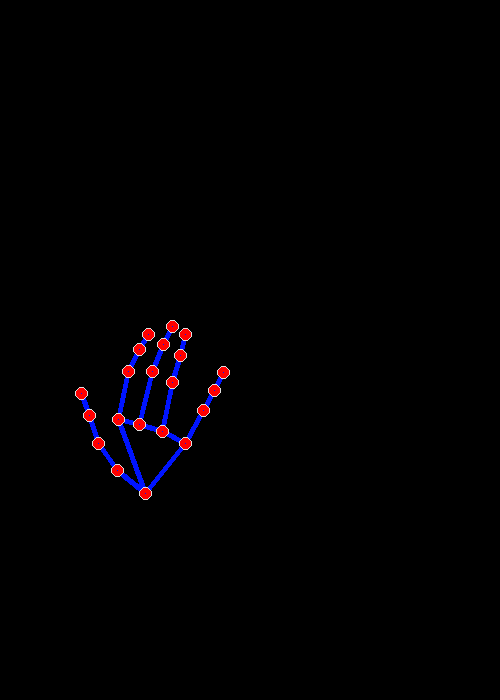
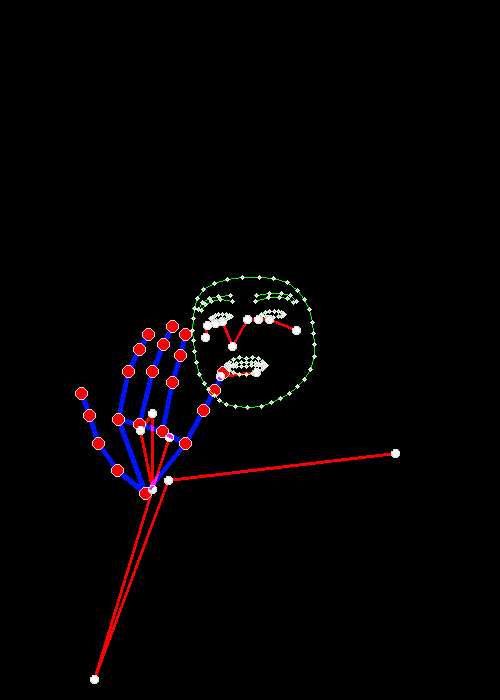
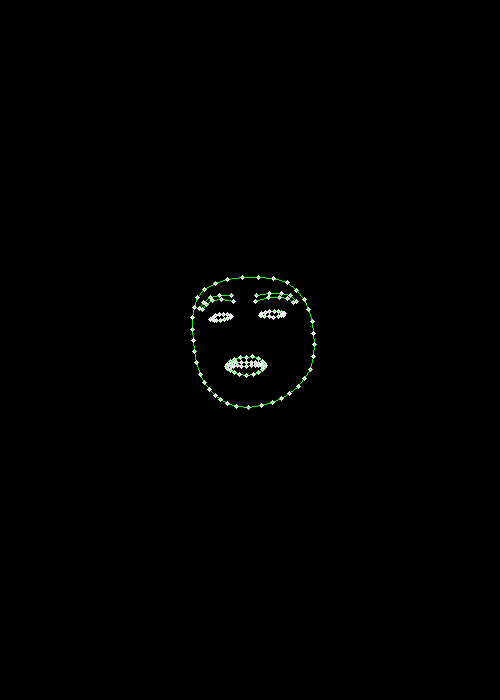
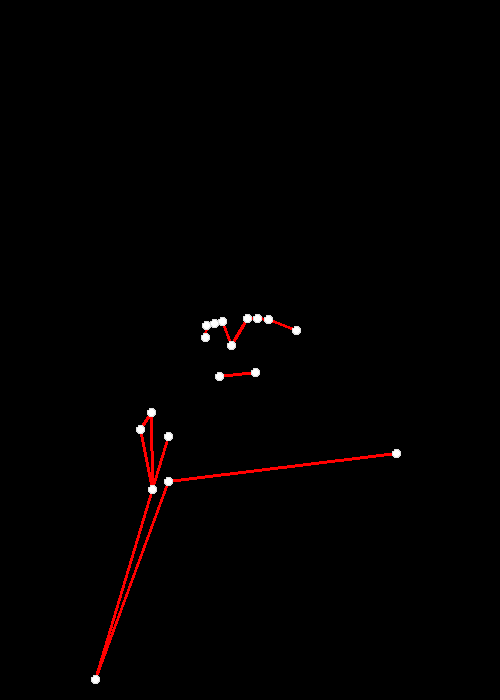
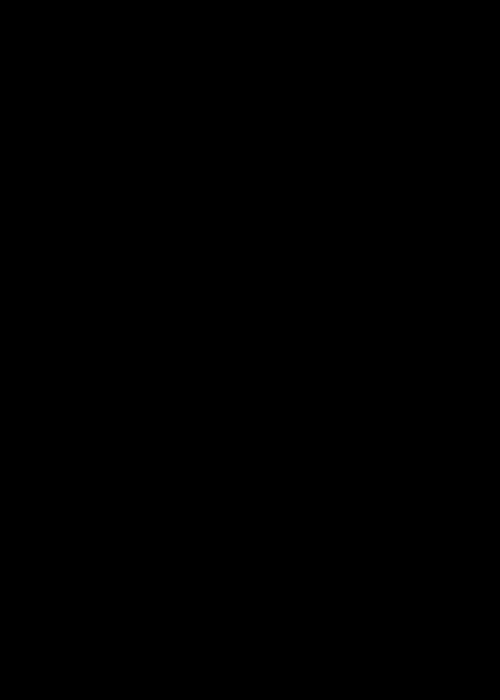
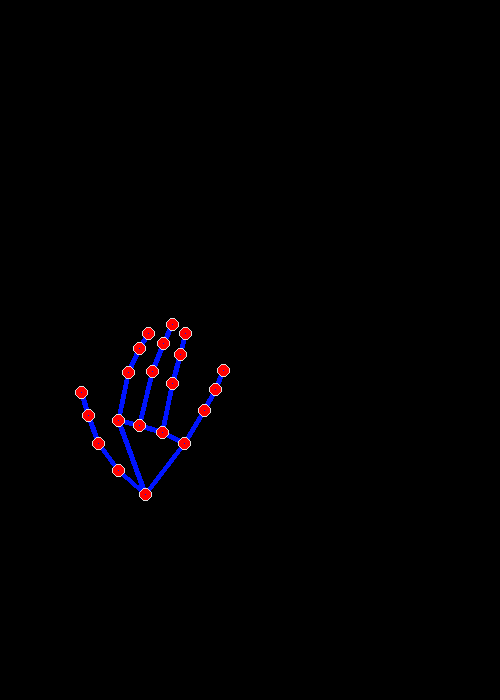
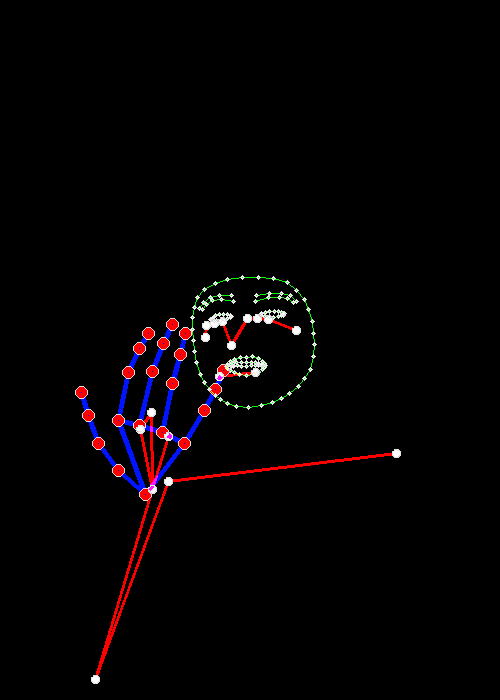
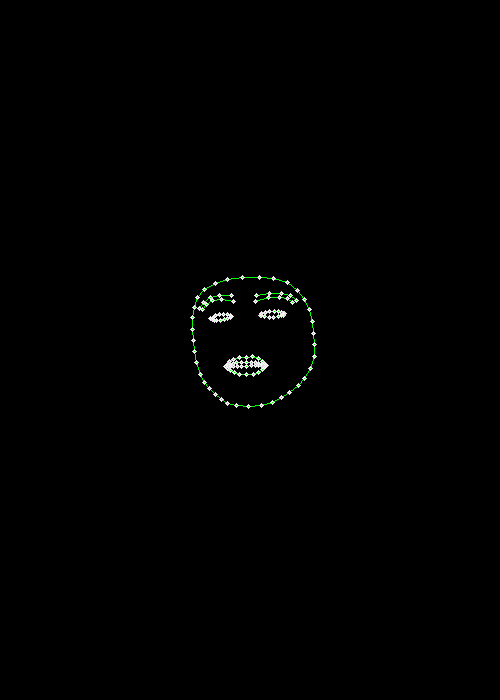
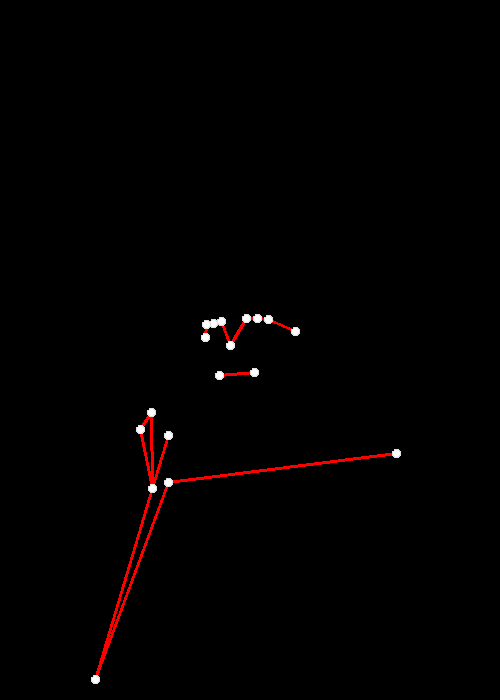
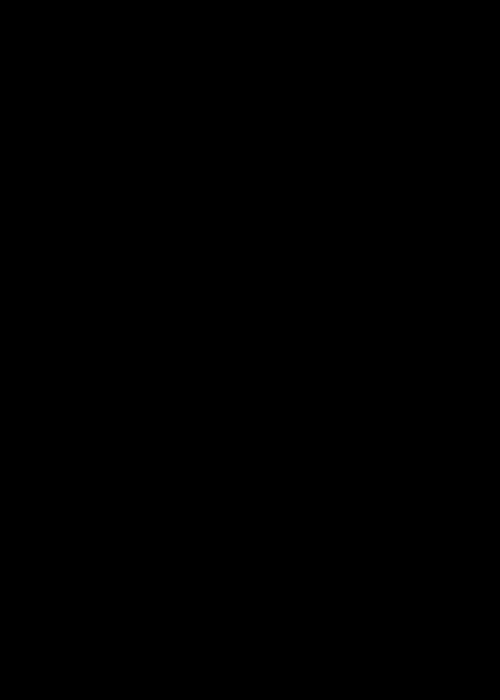
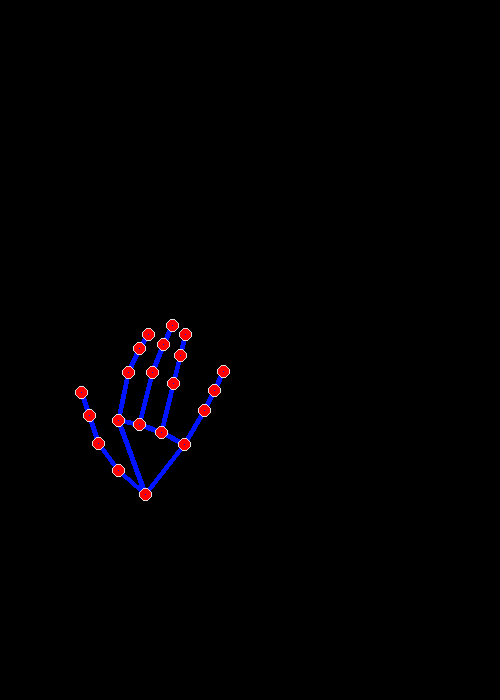
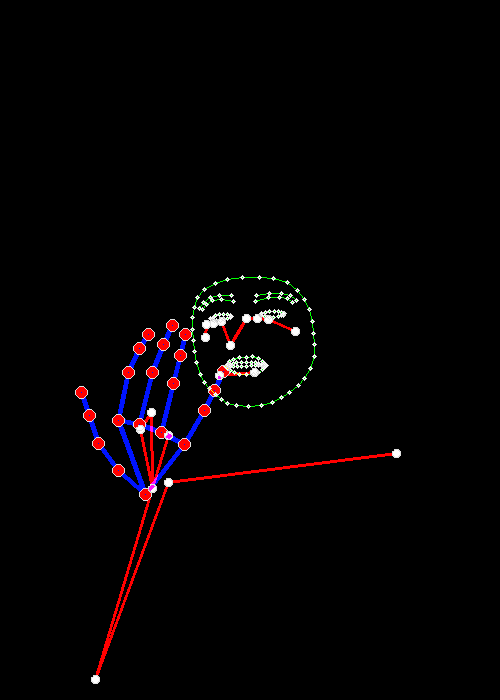
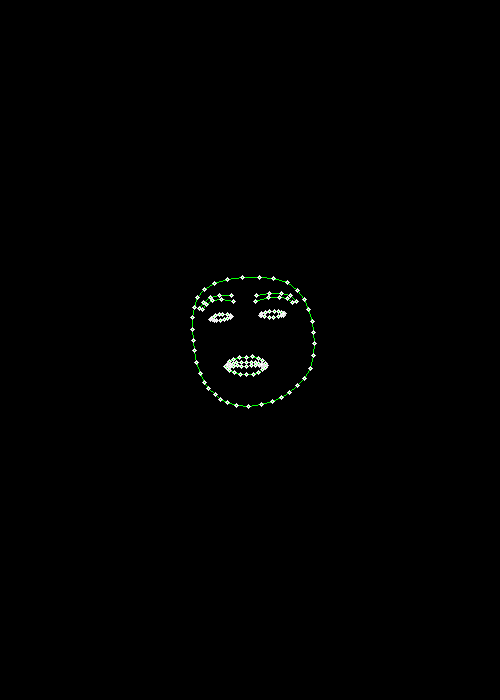
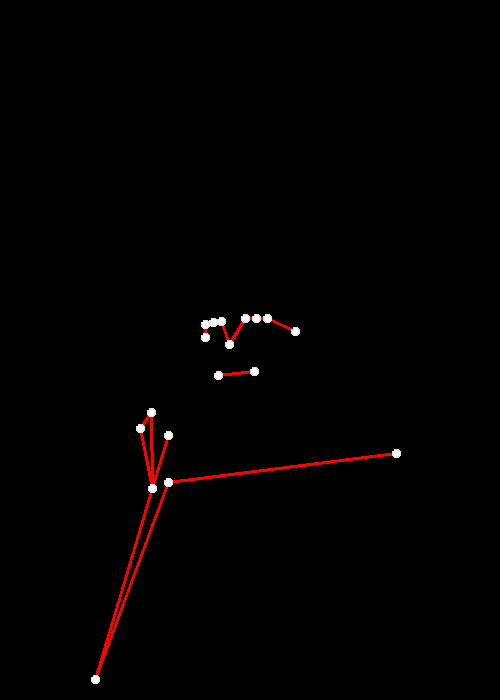
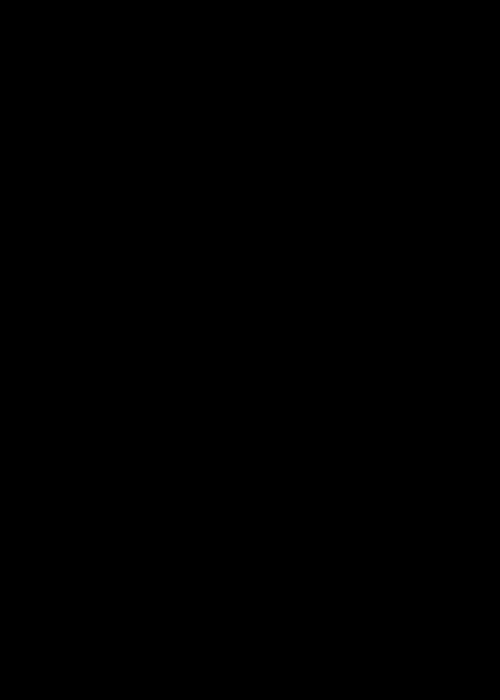
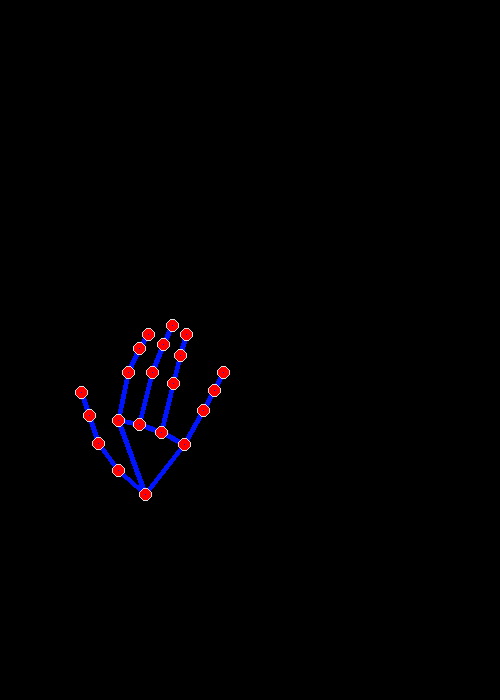
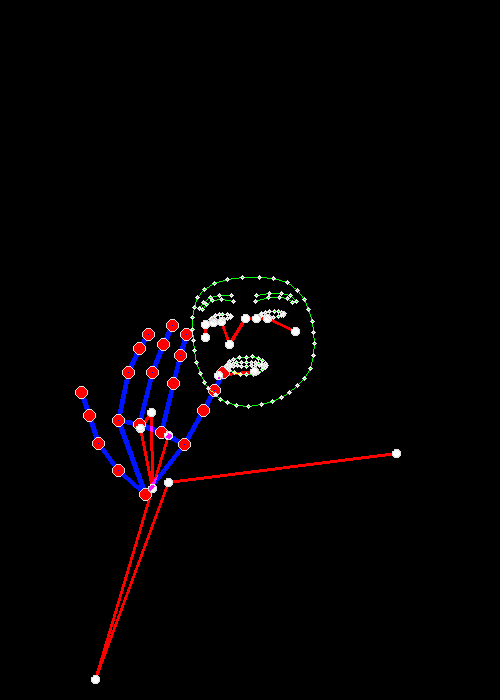
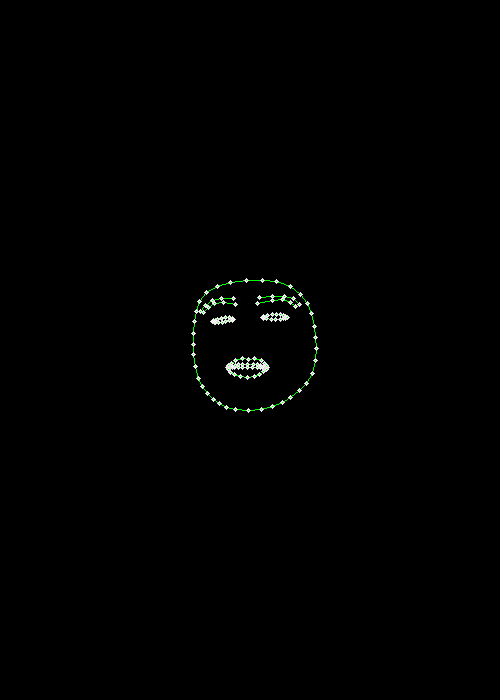
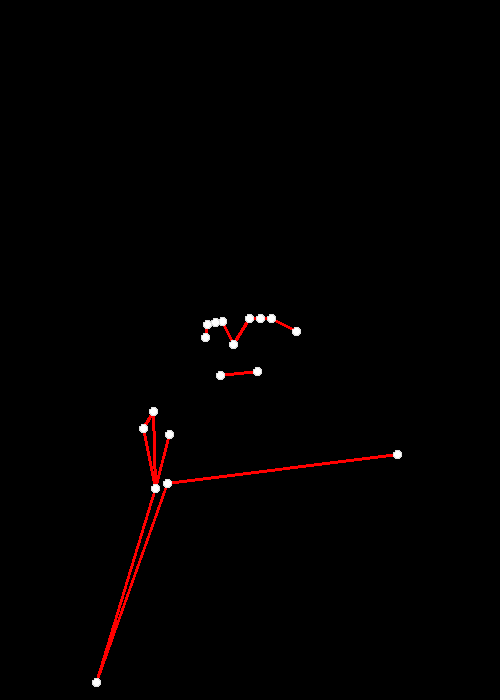
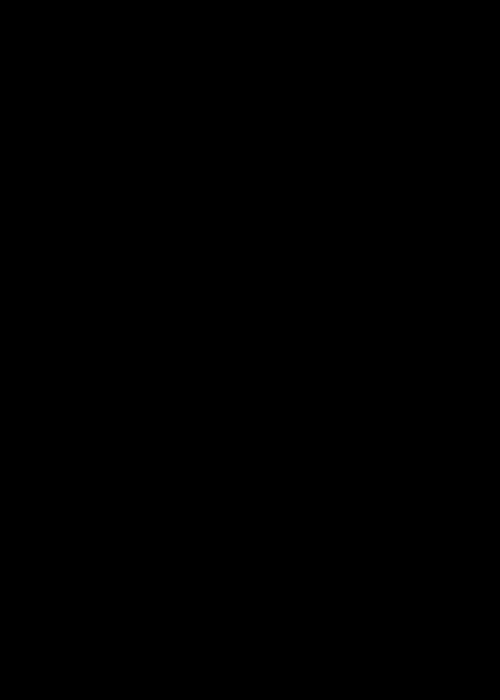
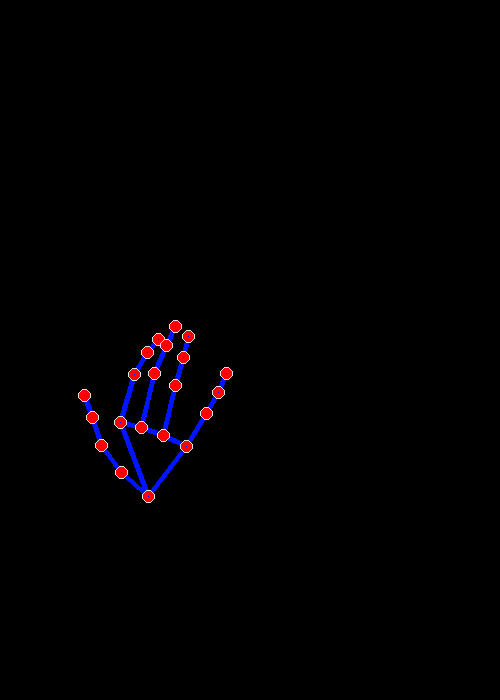
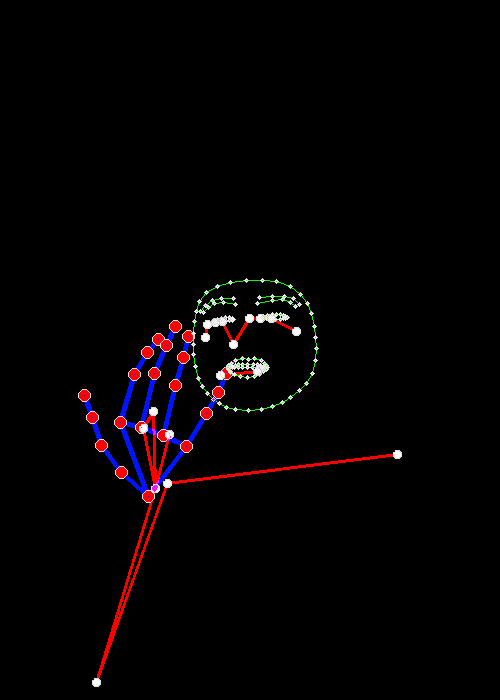
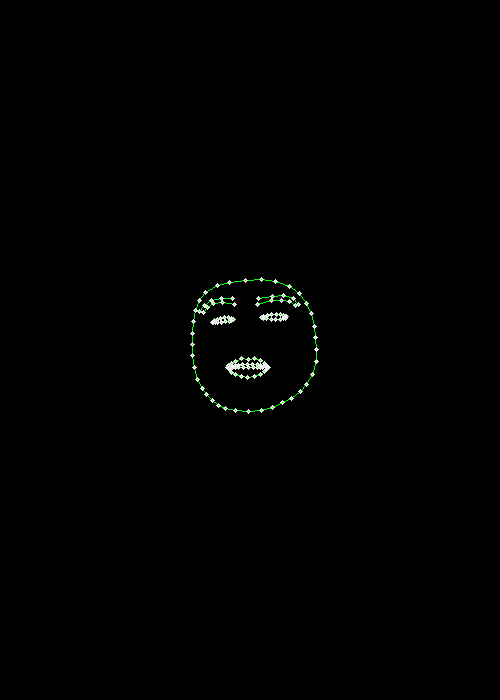
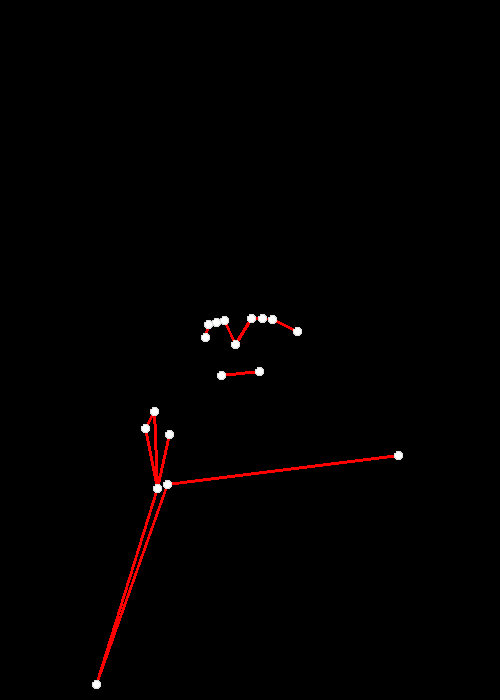
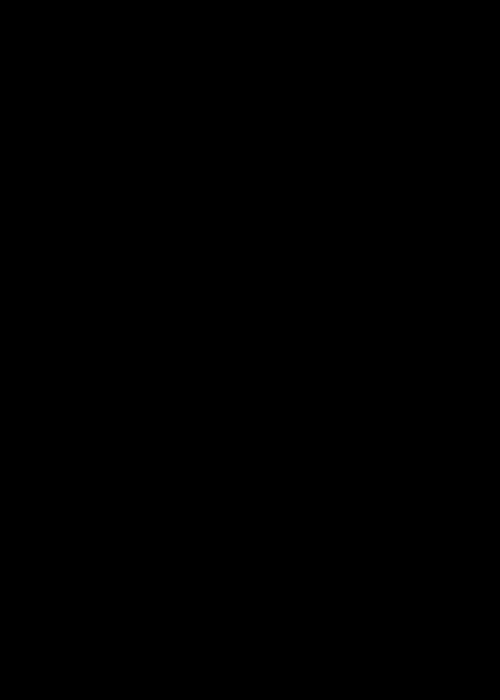
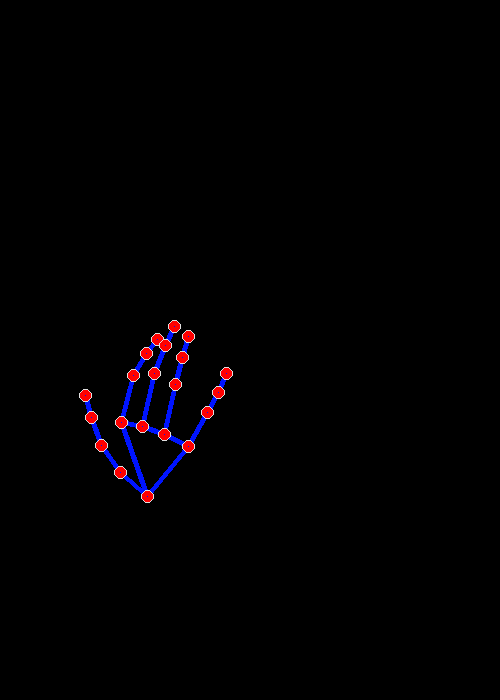
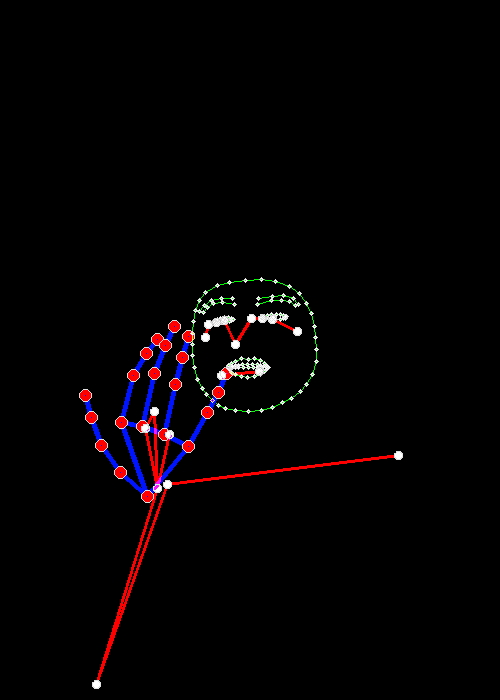
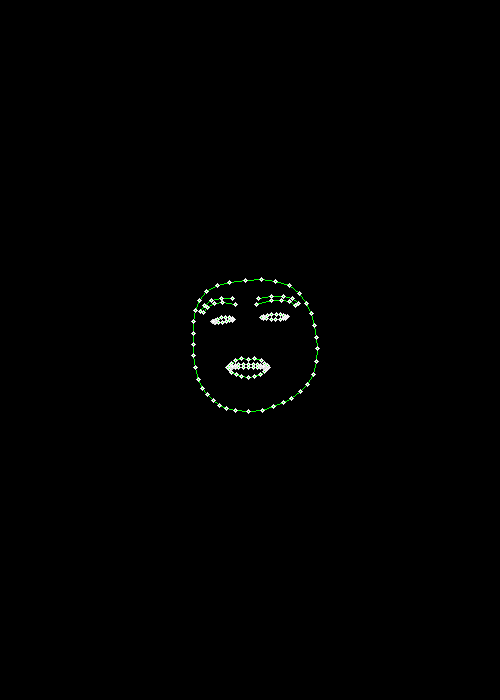
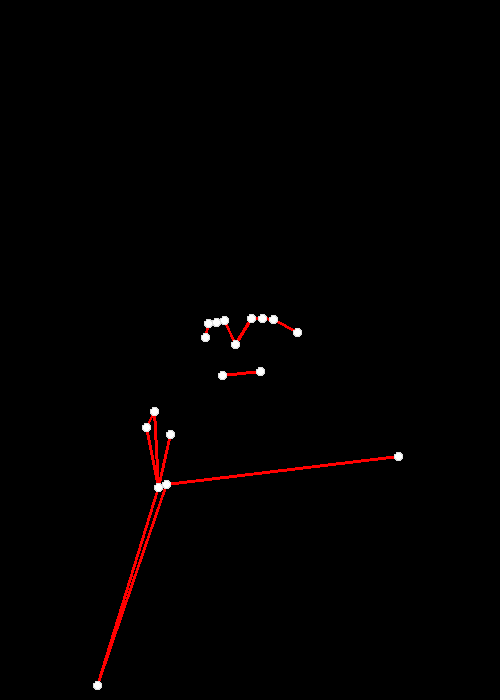
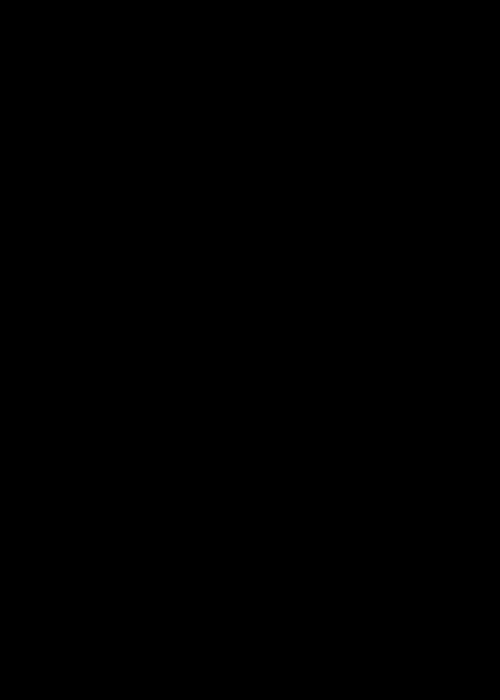
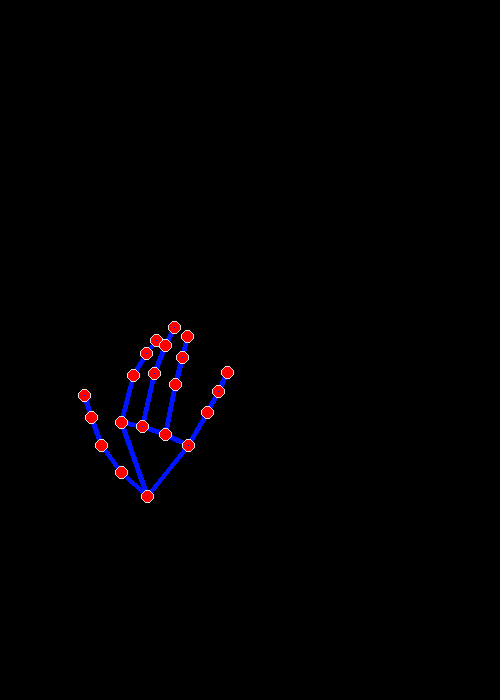
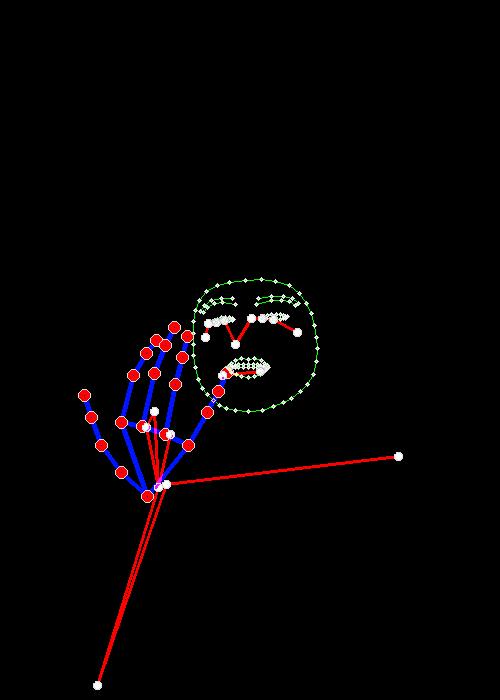
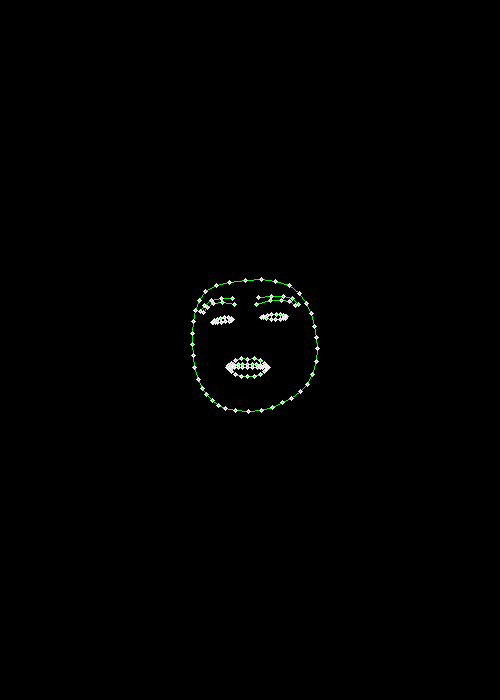
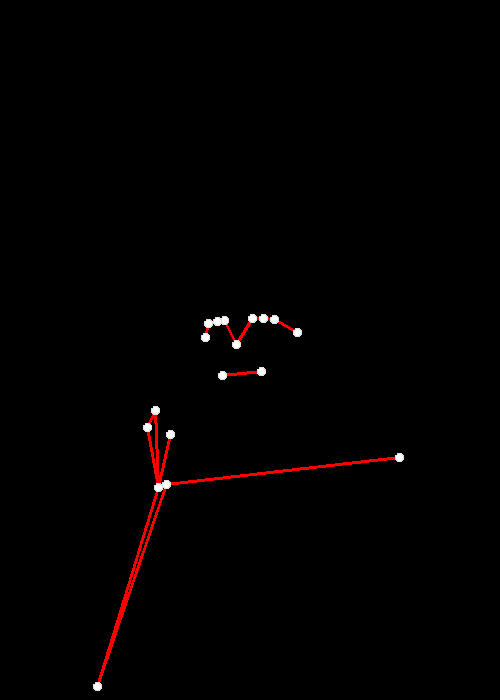
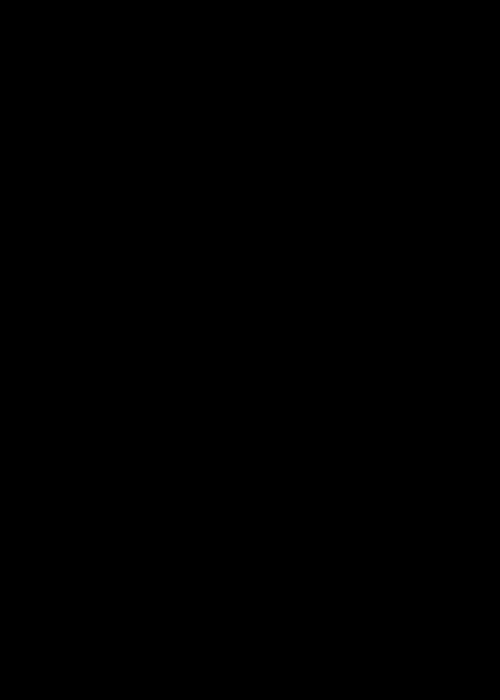
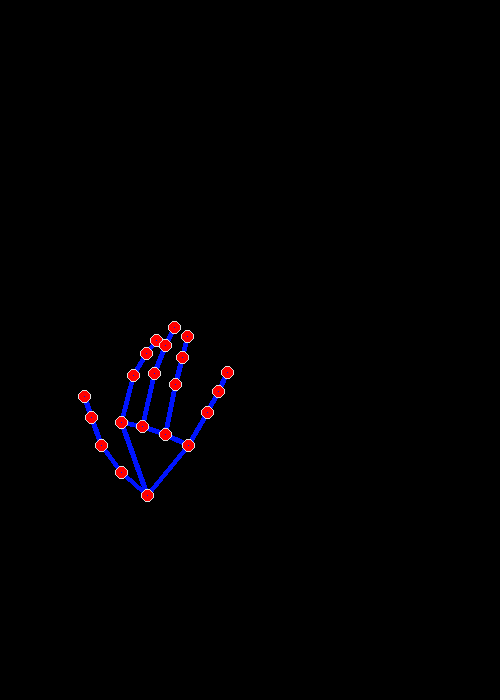
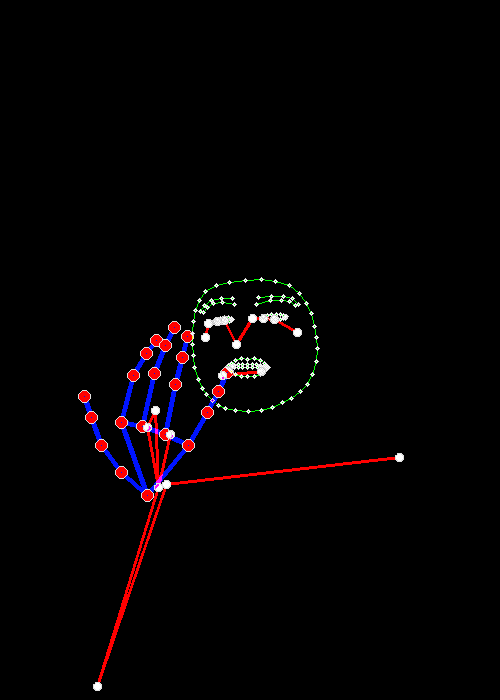
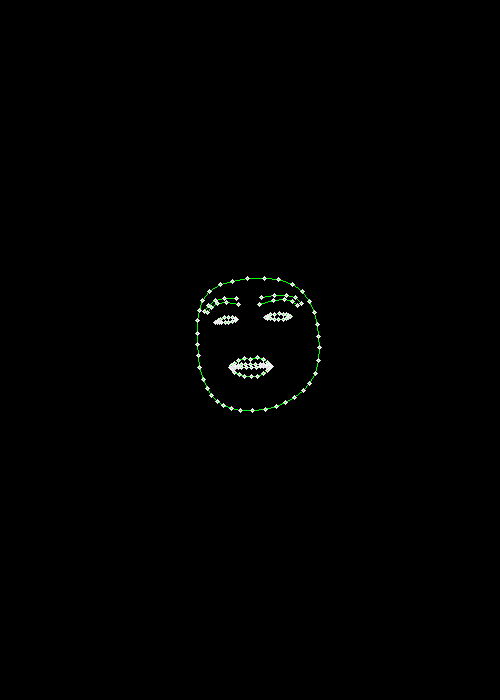
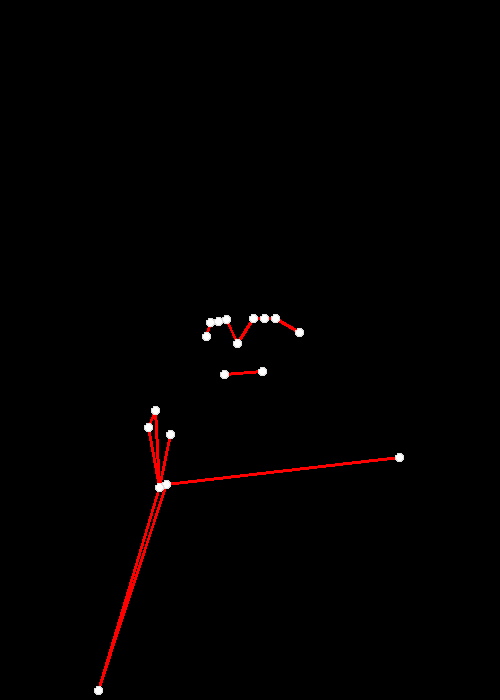
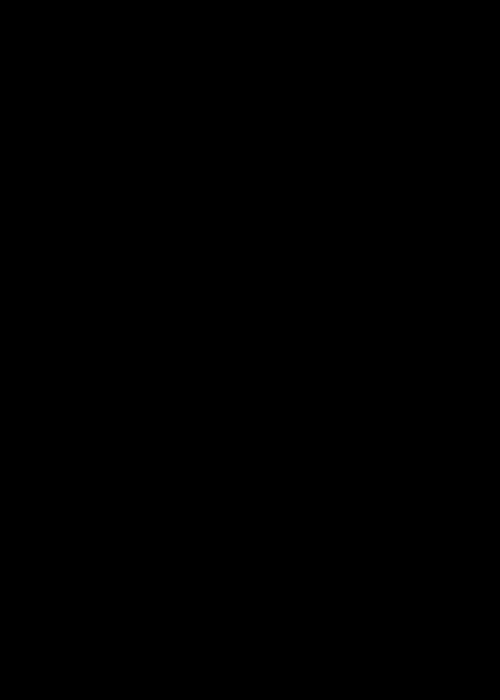
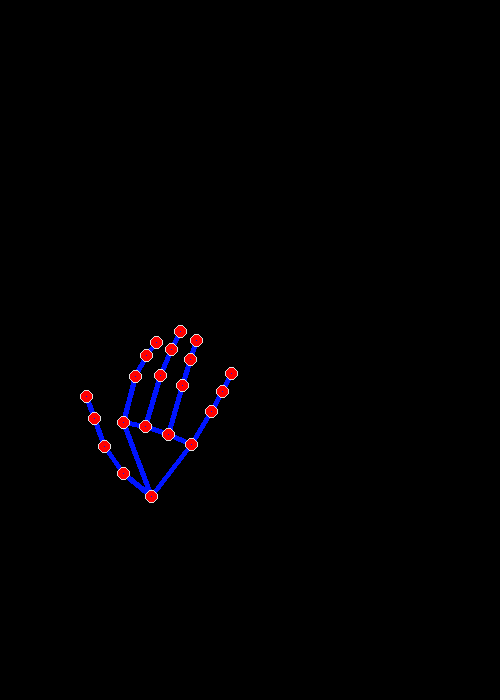
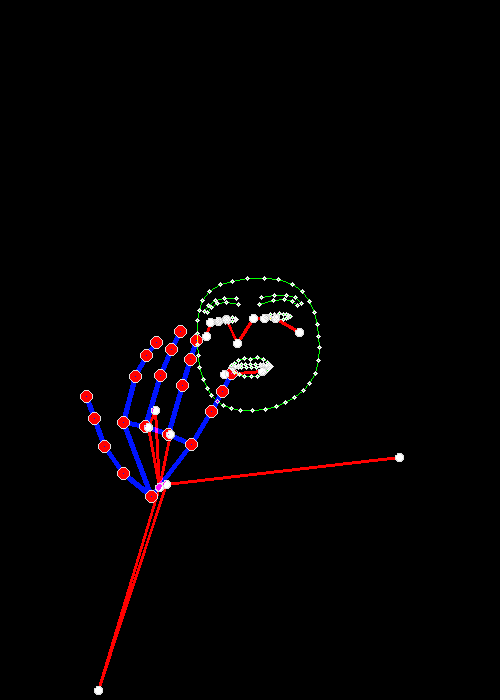
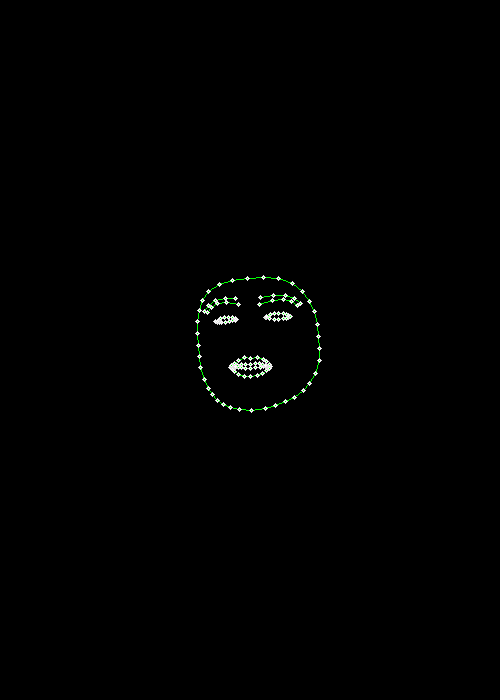
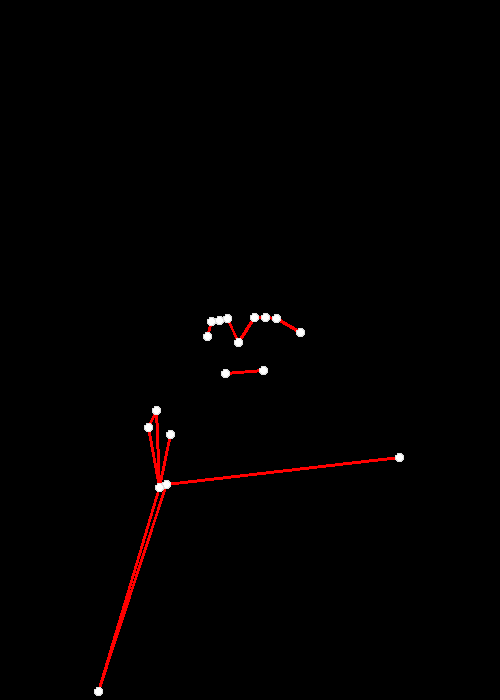
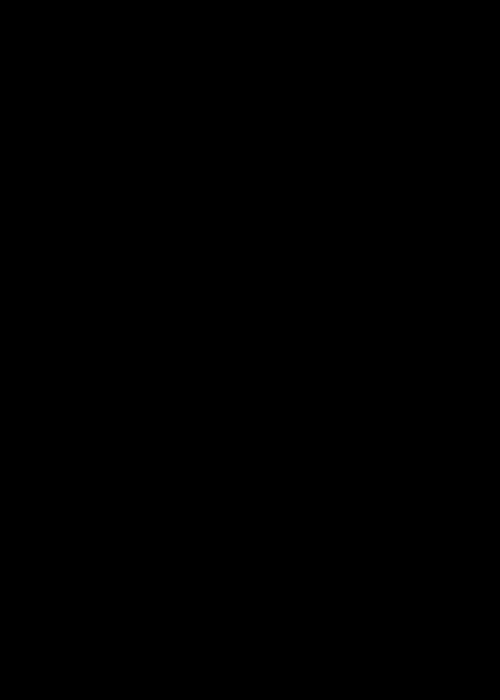
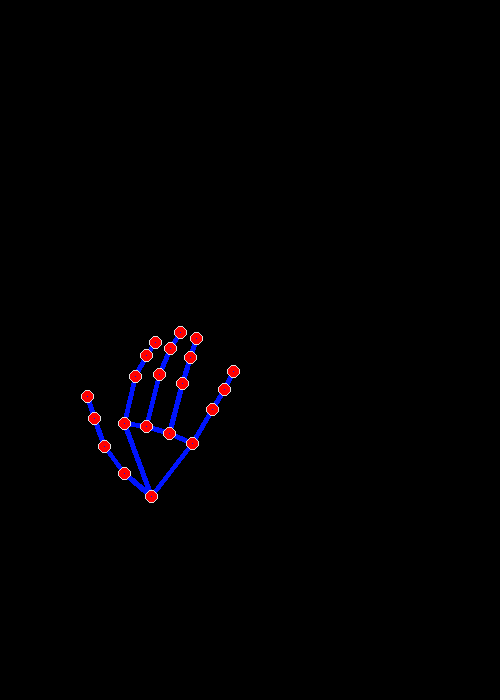
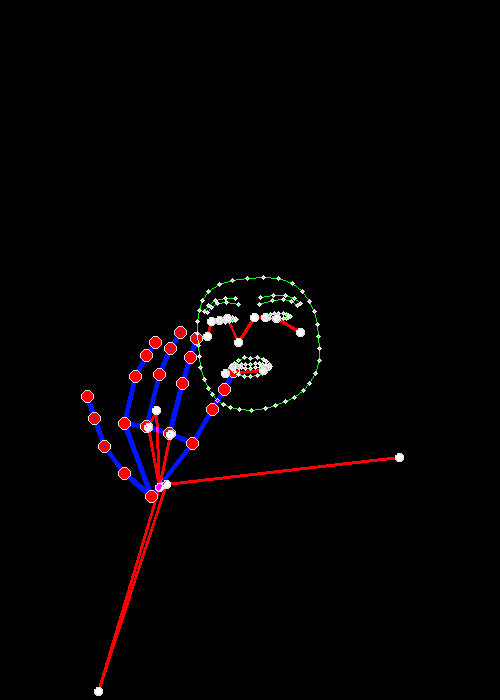
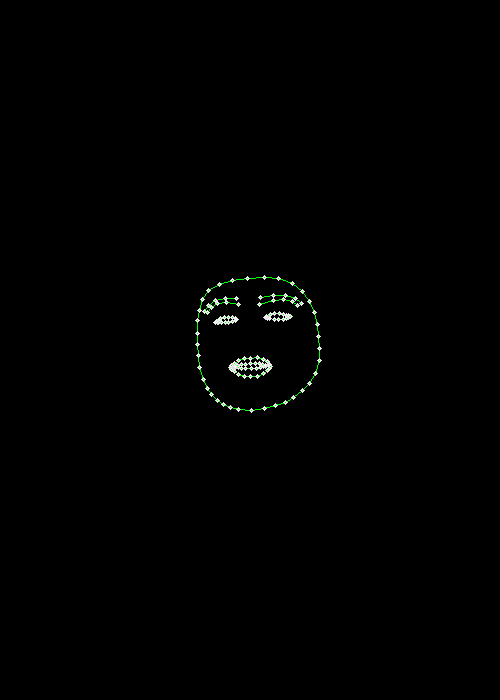
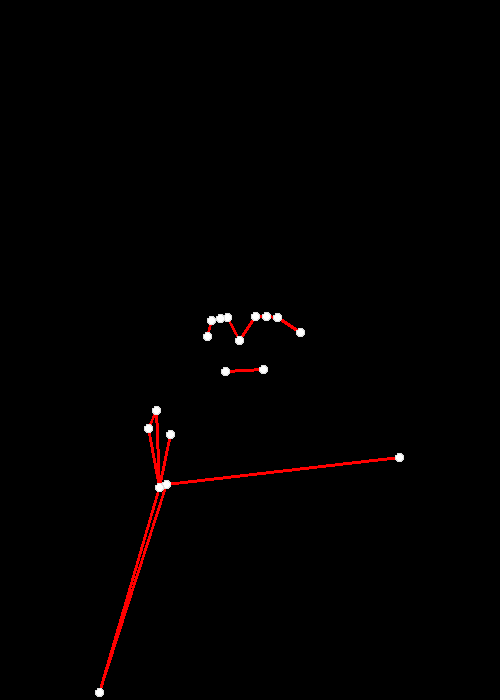
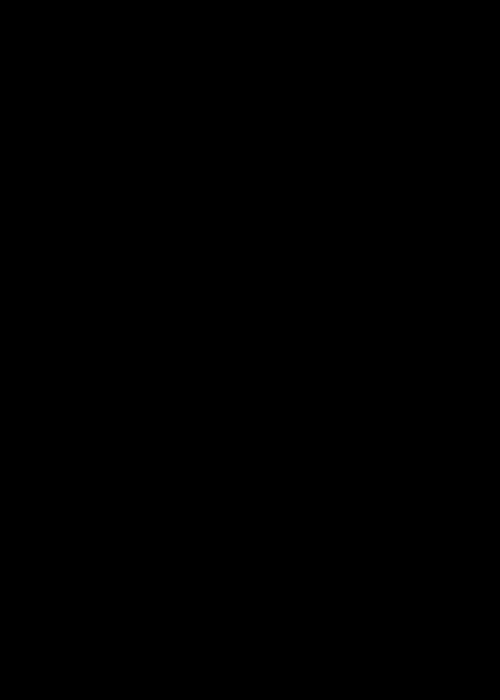
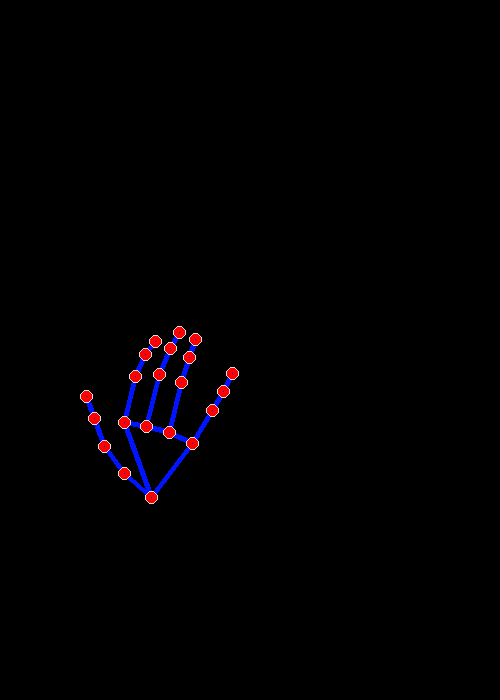
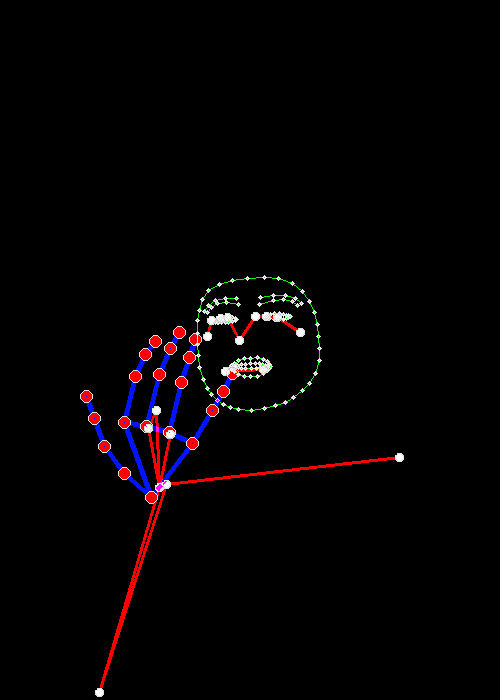
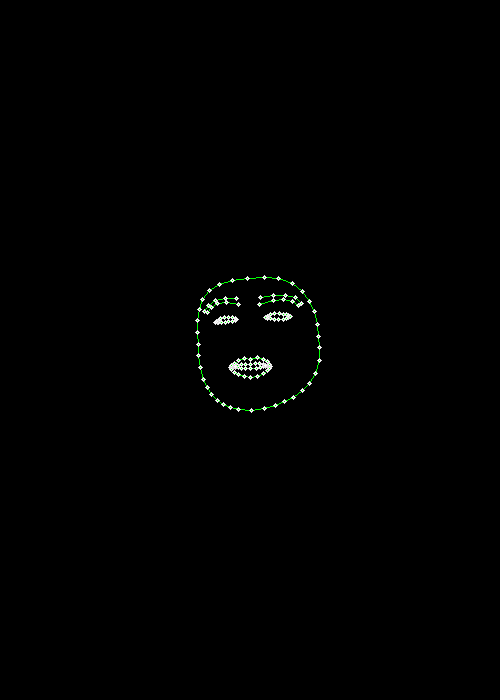
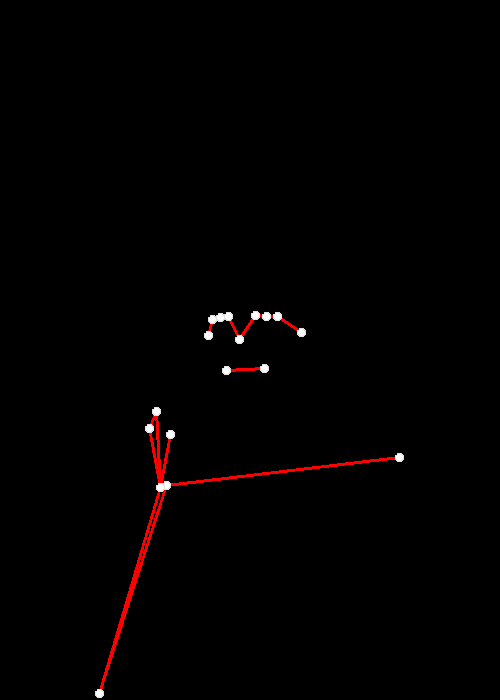
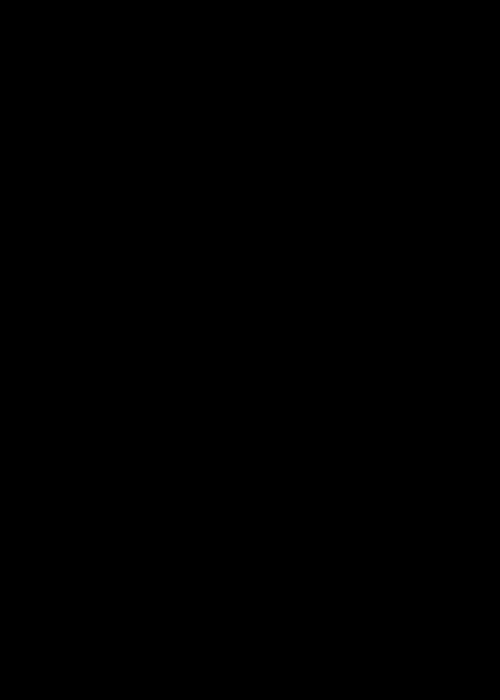
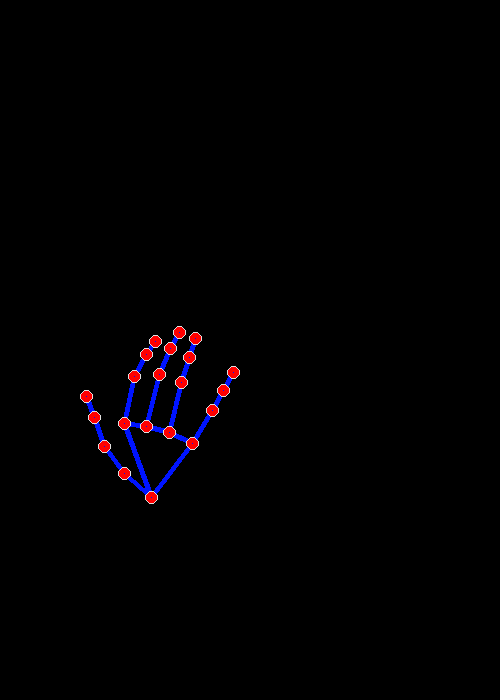
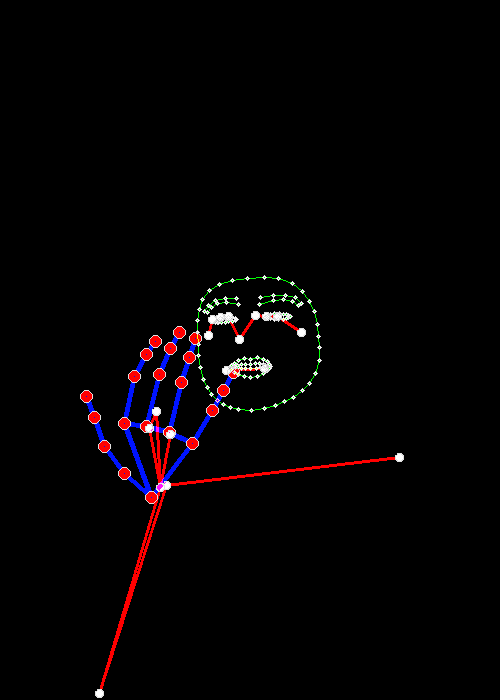
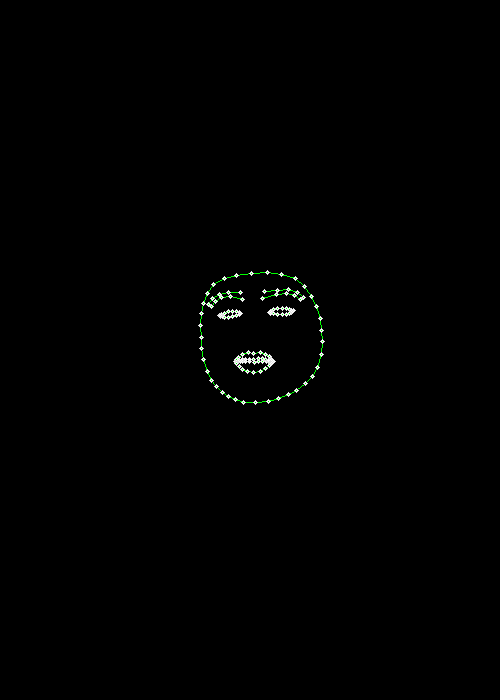
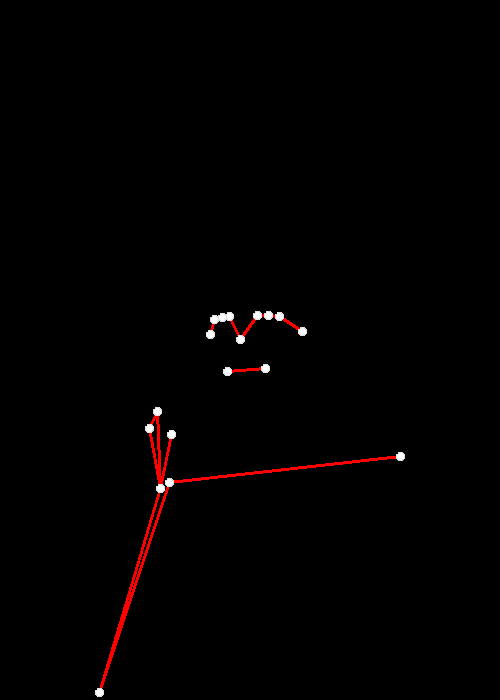
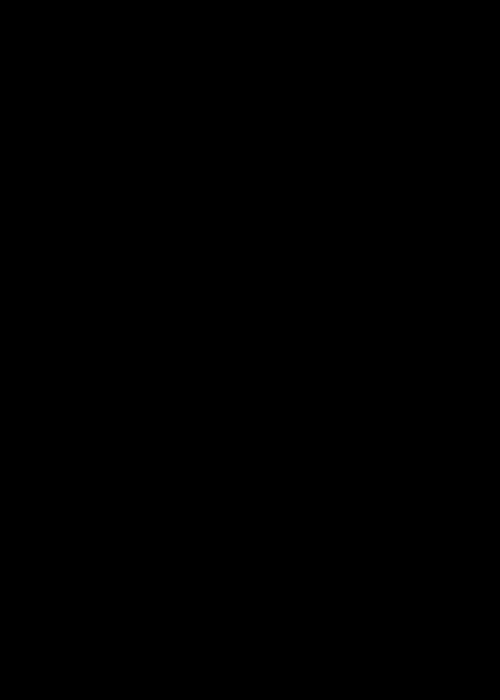
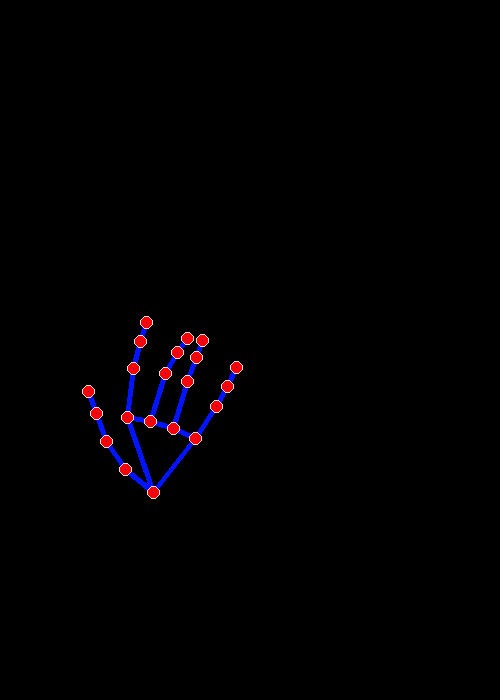
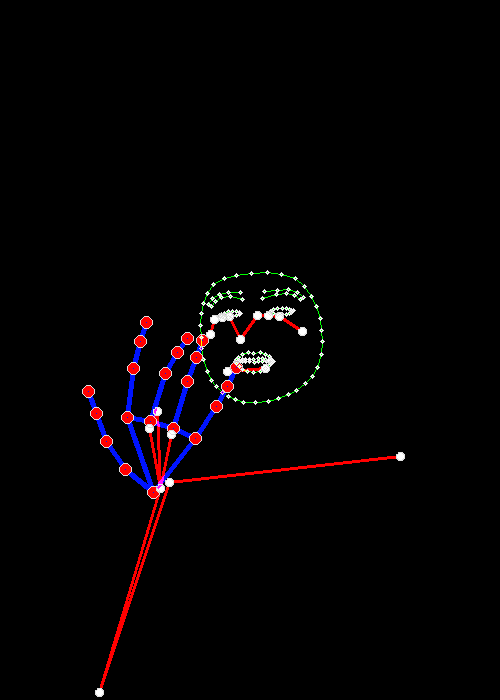
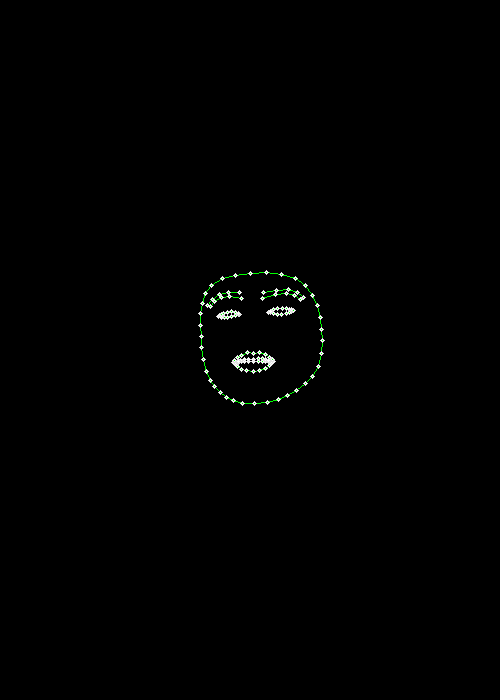
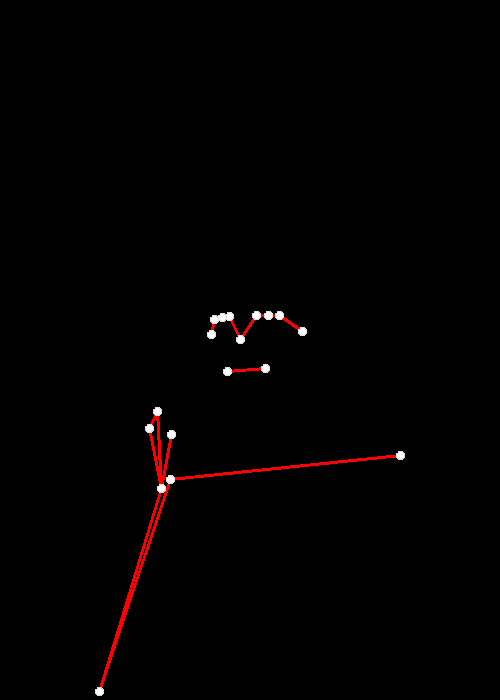
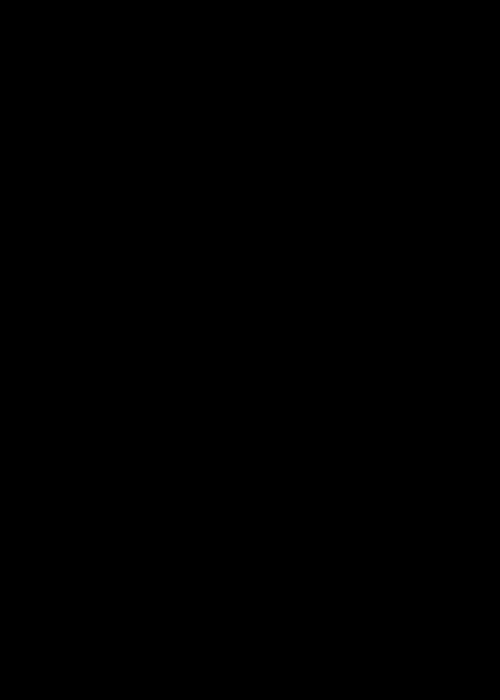
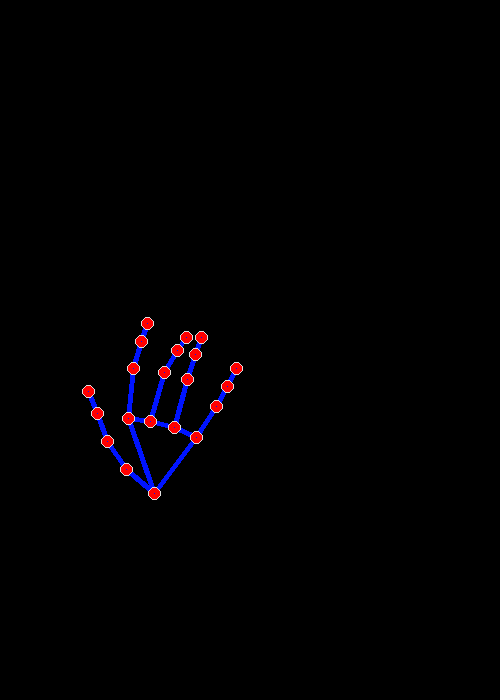
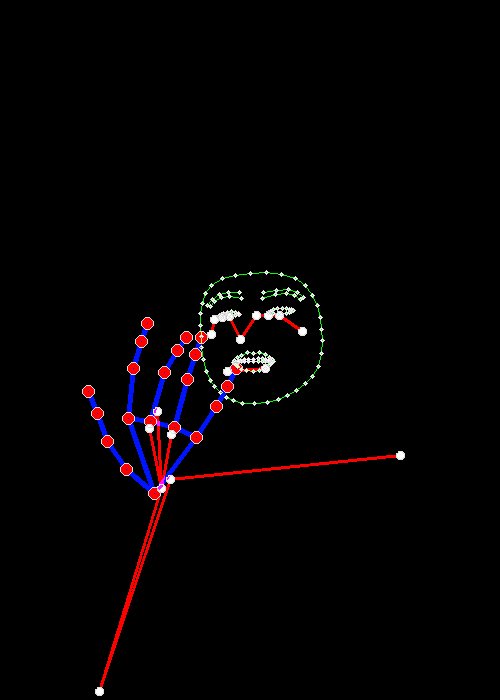
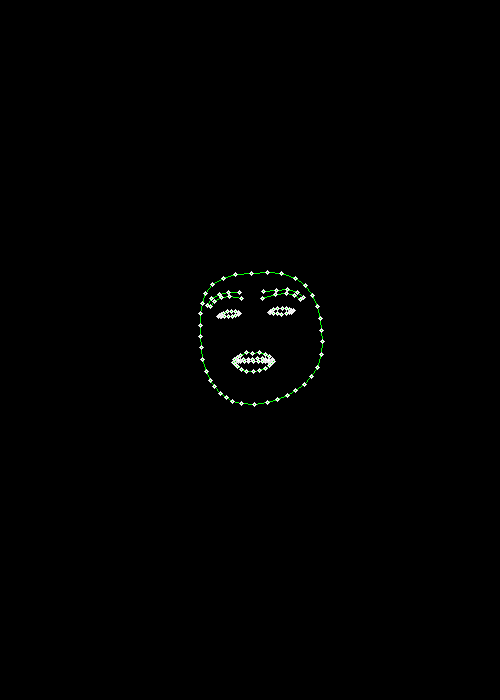
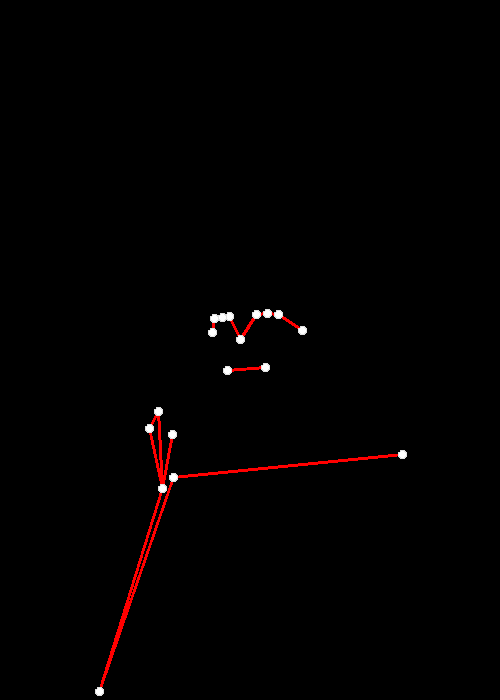
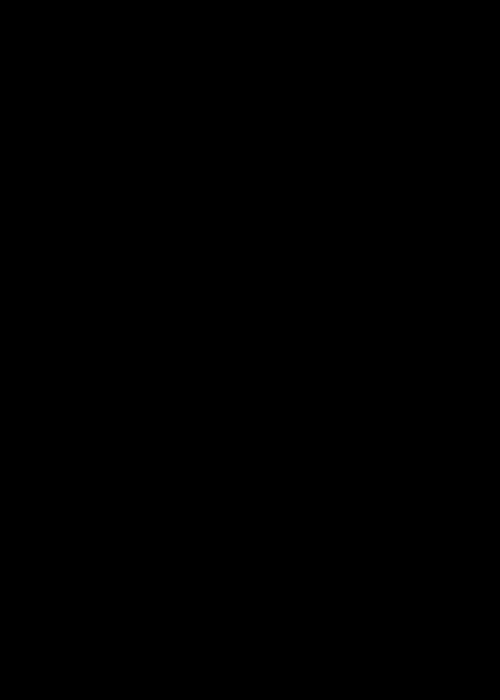
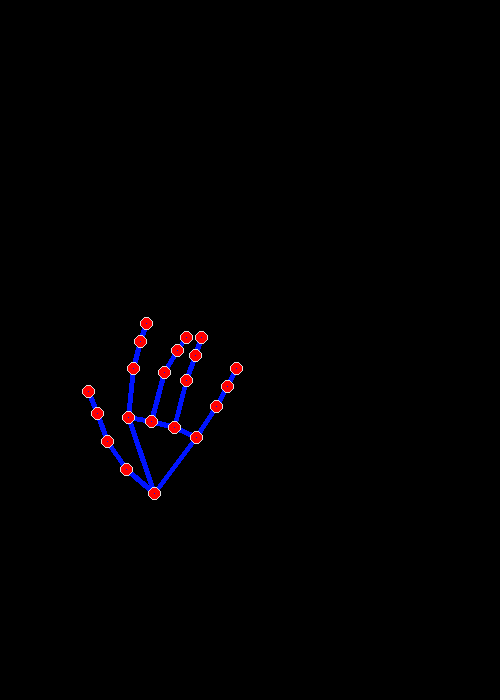
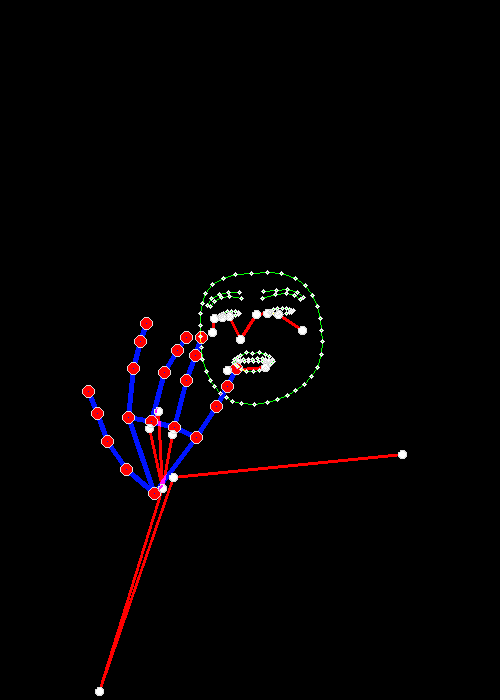
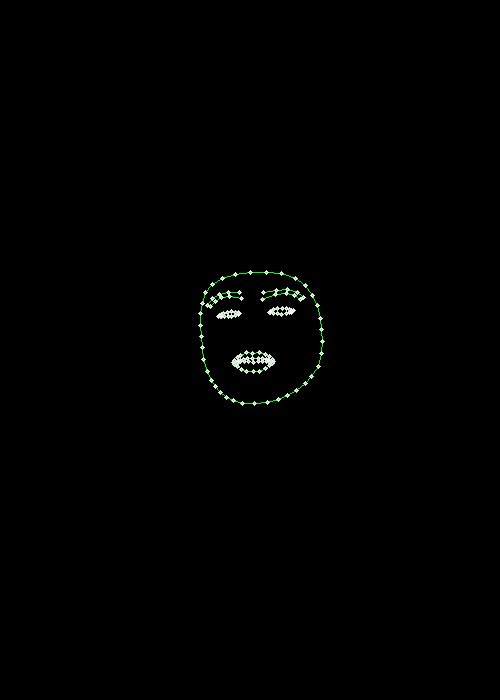
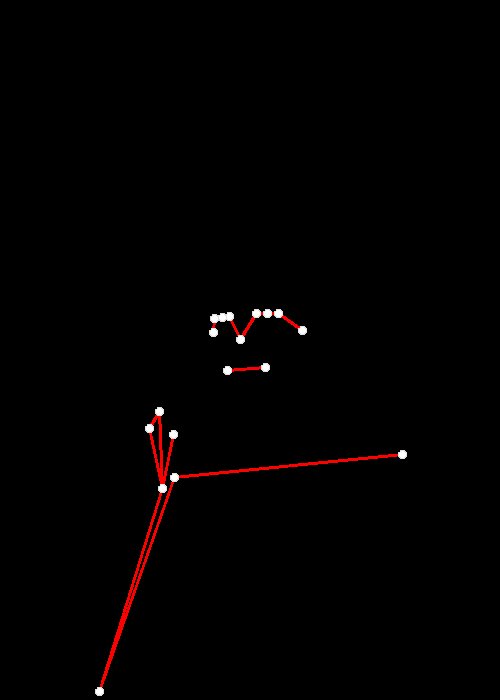
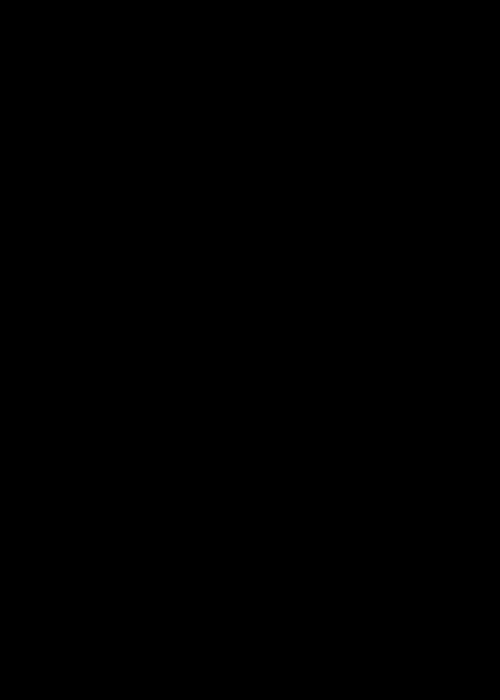
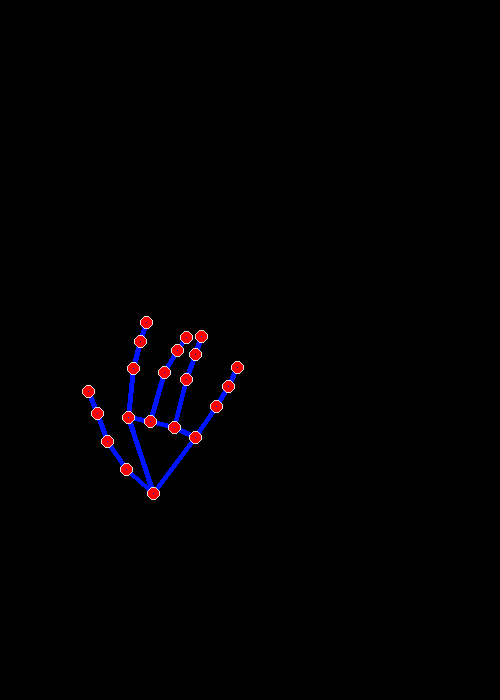
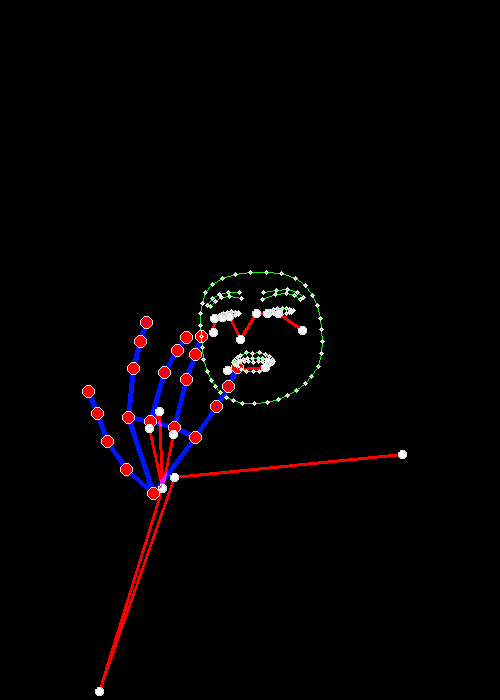
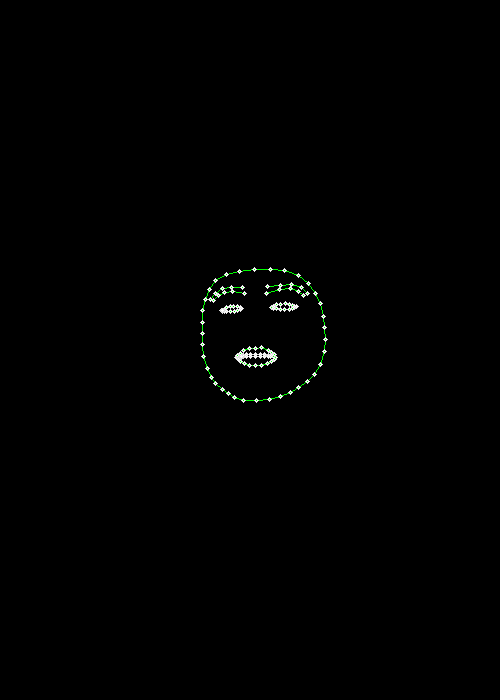
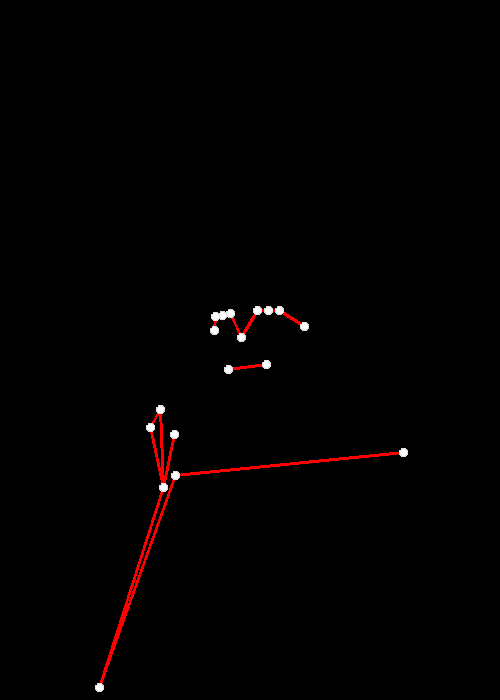
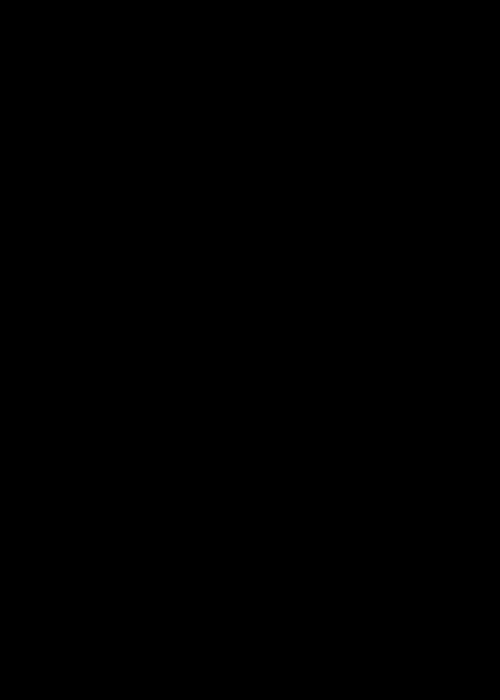
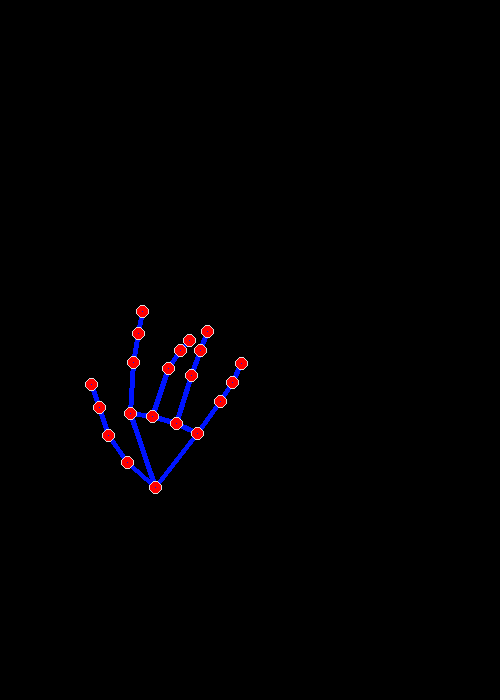
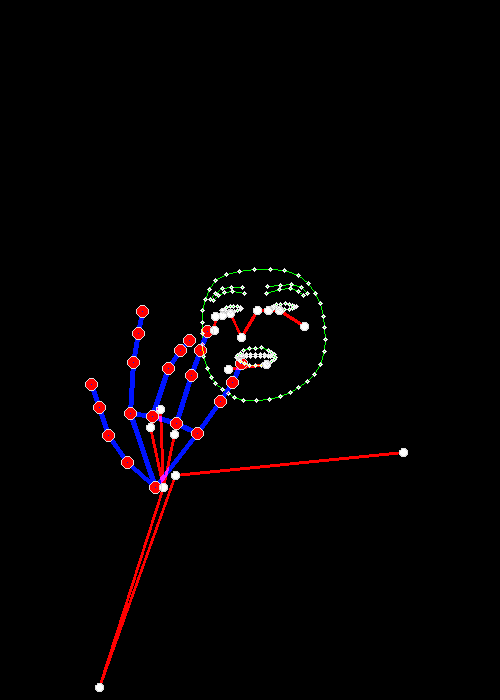
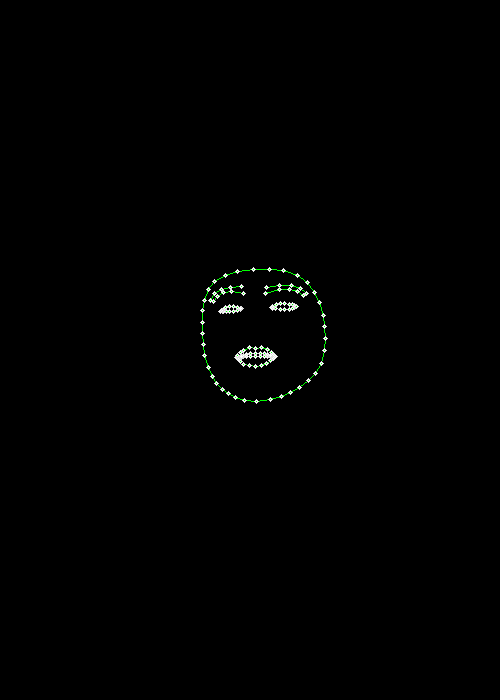
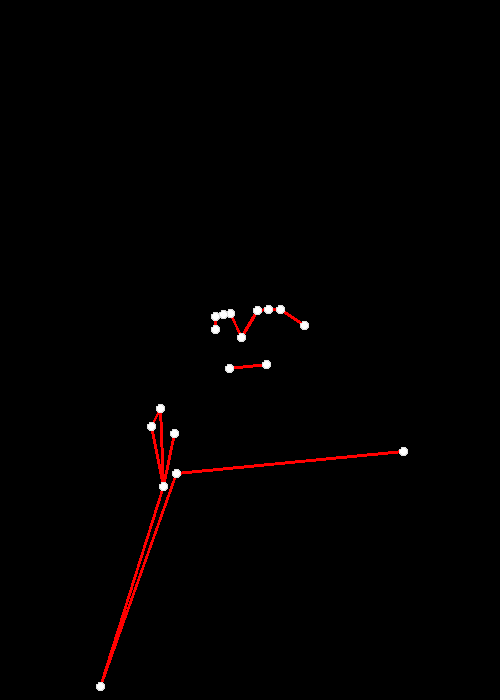
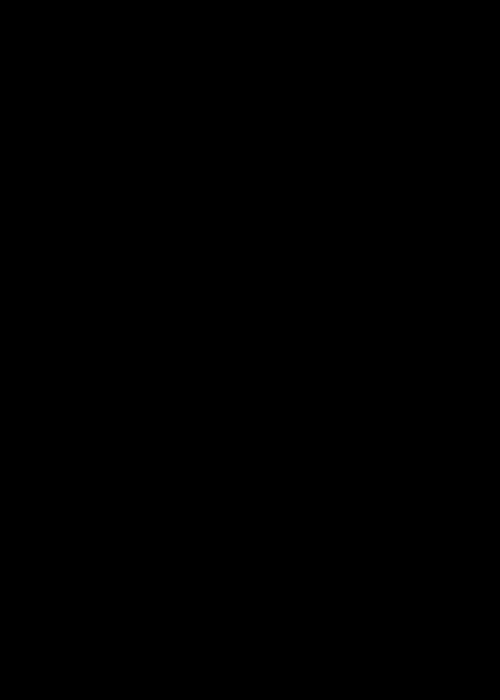
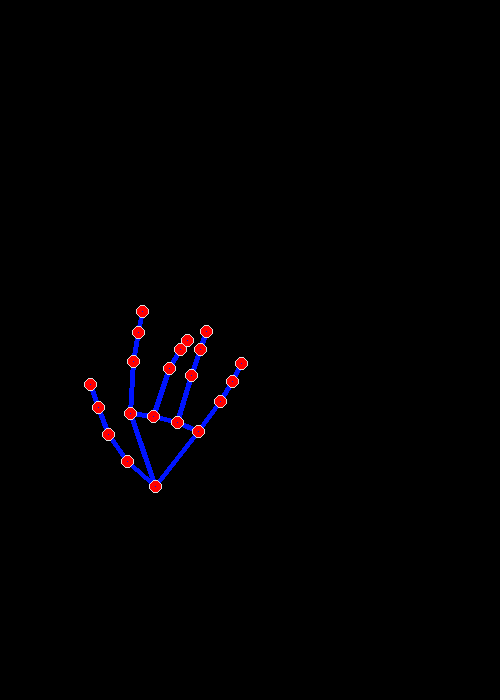
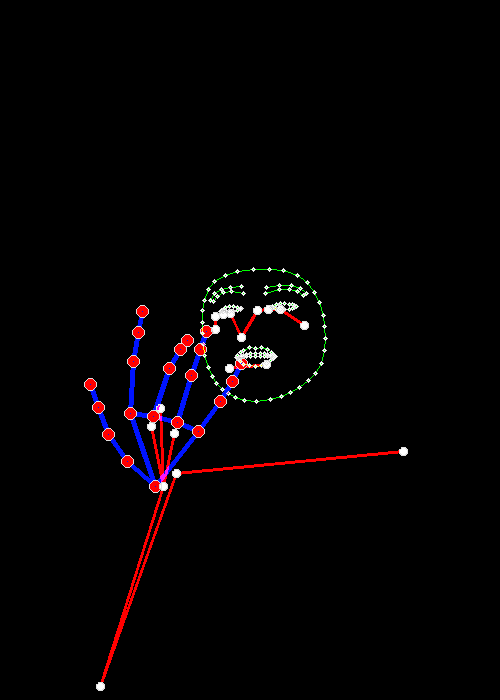
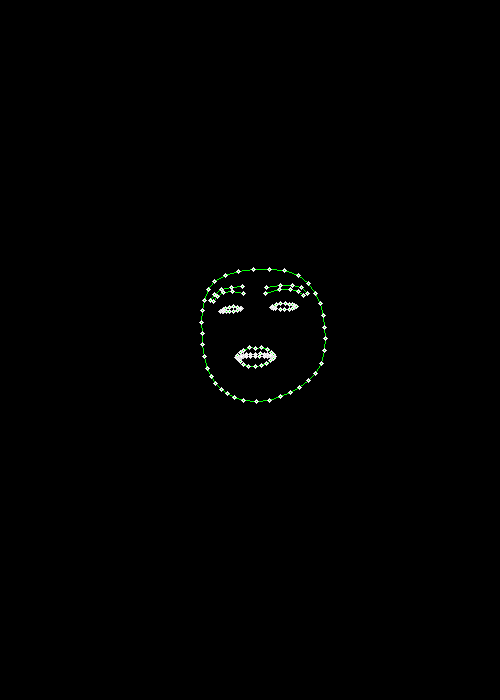
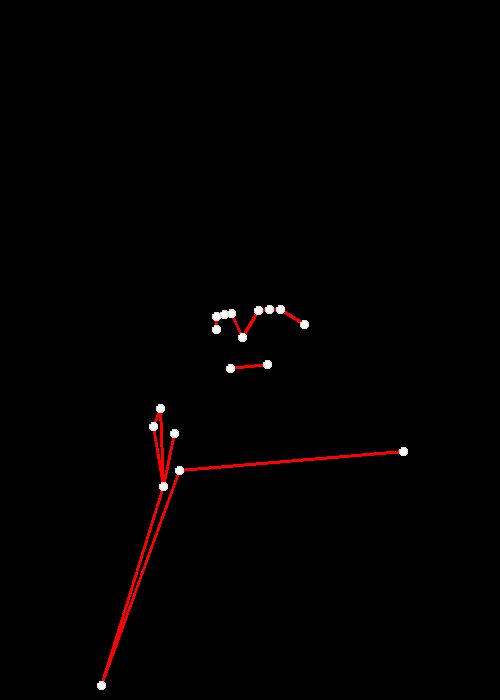
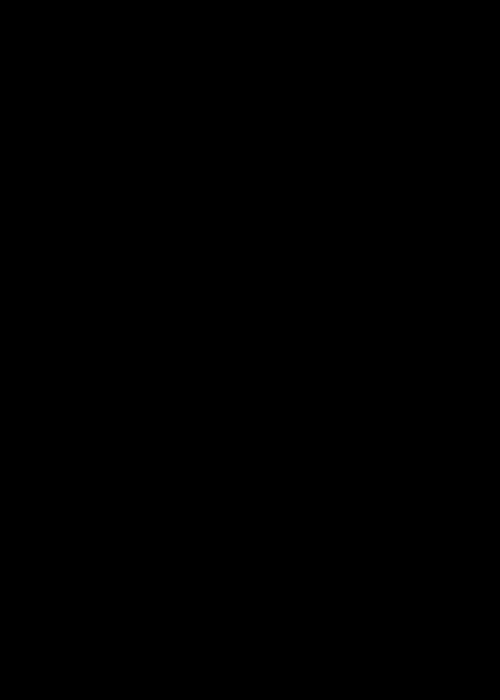
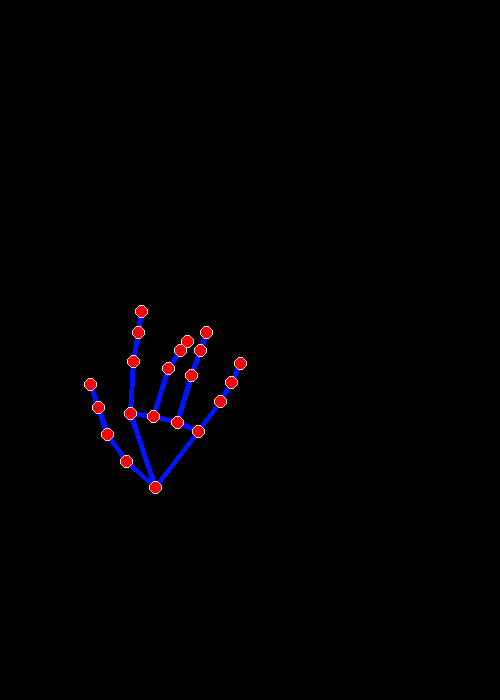
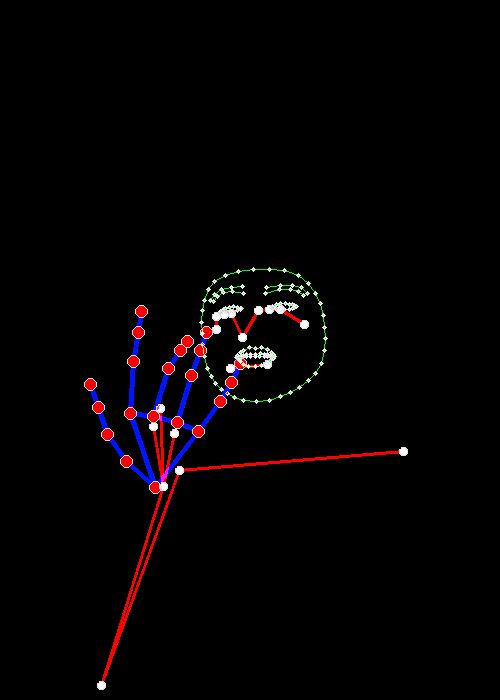
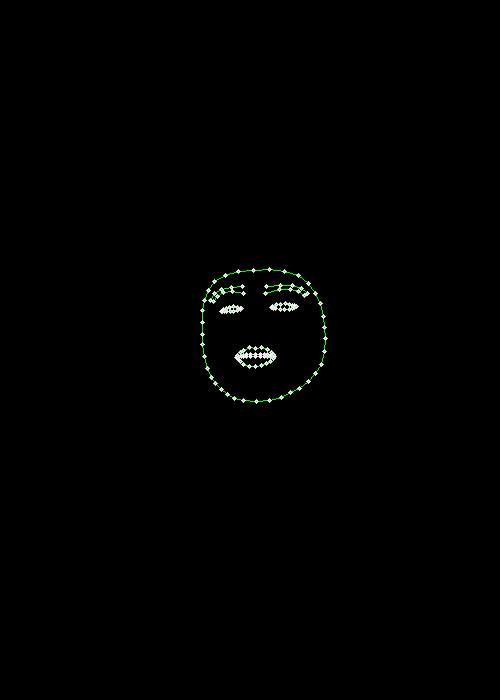
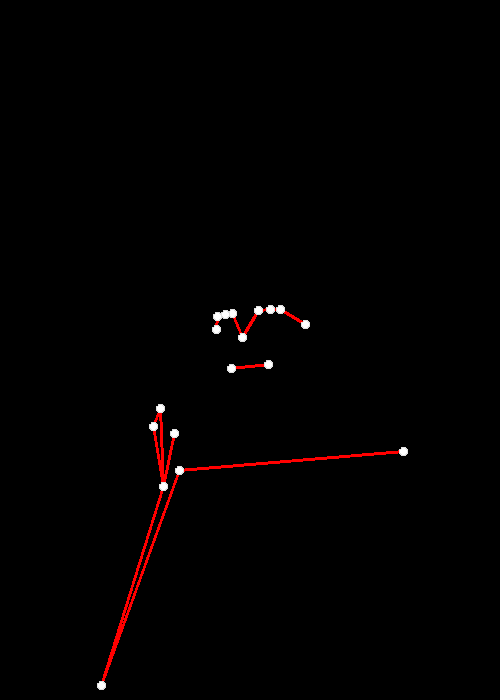
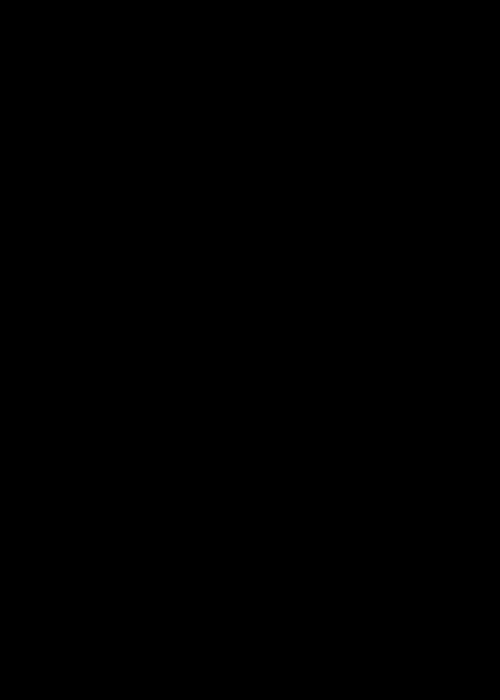
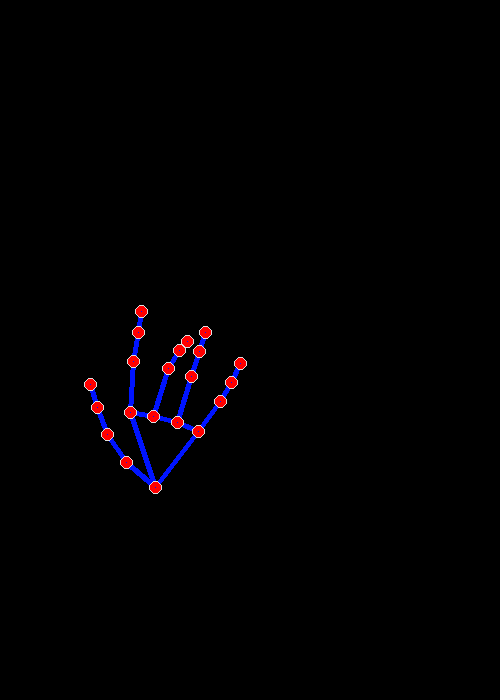
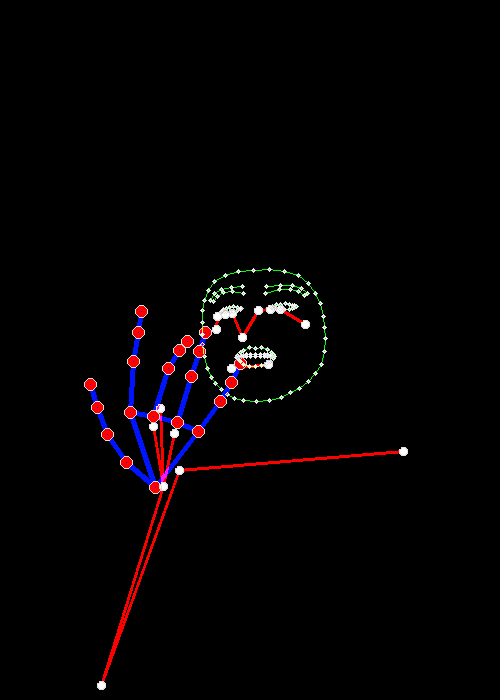
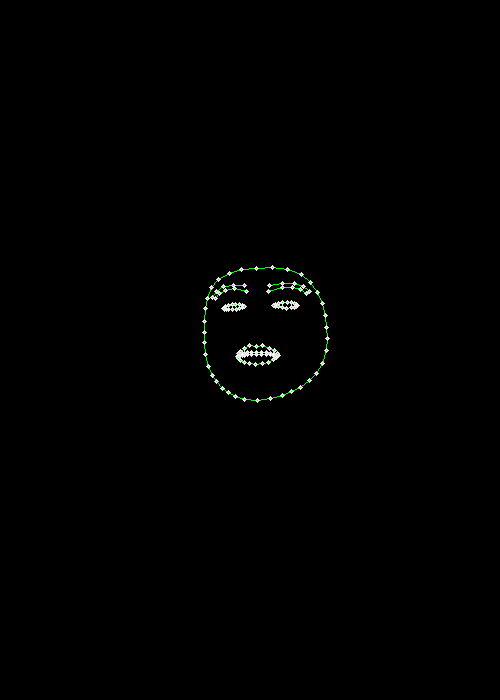
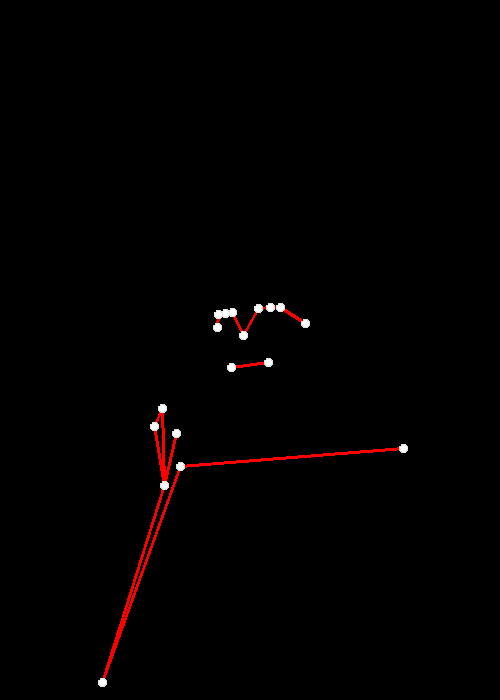
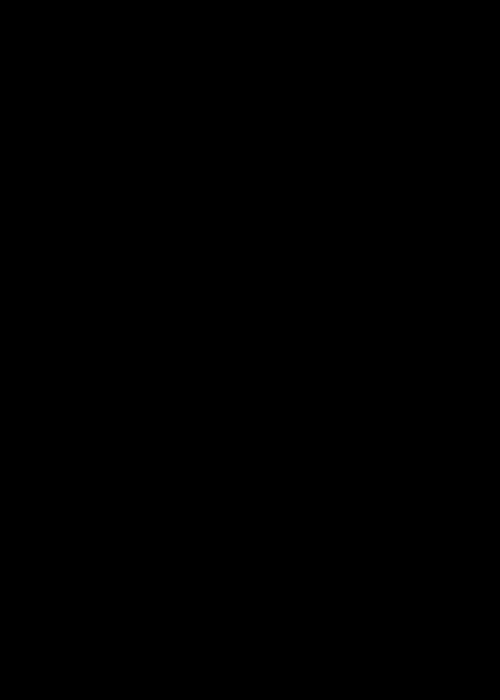
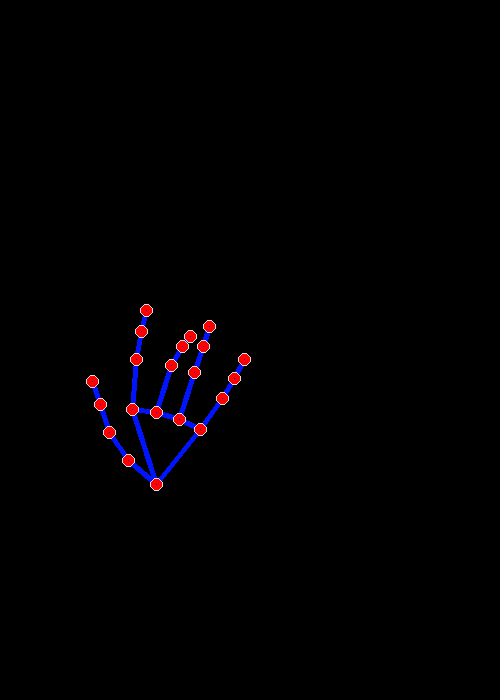
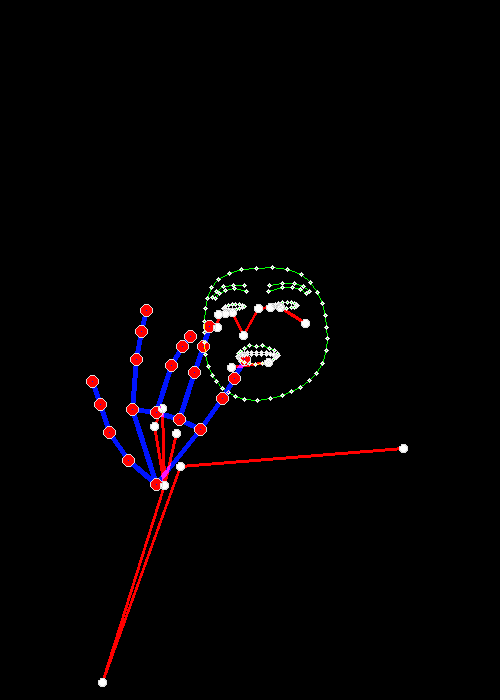
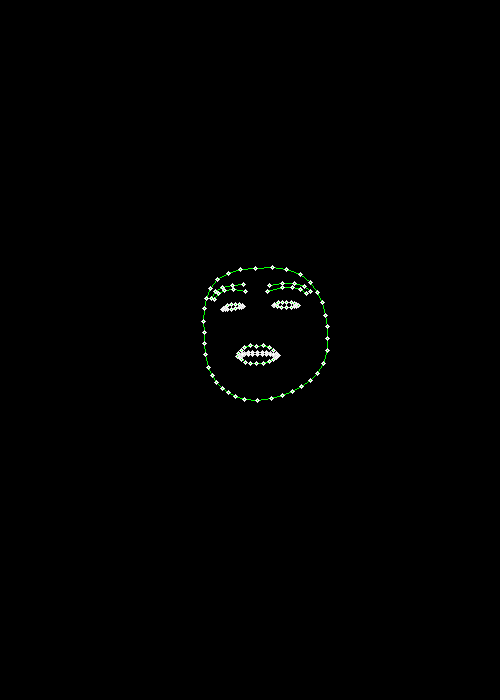
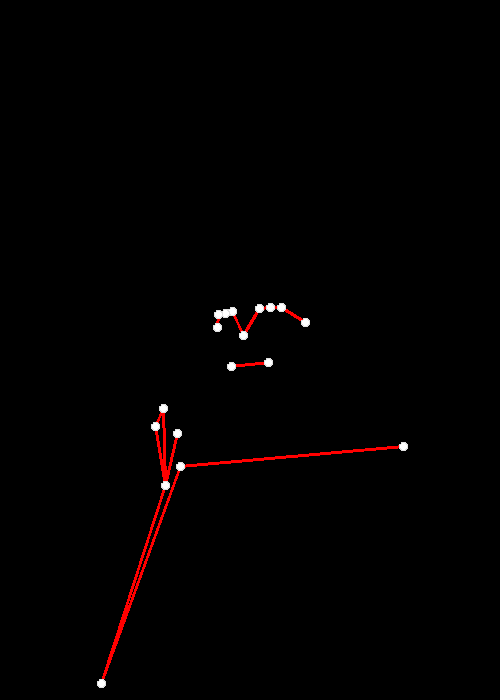
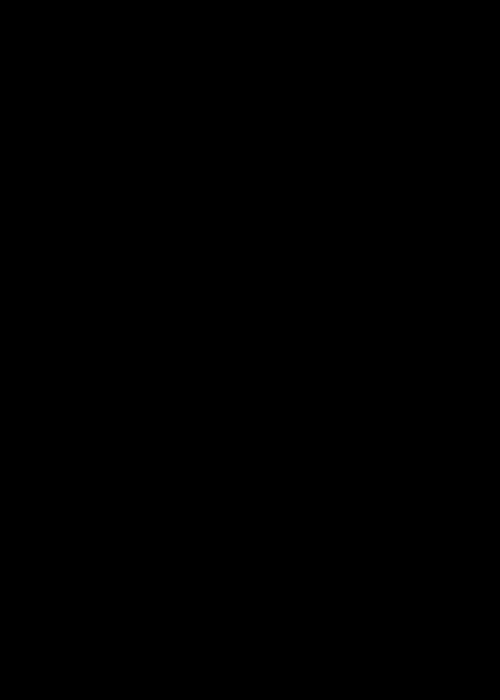
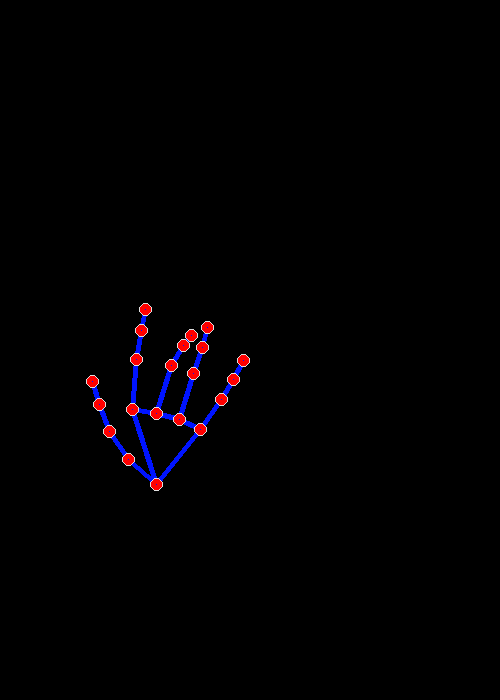
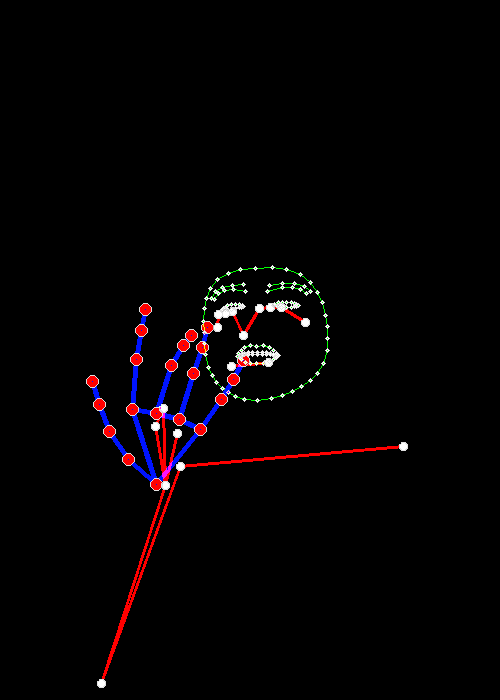
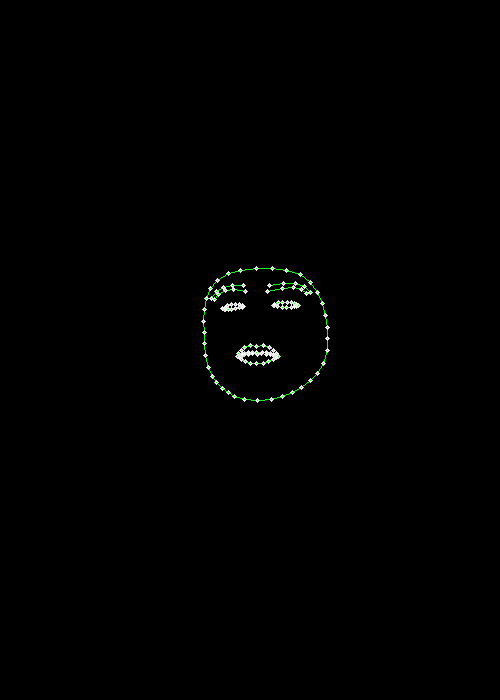
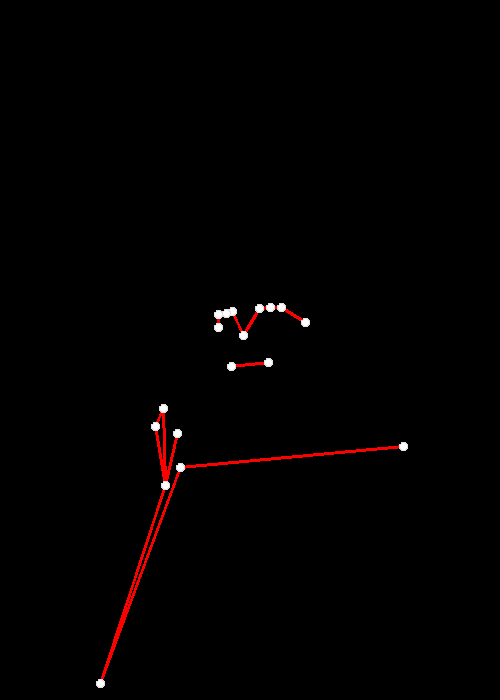
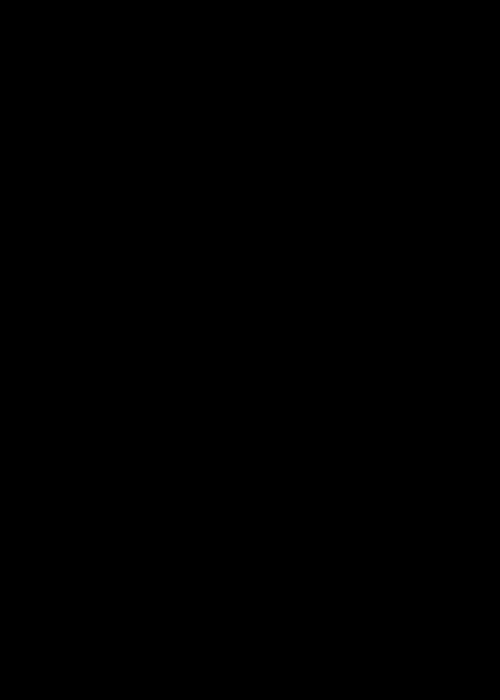
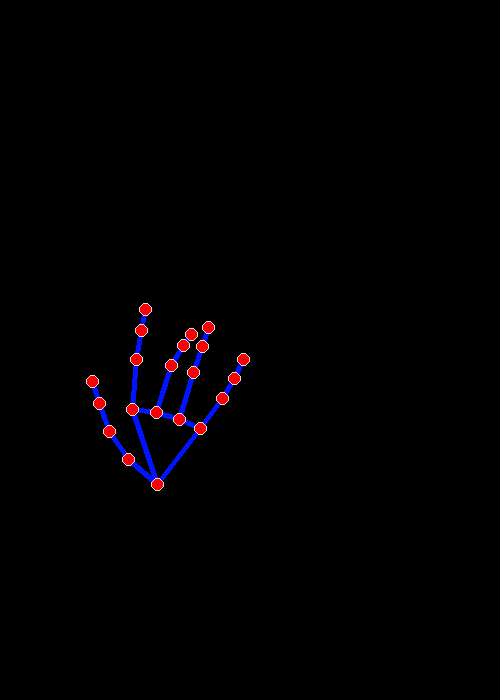
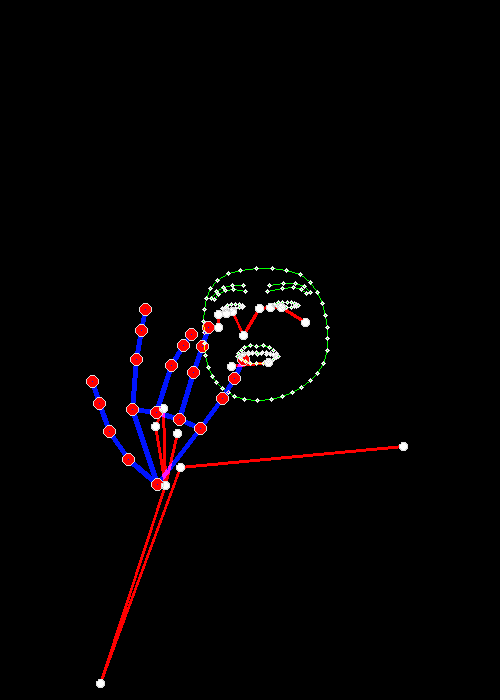
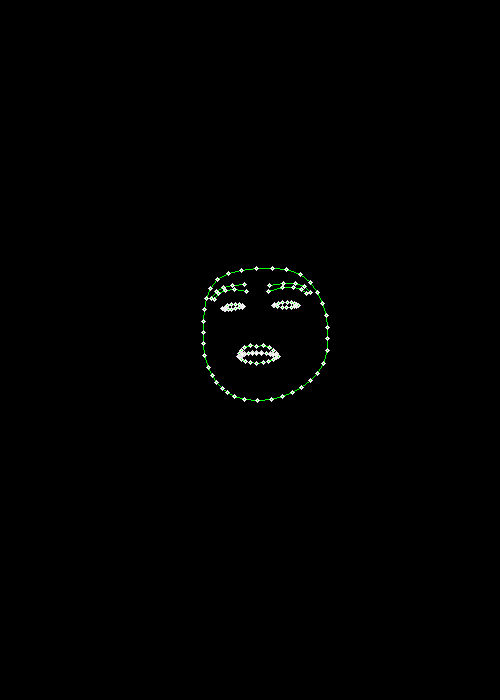
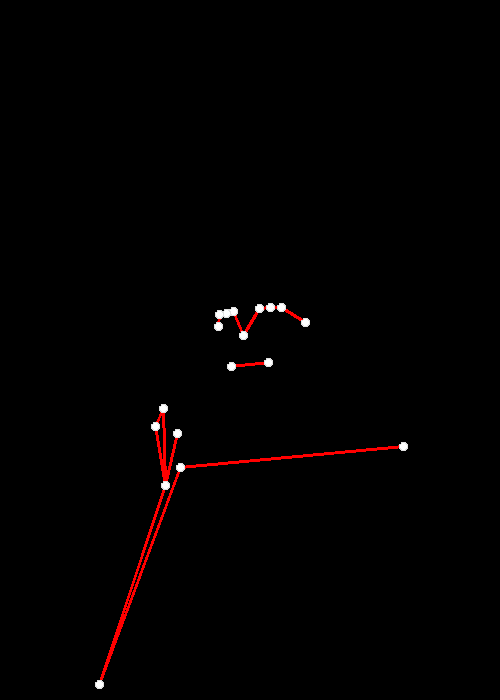
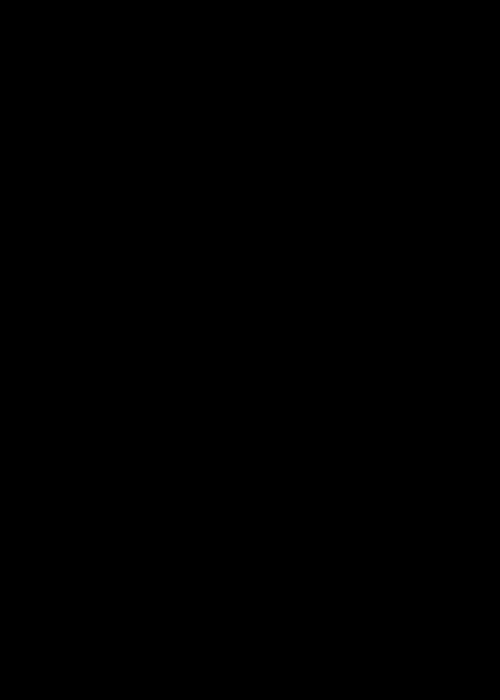
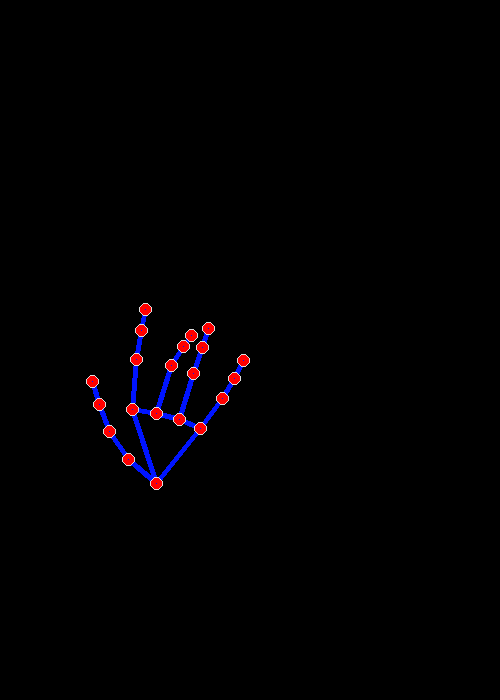
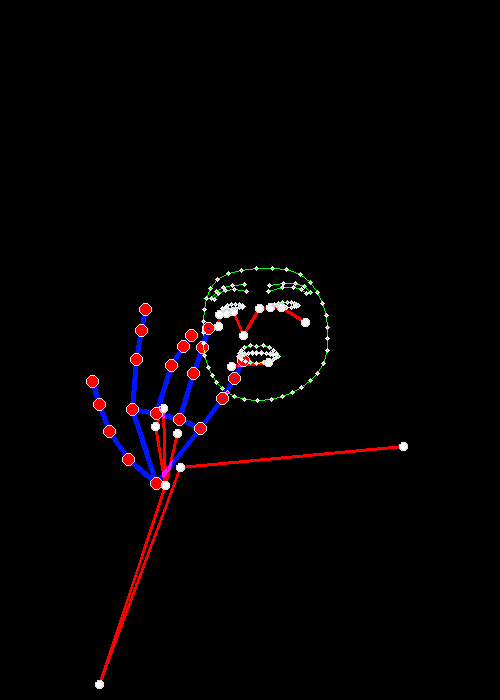
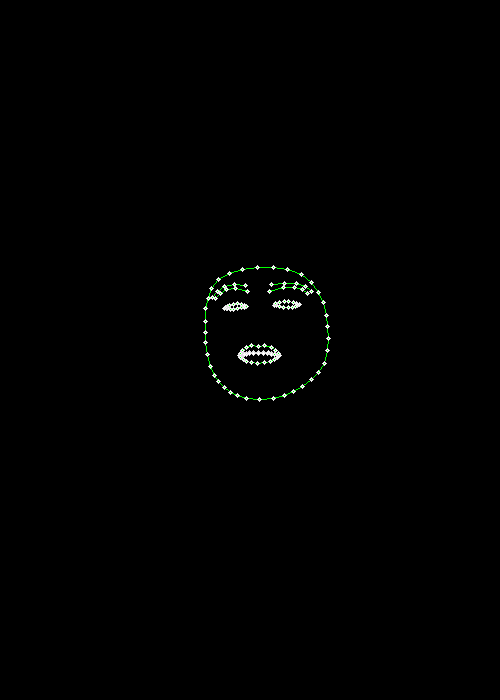
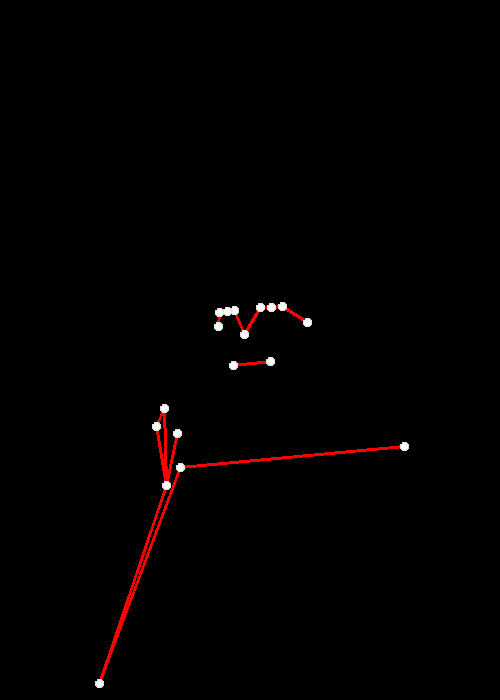
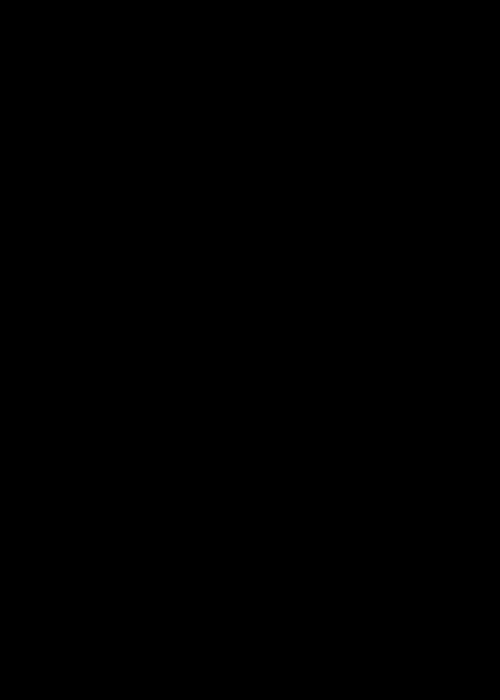
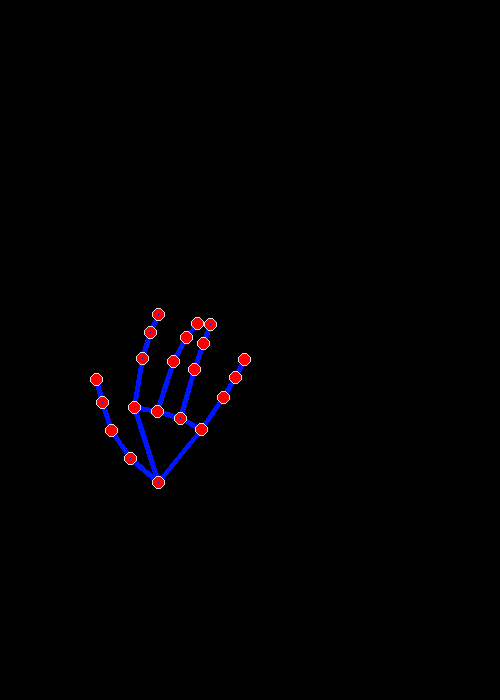
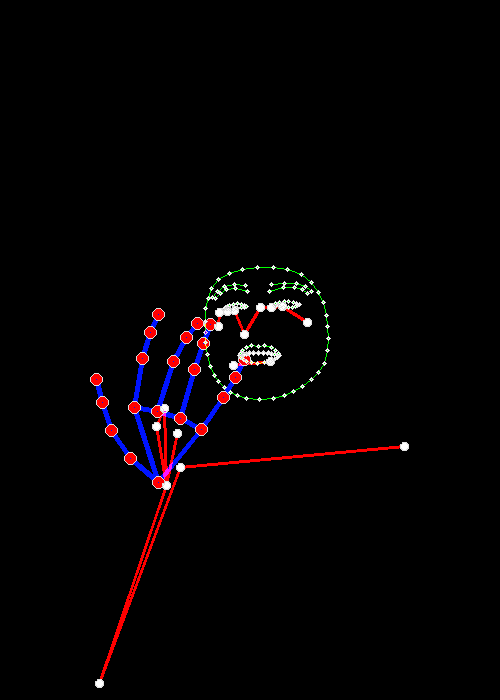
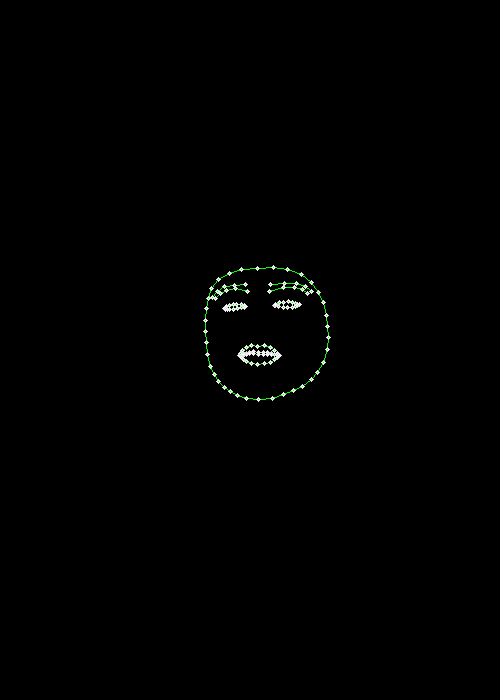
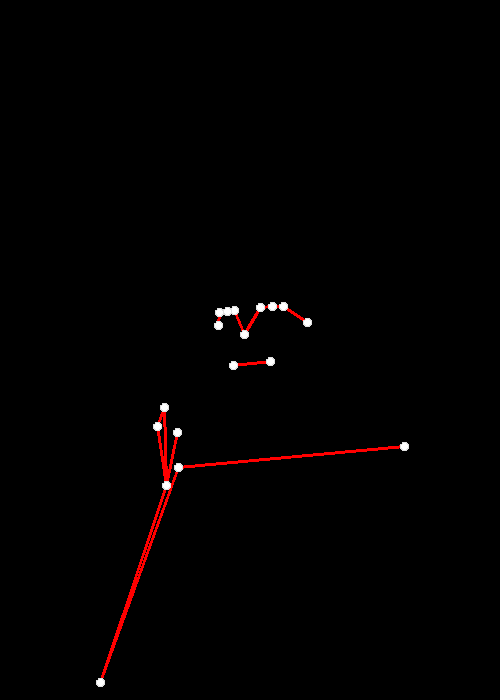
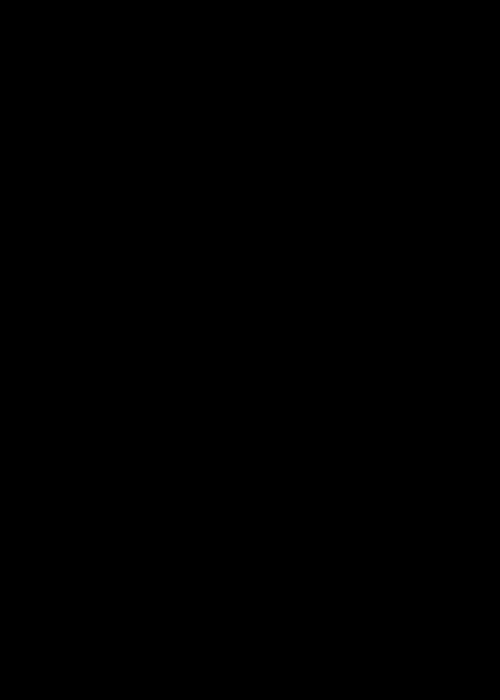
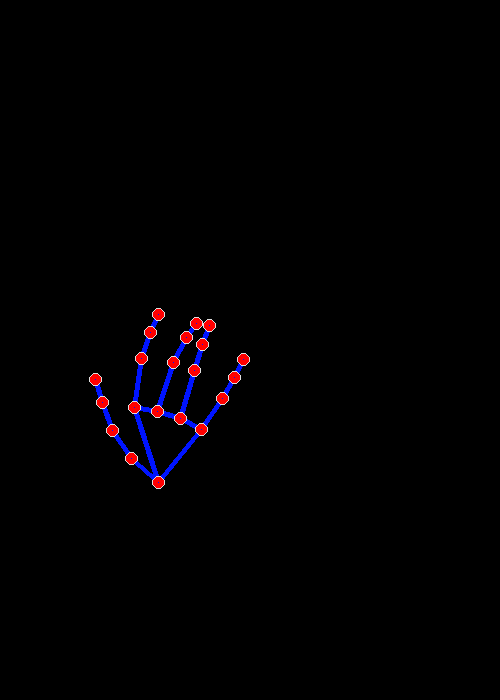
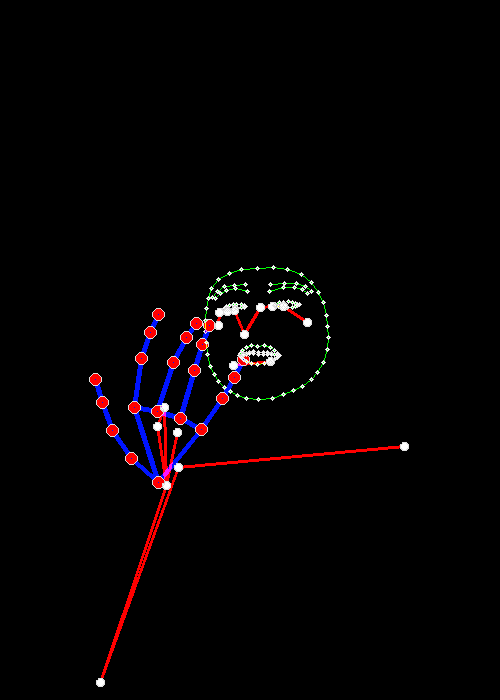
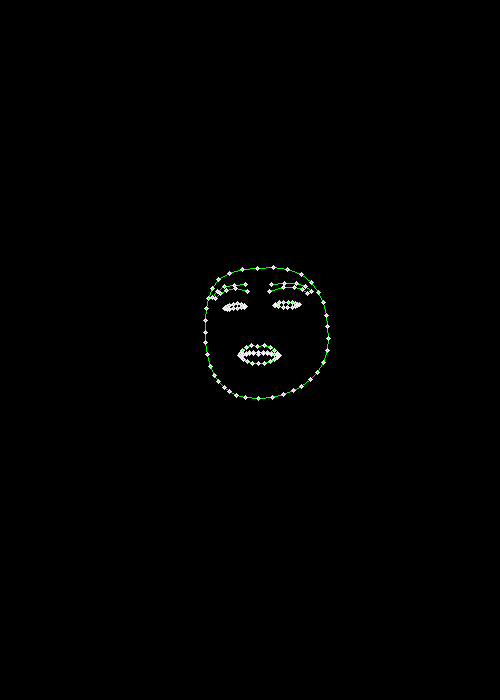
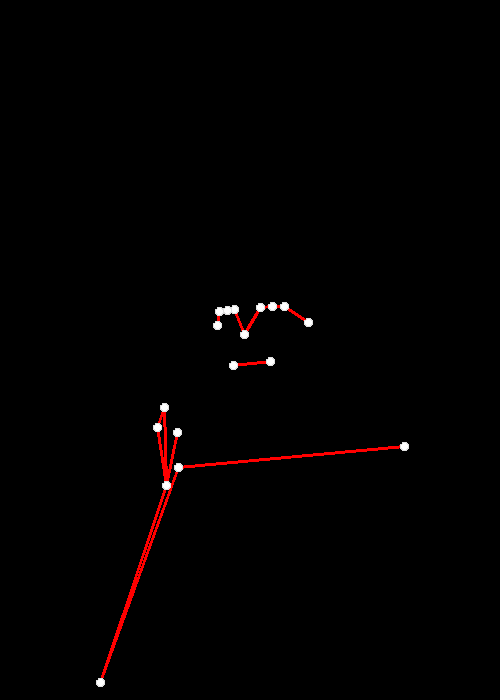
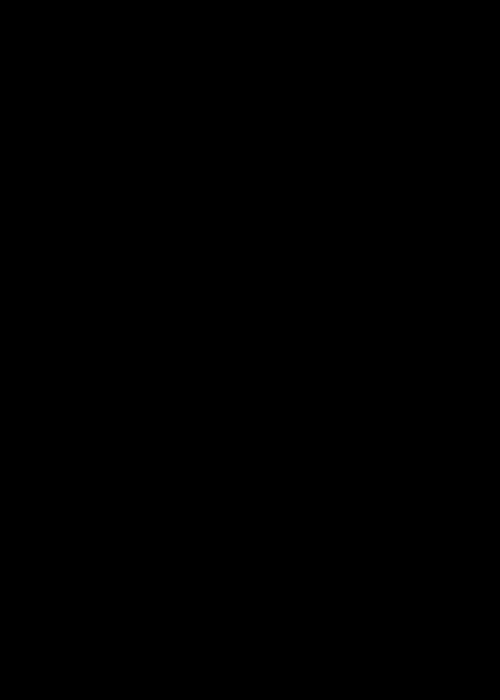
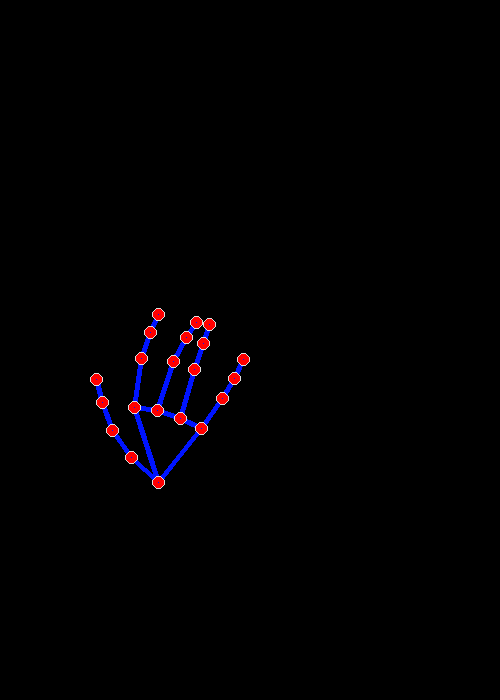
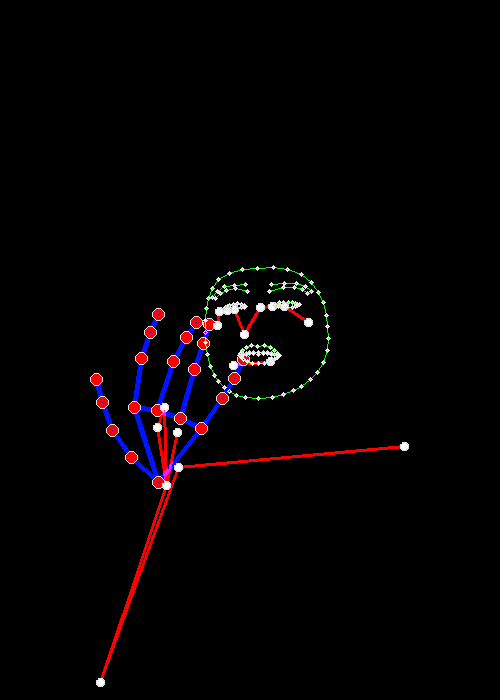
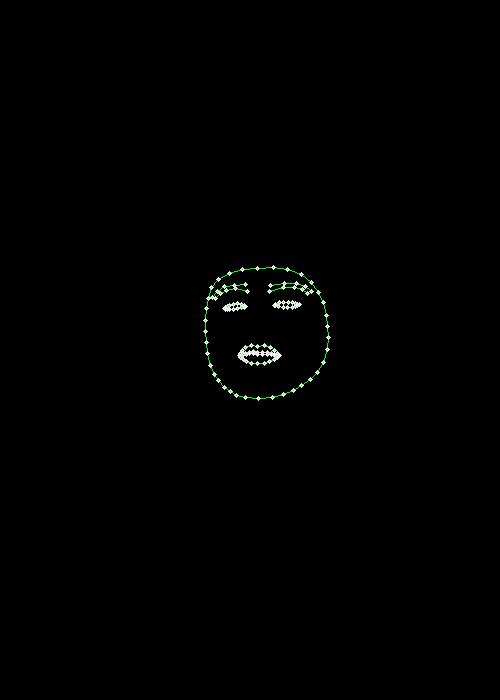
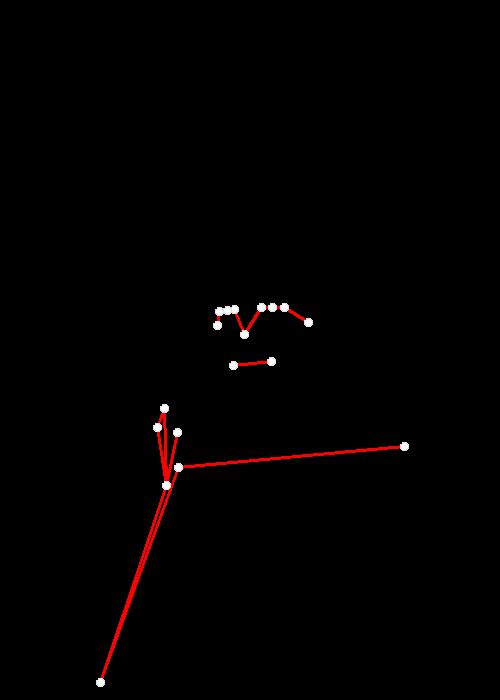
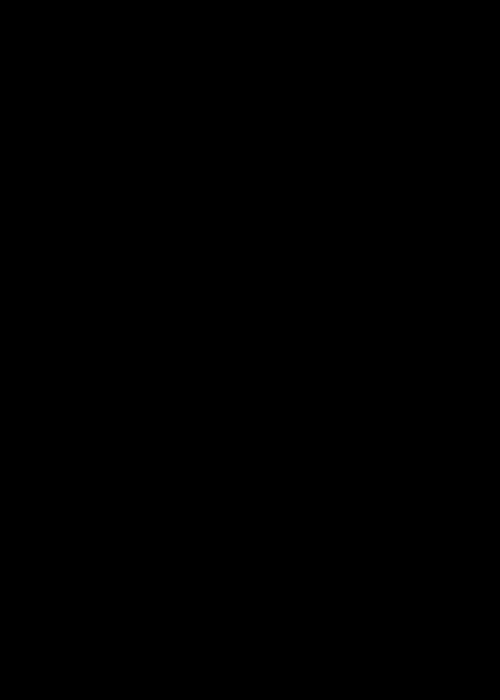
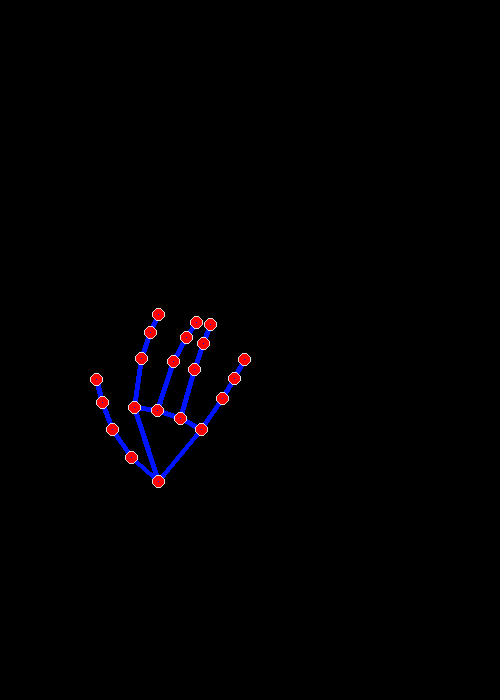
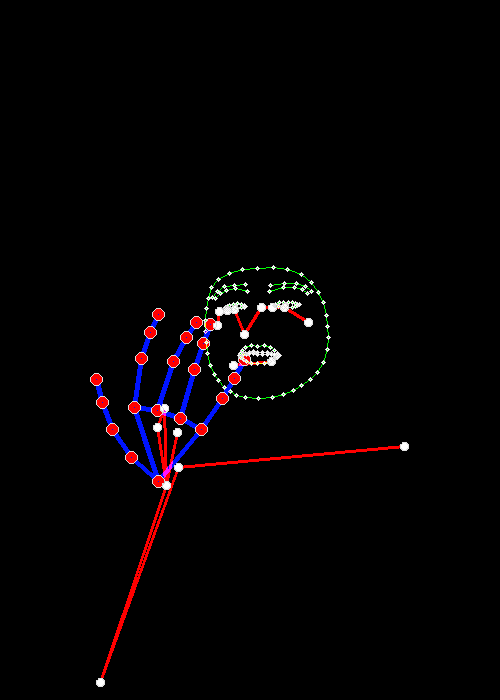
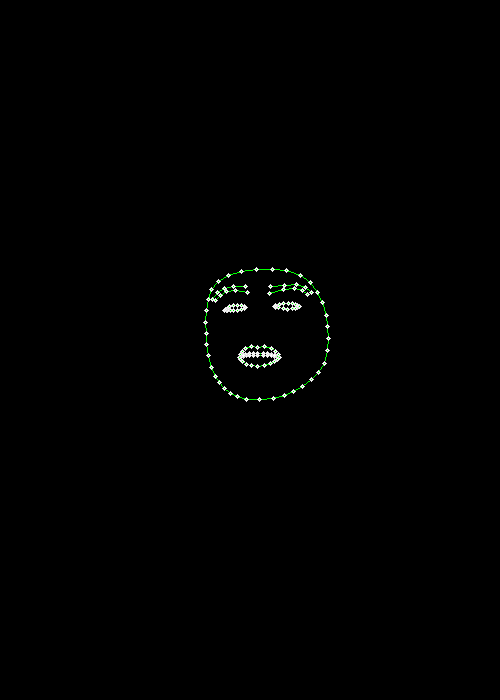
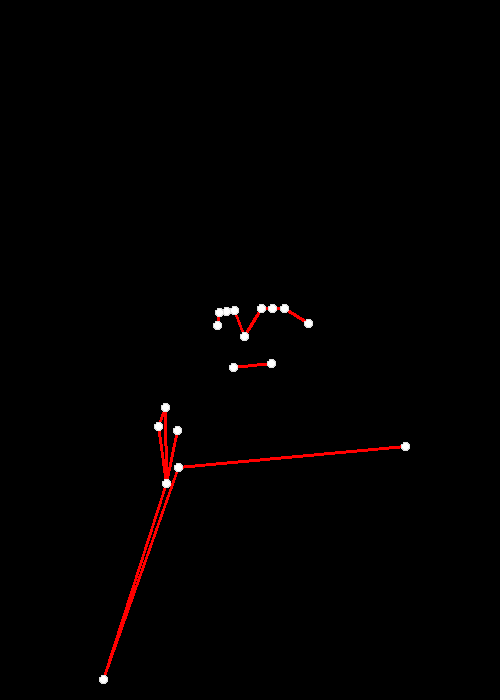
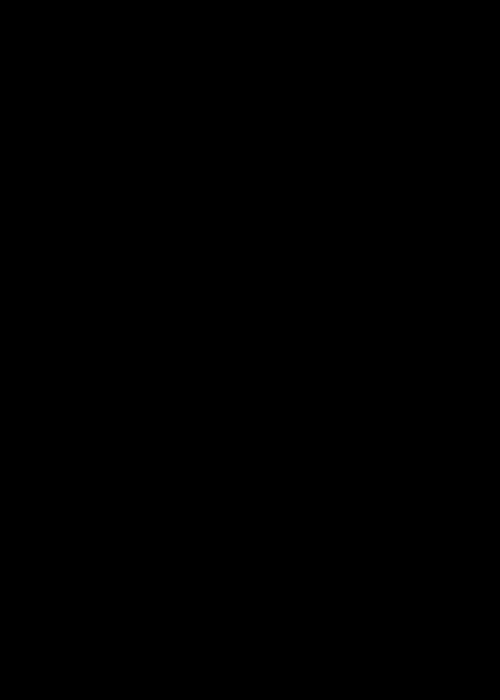
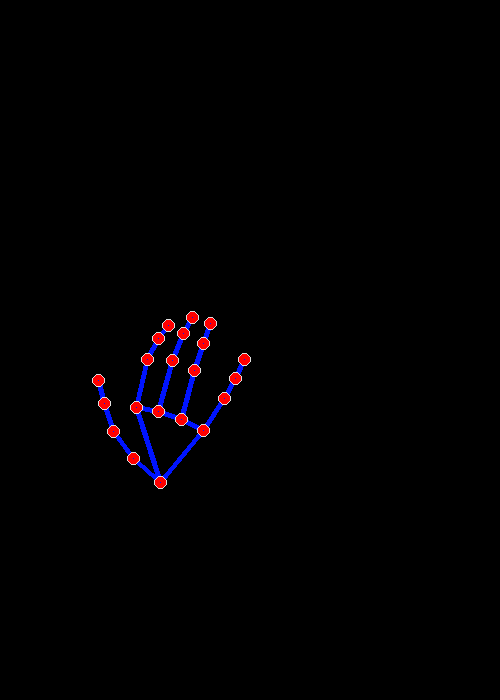
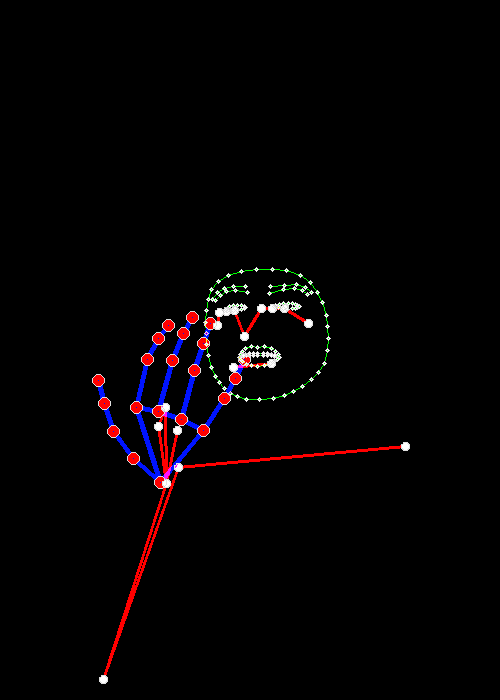
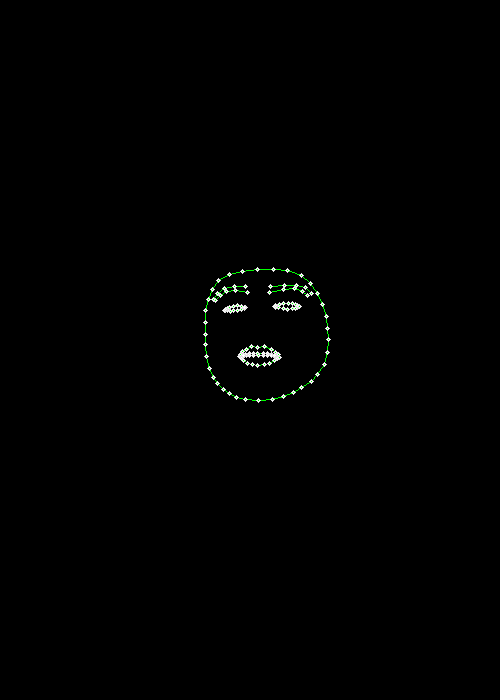
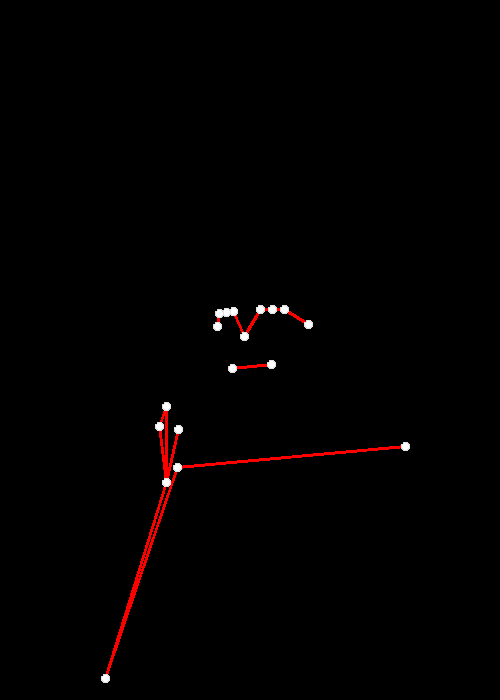
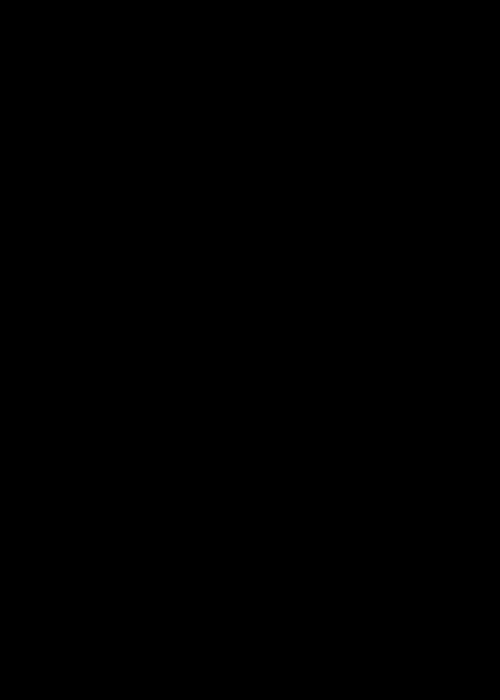
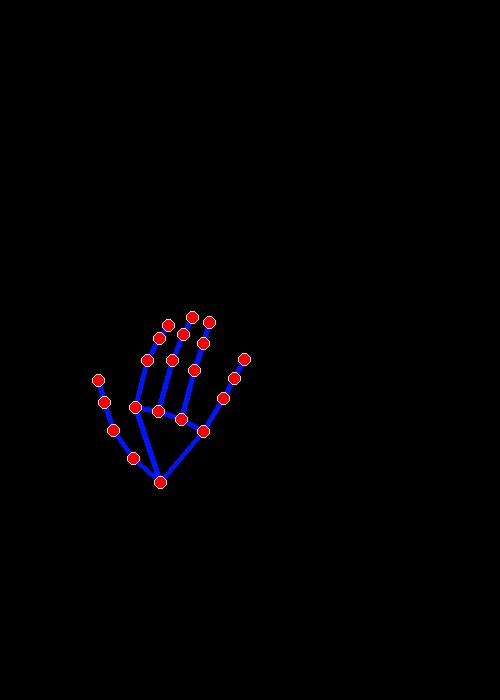
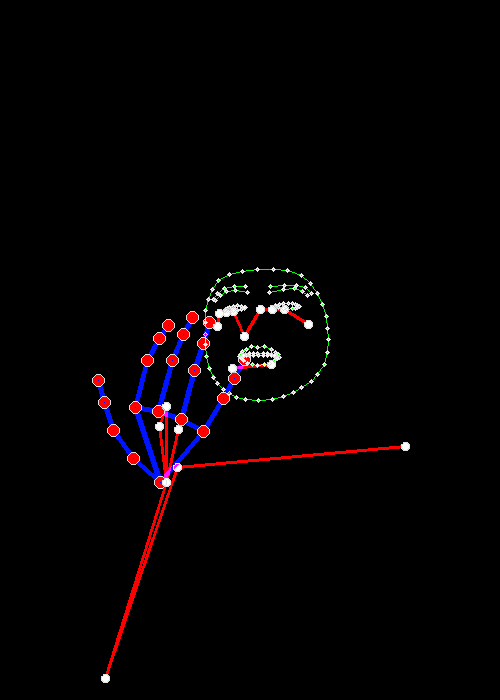
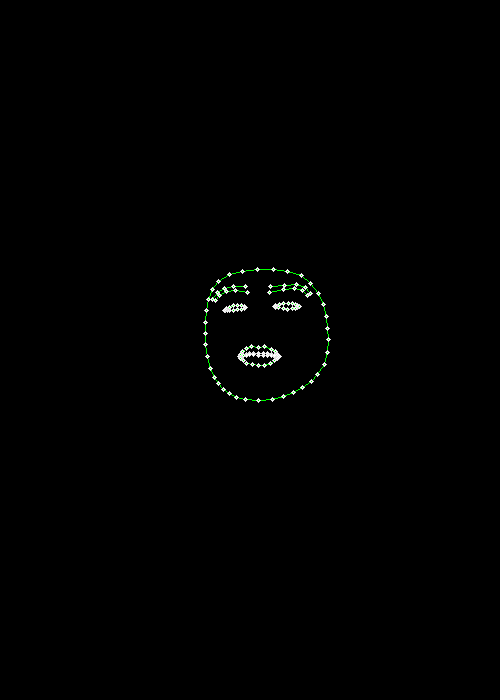
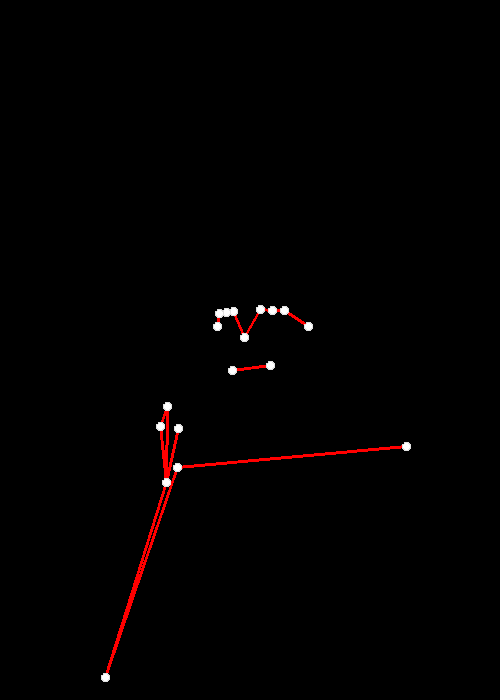
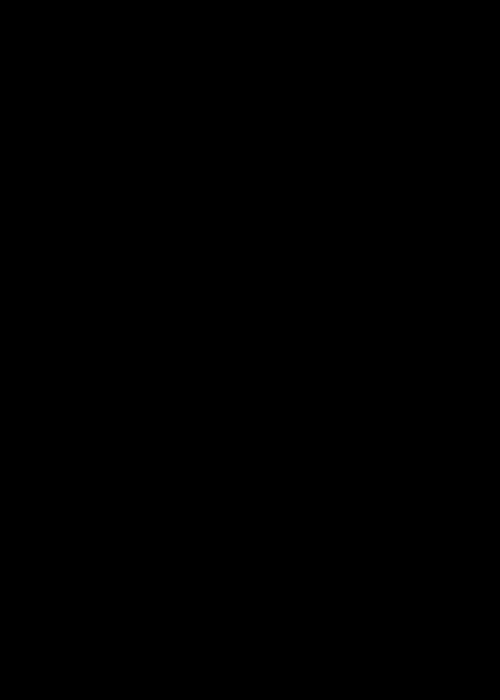
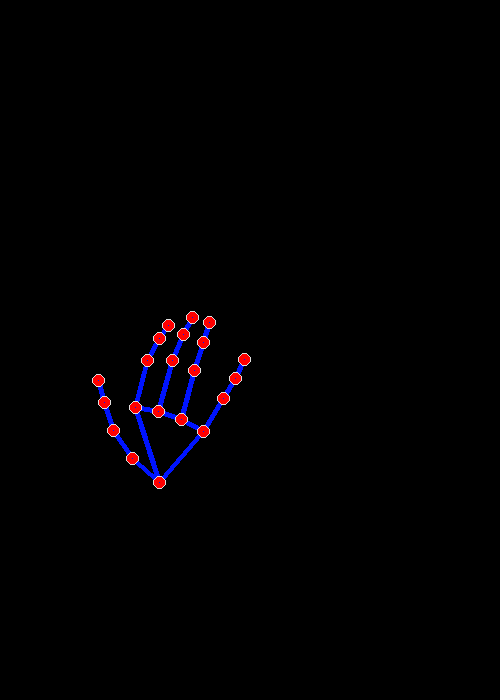
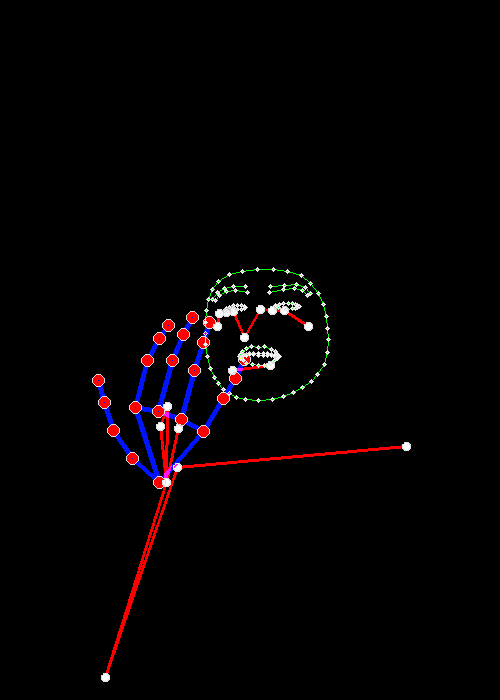
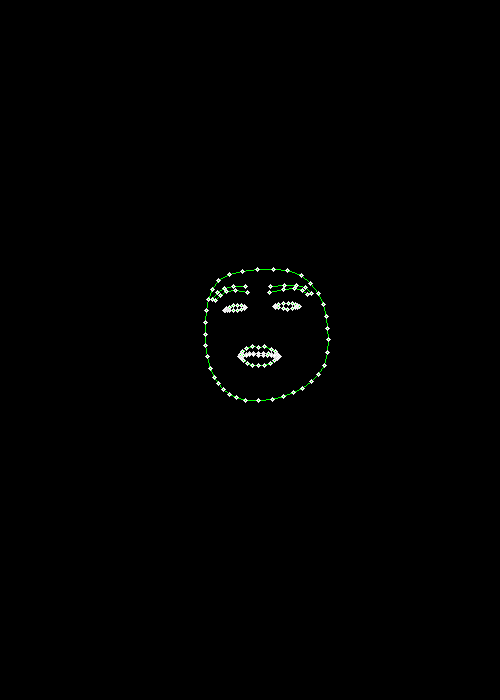
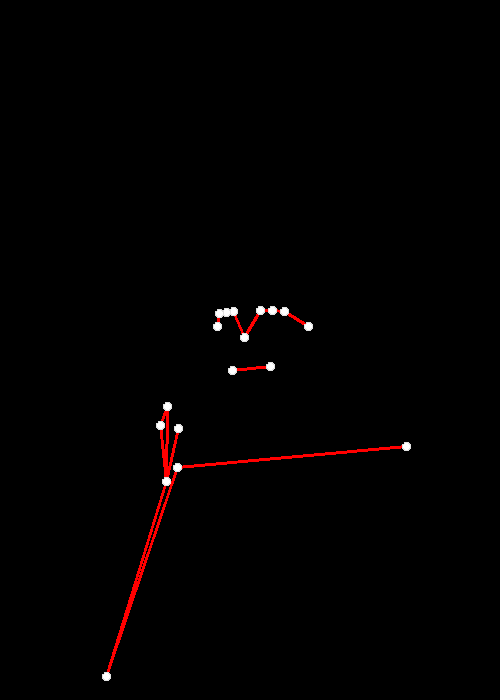
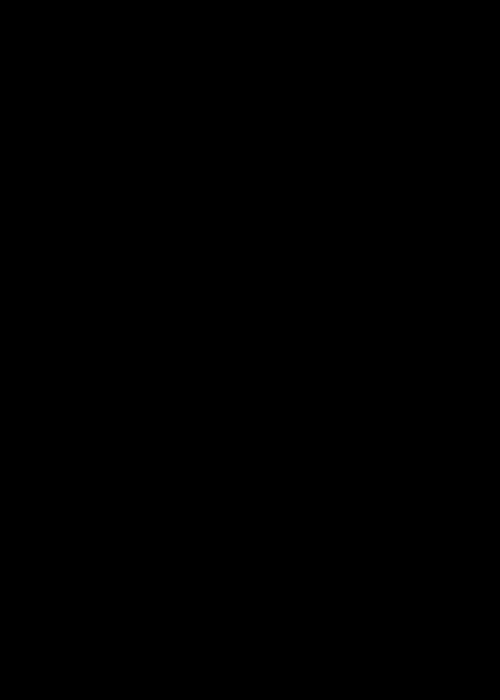
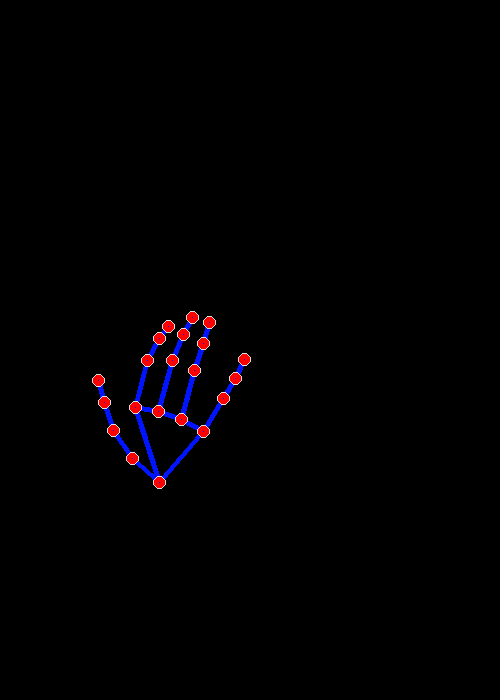
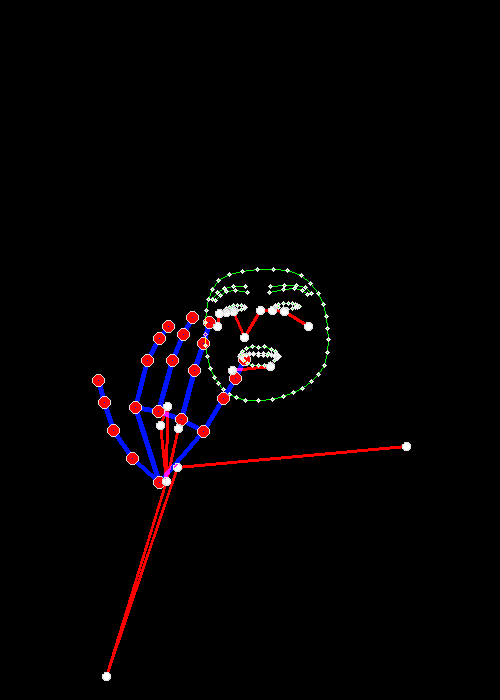
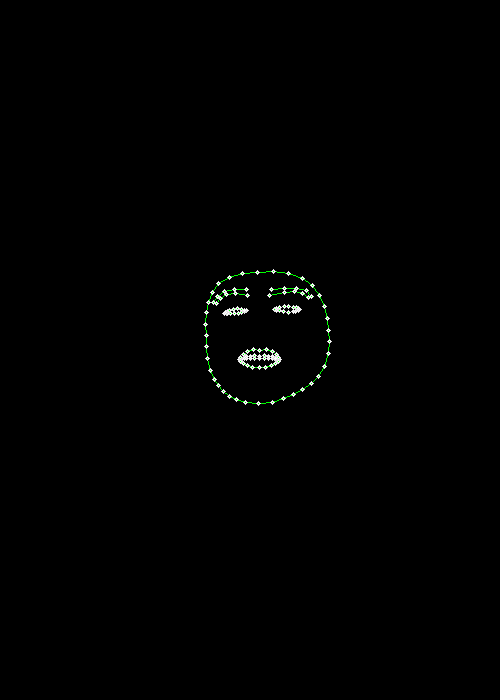
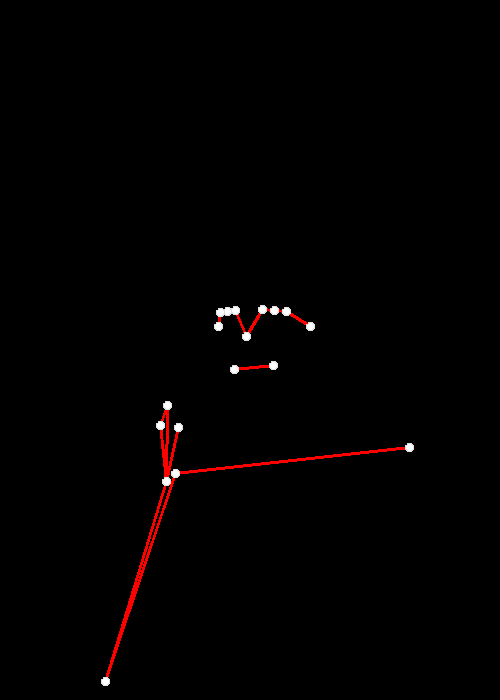
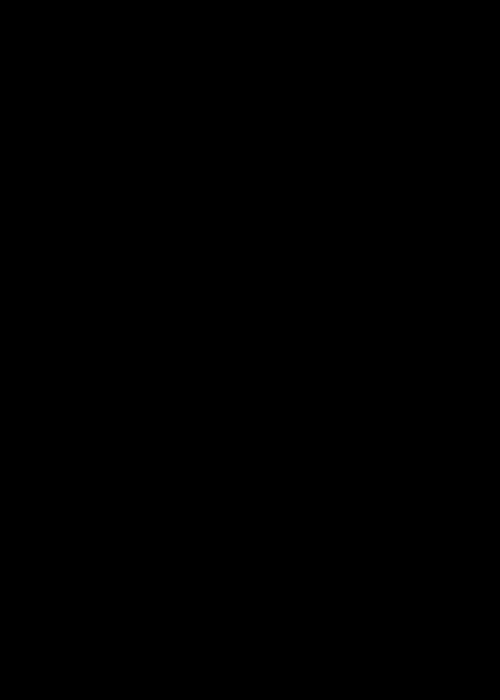
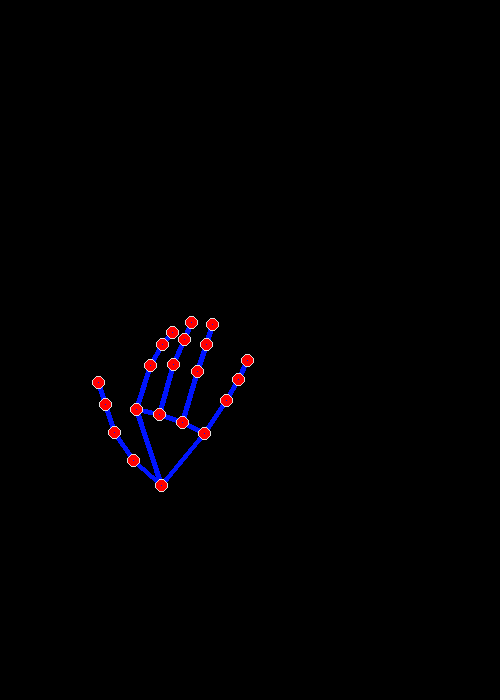
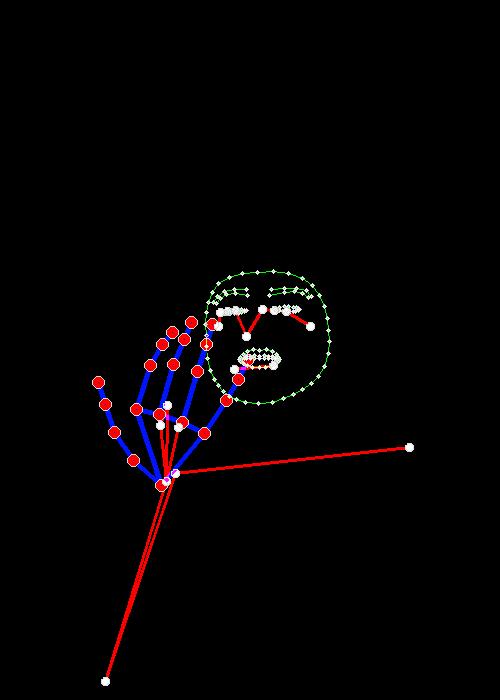
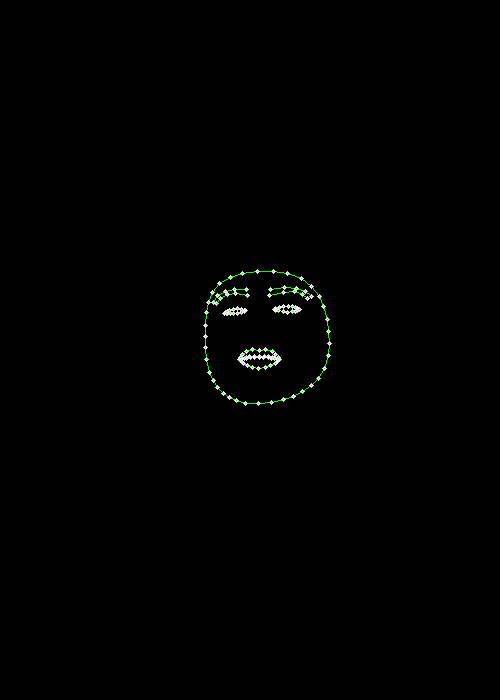
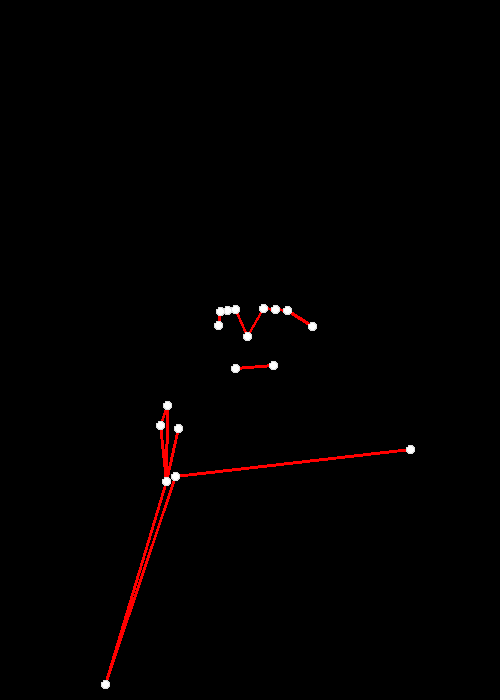
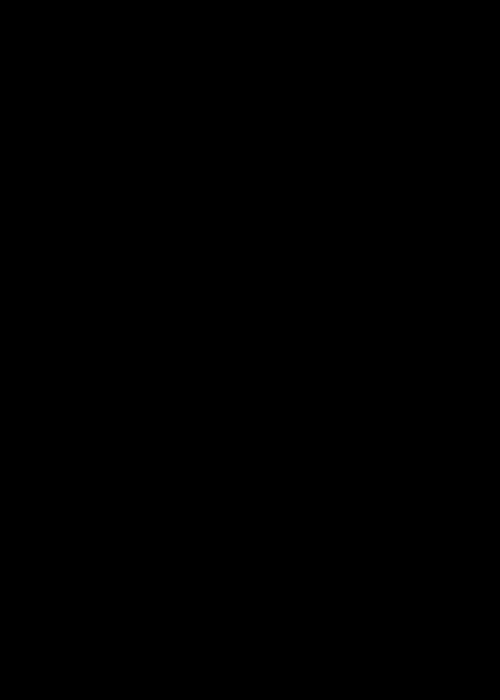
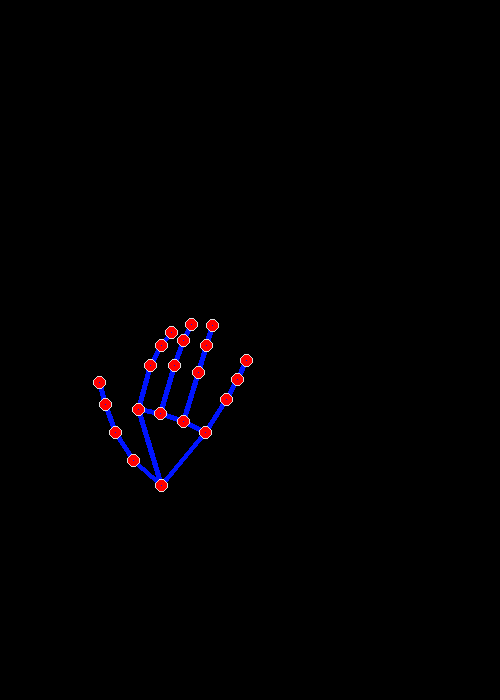
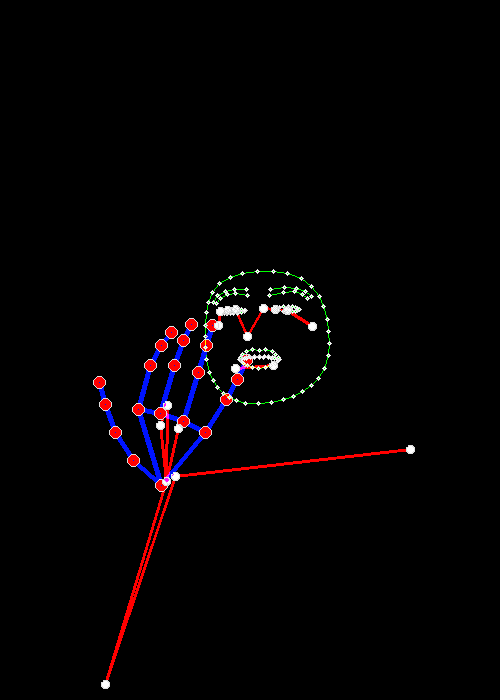
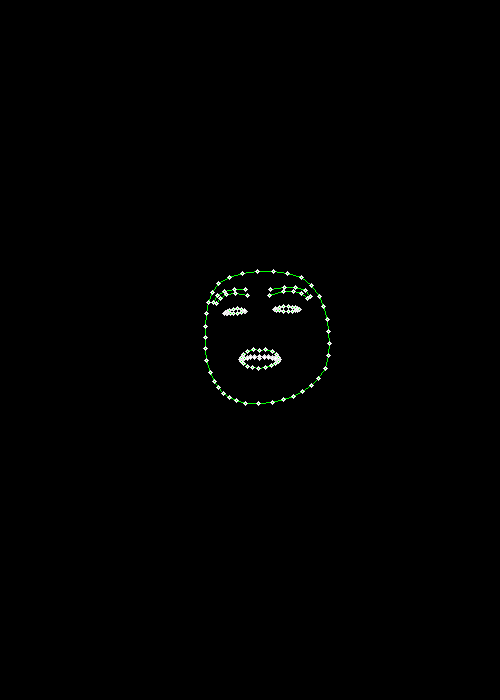
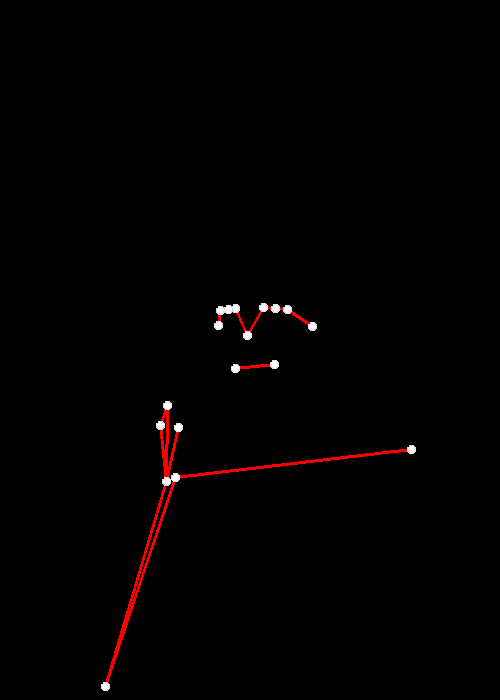
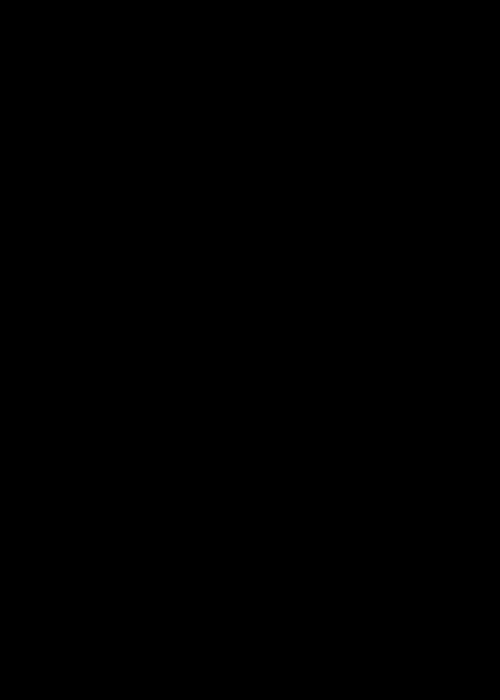
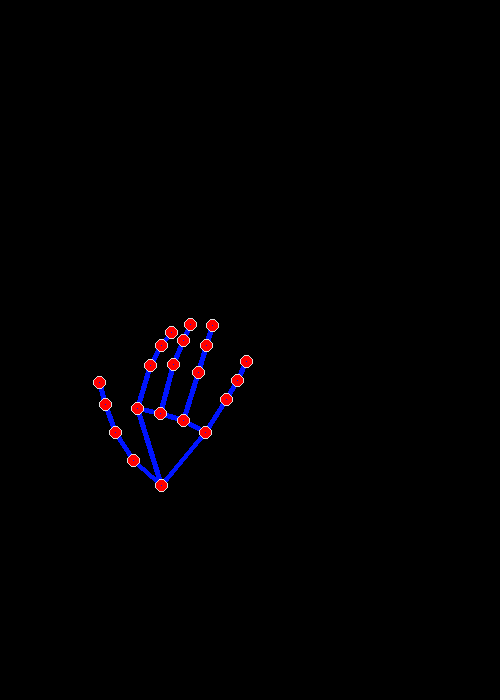
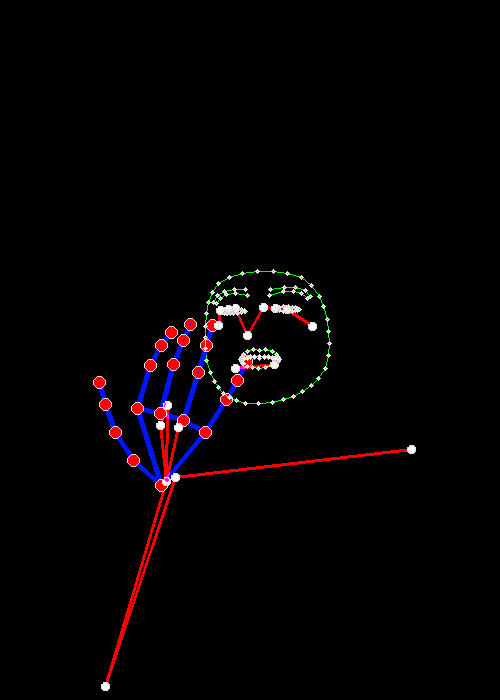
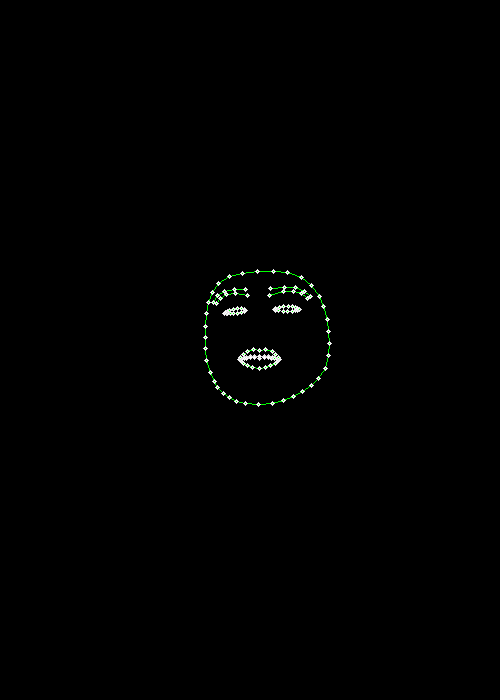
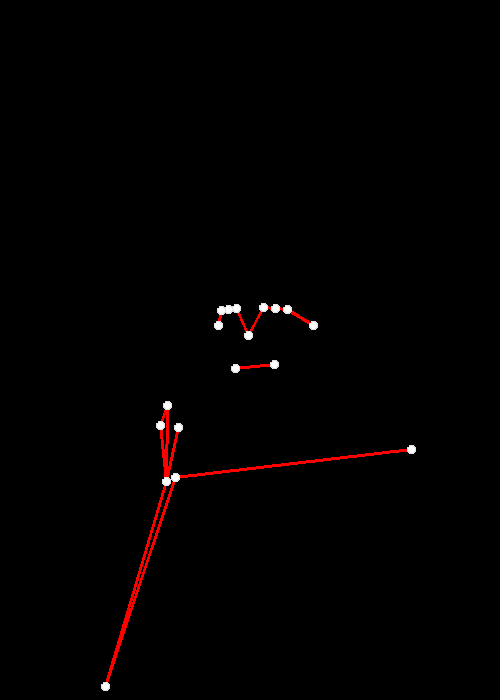
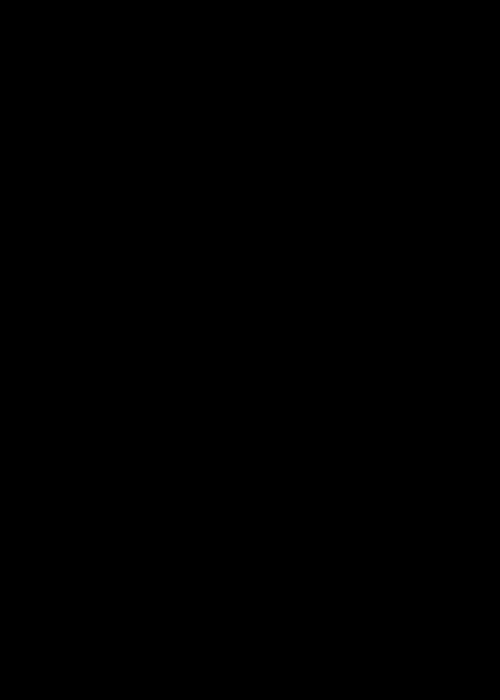
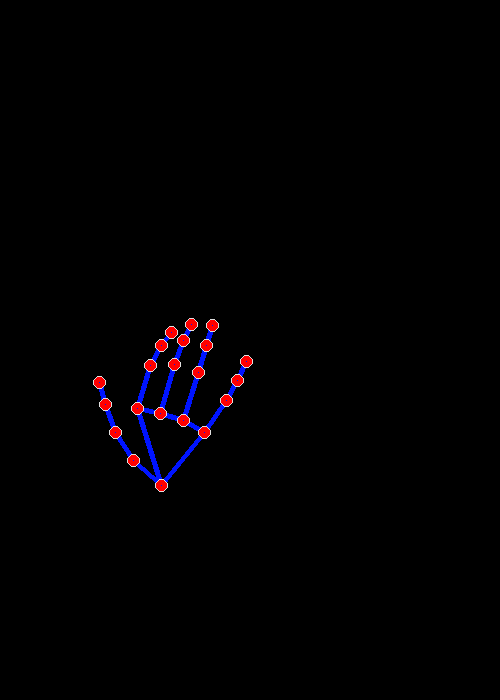
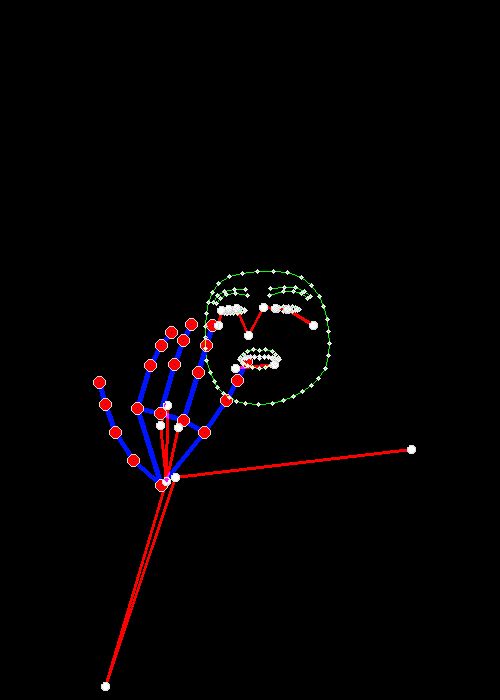
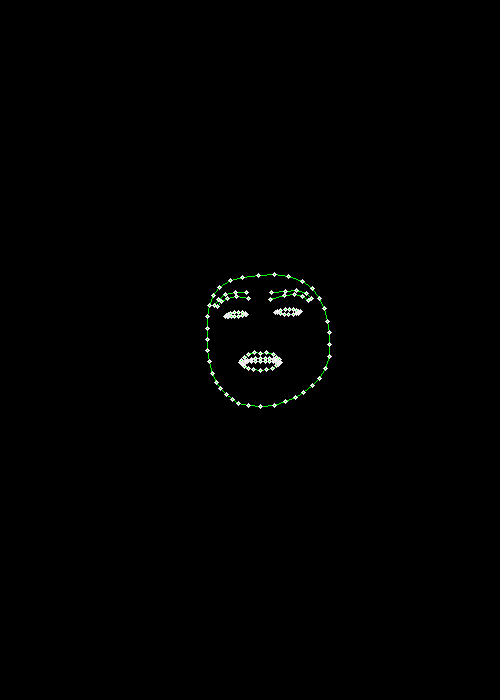
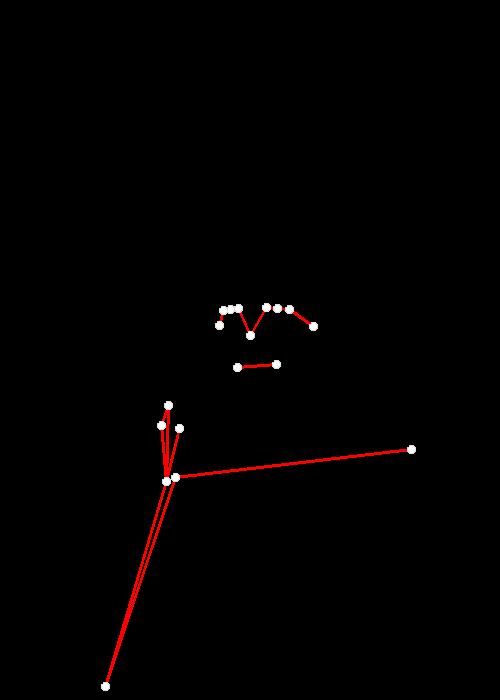
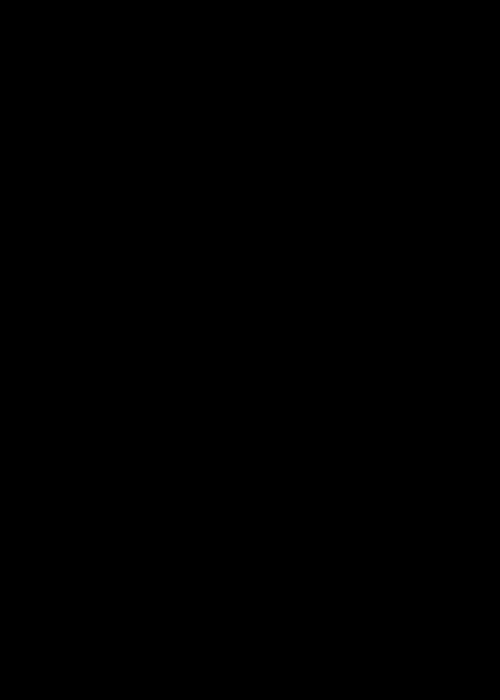
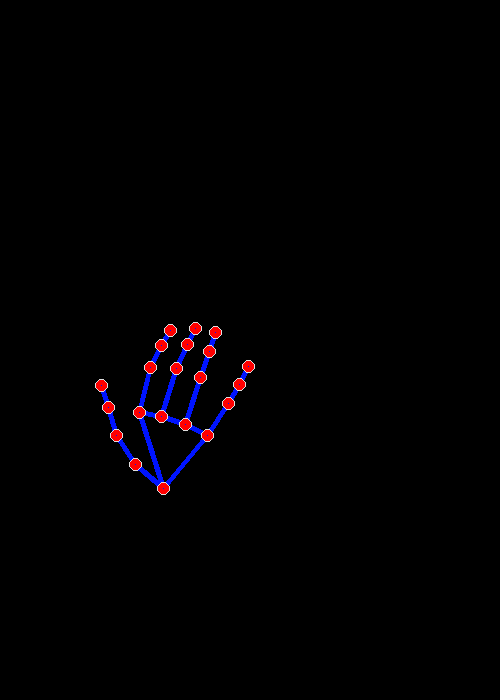
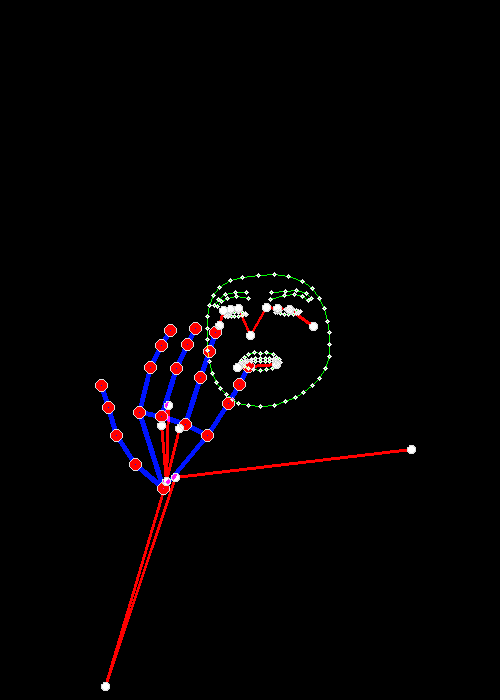
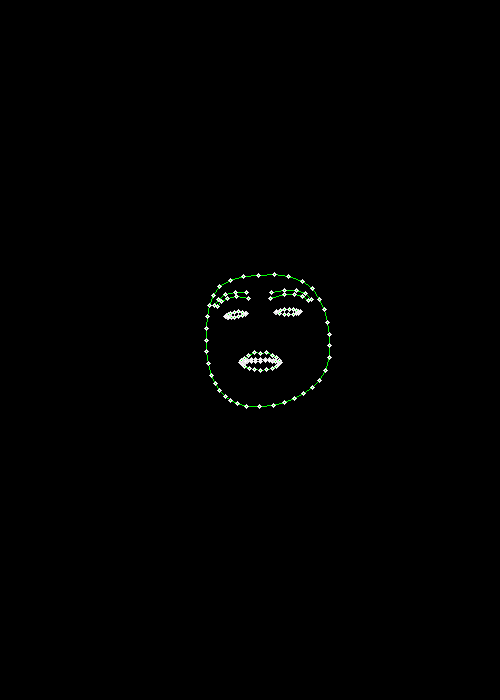
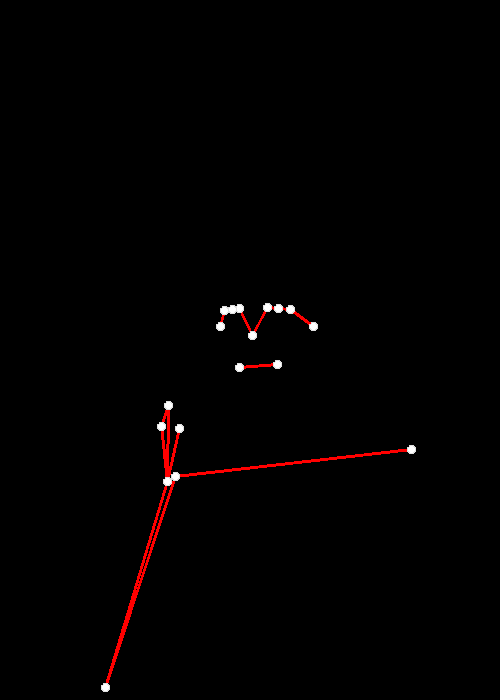
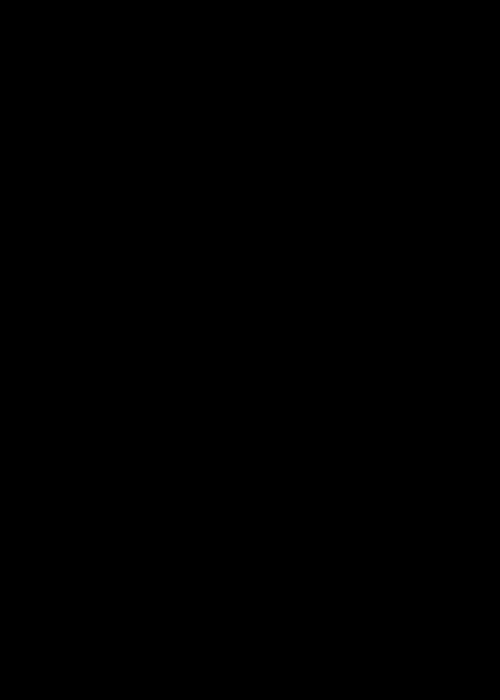
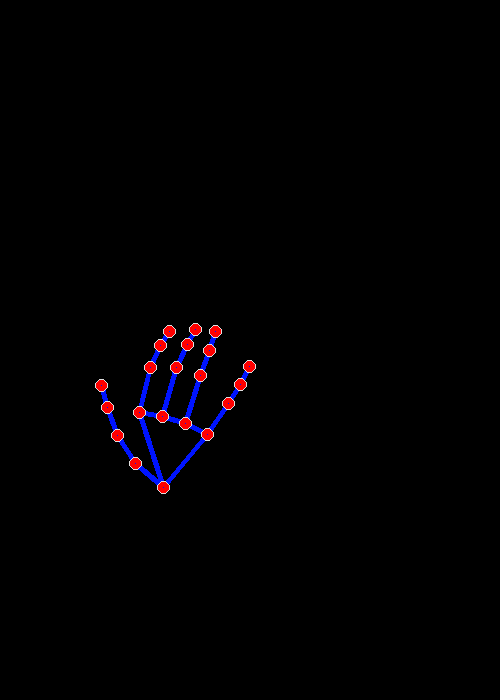
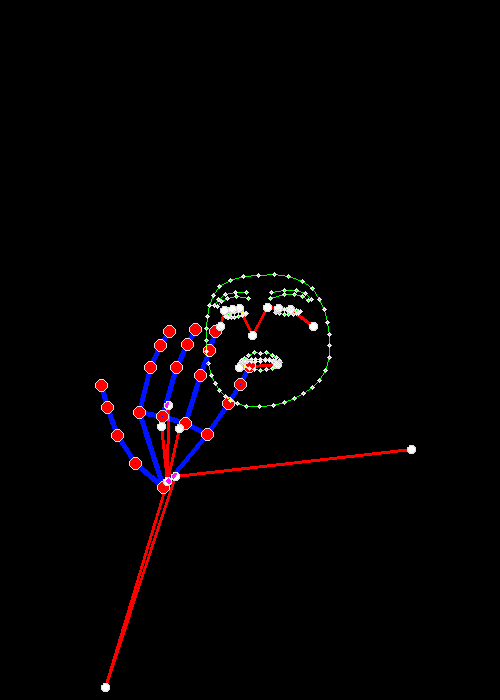
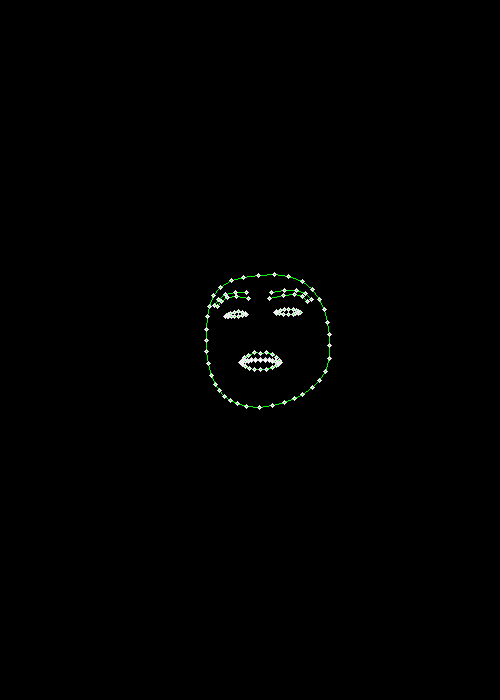
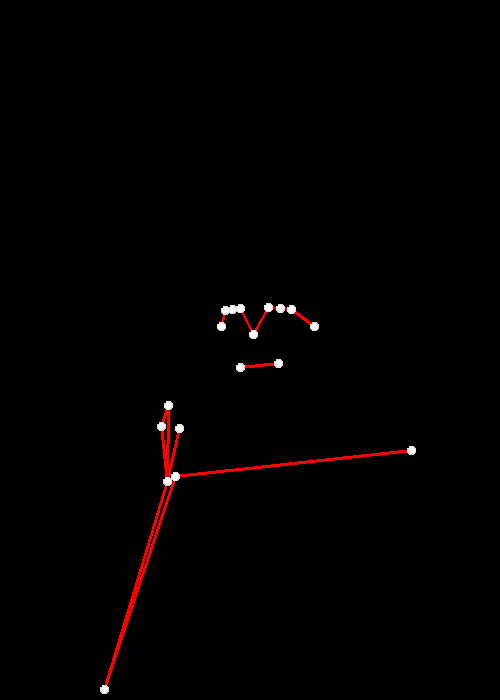
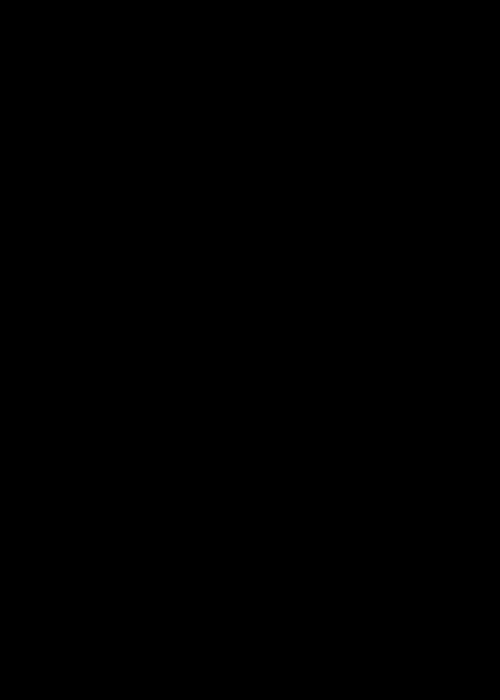
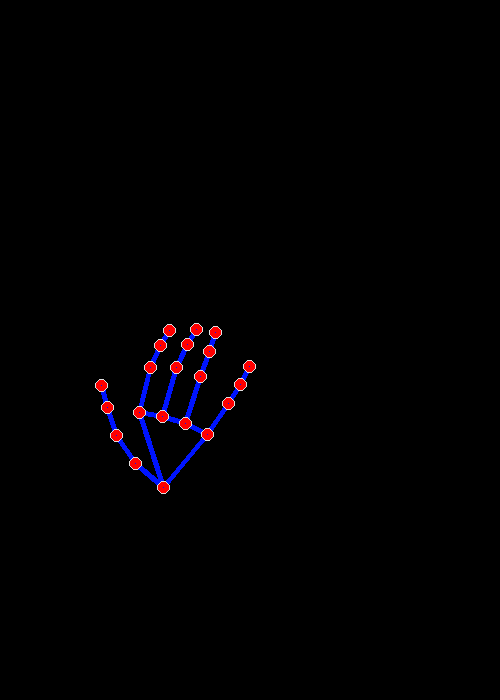
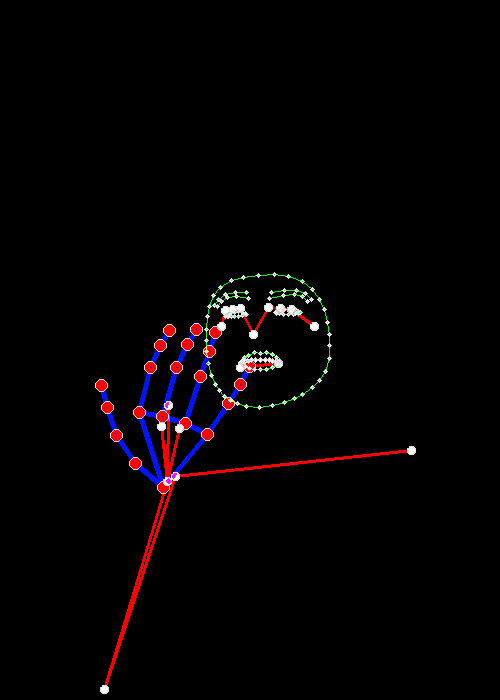
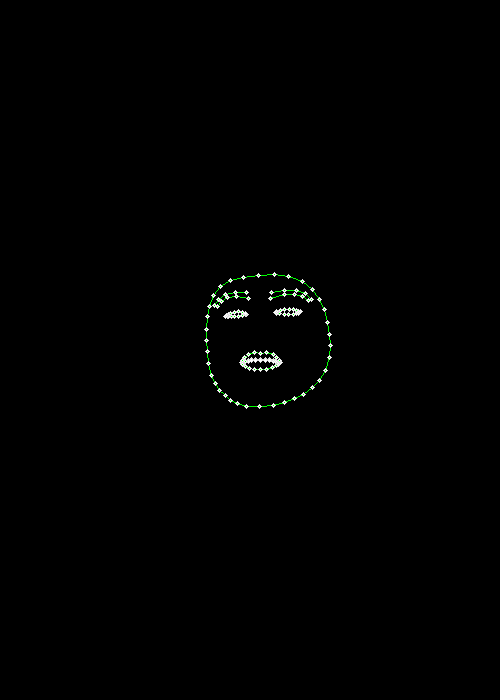
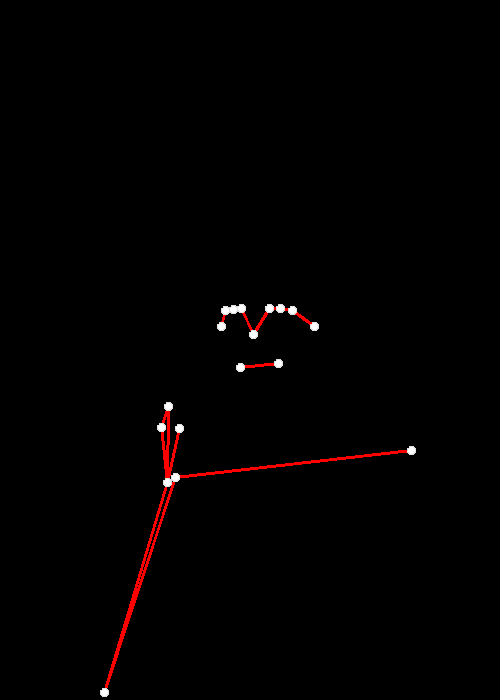
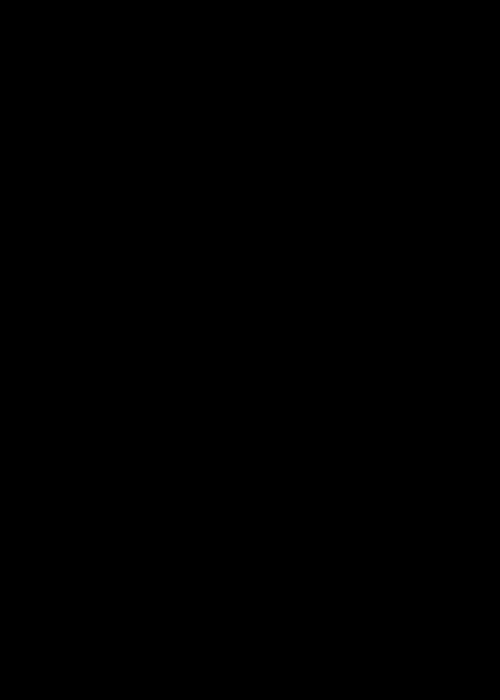
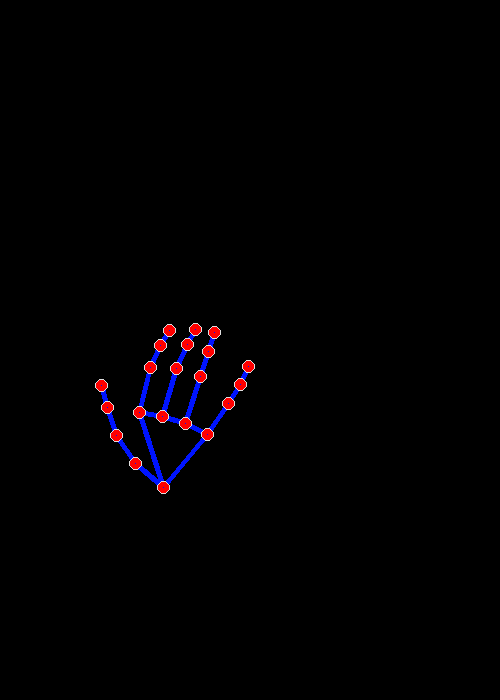
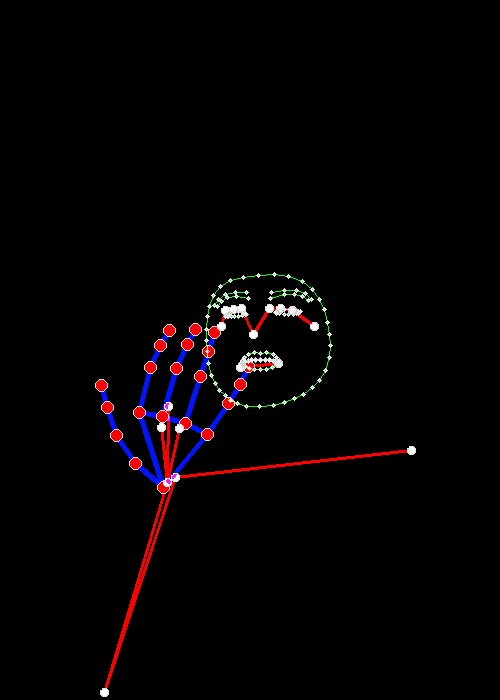
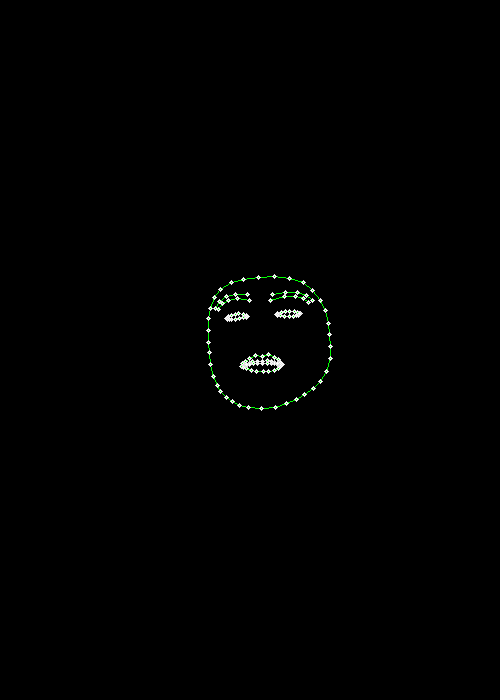
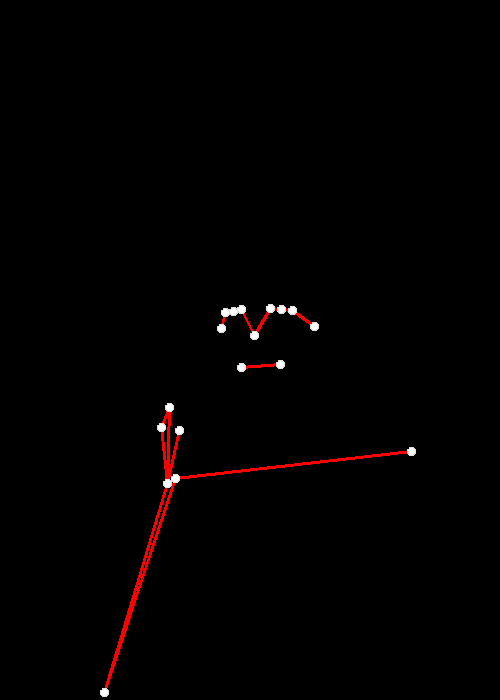
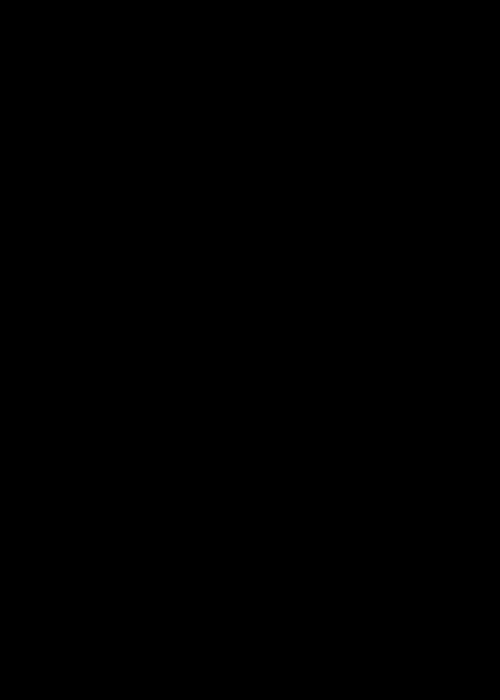
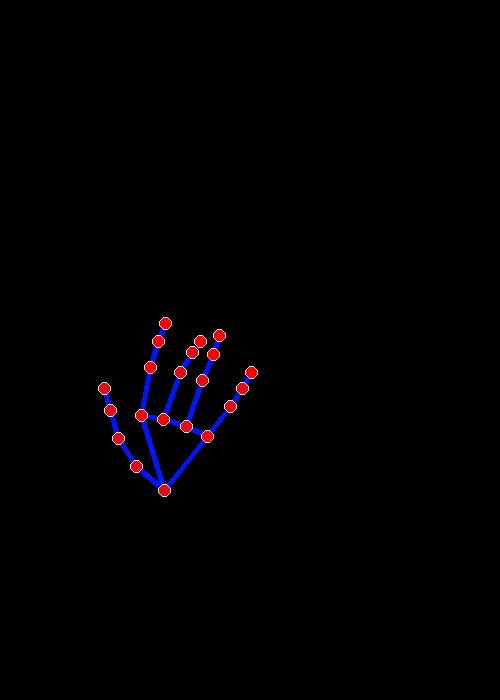
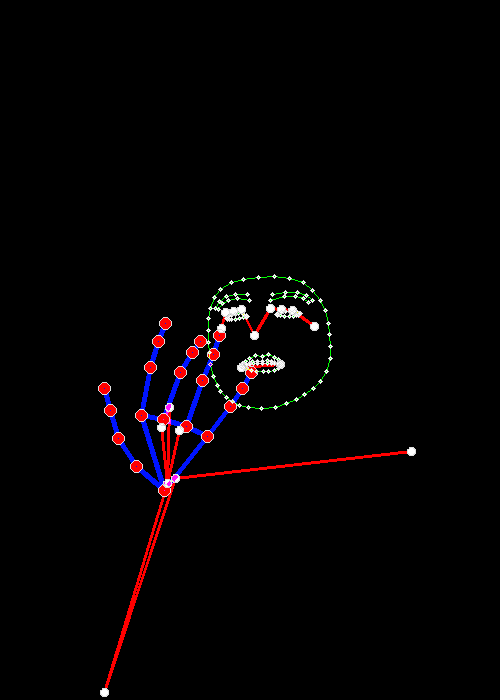
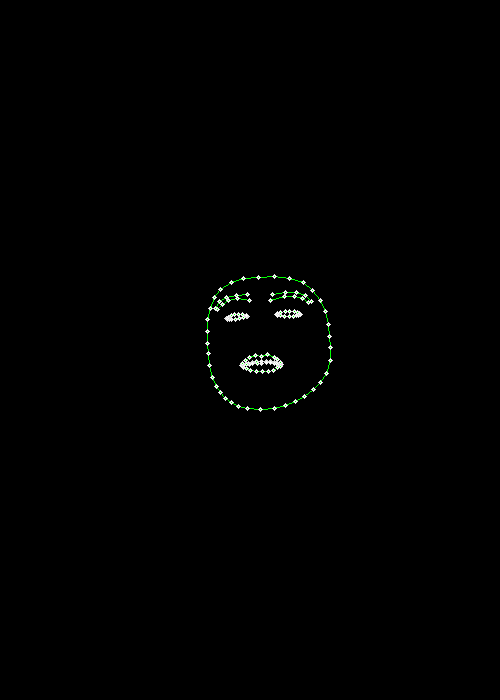
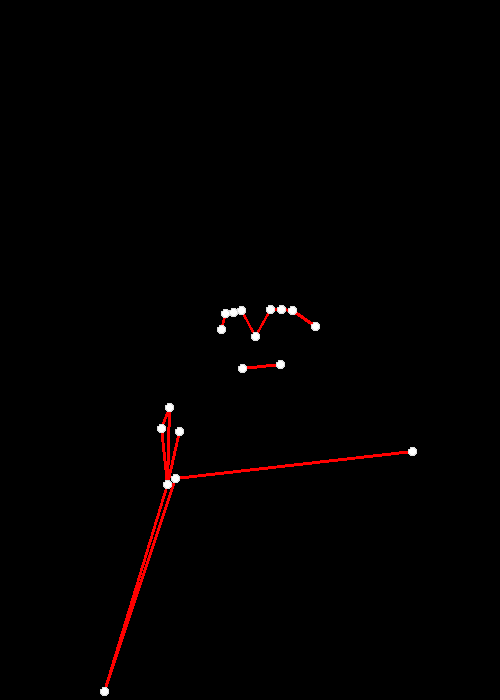
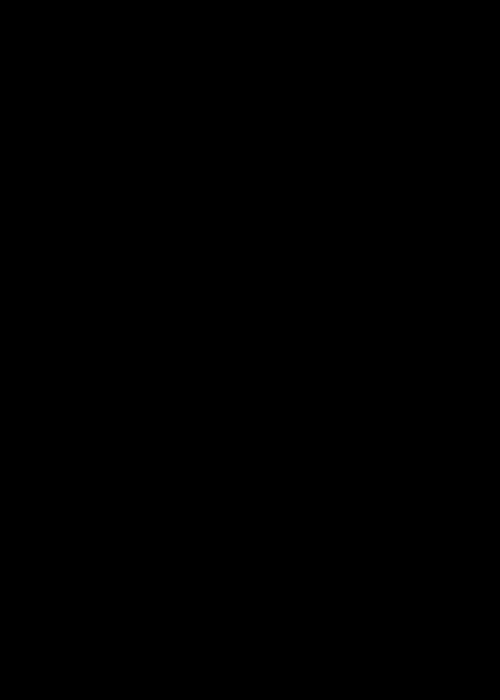
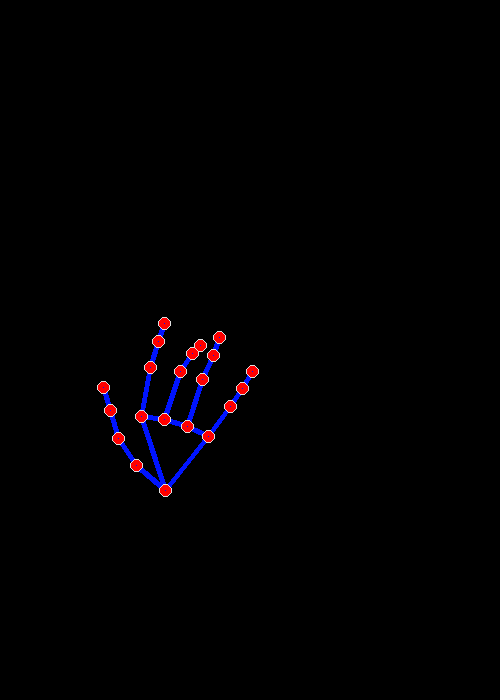
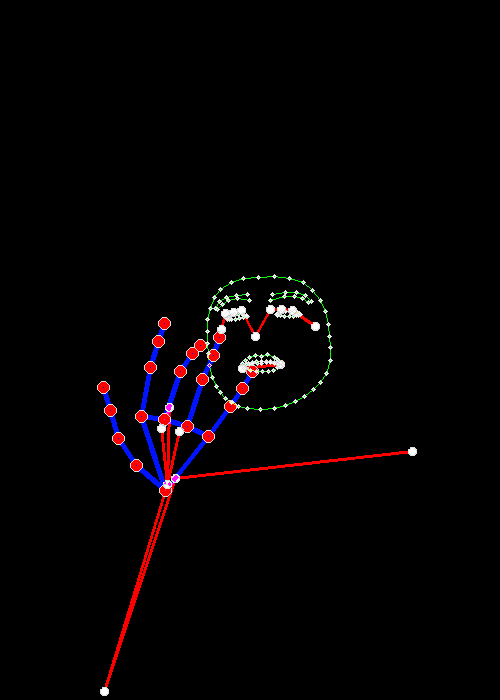
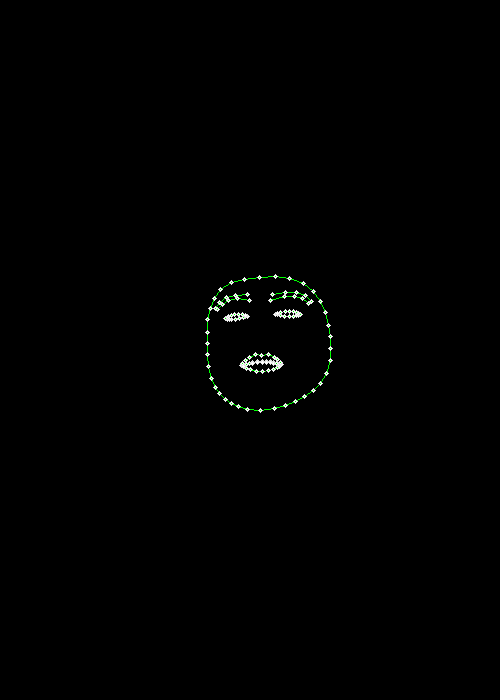
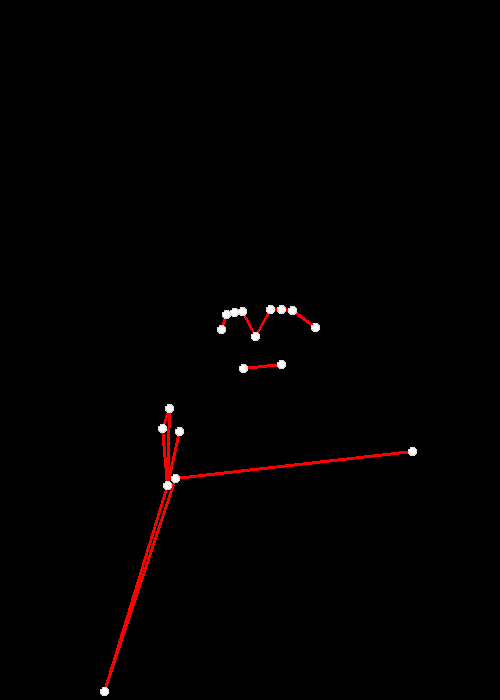
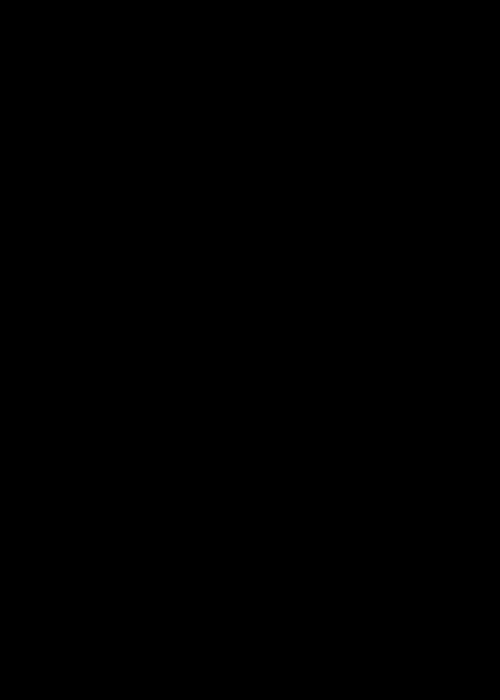
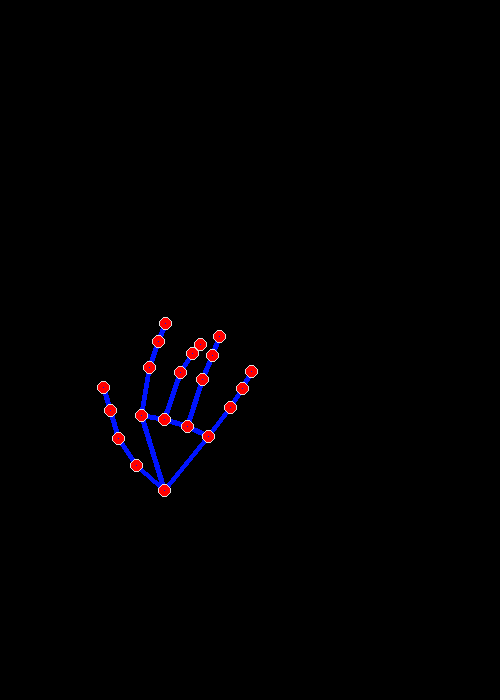
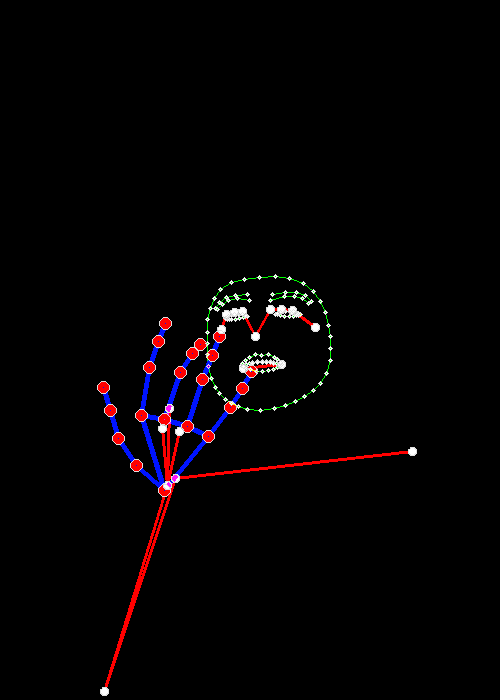
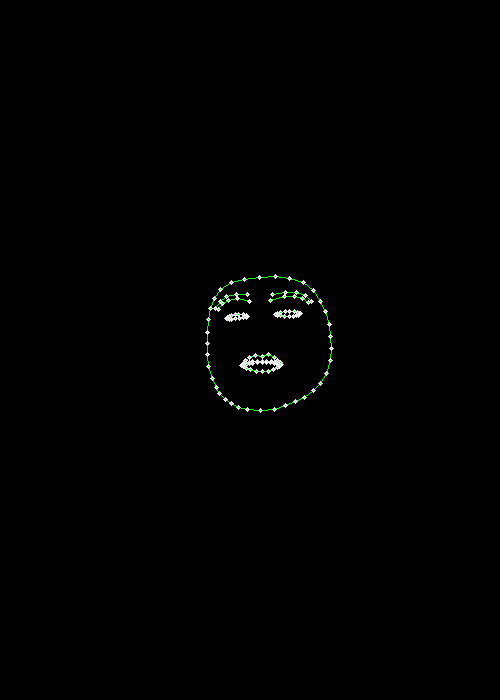
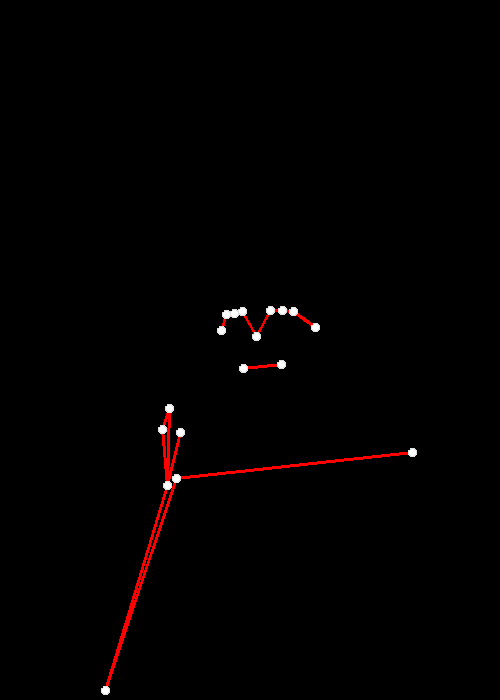
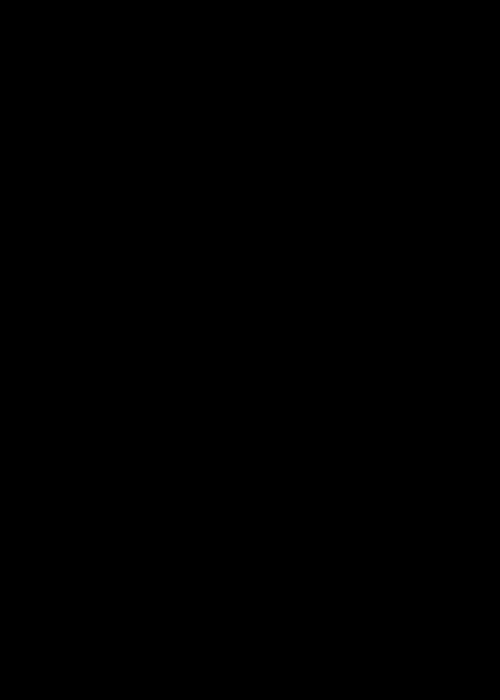
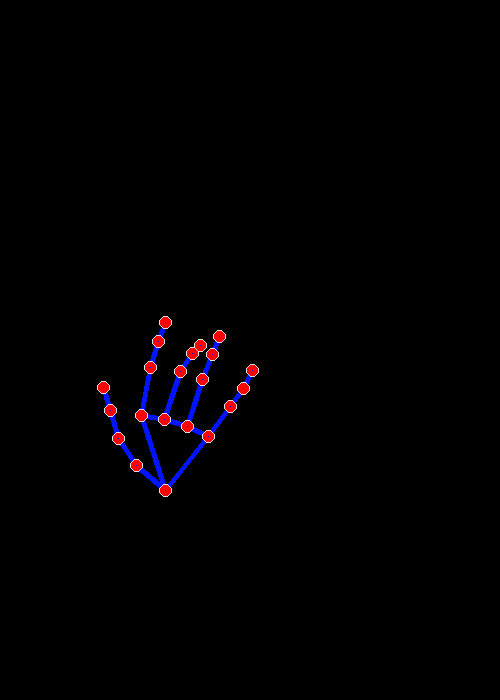
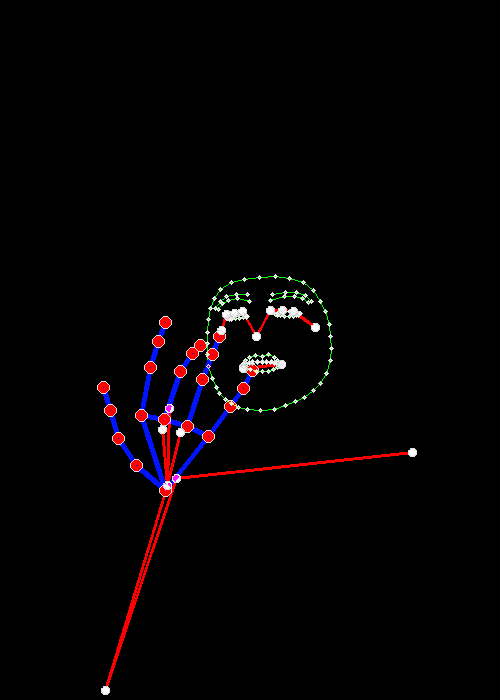
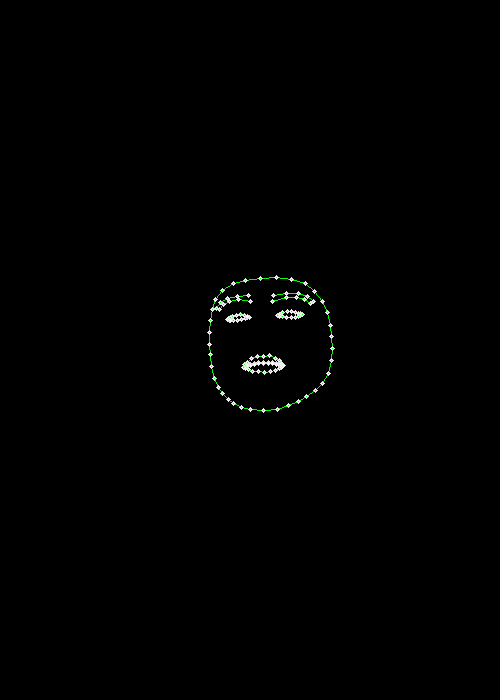
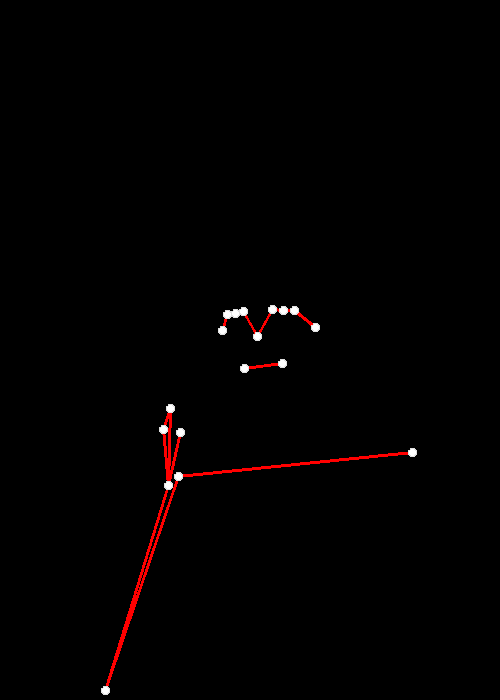
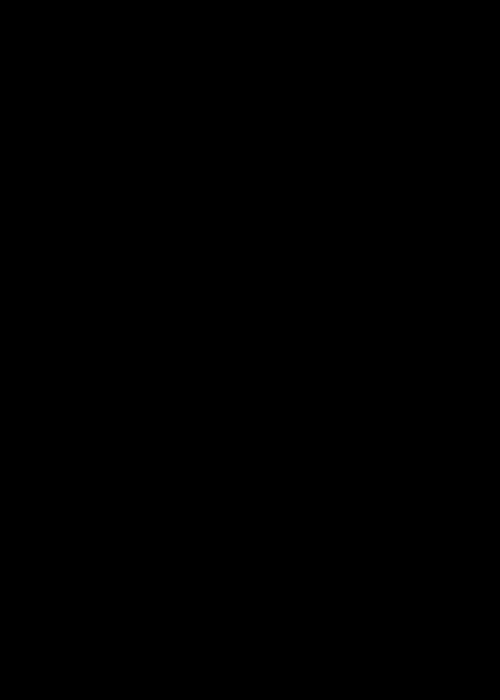
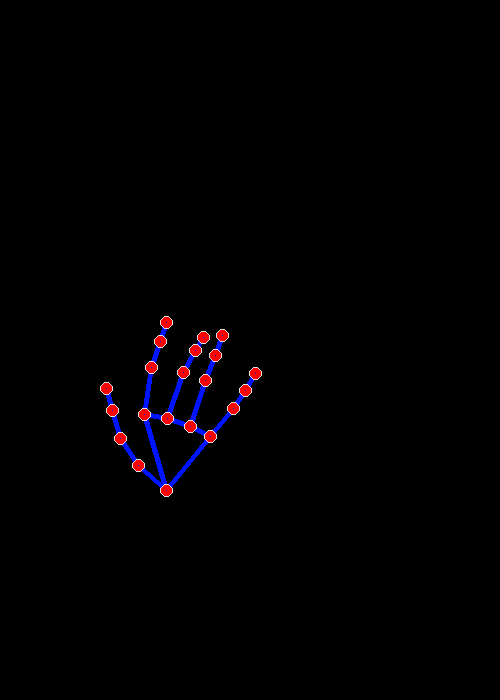
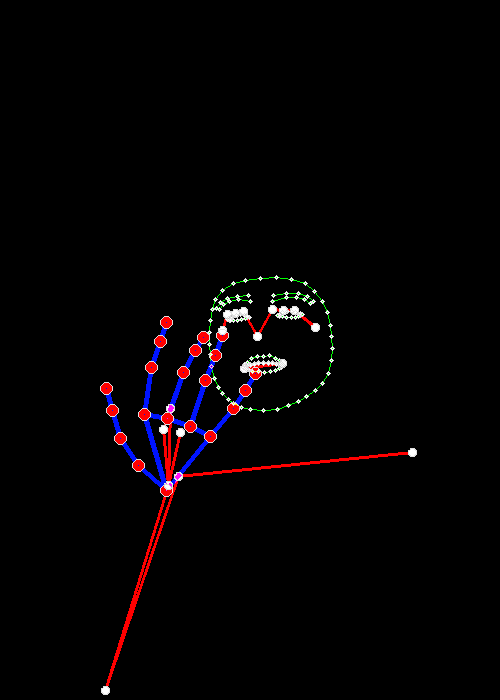
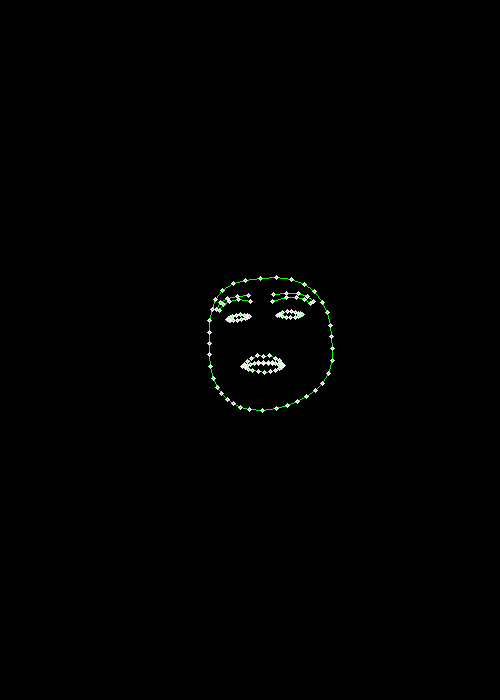
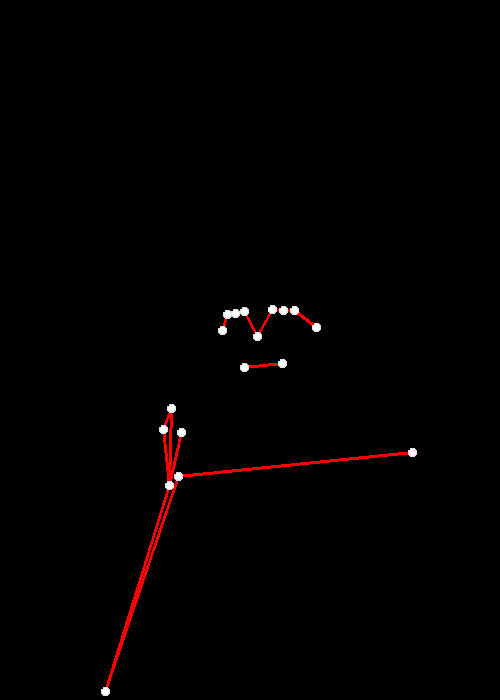
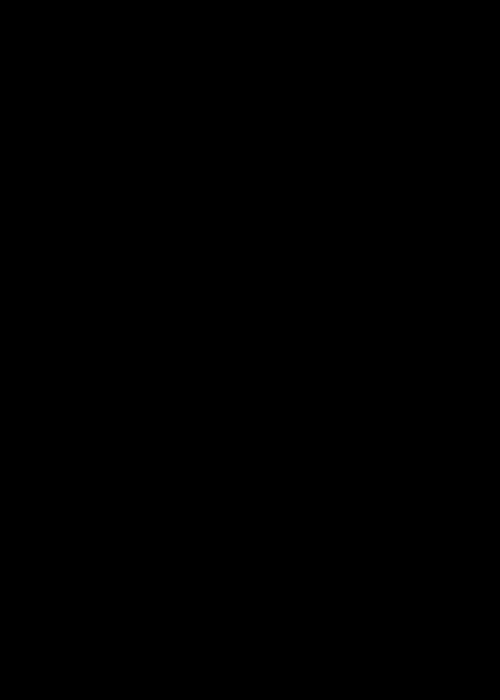
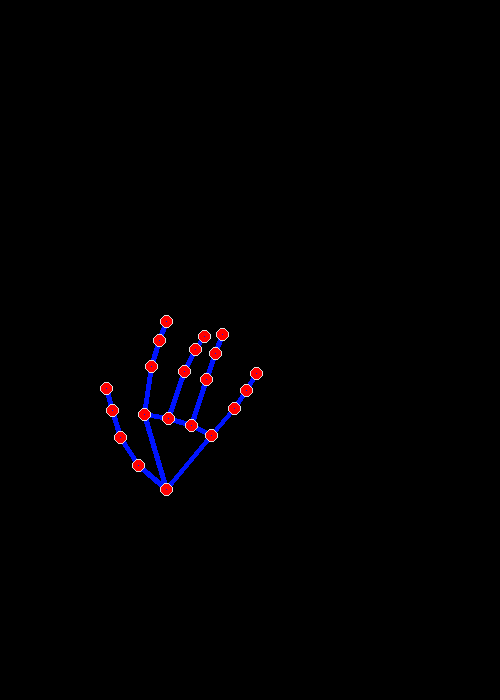
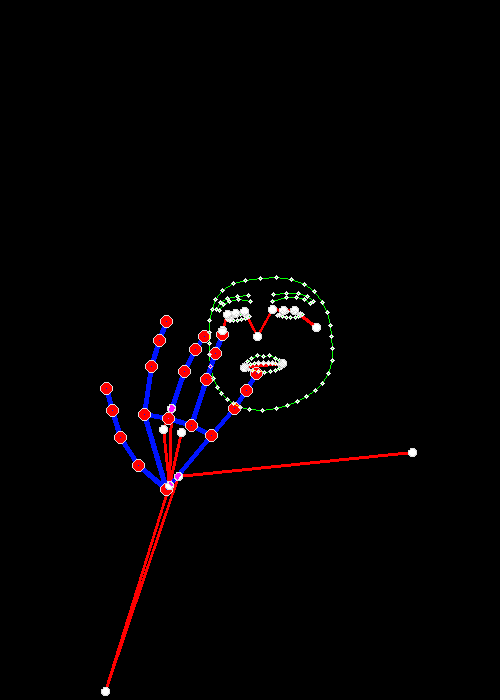
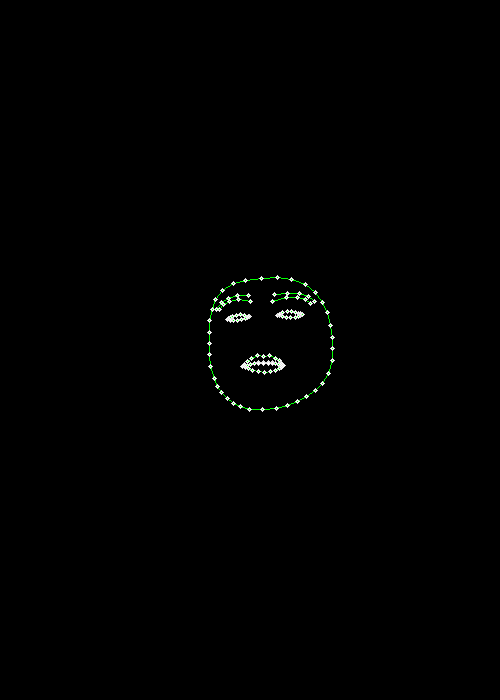
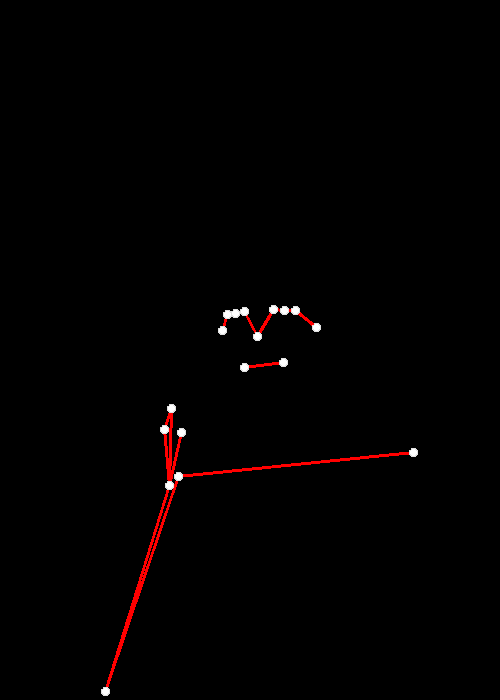
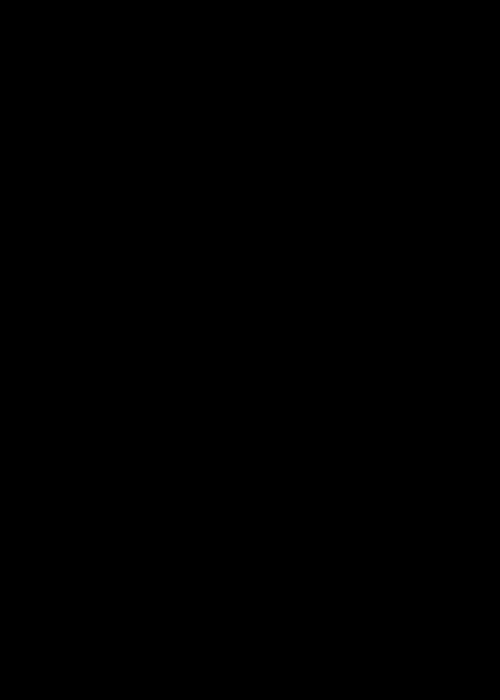
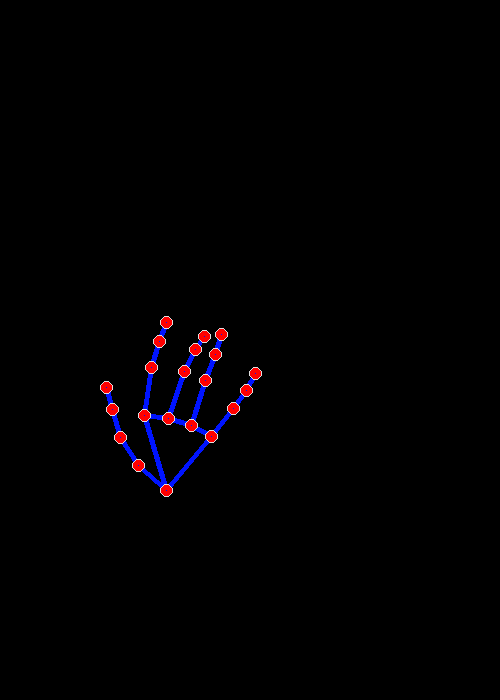
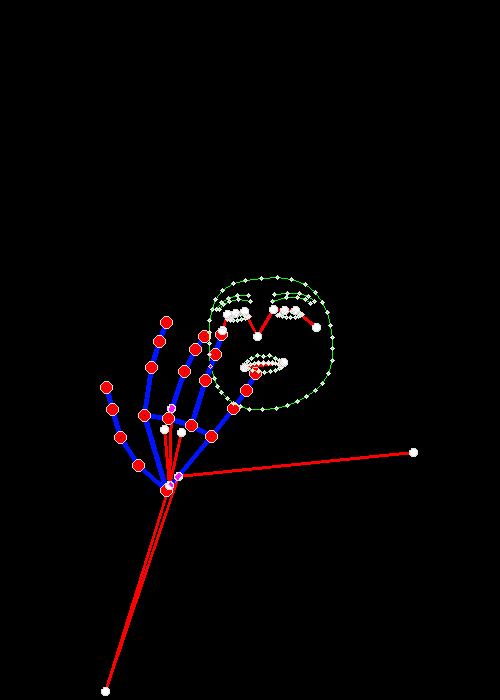
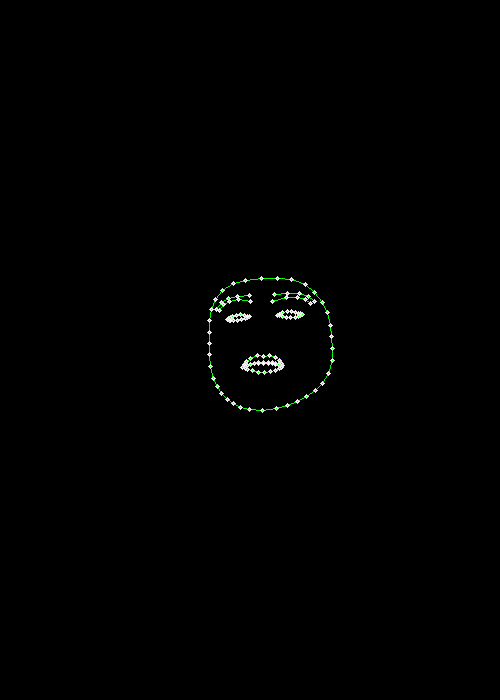
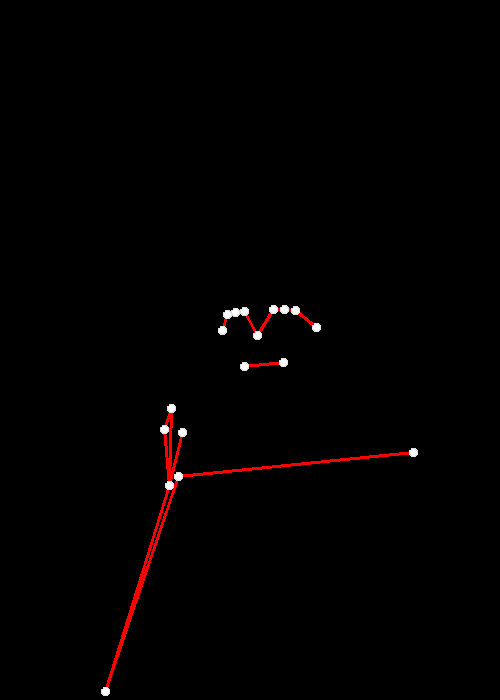
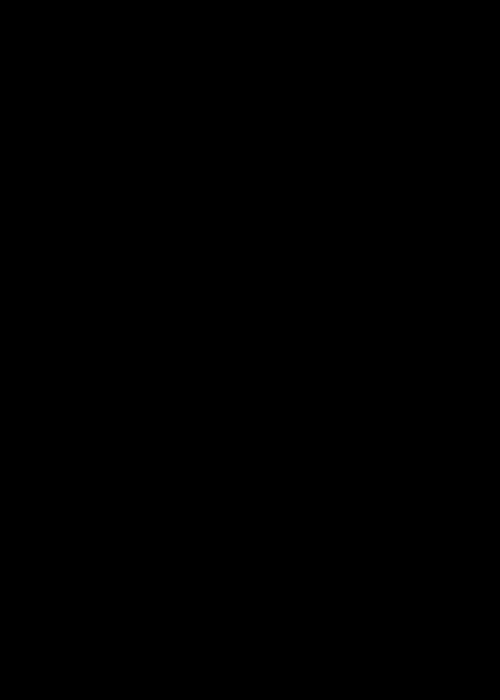
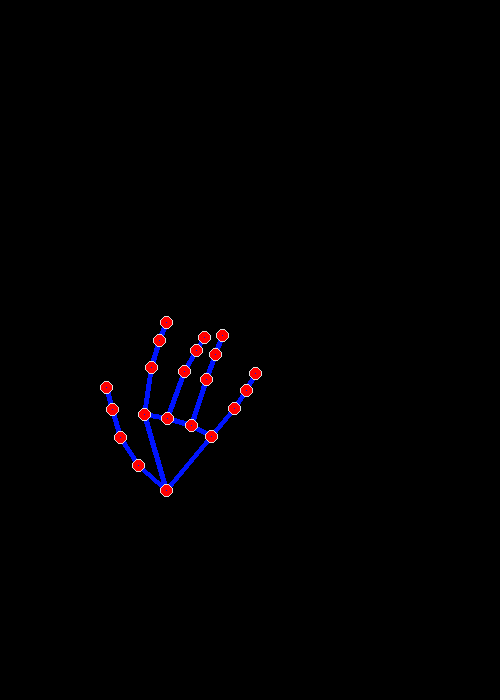
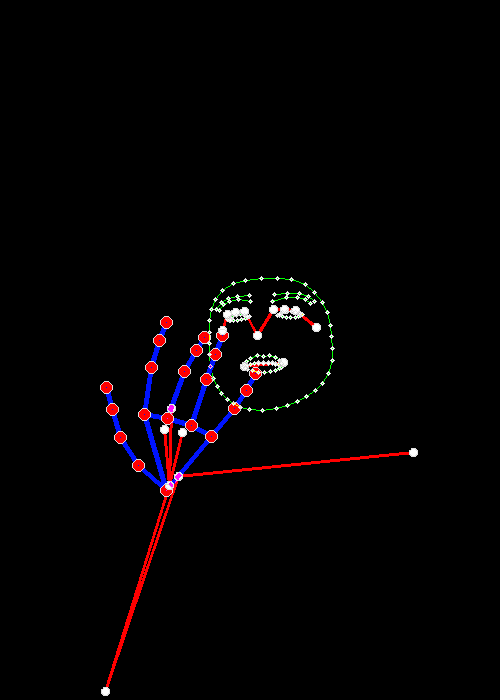
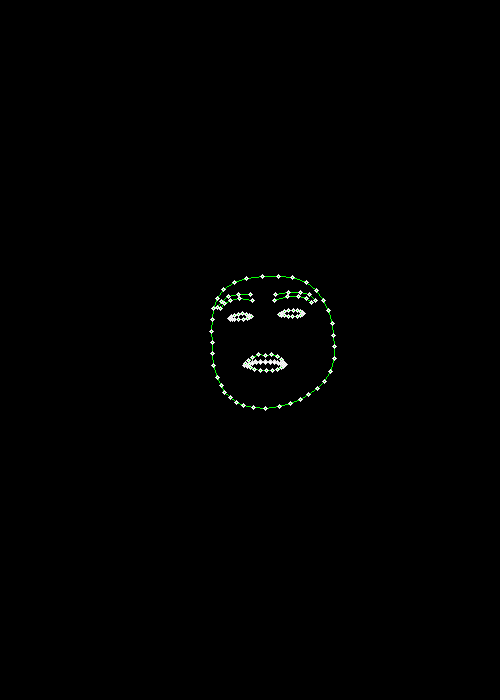
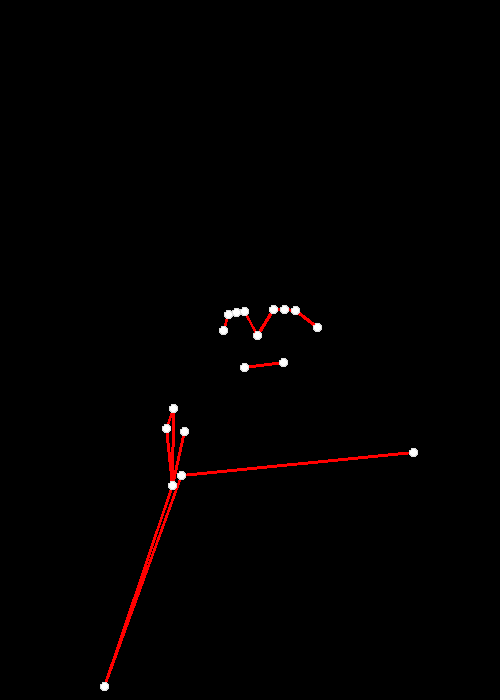
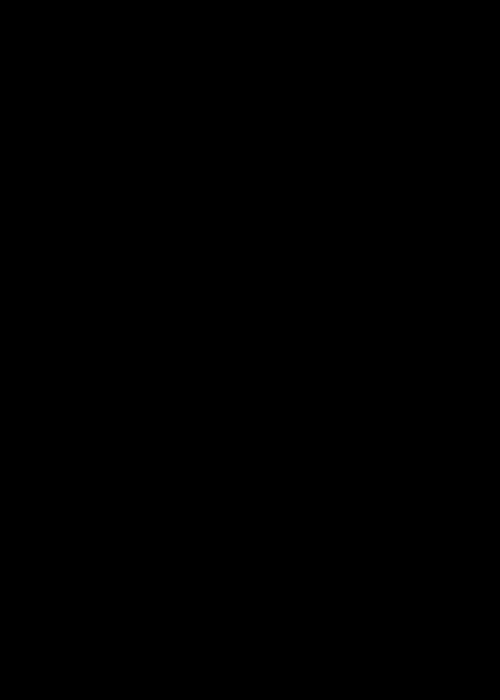
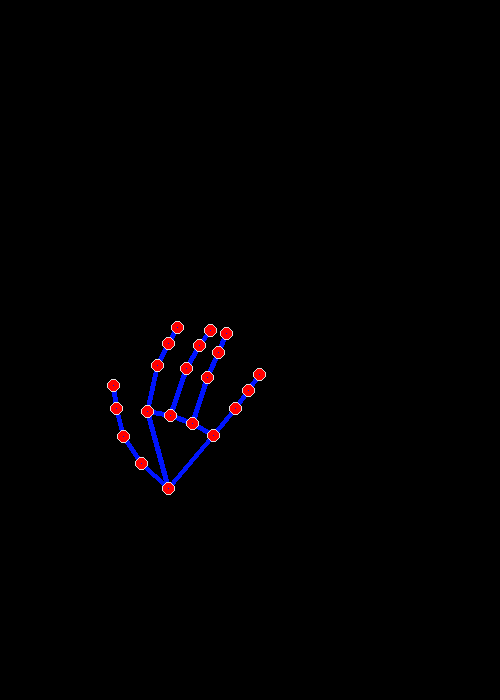
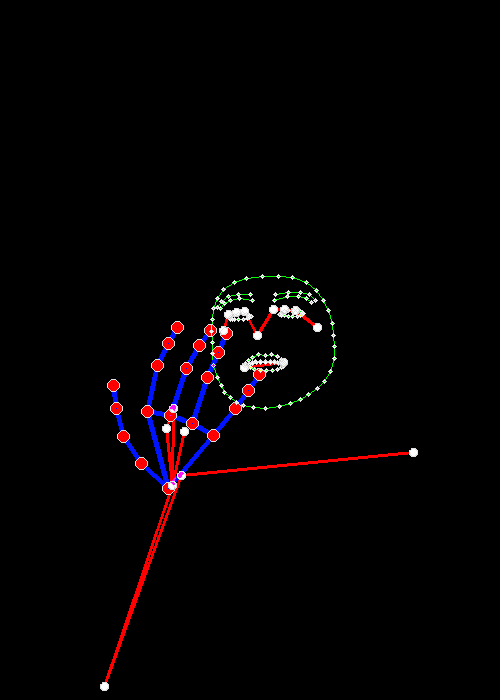
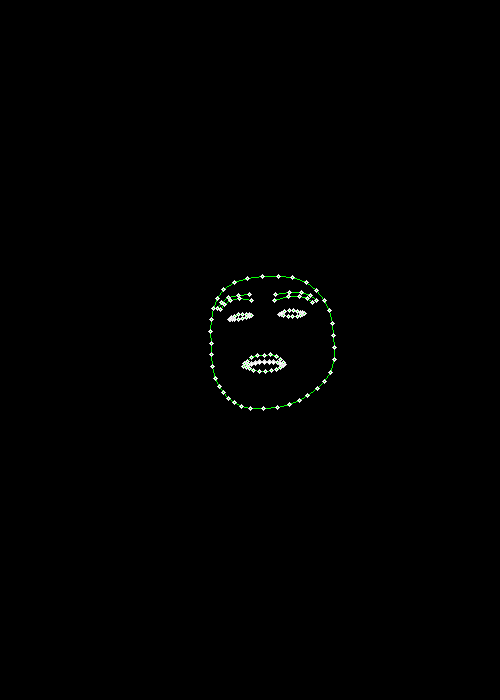
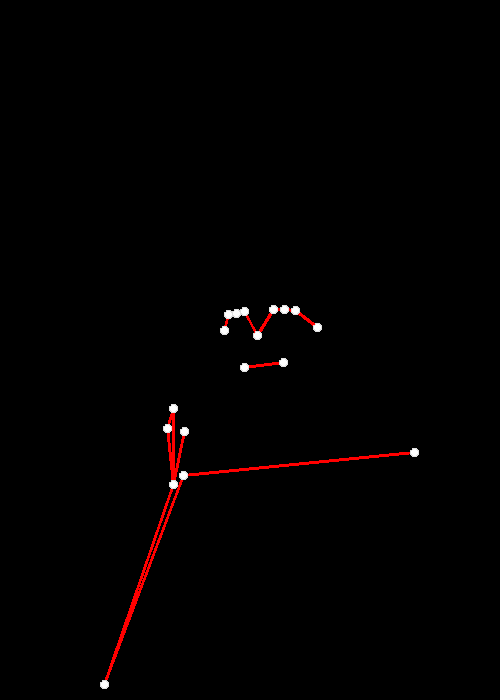
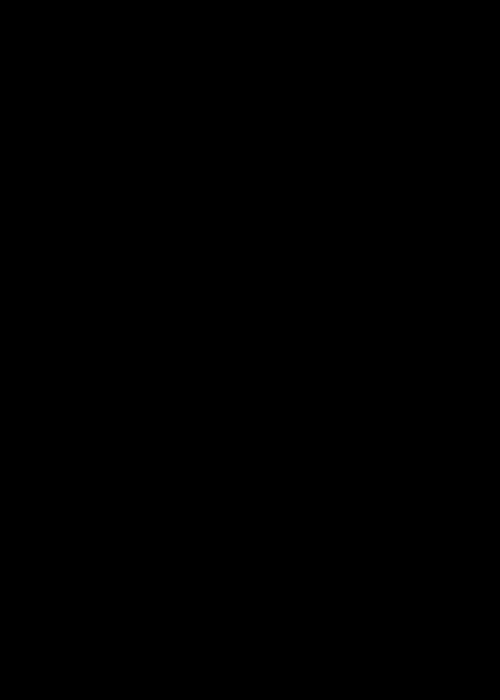
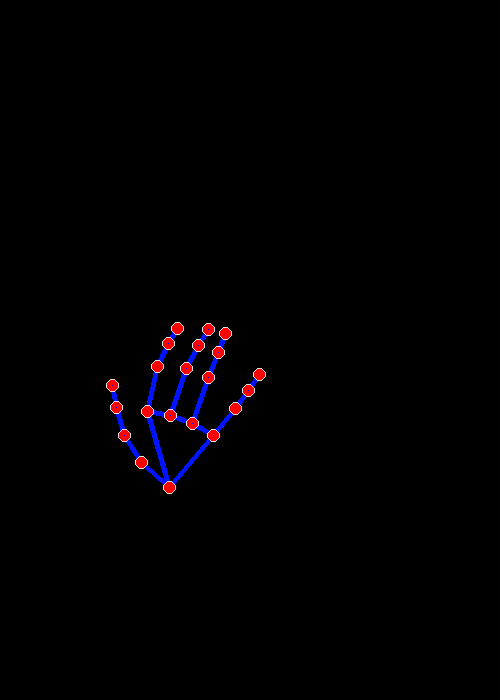
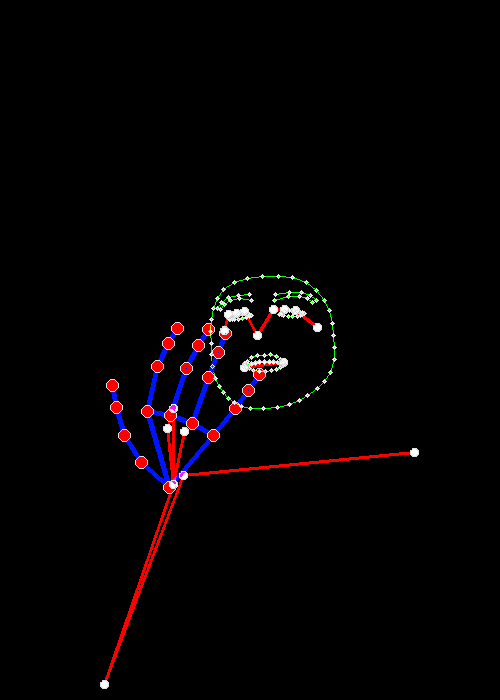
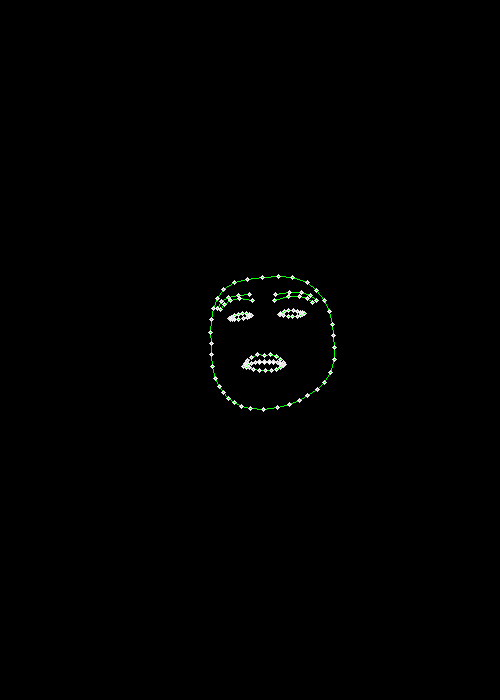
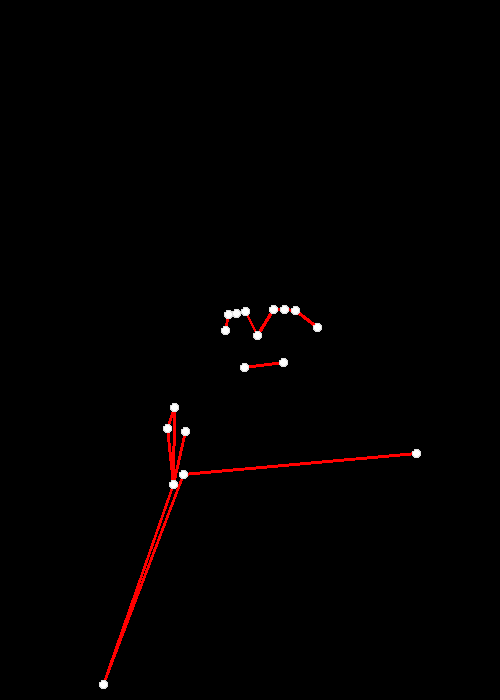
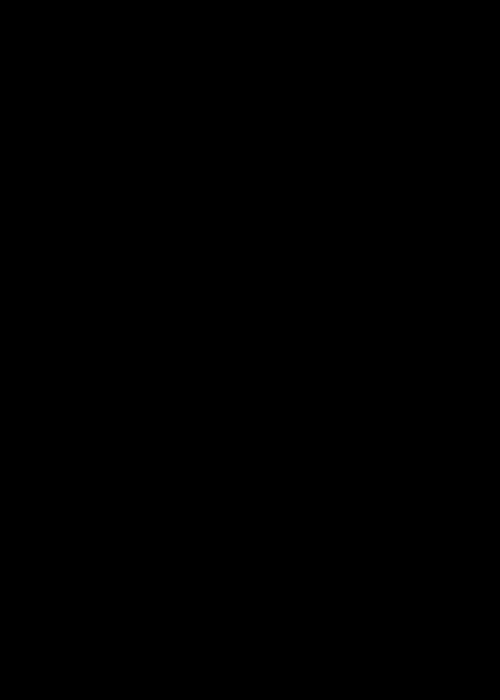
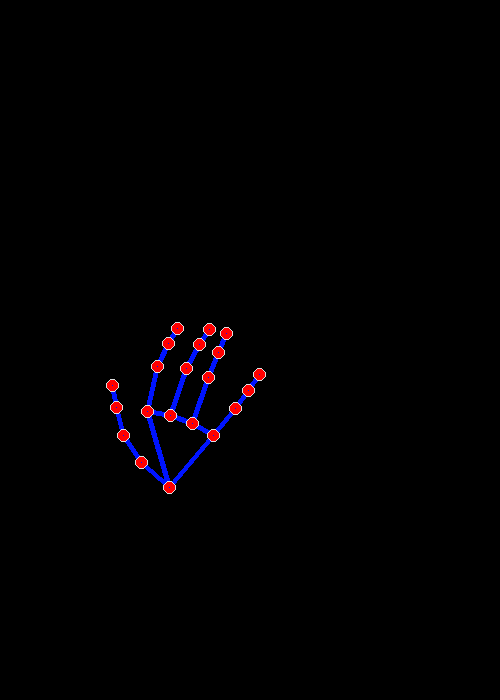
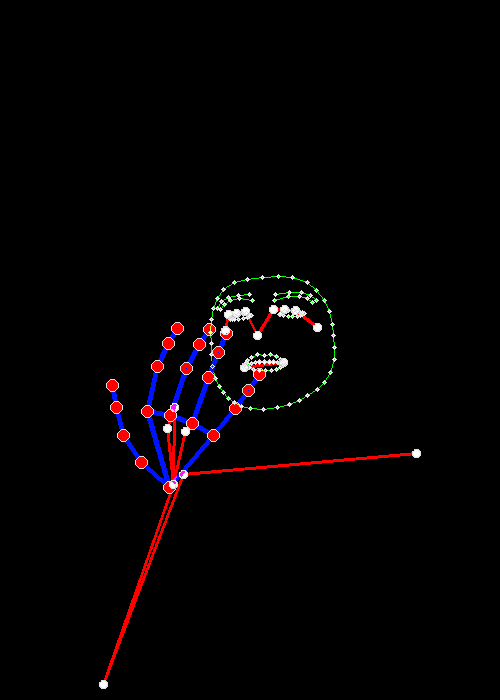
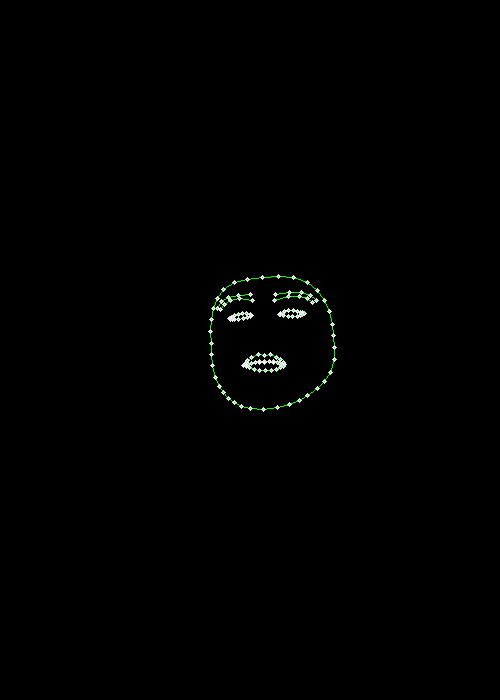
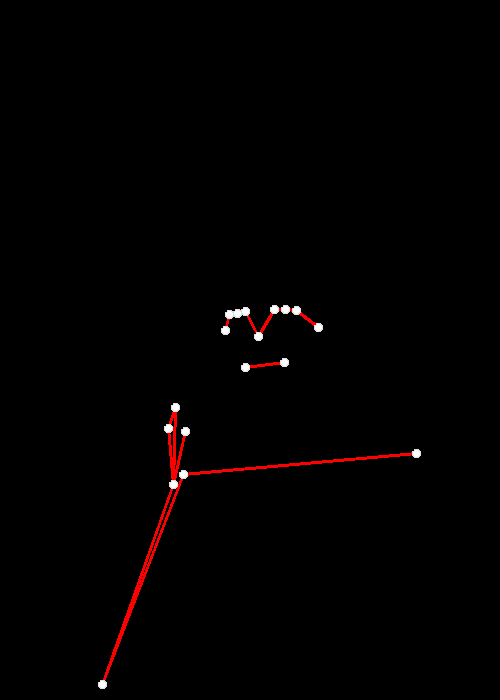
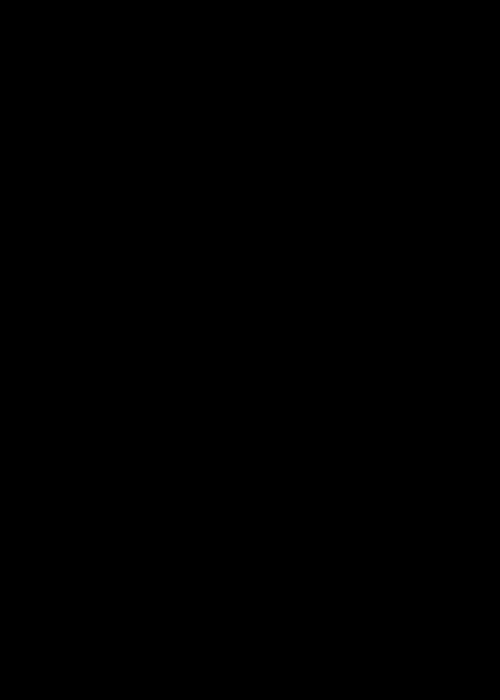
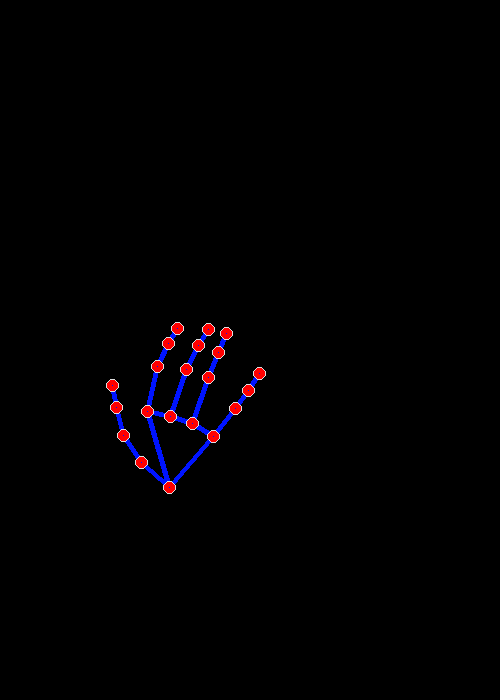
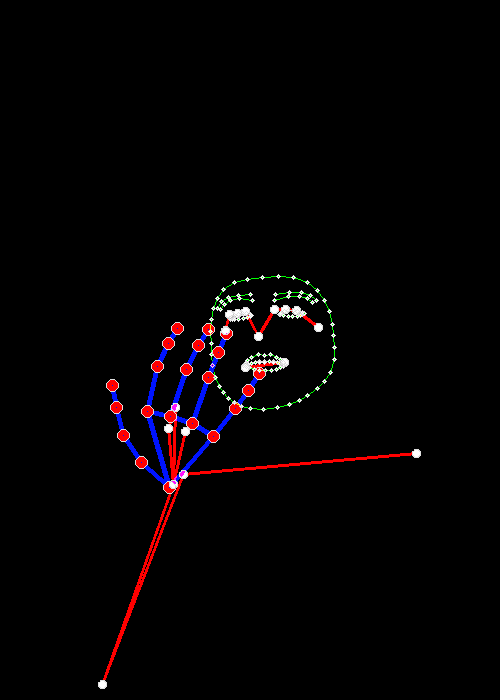
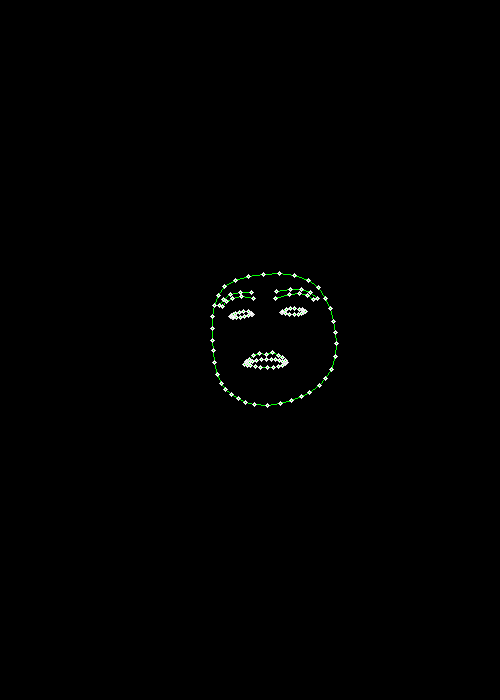
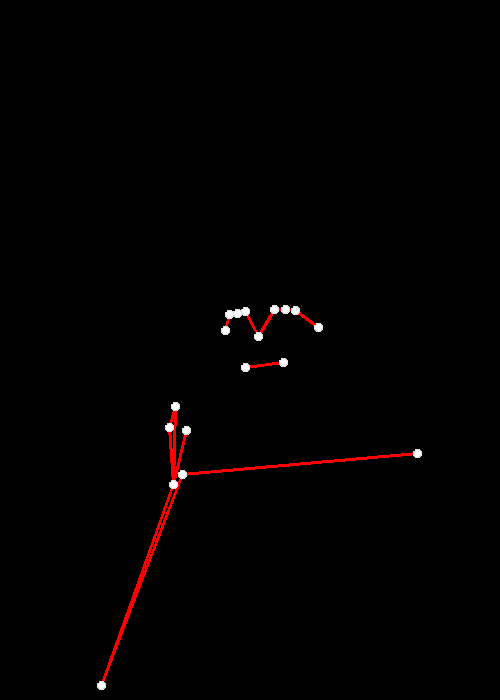
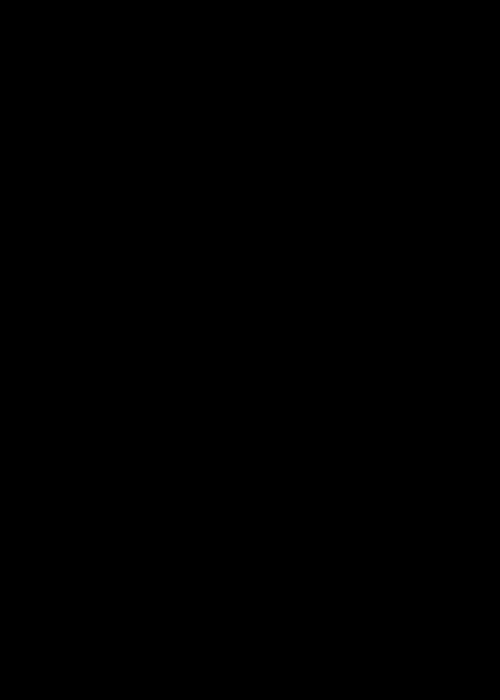
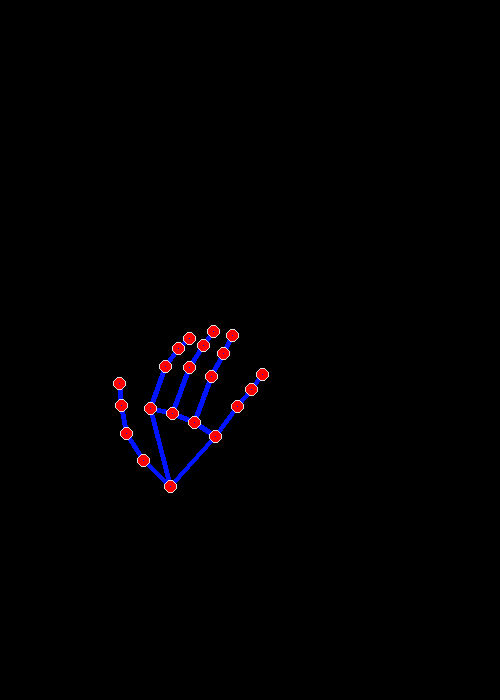
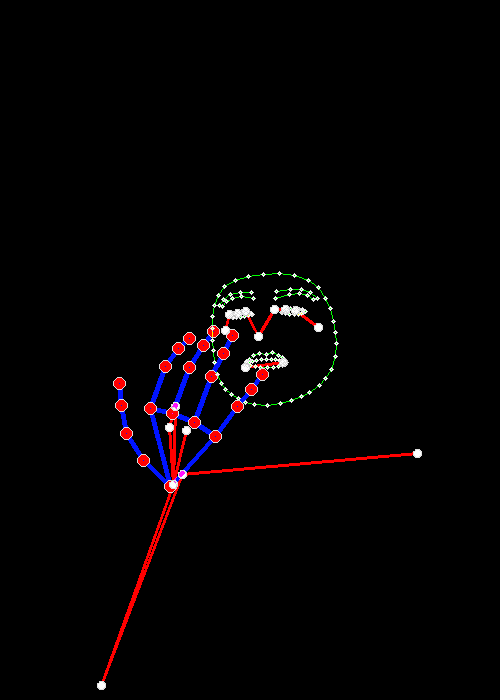
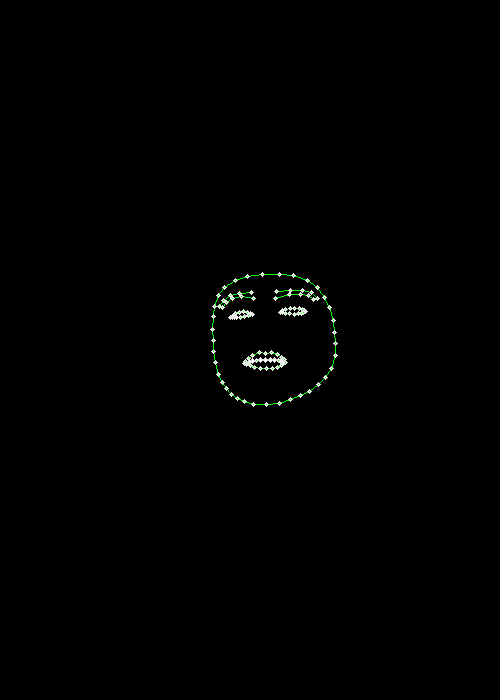
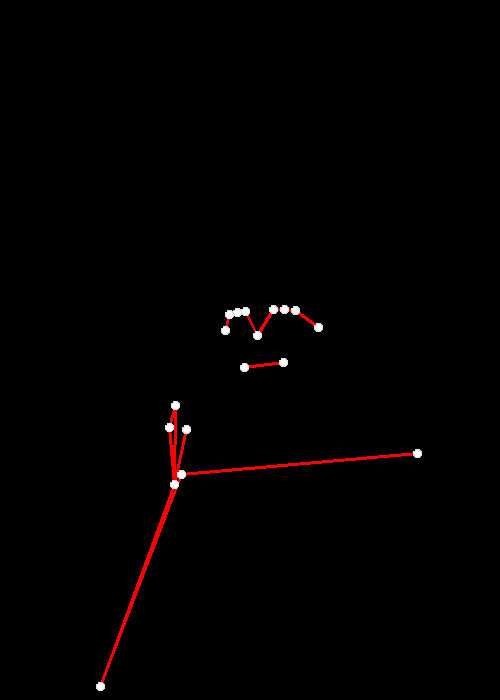
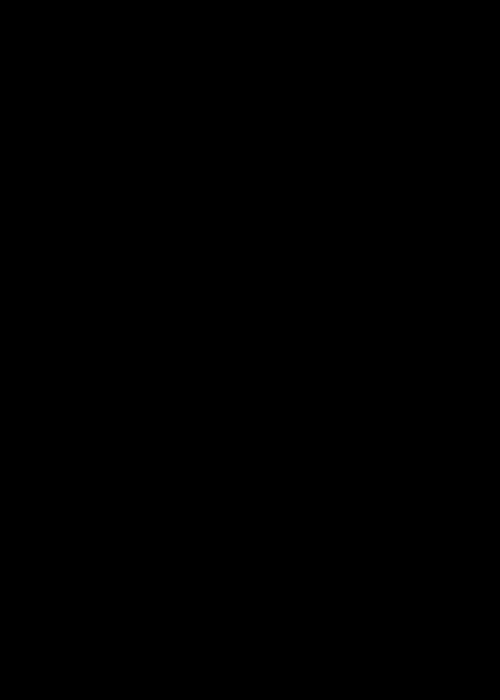
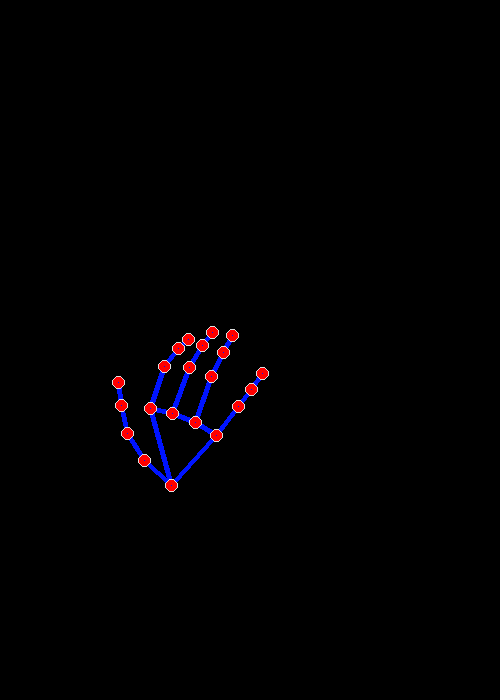
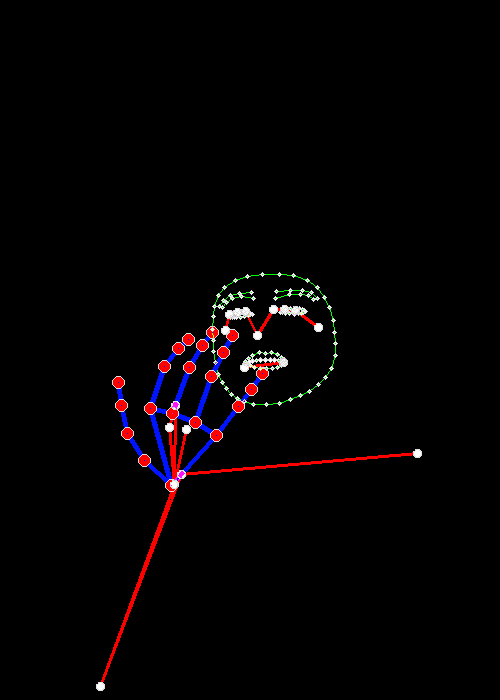
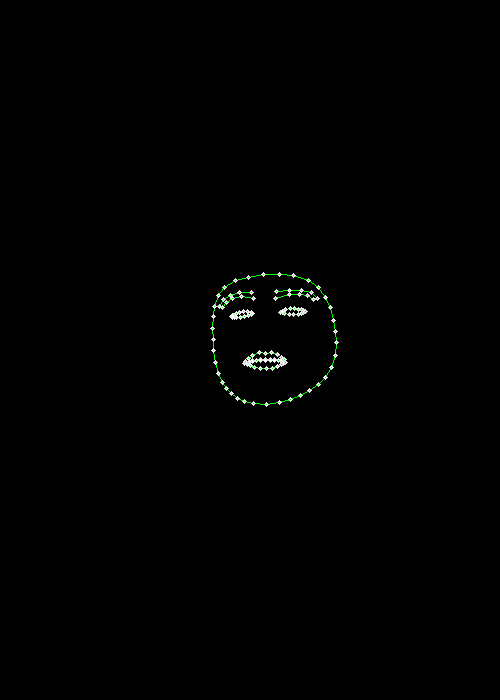
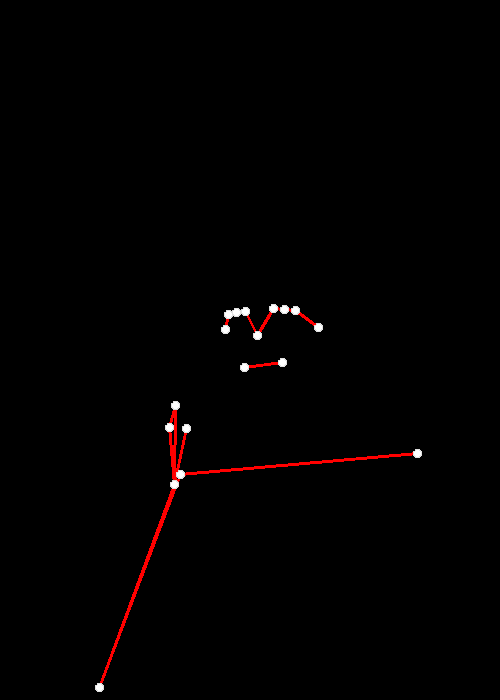
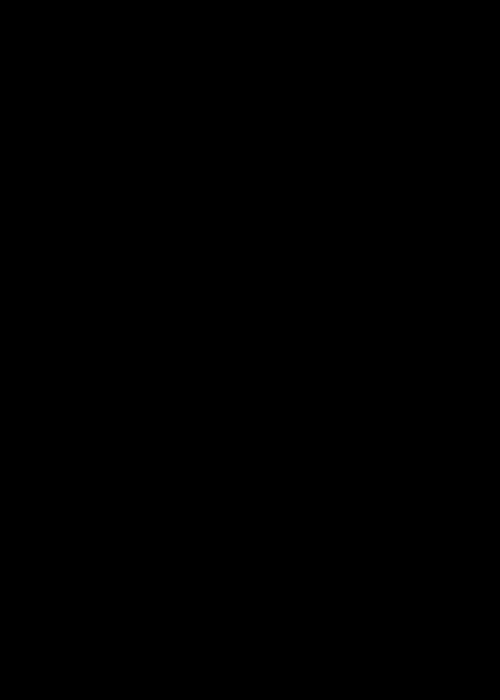
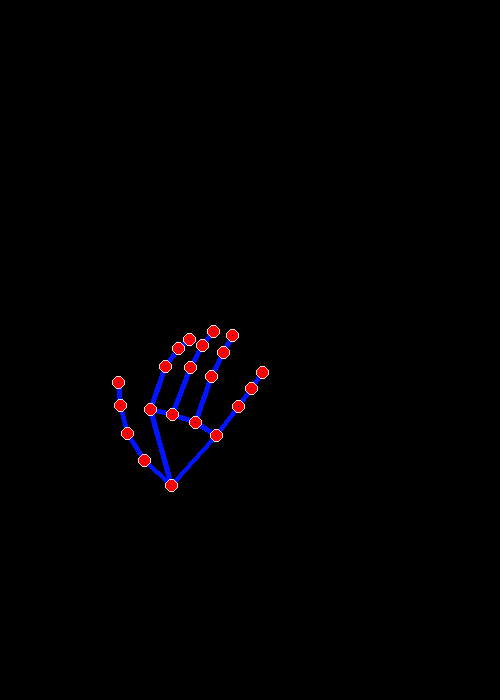
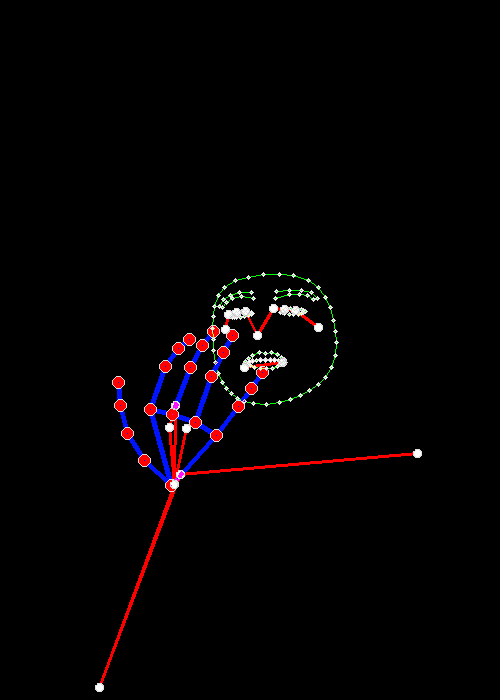
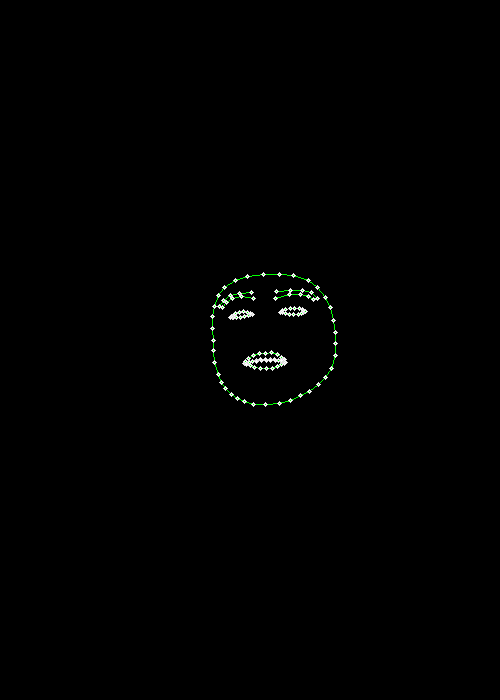
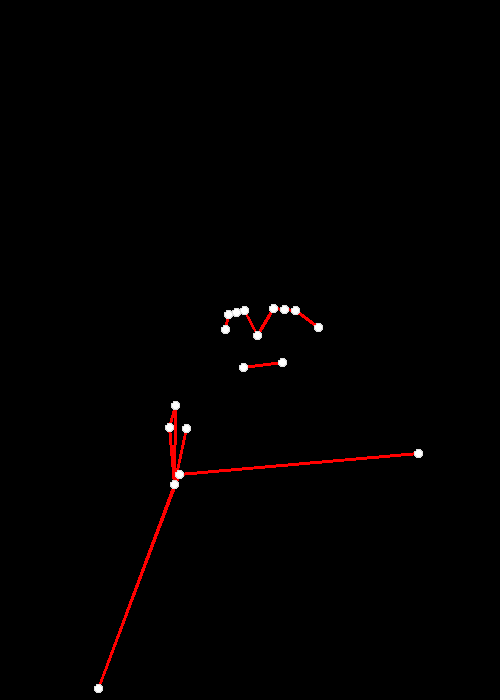
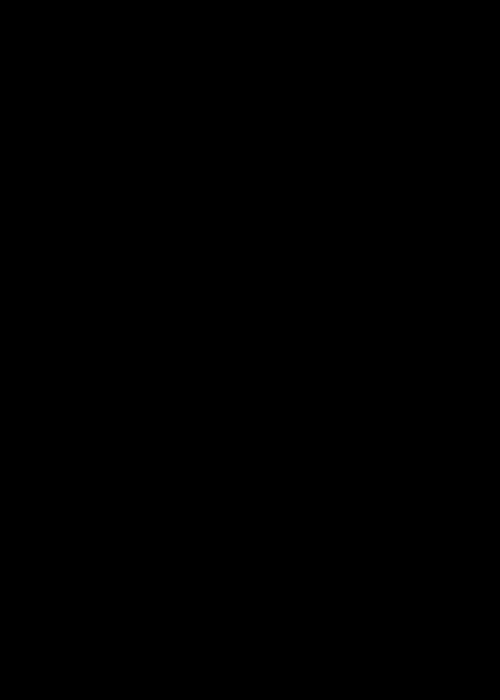
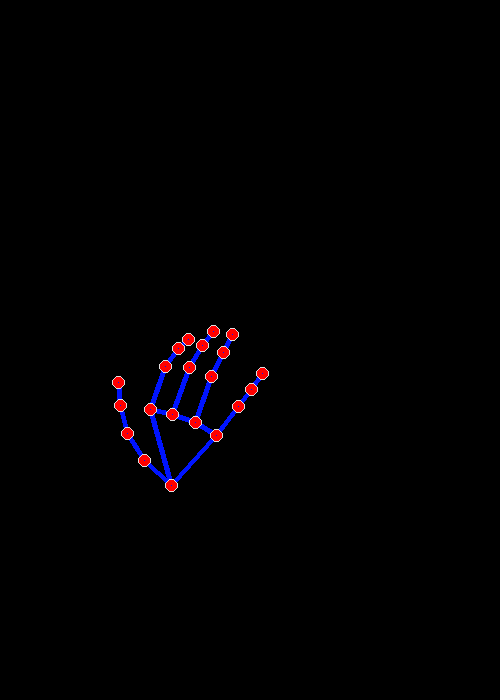
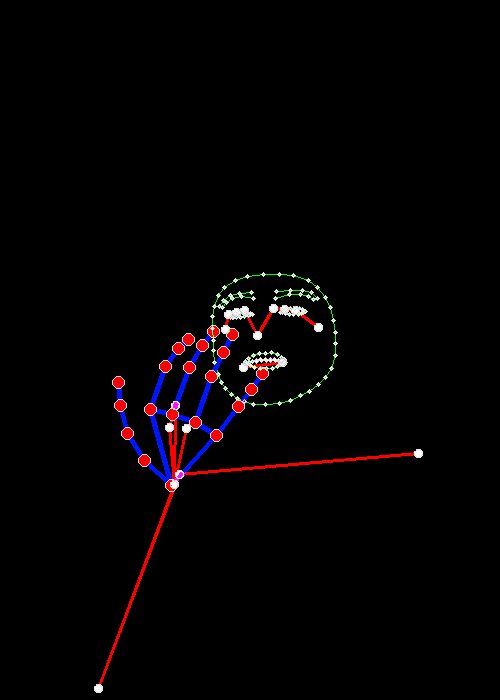
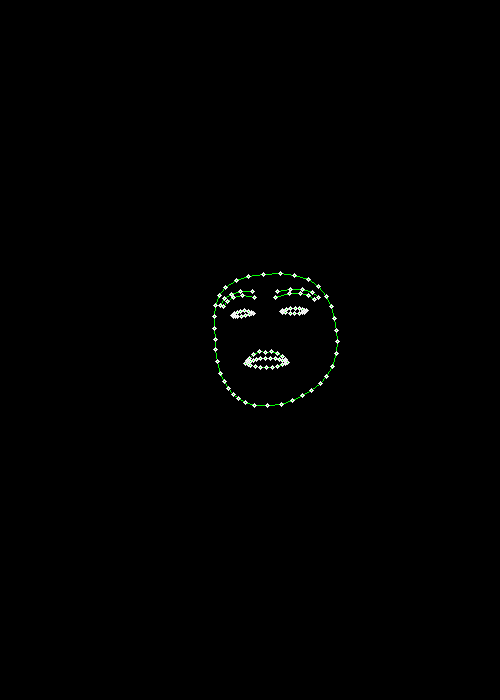
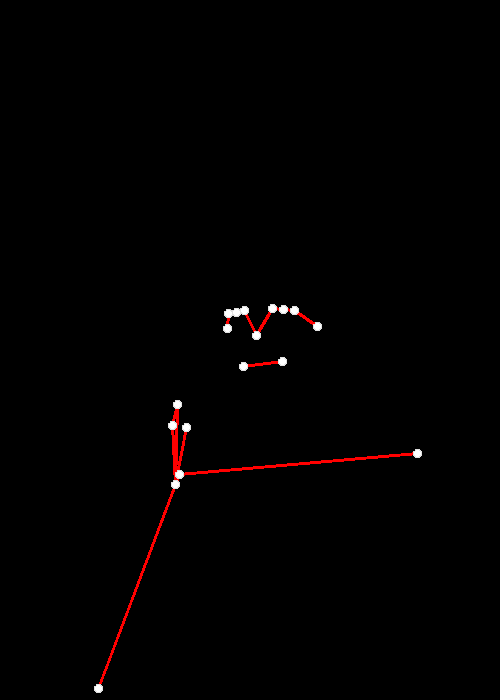
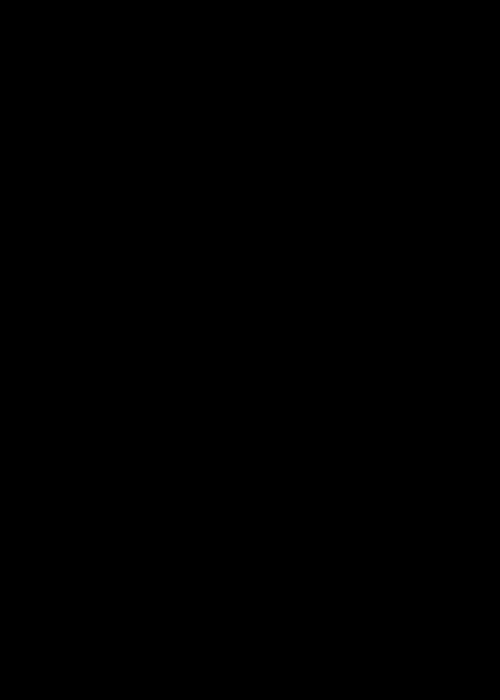
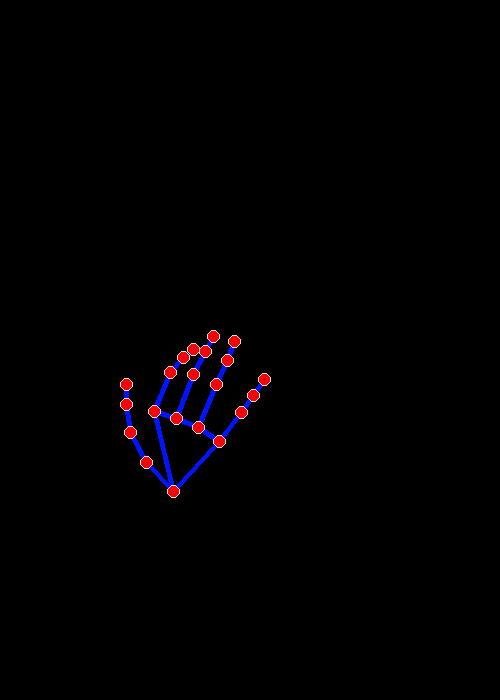
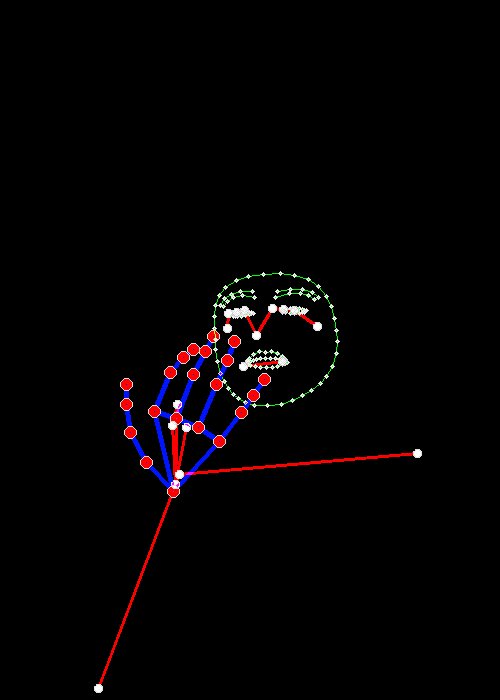
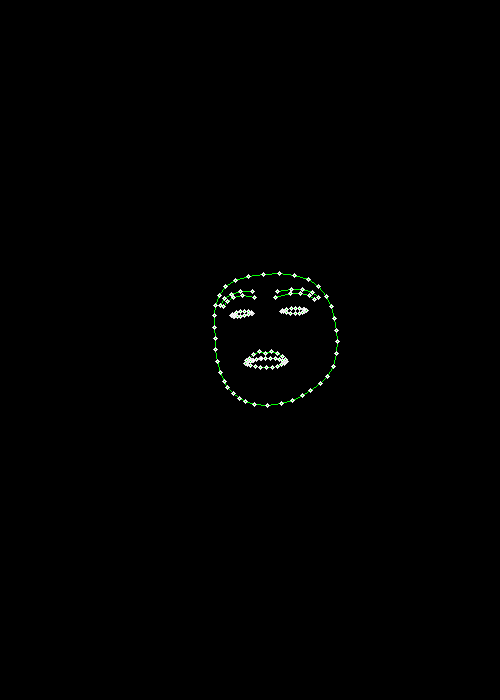
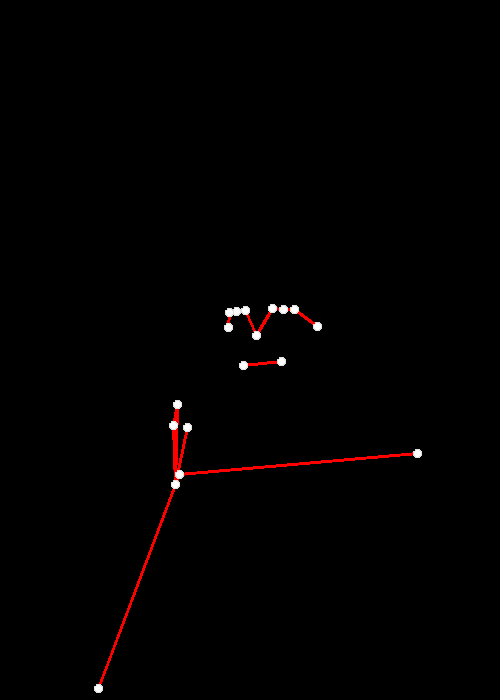
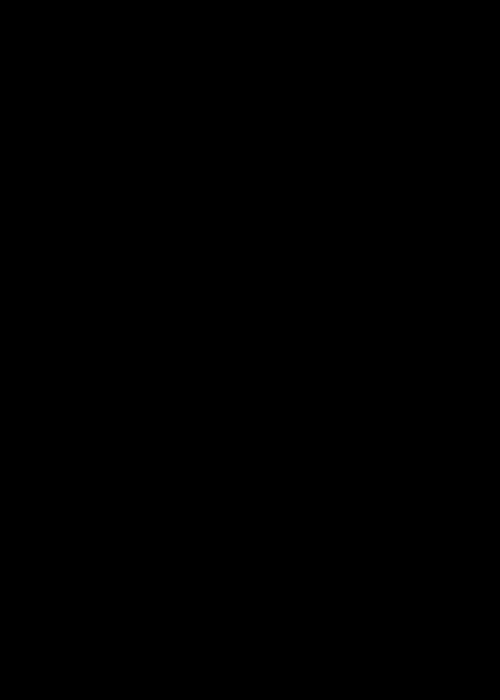
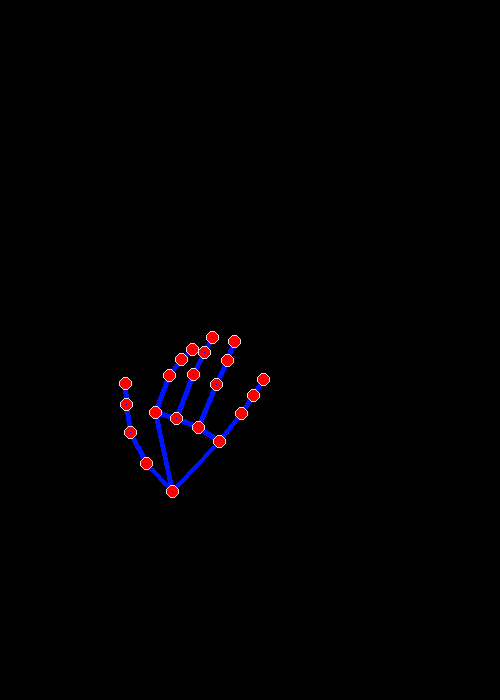
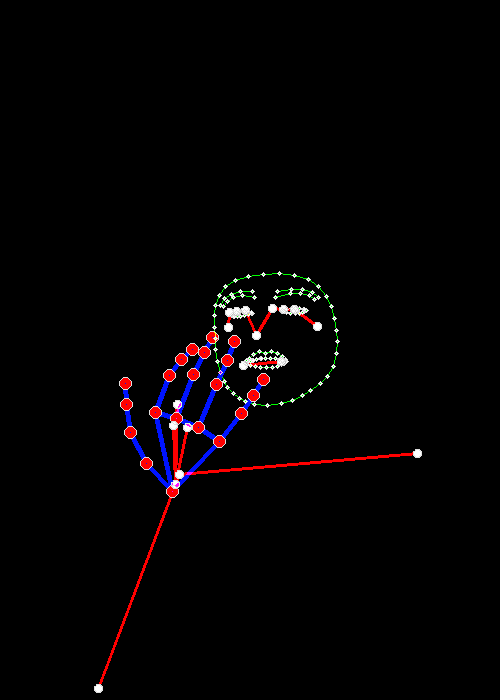
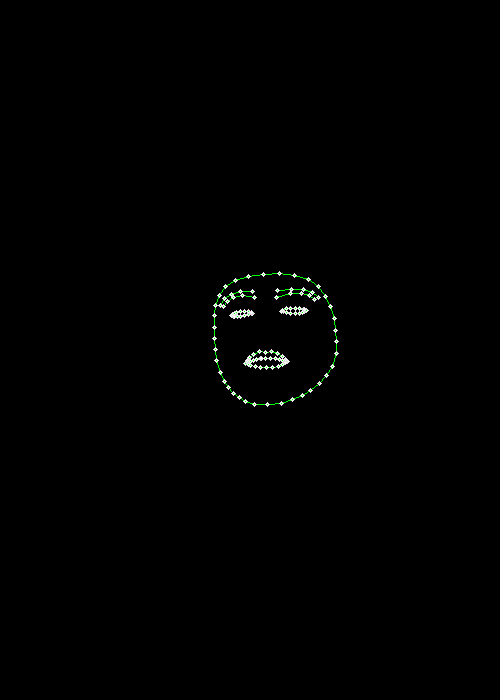
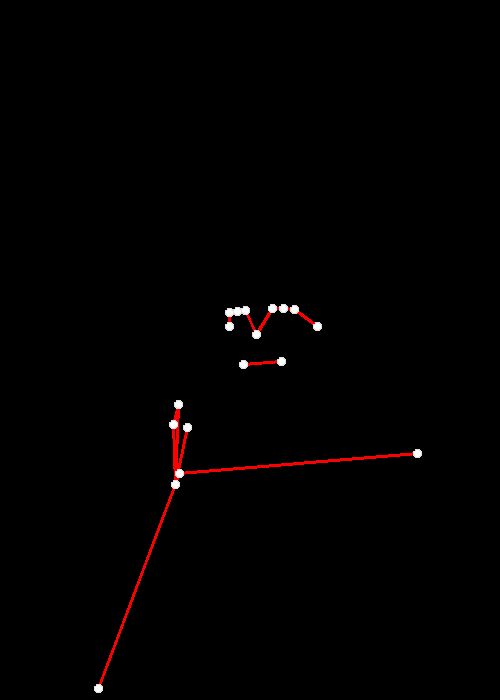
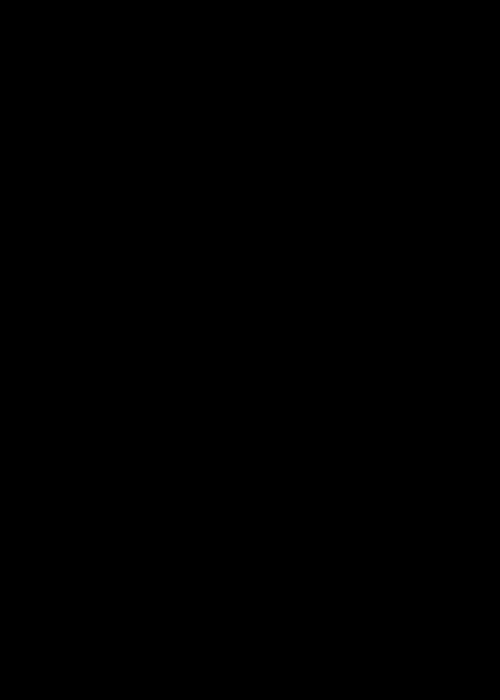
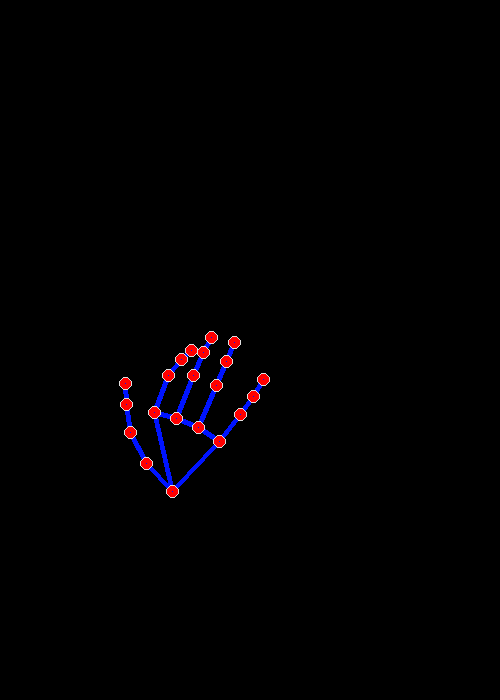
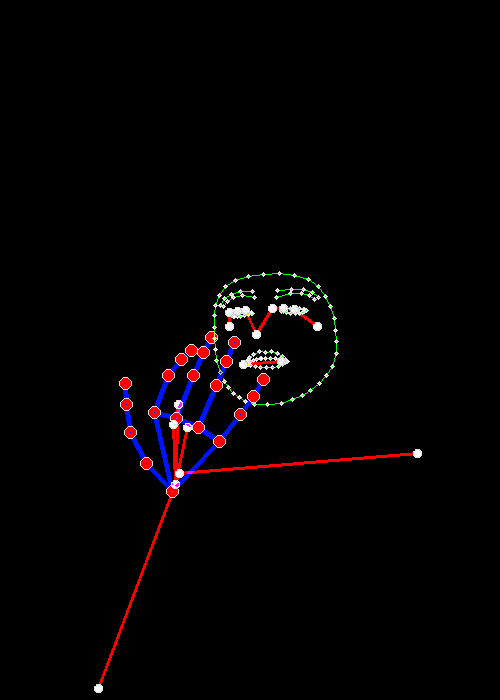
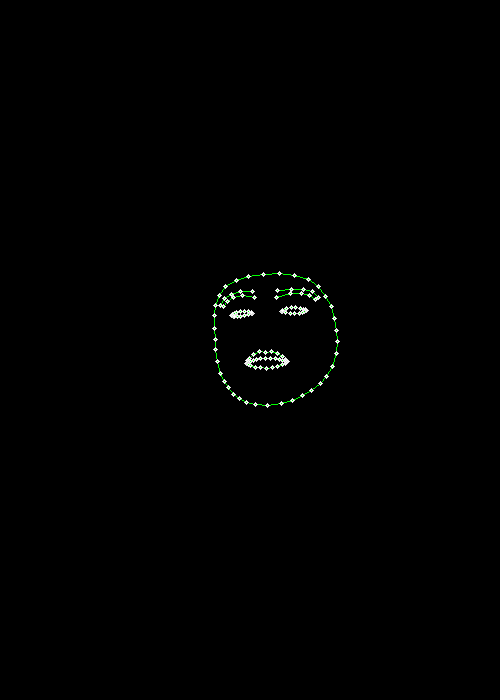
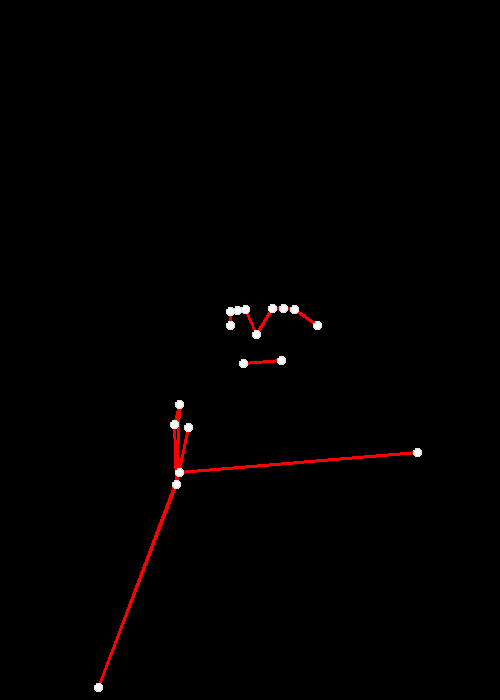
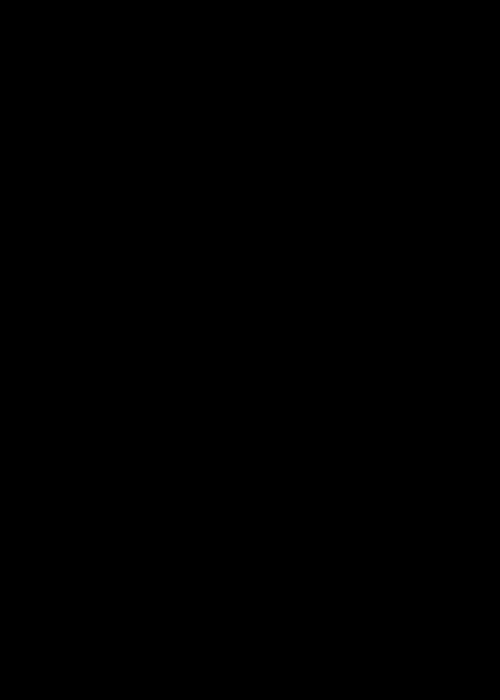
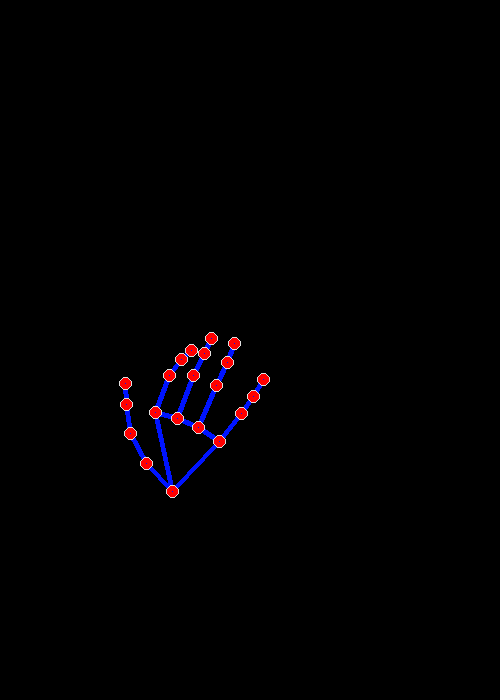
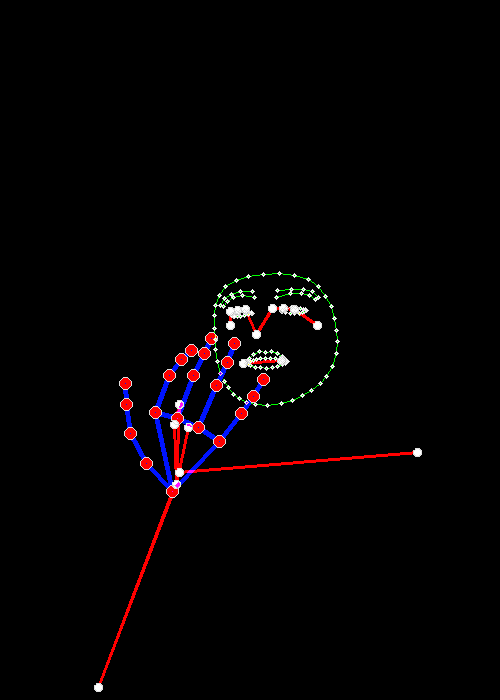
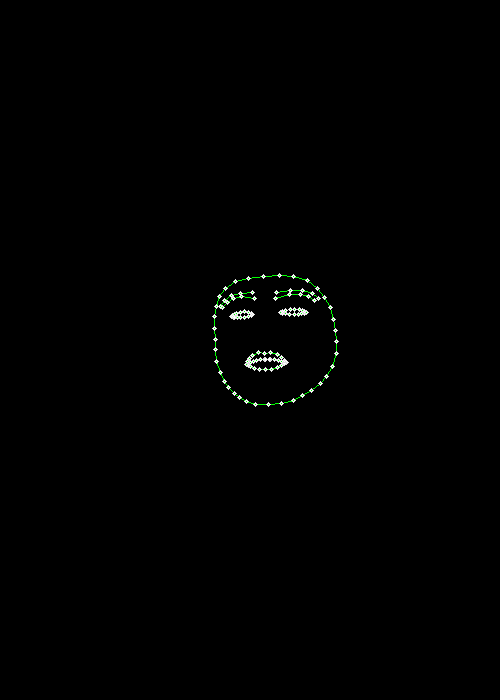
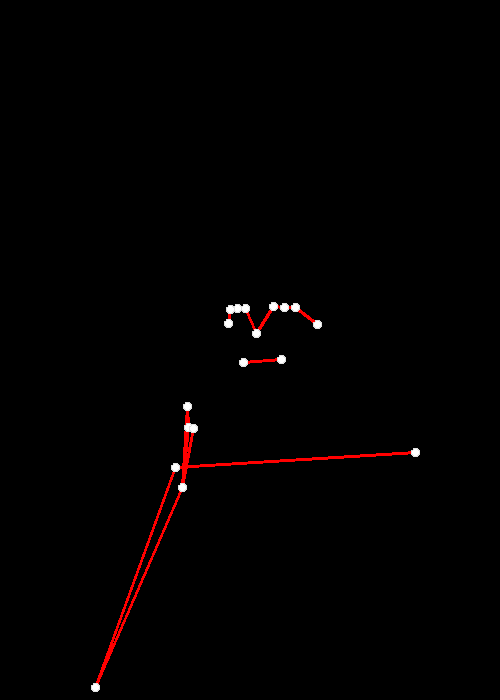
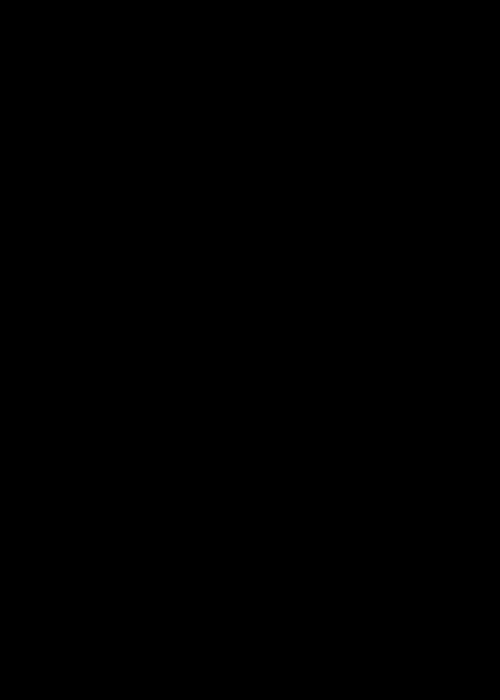
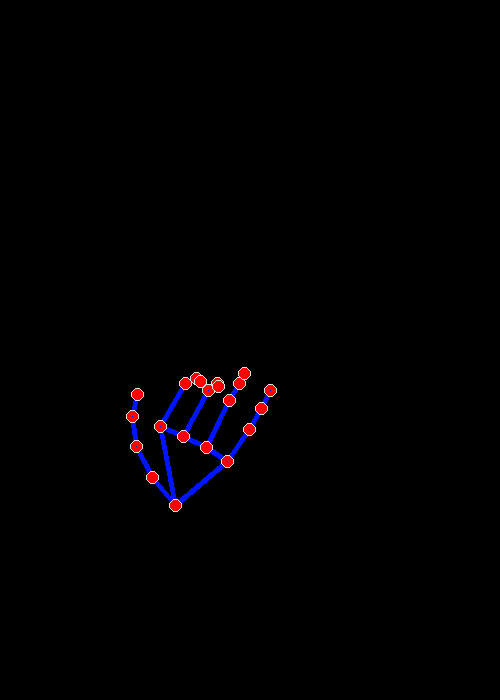
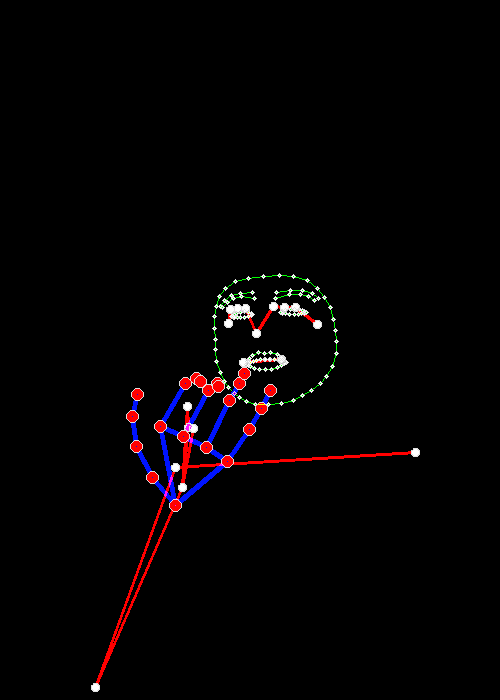
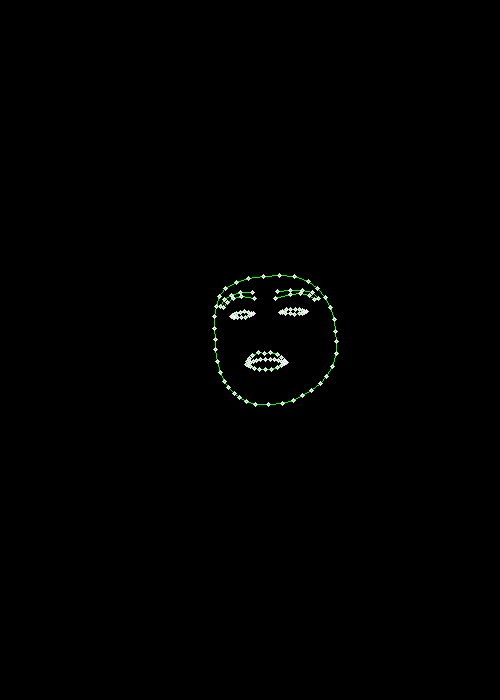
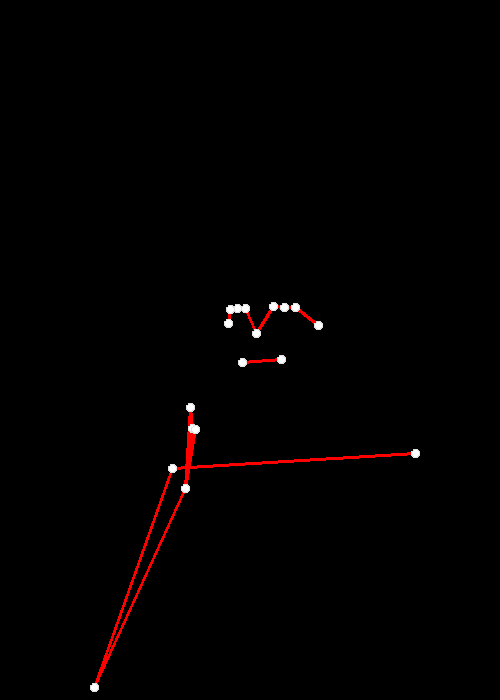
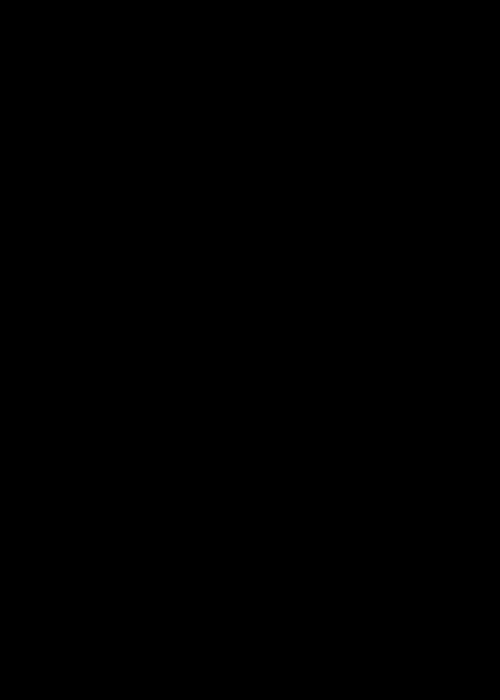
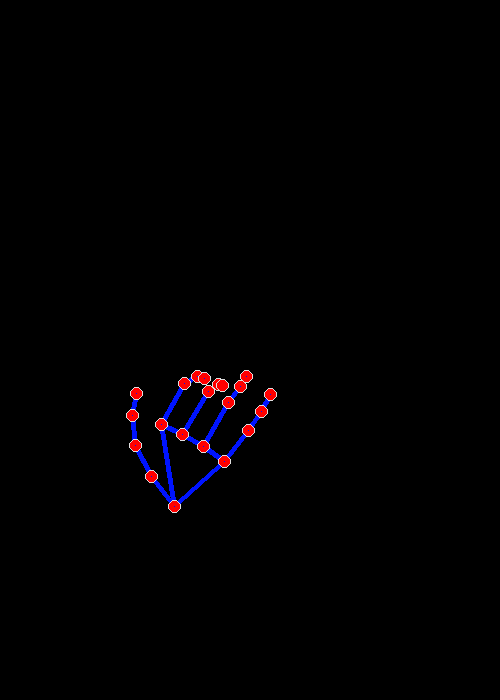
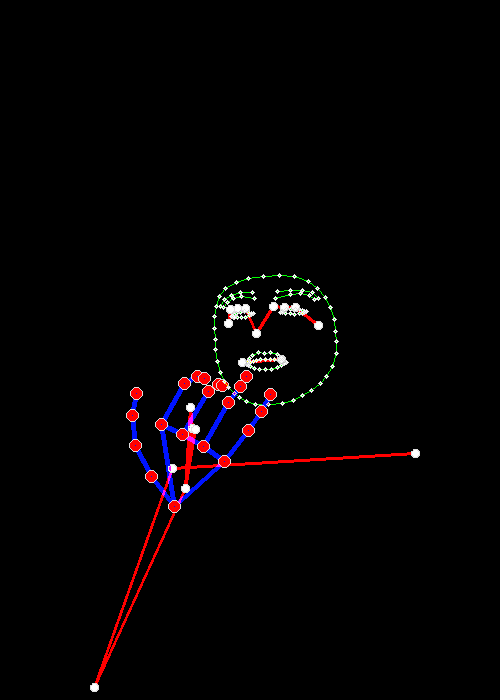
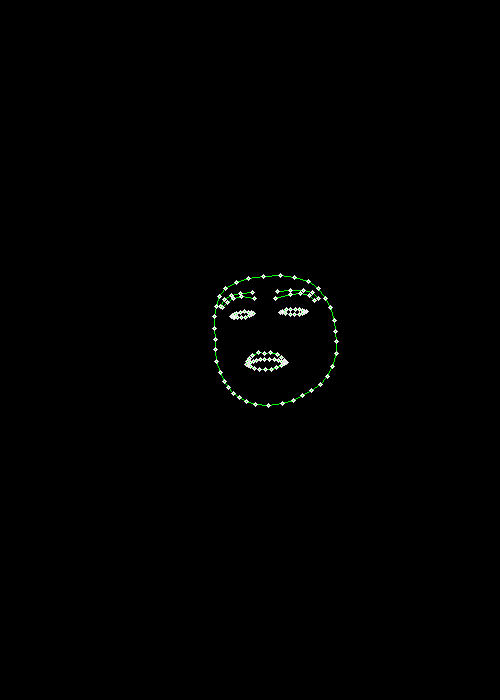
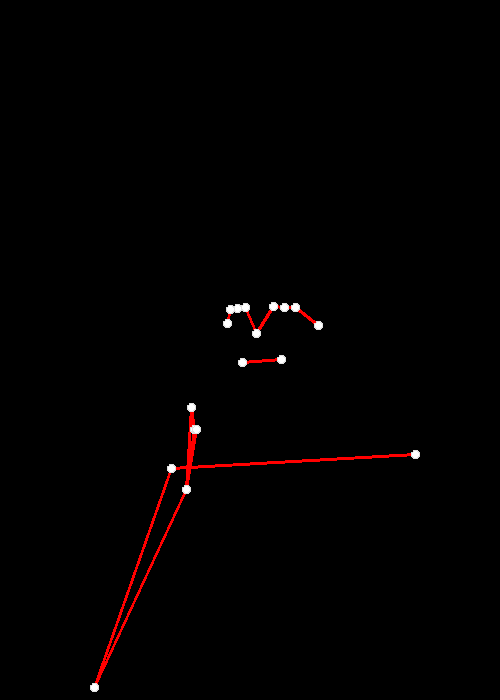
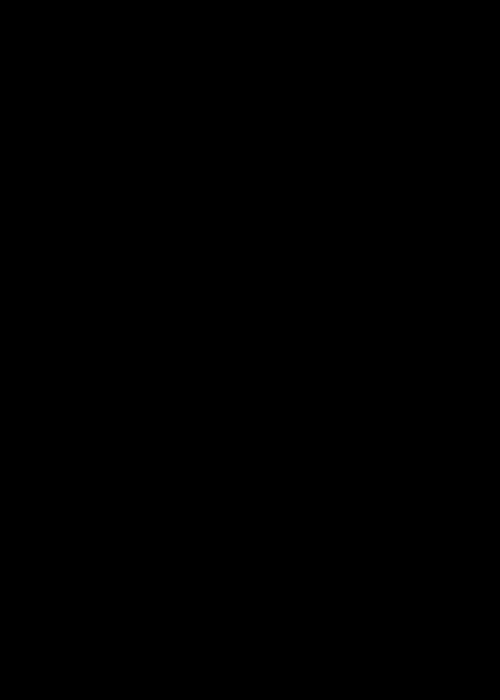
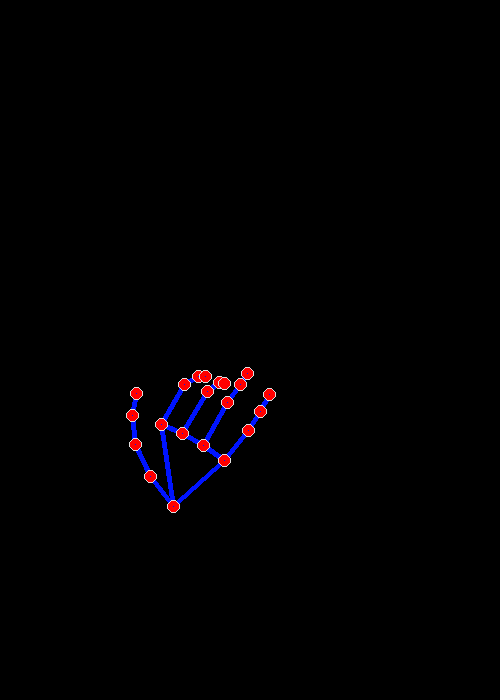
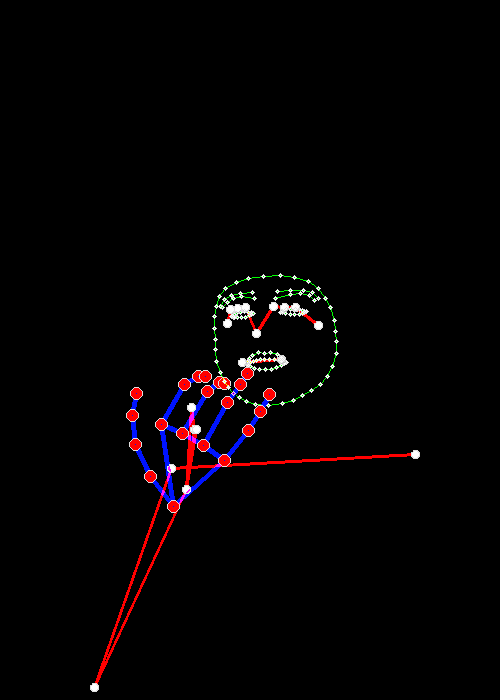
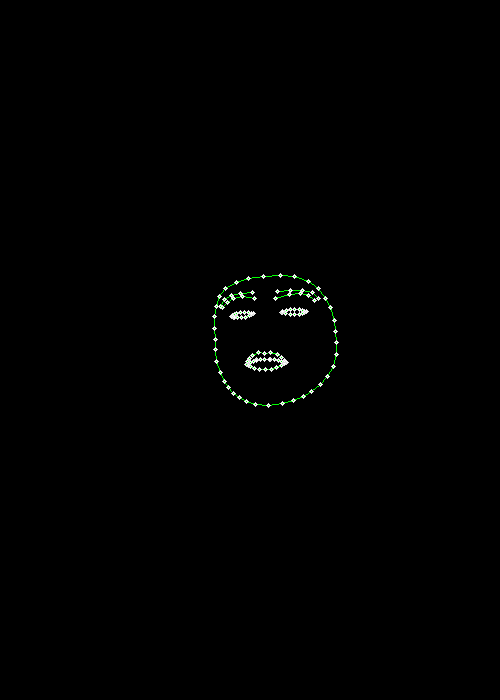
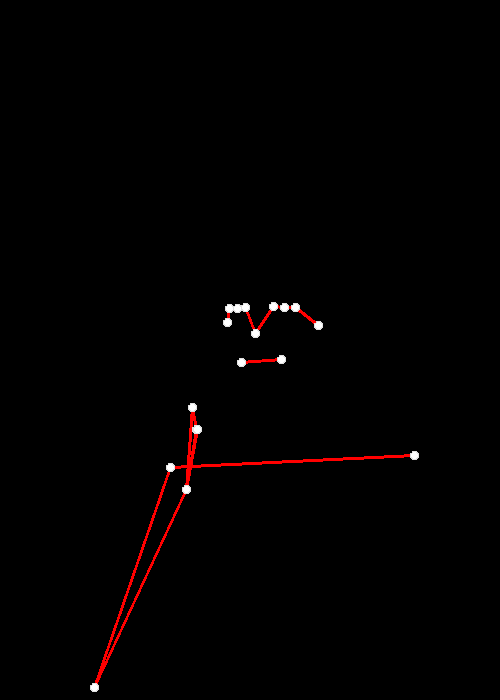
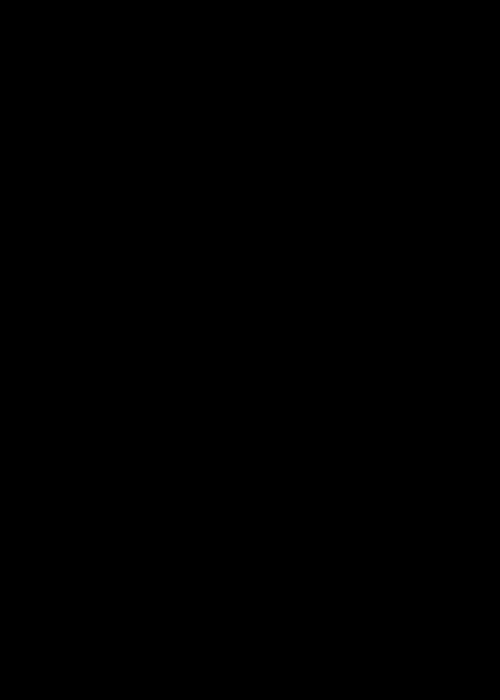
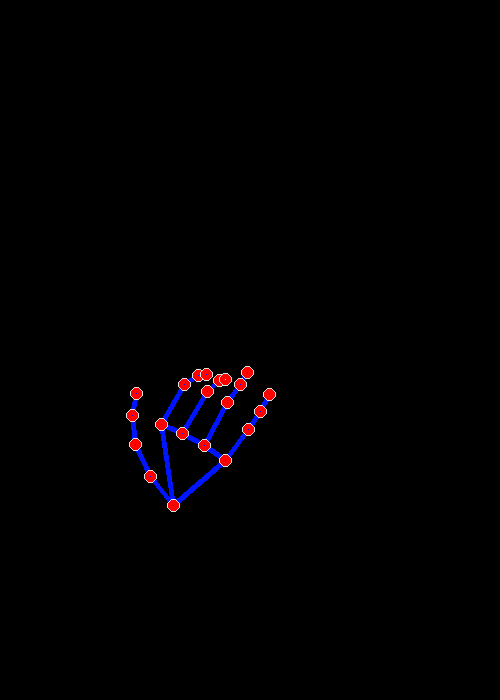
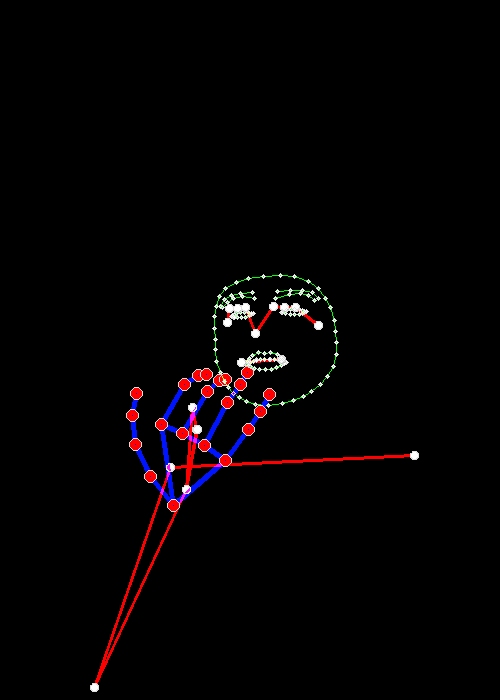
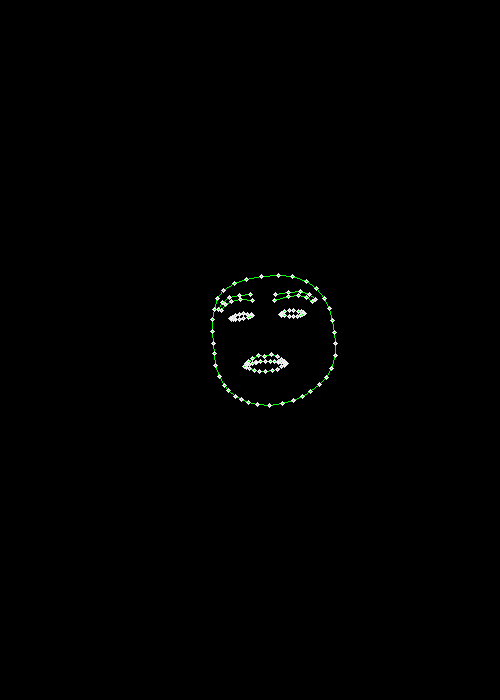
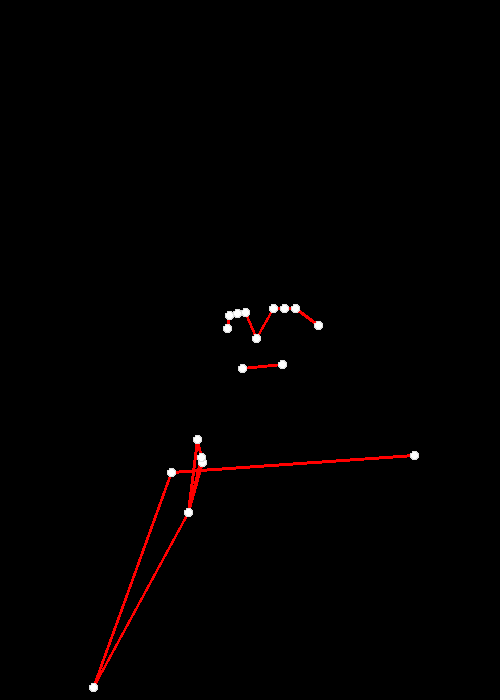
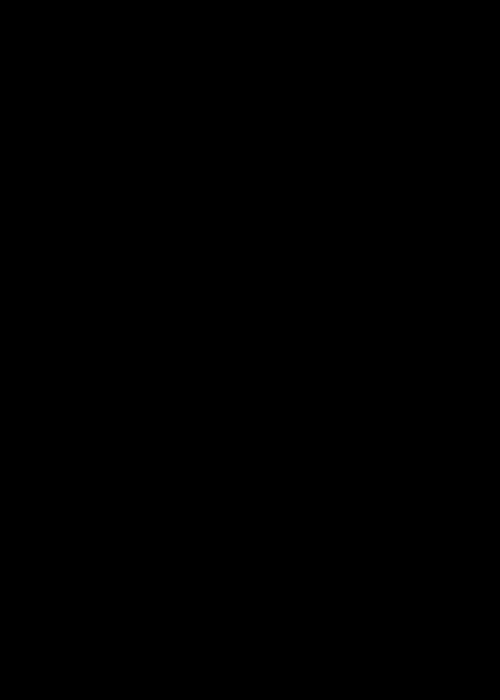
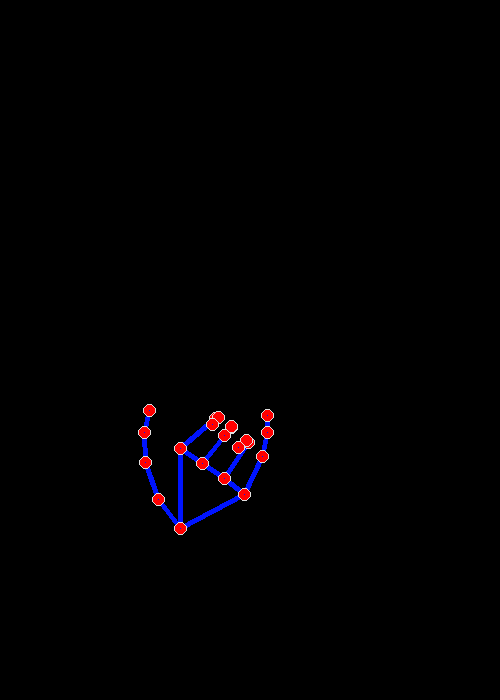
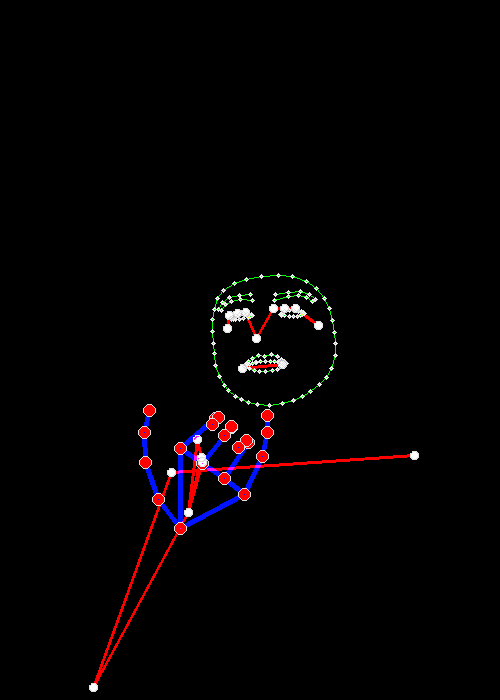
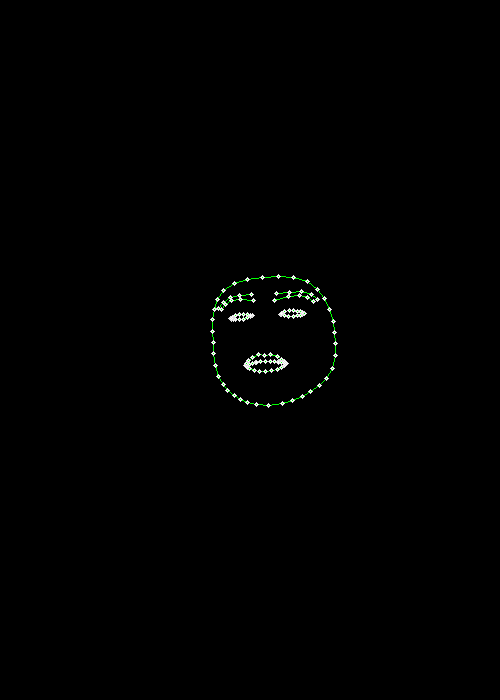
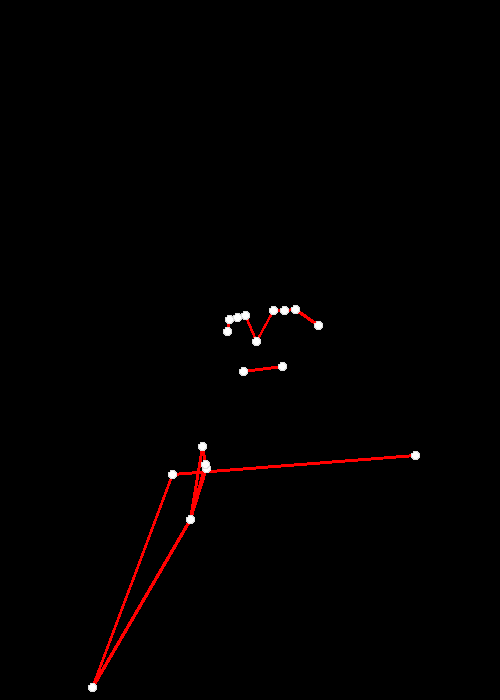
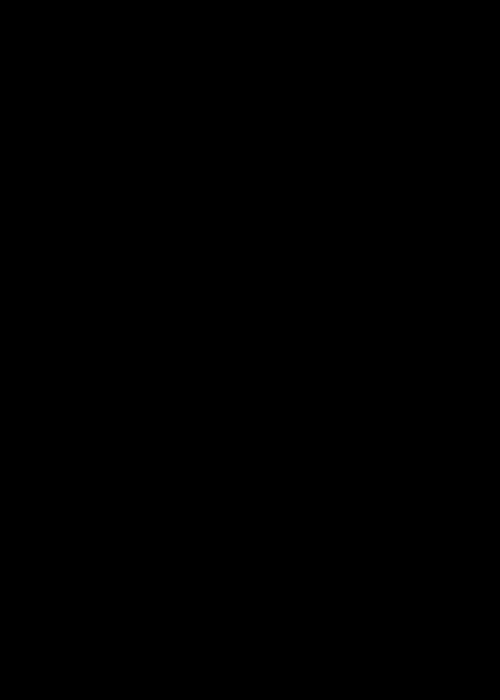
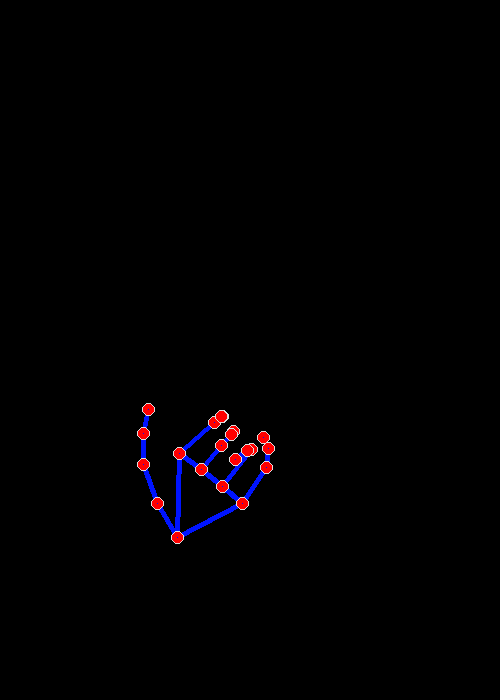
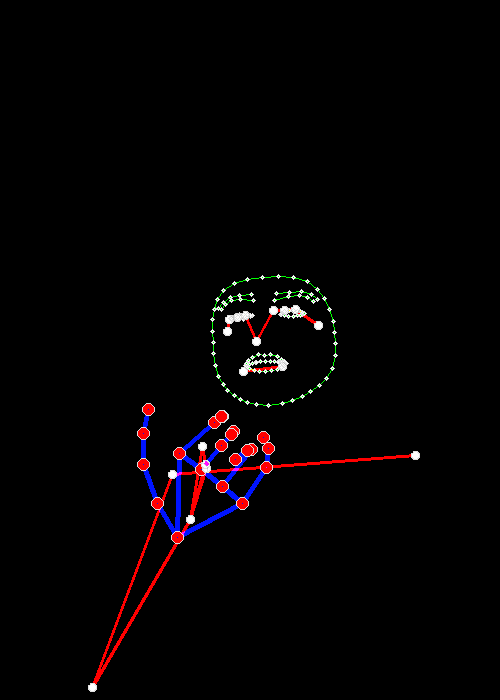
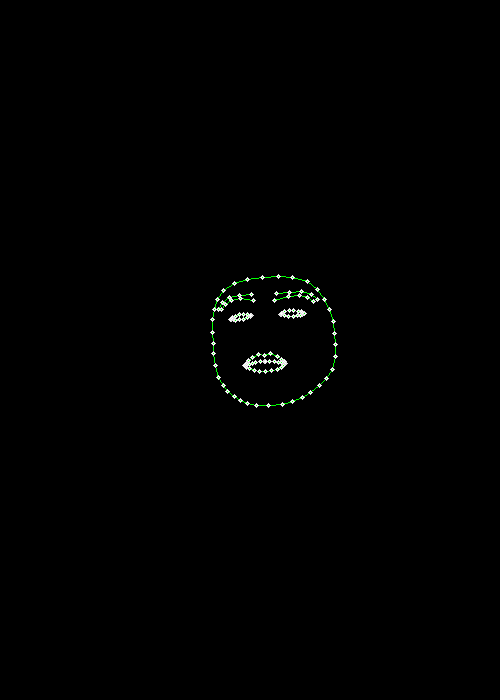
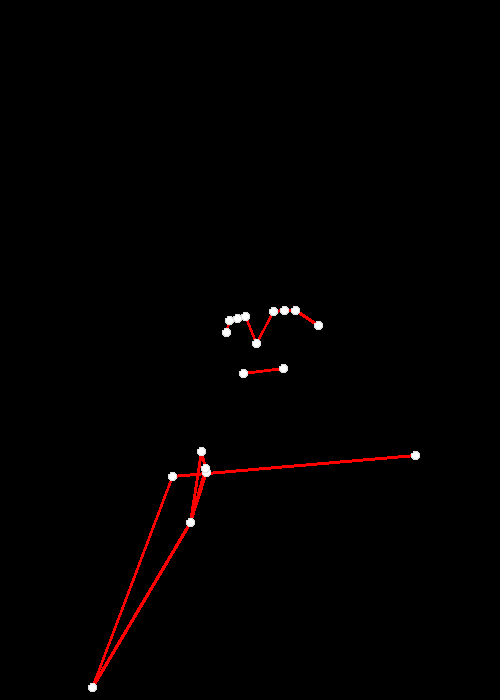
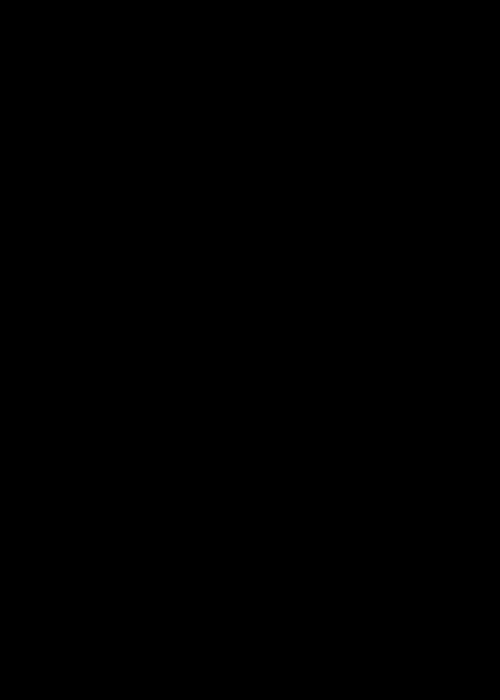
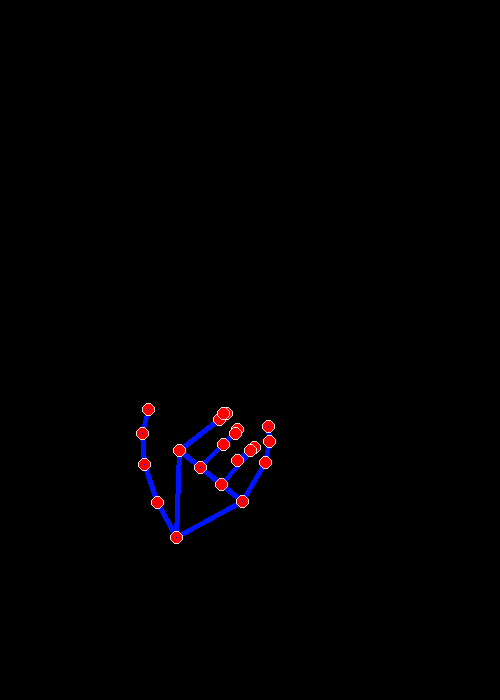
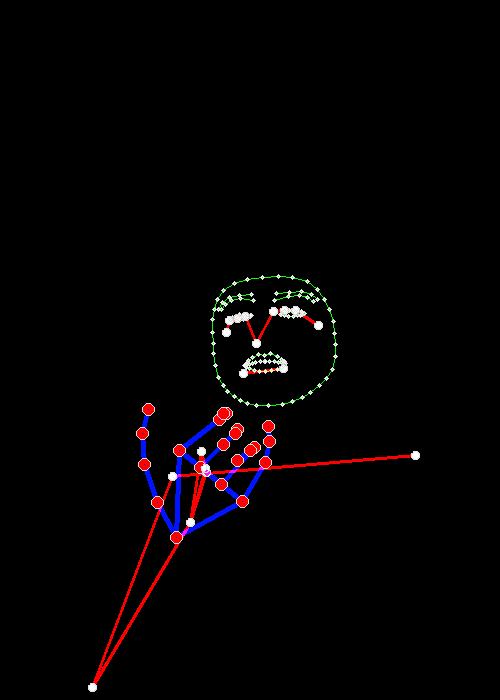
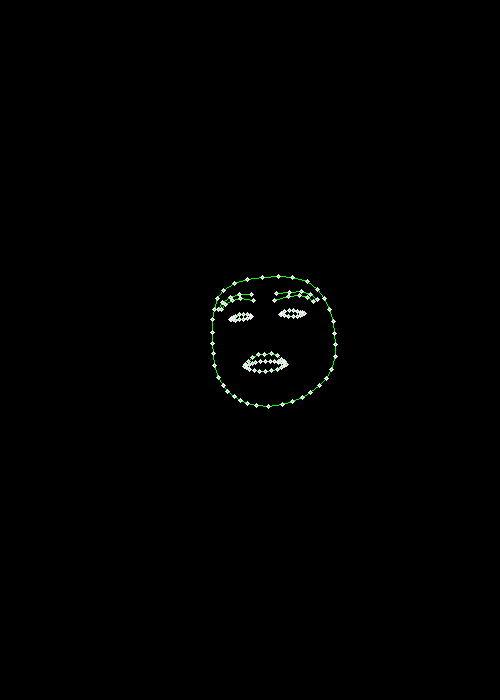
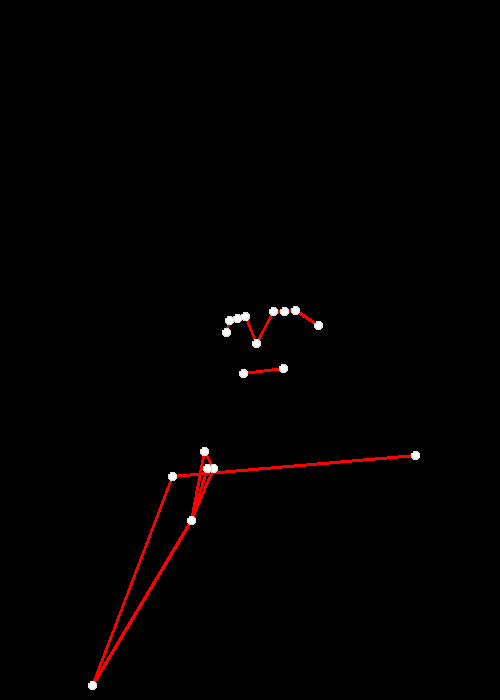
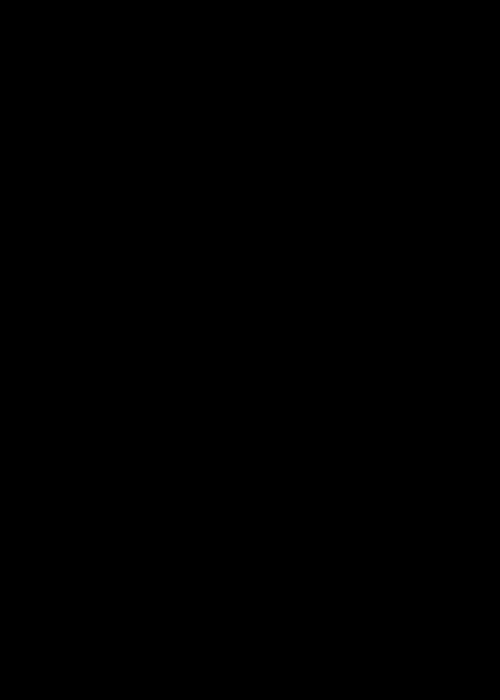
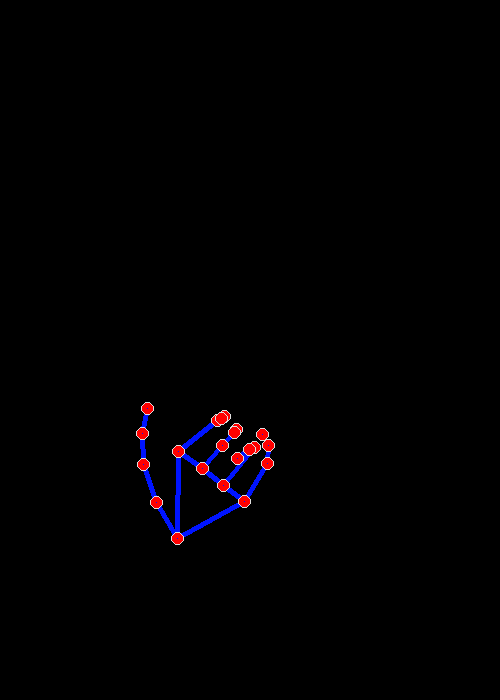
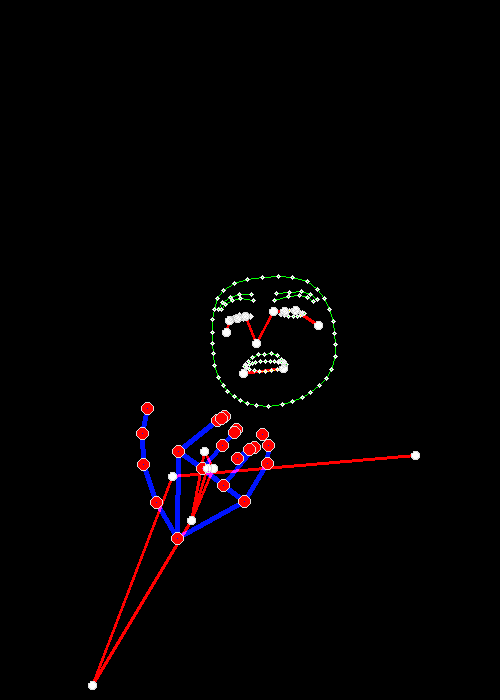

In [14]:
participant_id, sequence_id = get_ids(train_df[train_df['sign'] == 'wait'], 10)
fig = draw_data(participant_id,sequence_id,train_data)
fig.show(config= dict(displayModeBar = False))

<span style="font-size:20px; font-family:Georgia;"><b>Example 2: Cloud</b></span>


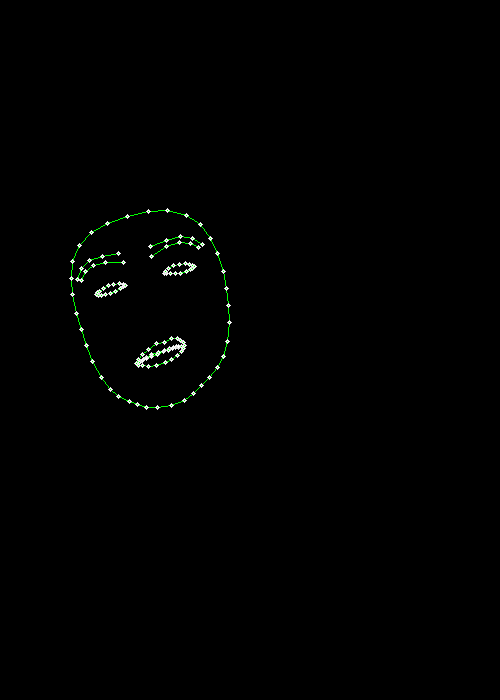
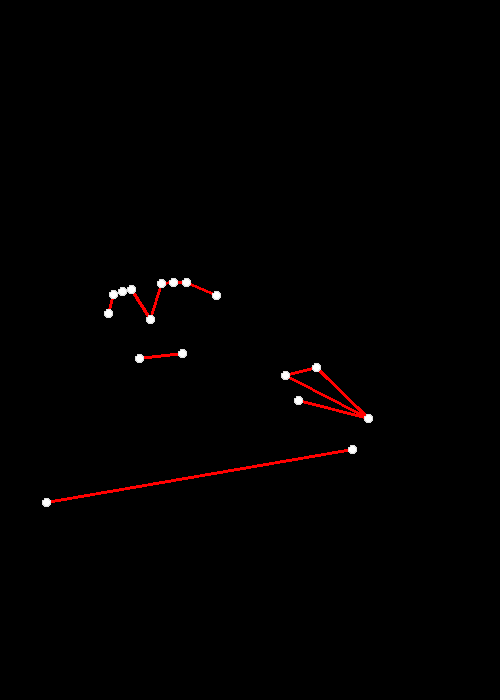
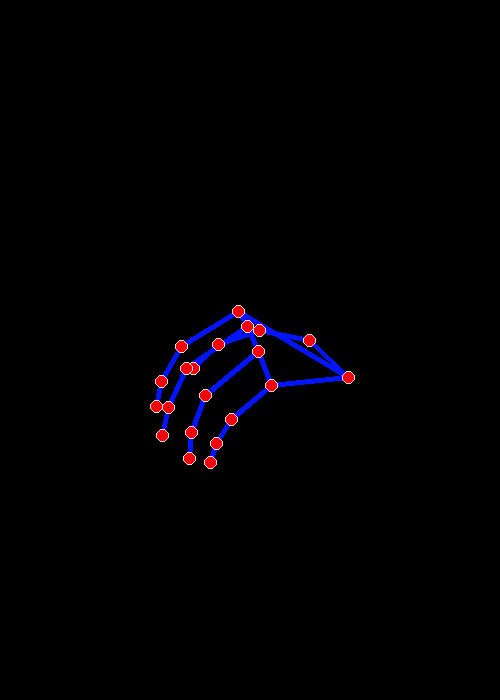
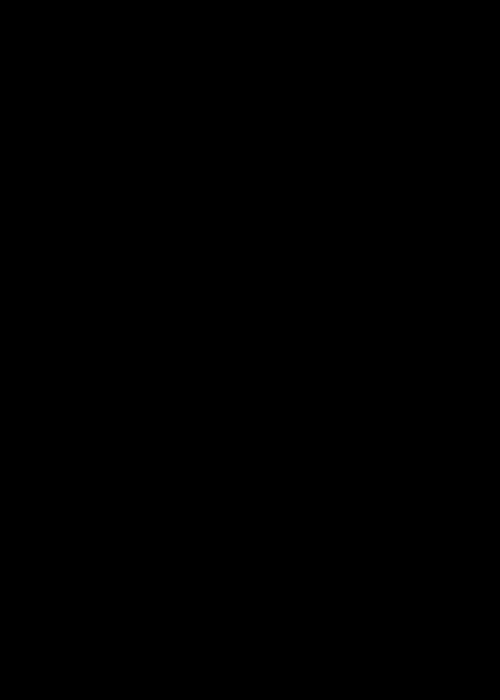
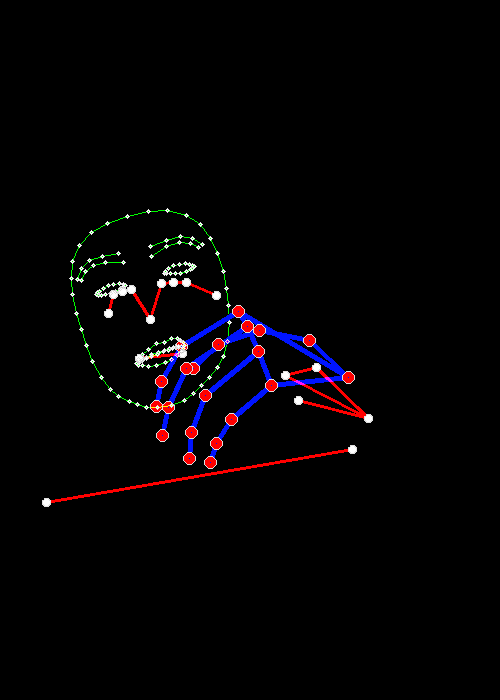
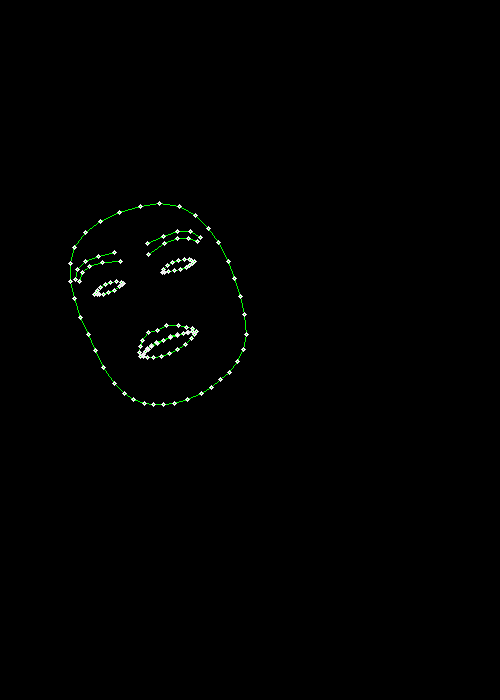
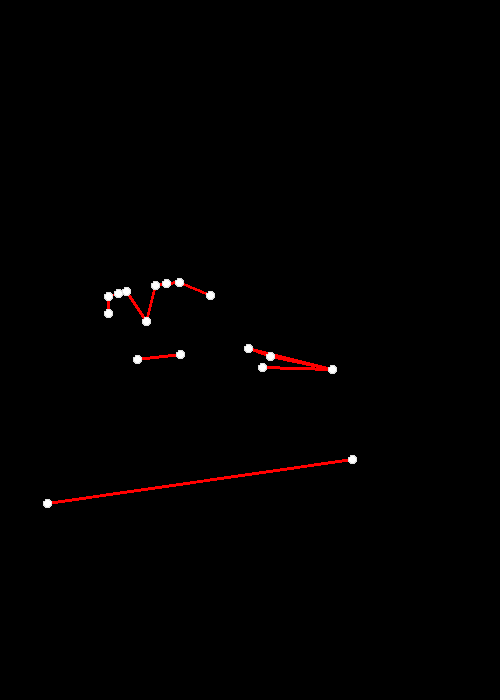
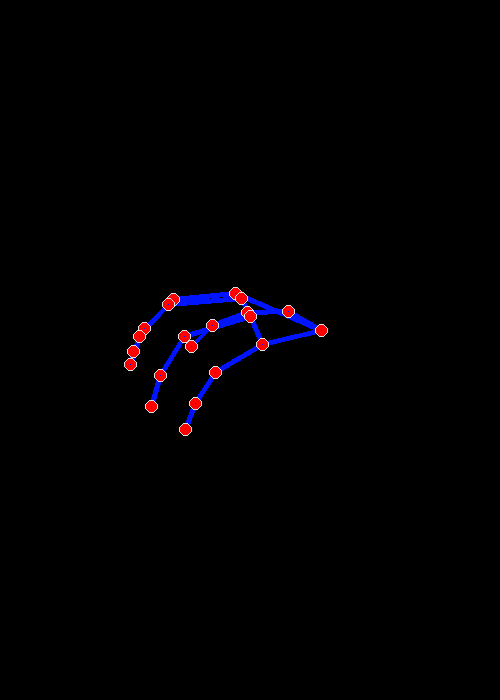
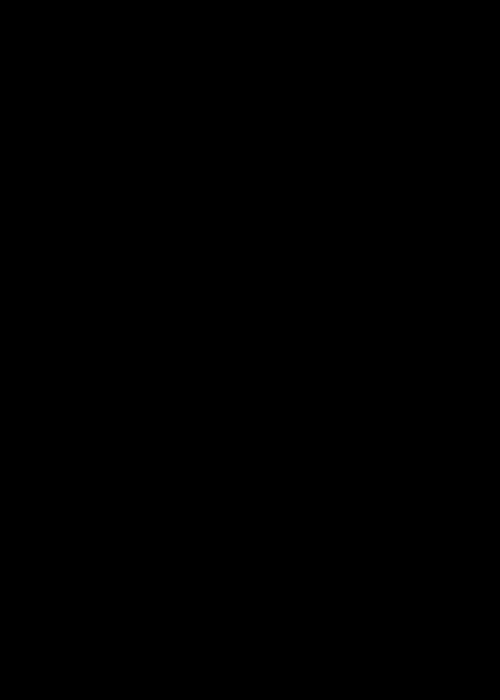
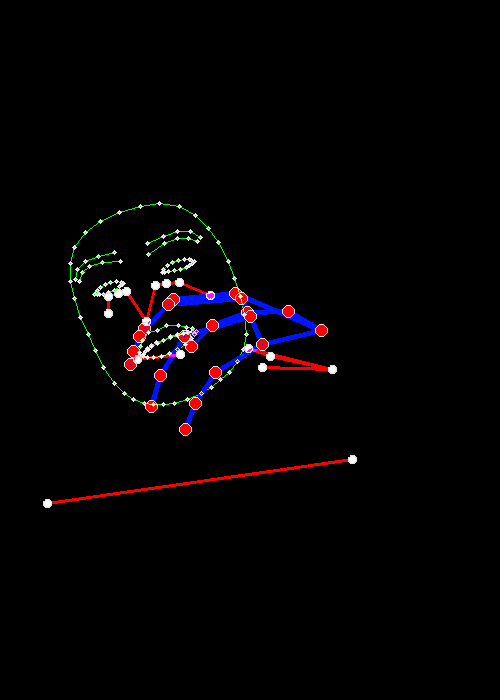
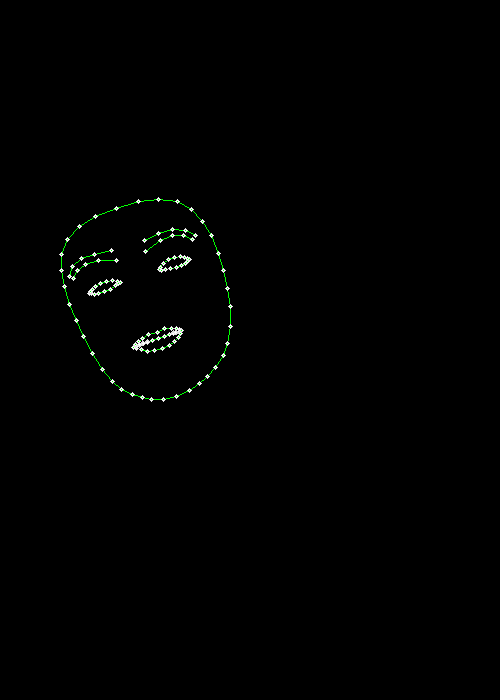
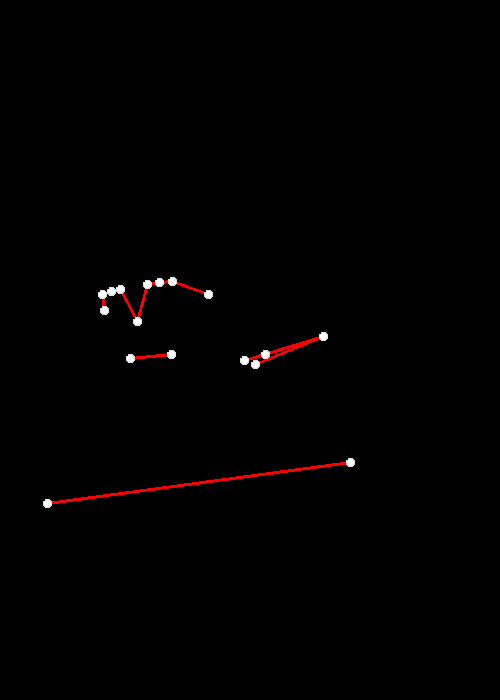
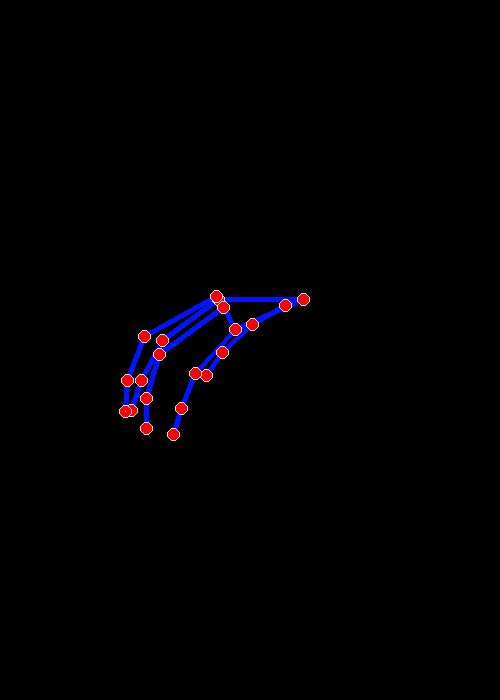
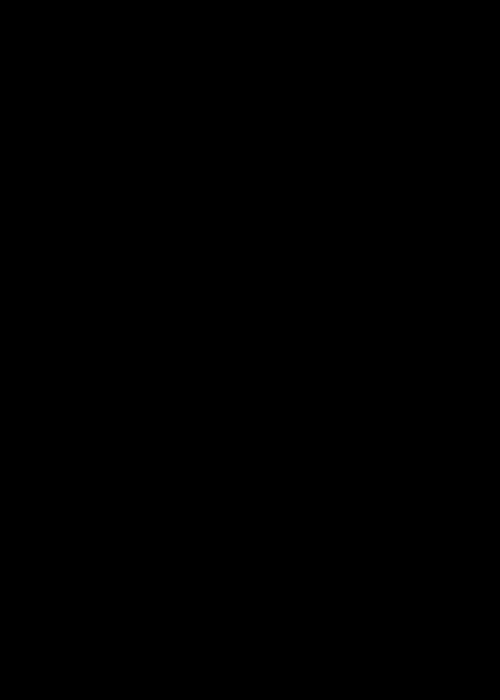
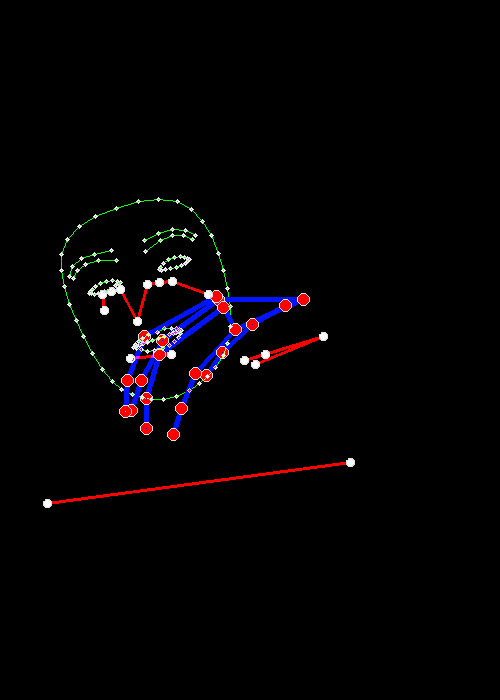
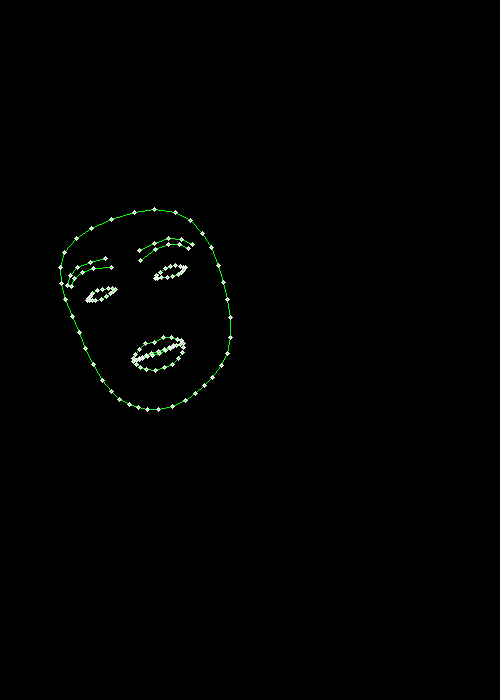
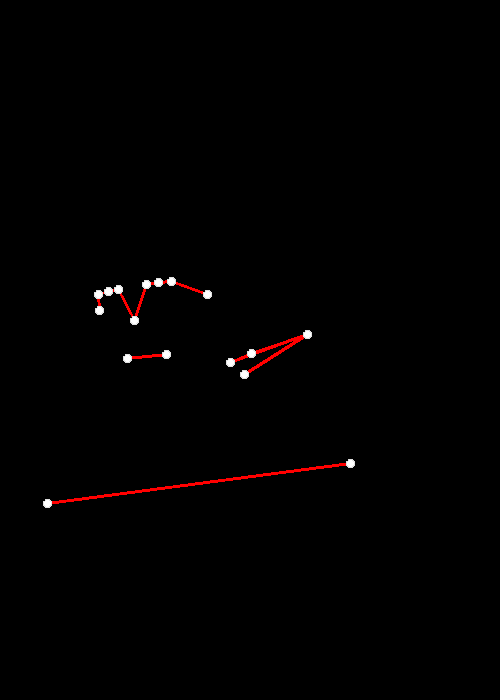
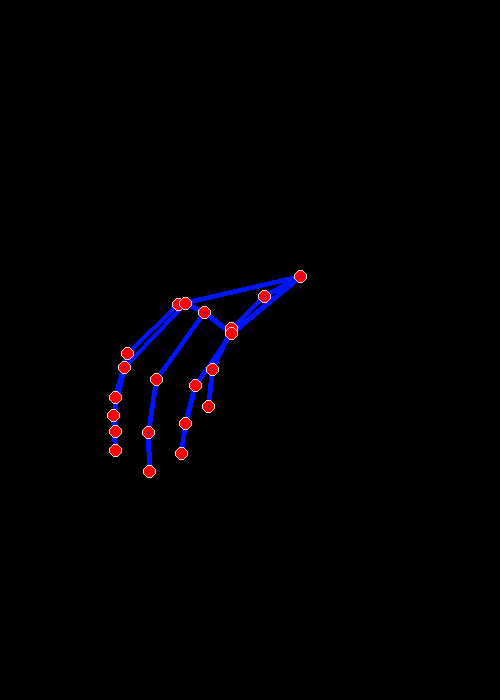
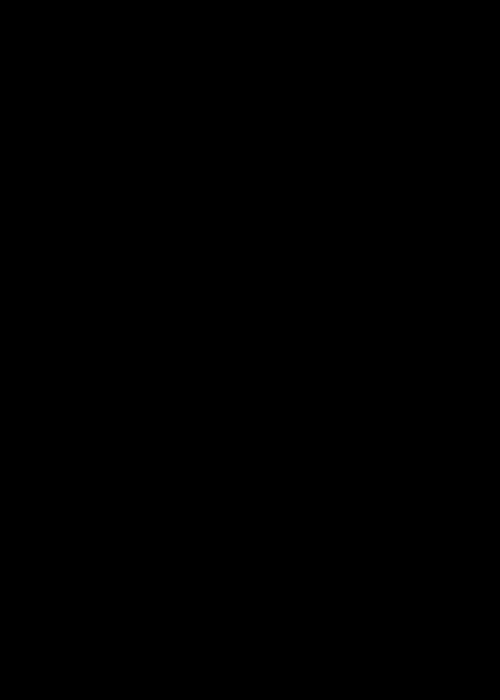
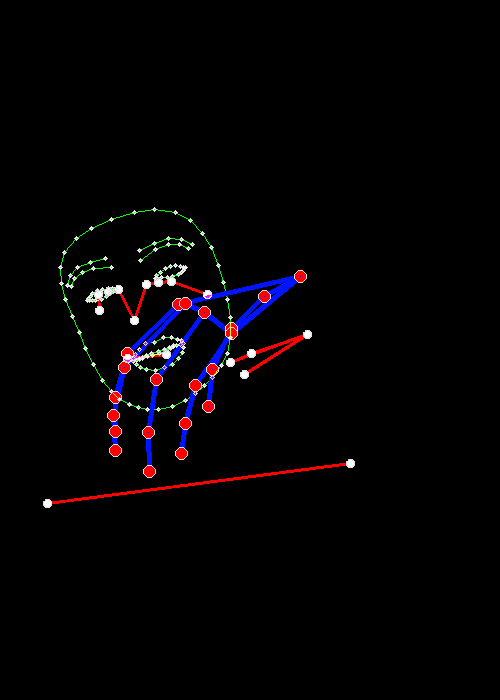
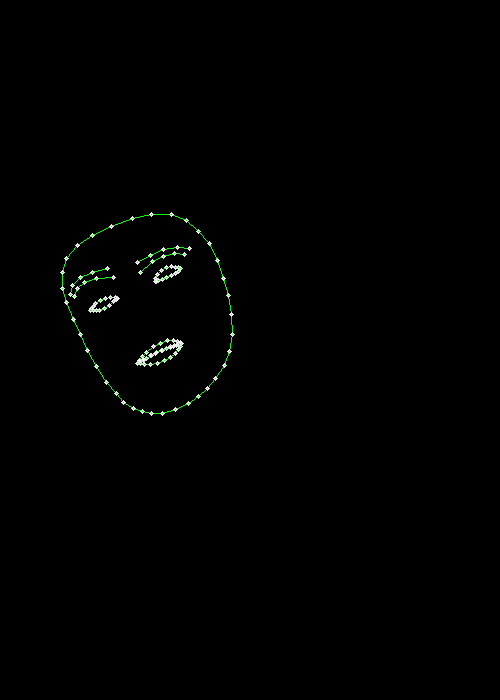
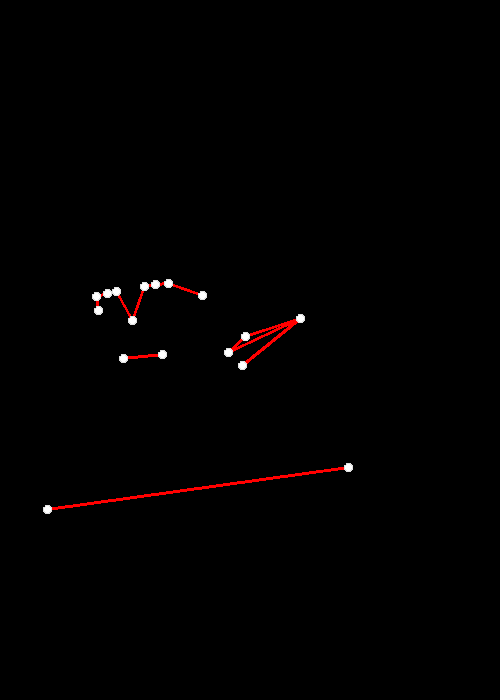
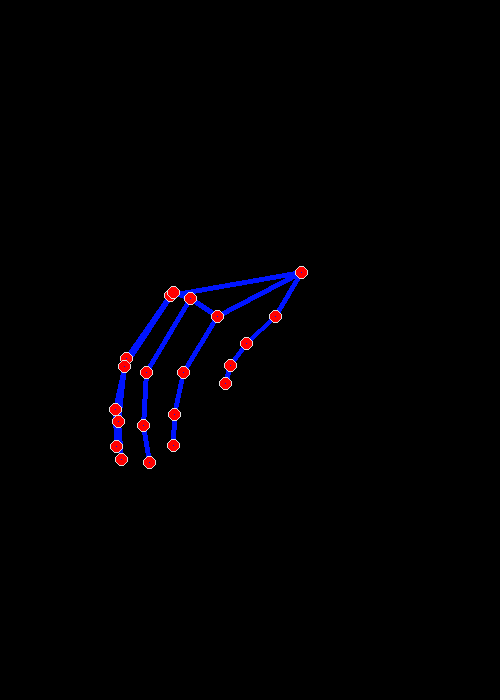
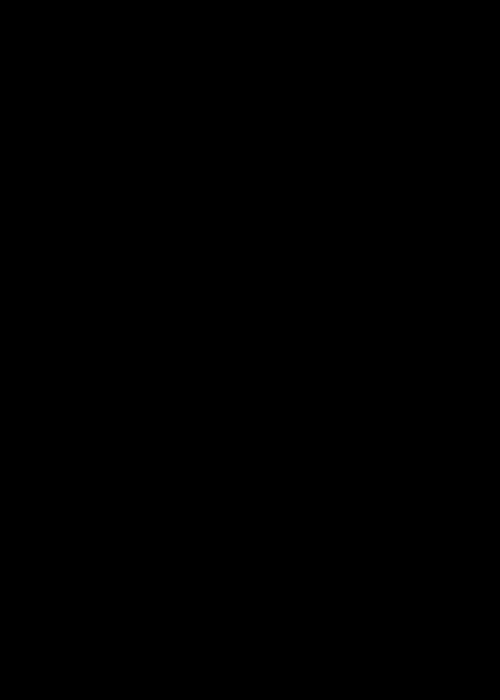
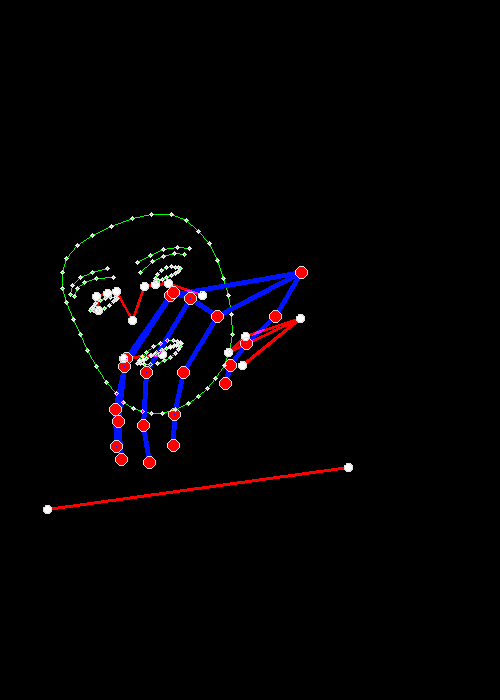
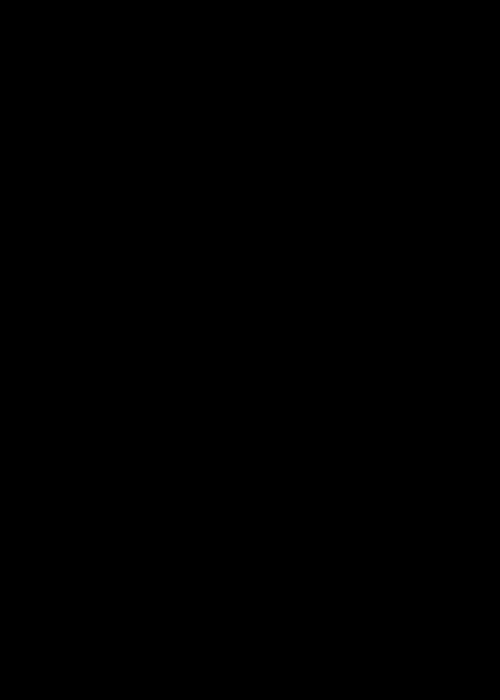
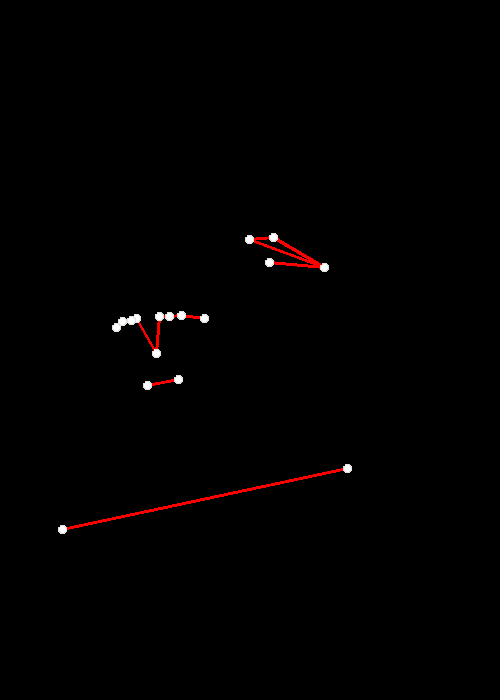
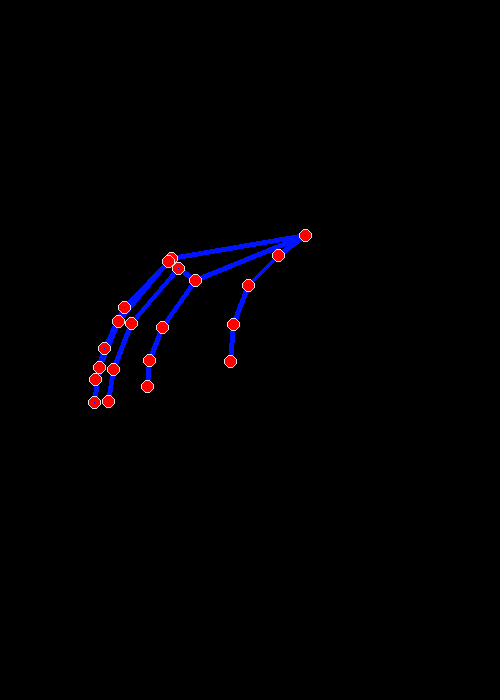
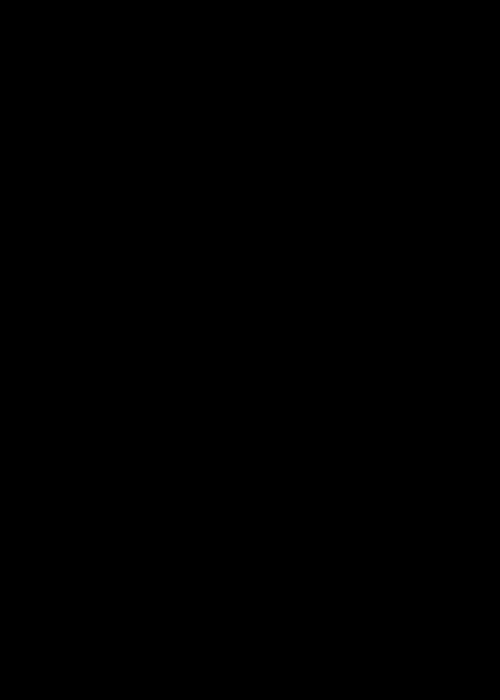
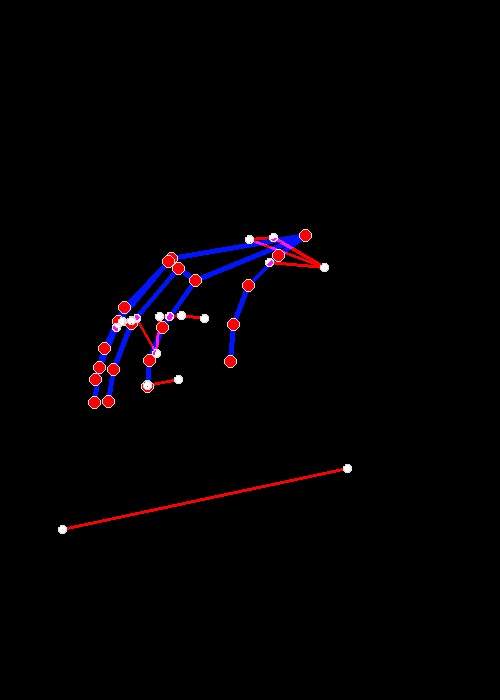
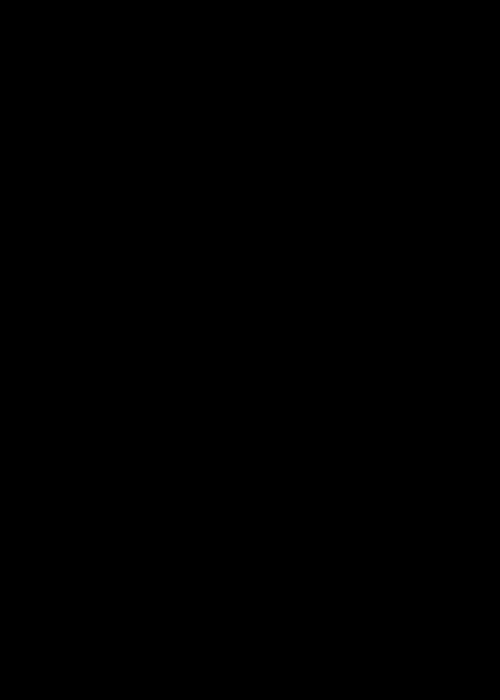
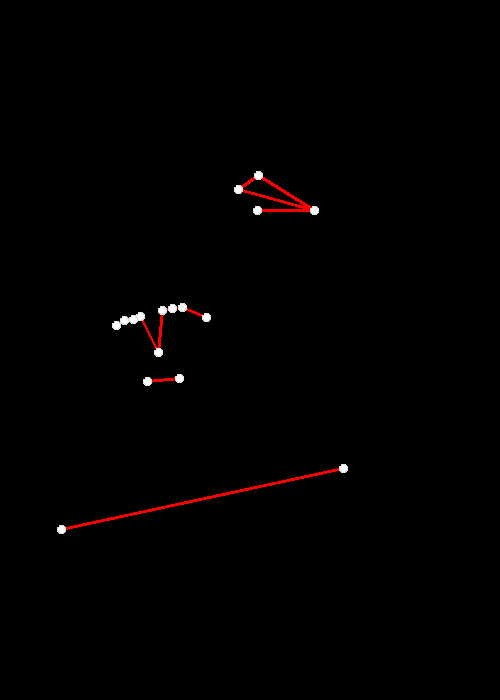
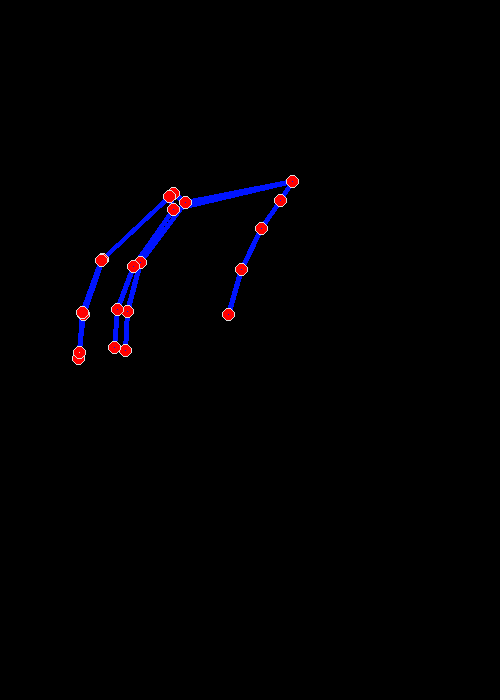
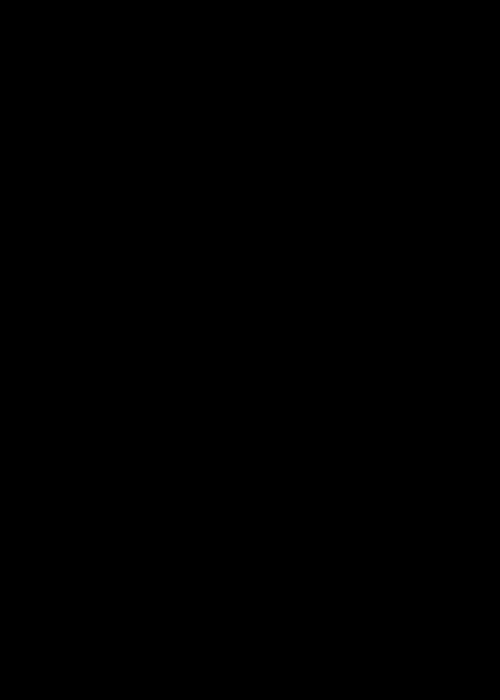
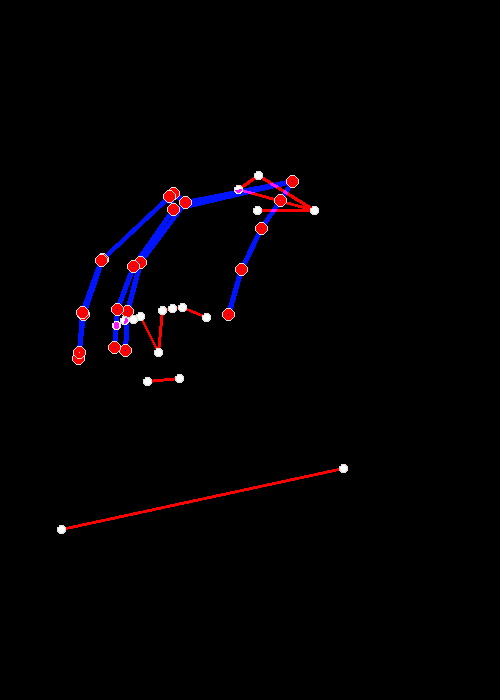
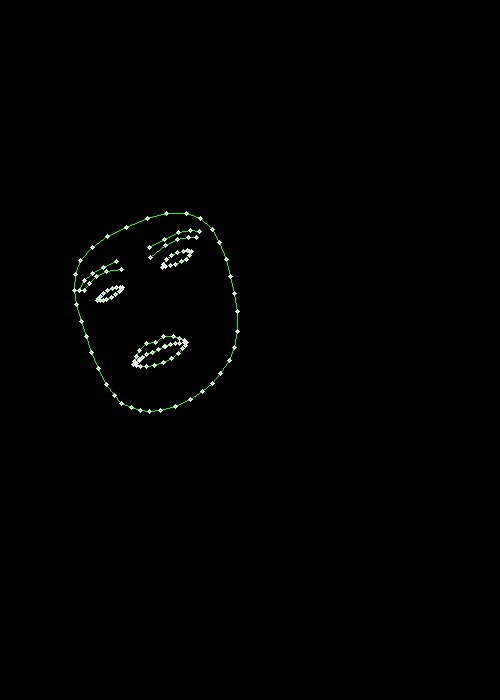
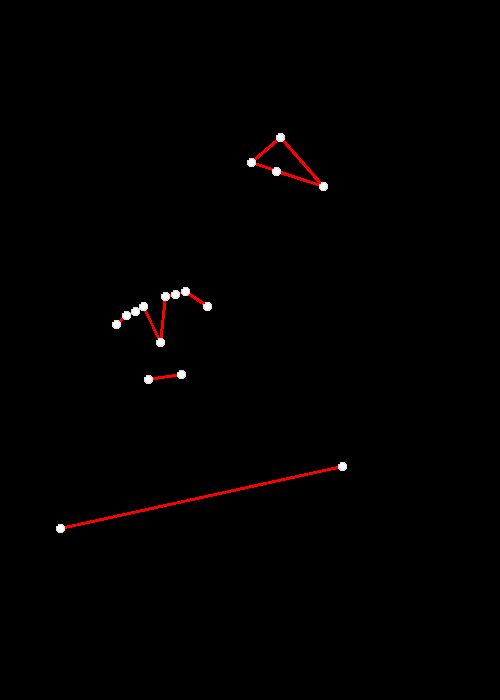
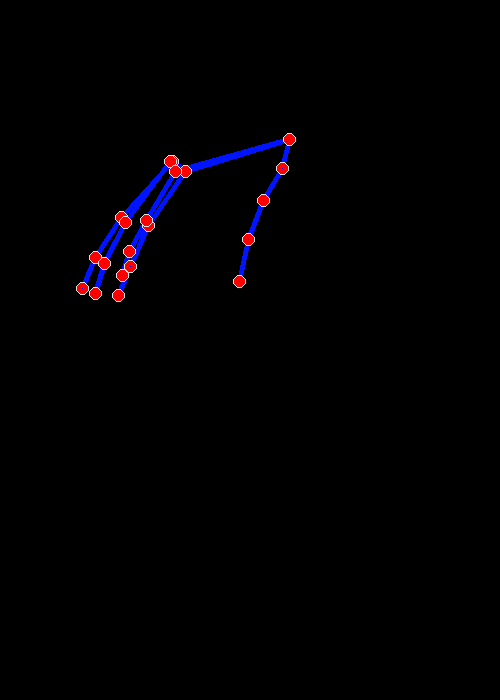
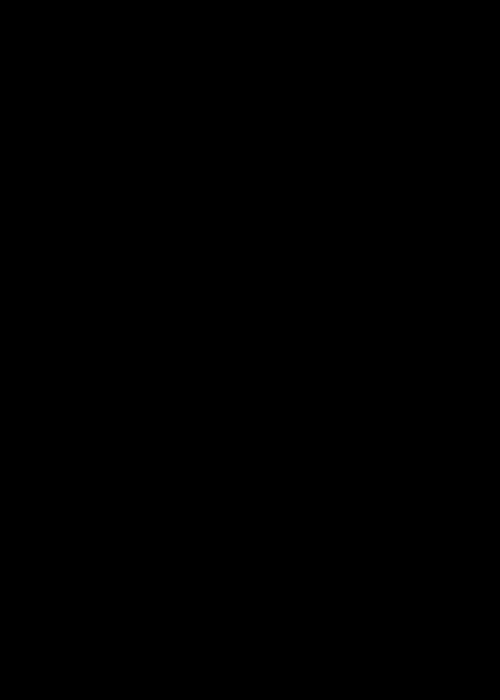
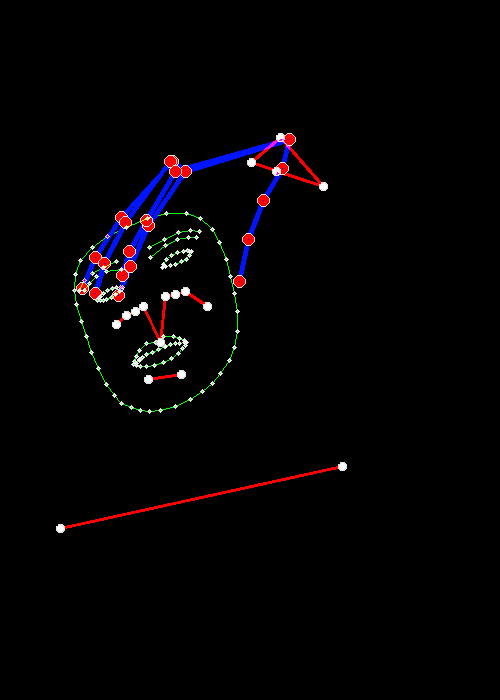
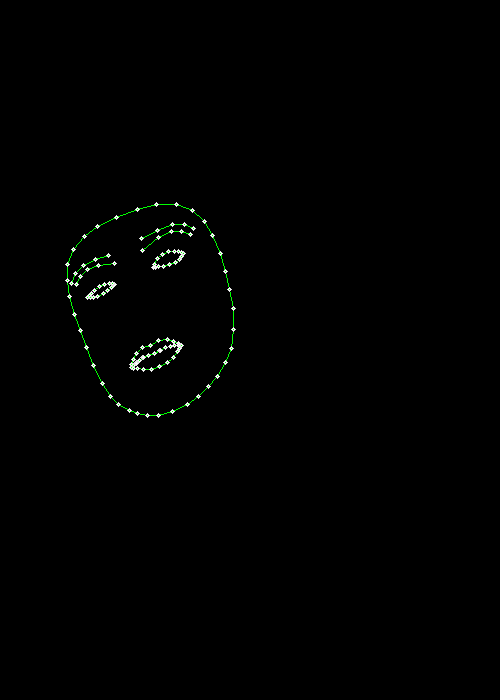
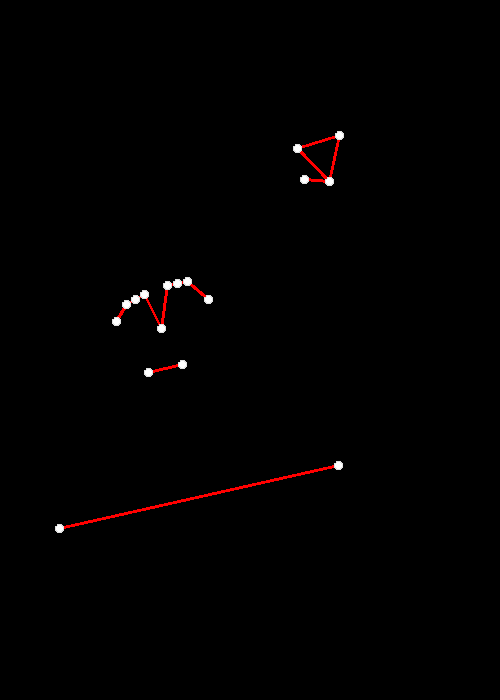
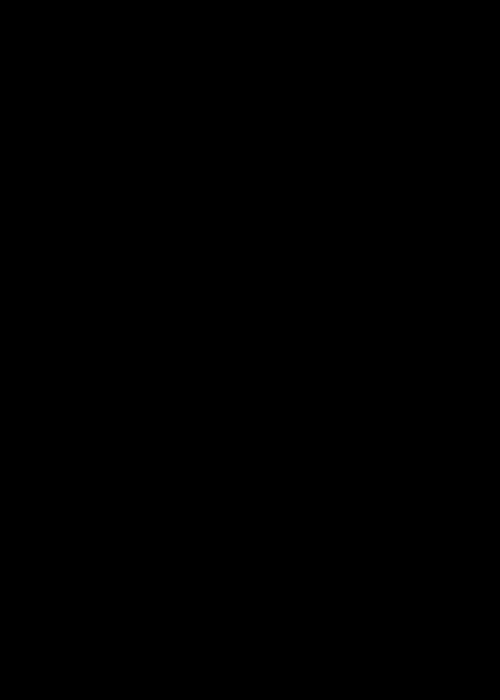
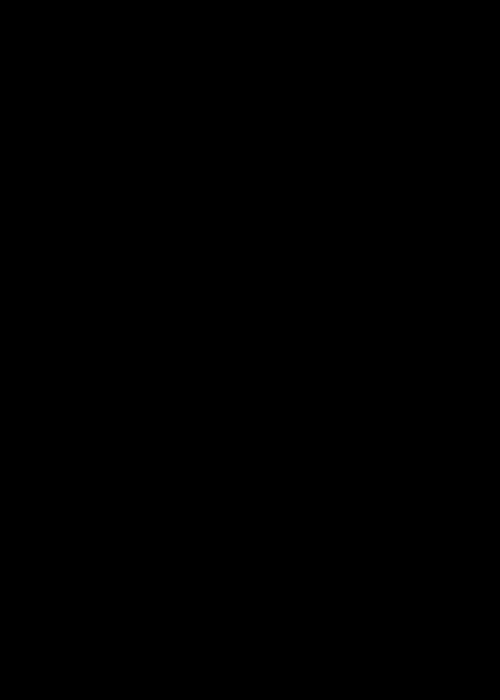
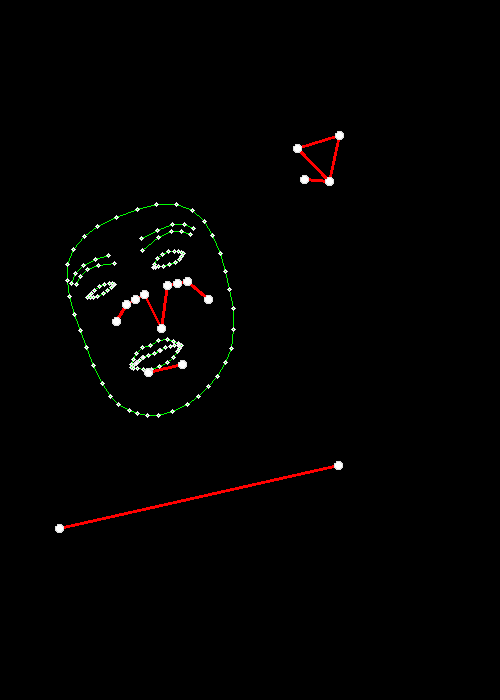
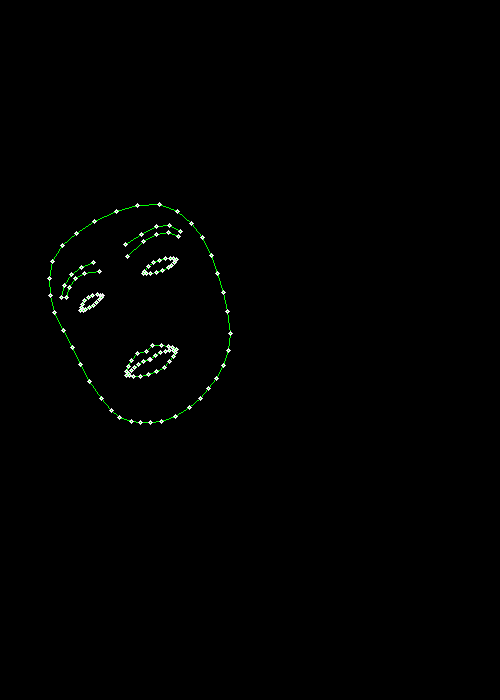
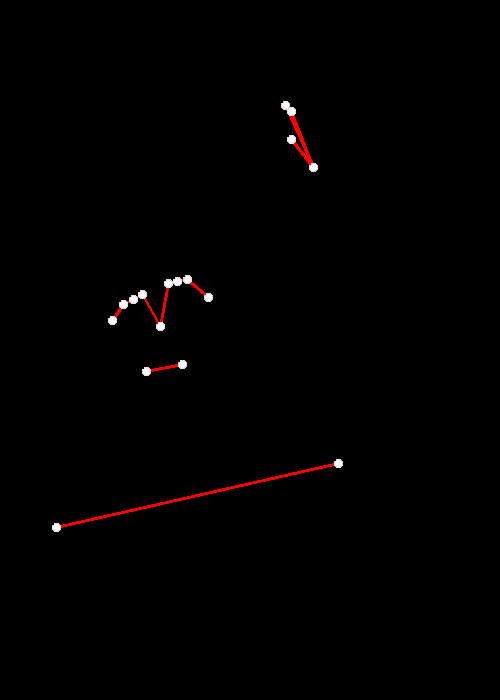
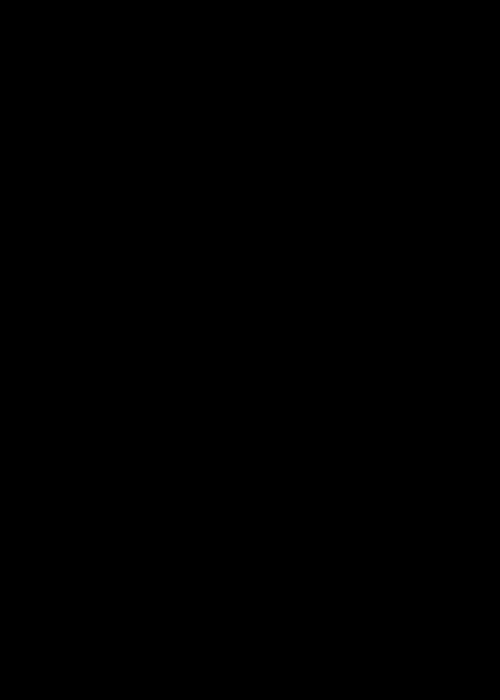
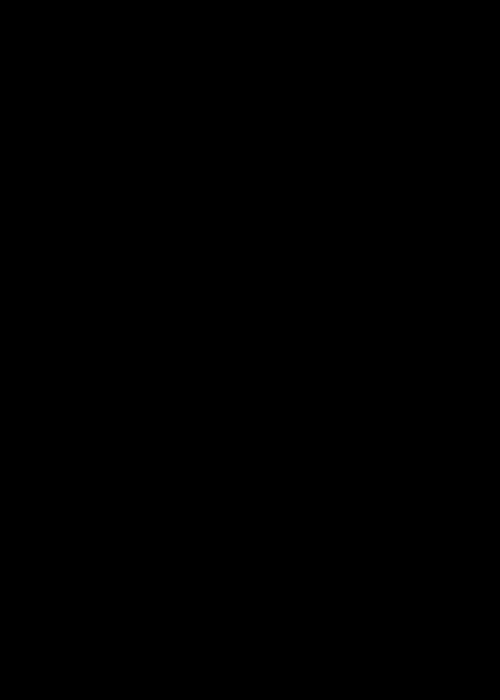
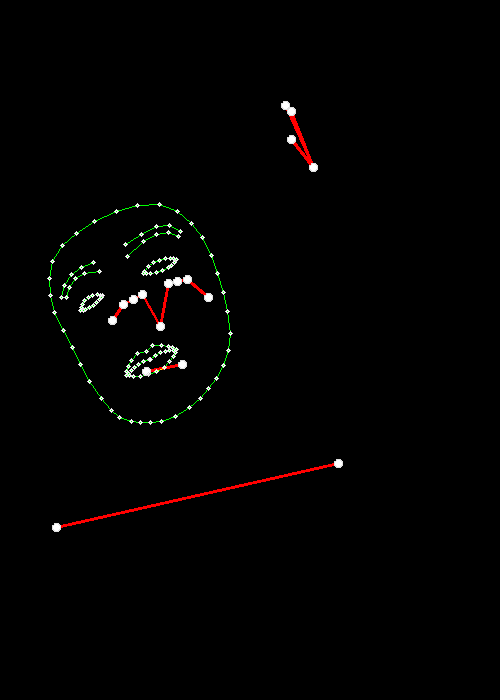
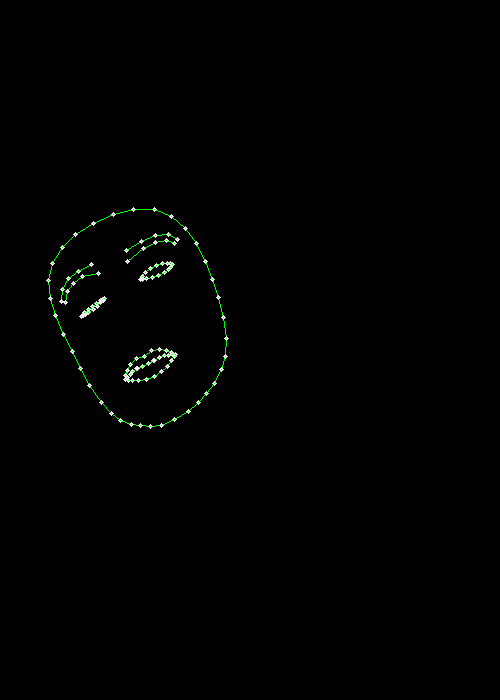
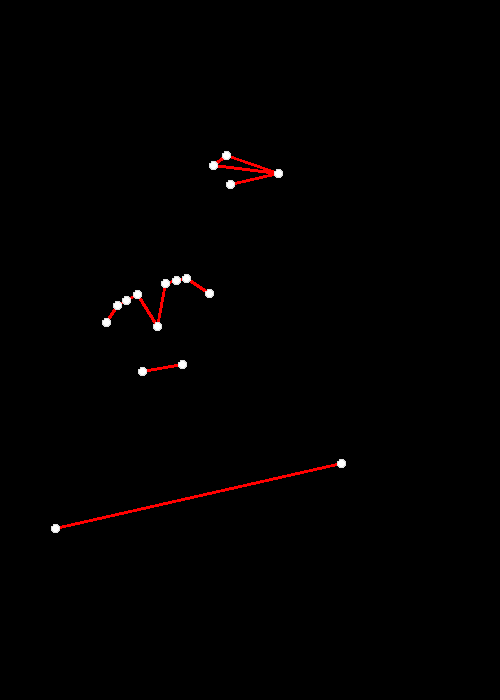
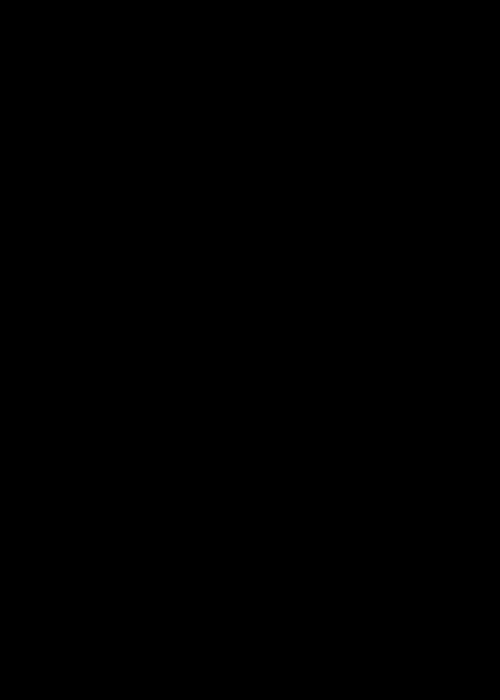
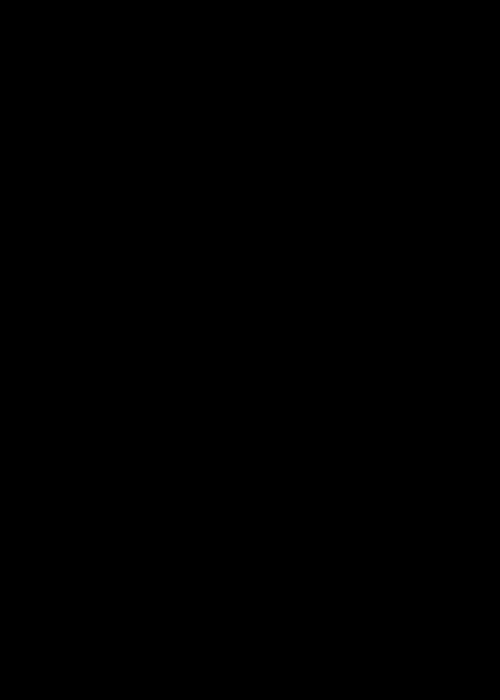
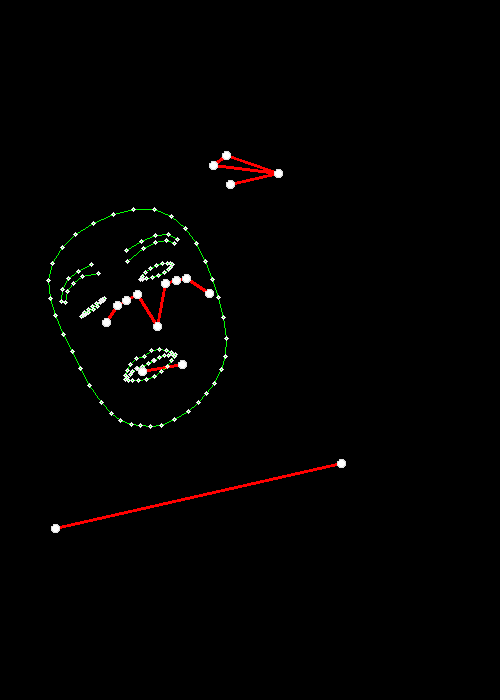
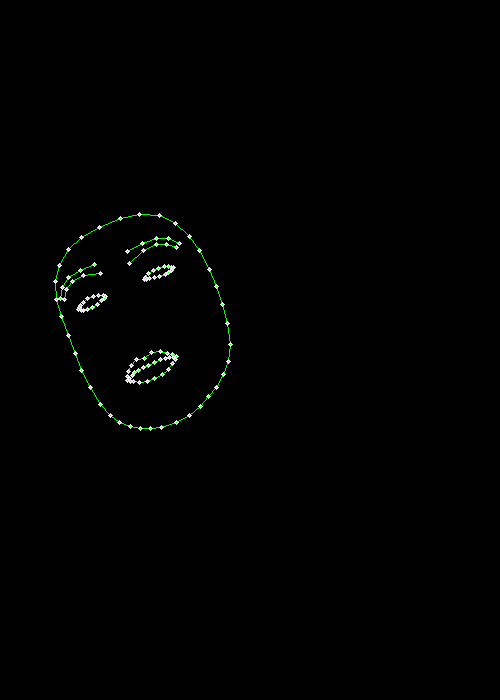
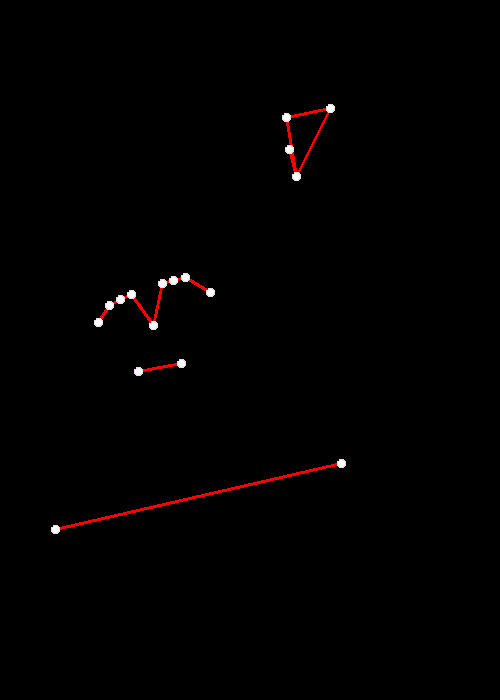
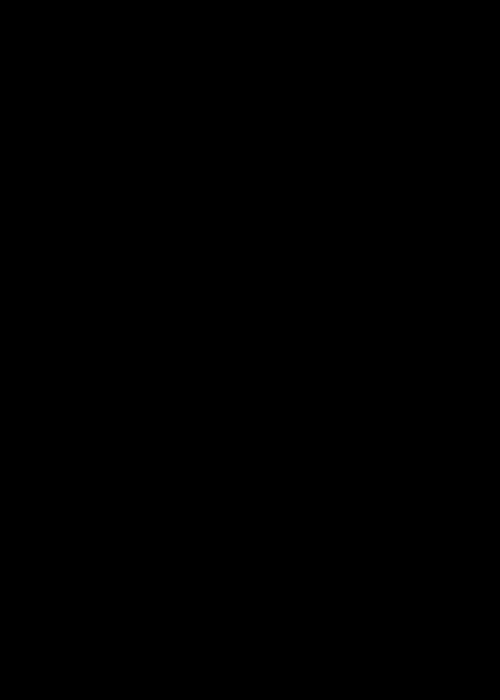
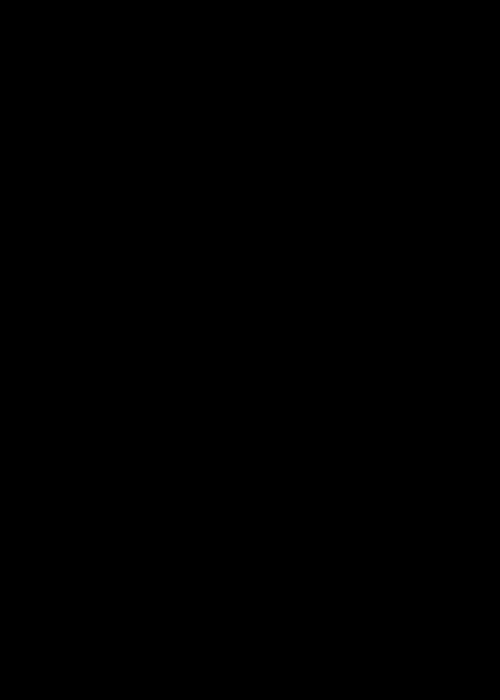
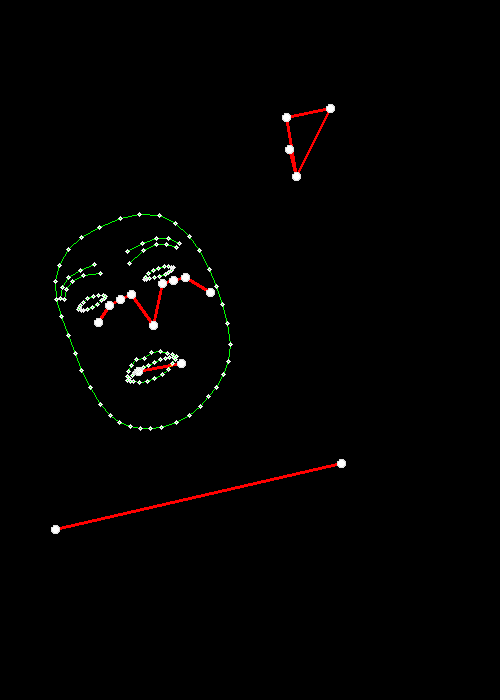
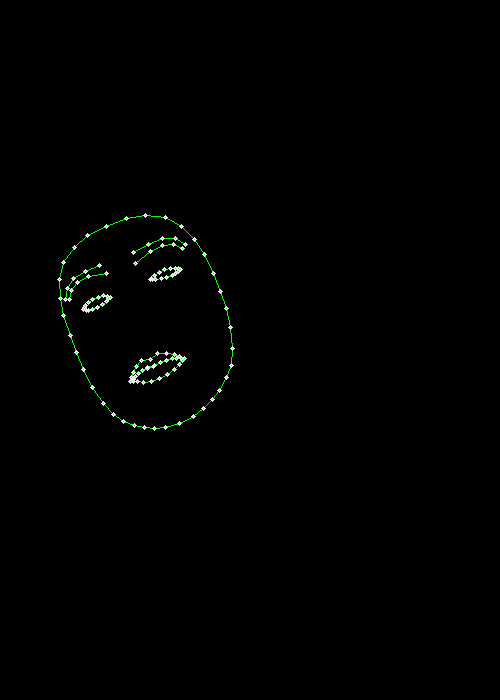
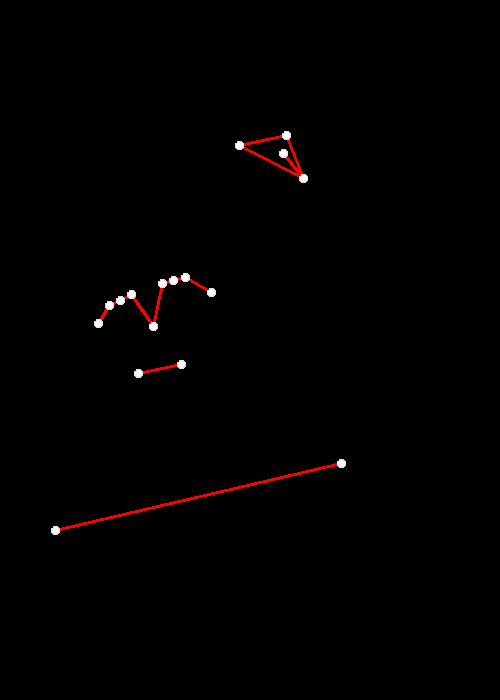
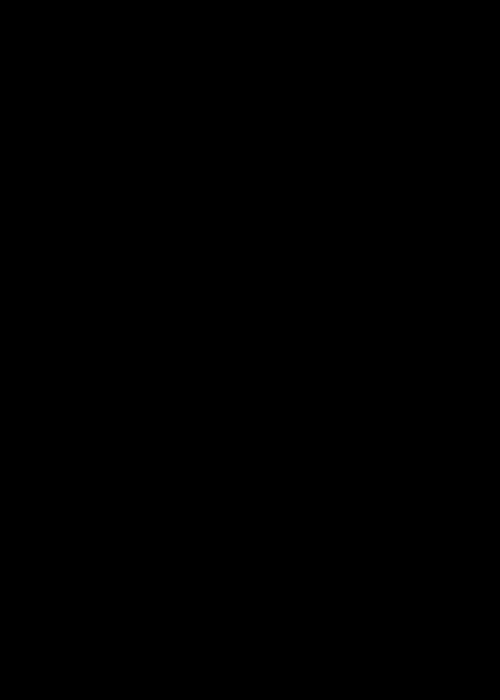
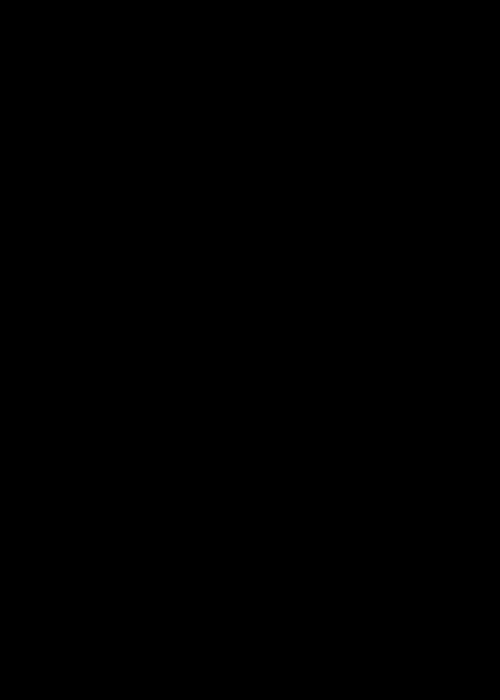
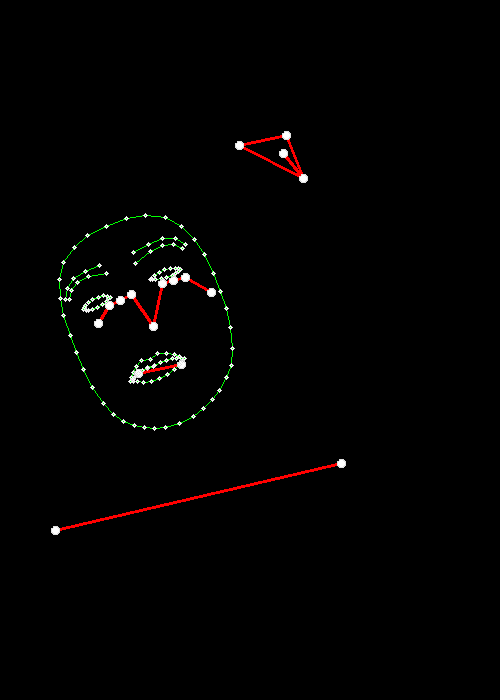
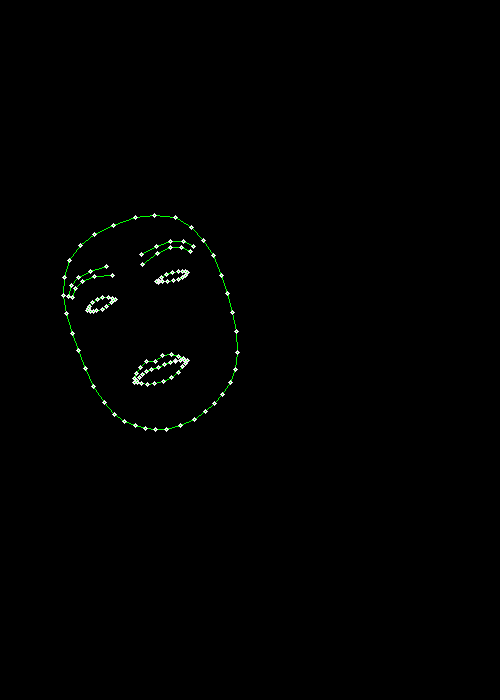
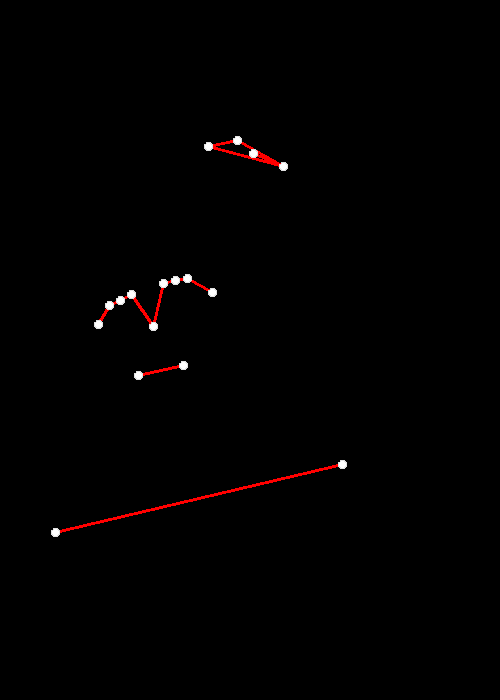
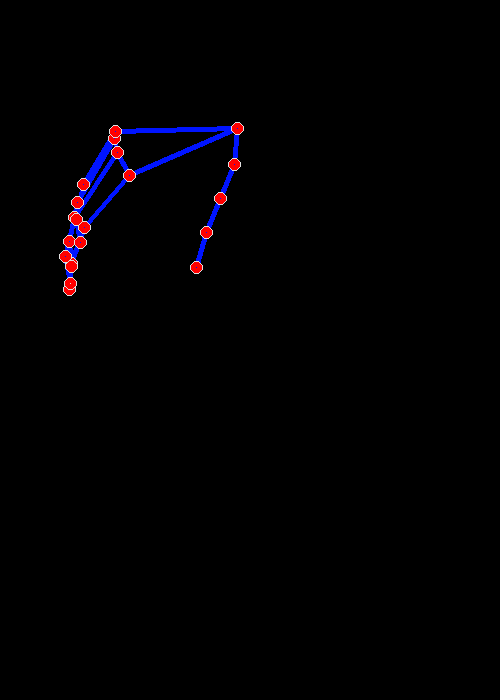
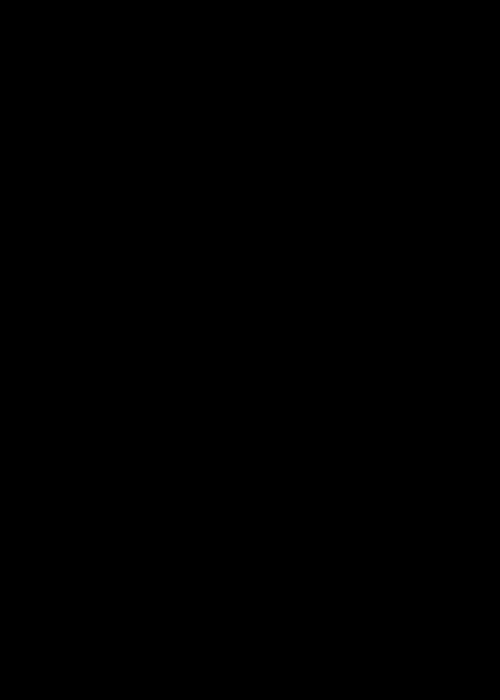
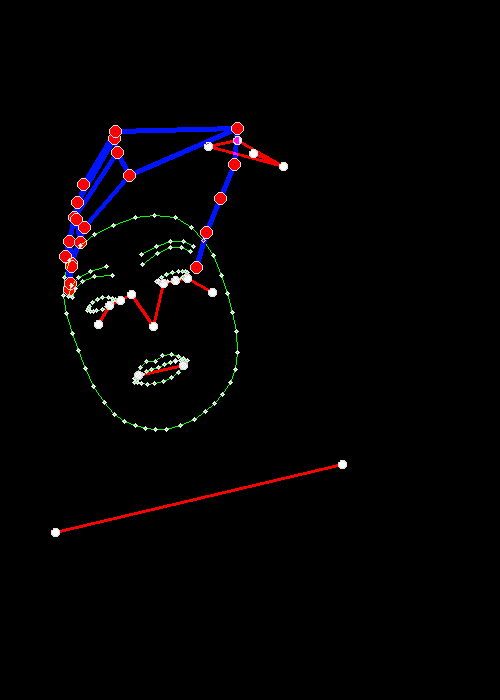
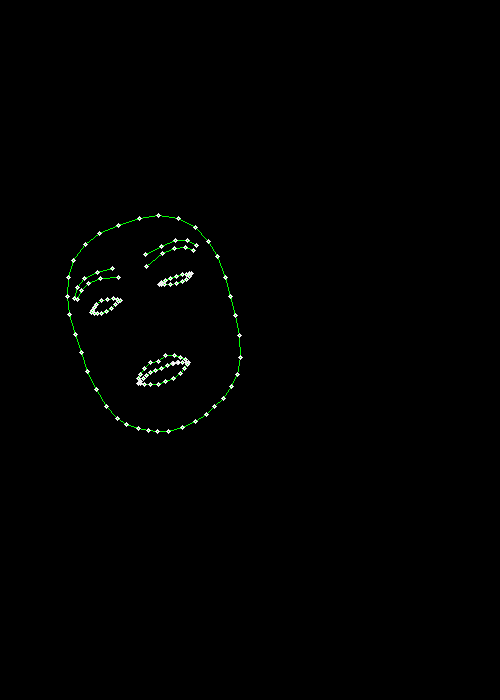
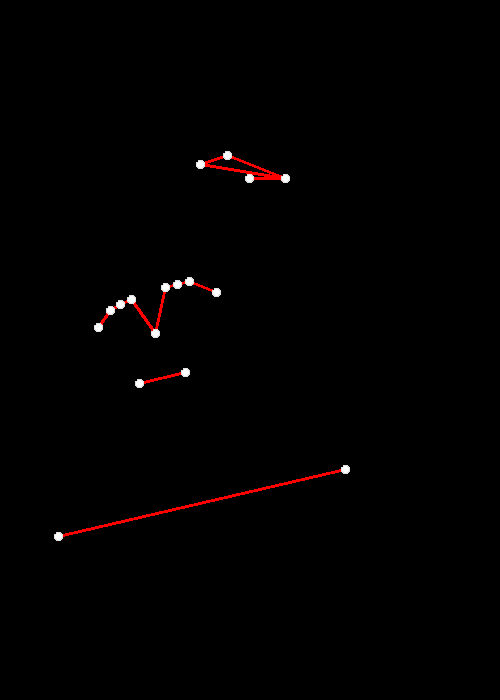
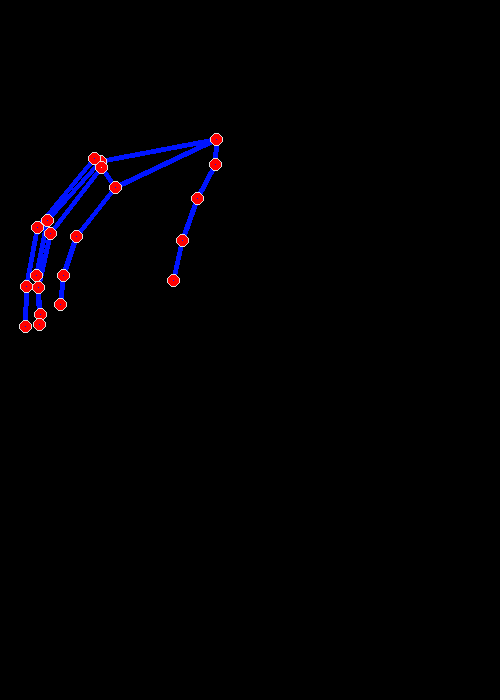
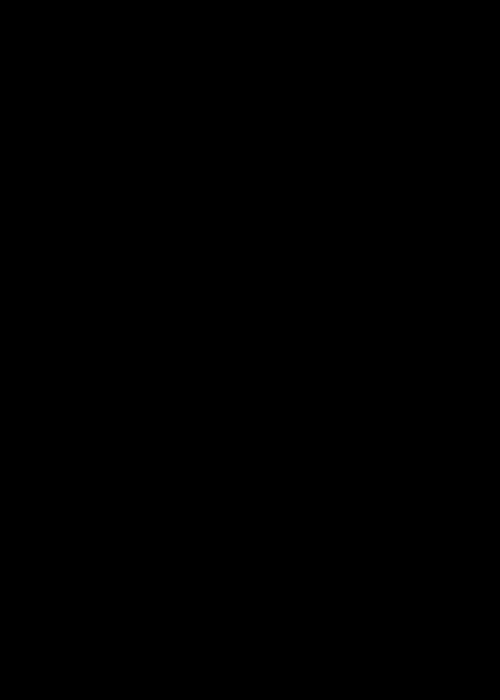
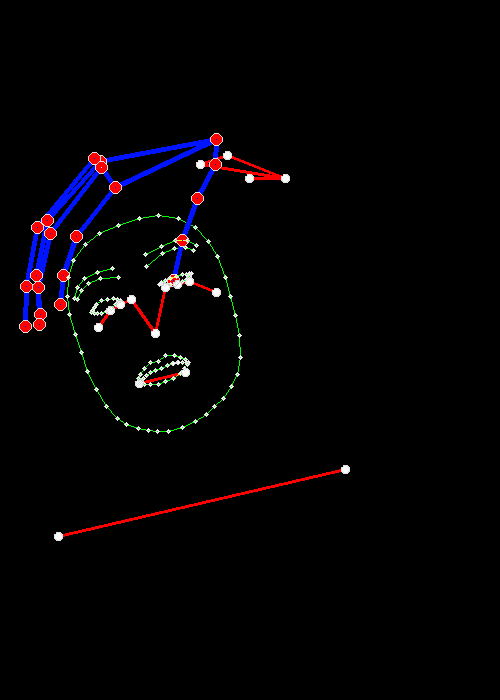
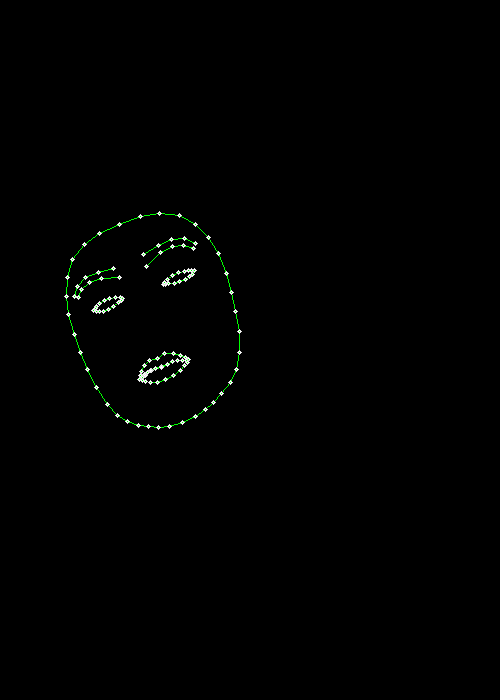
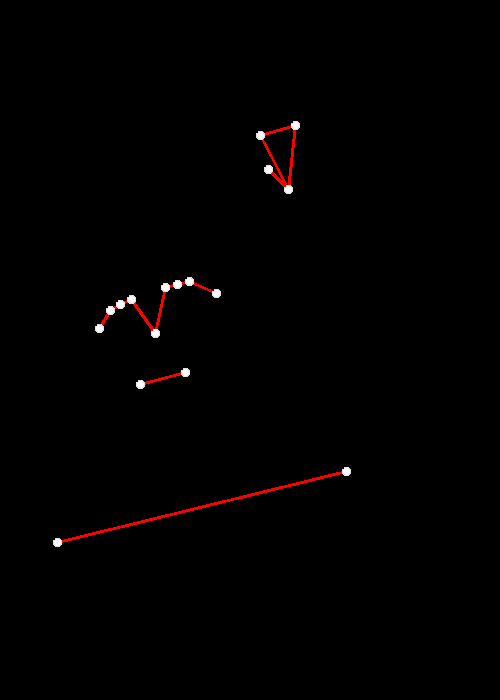
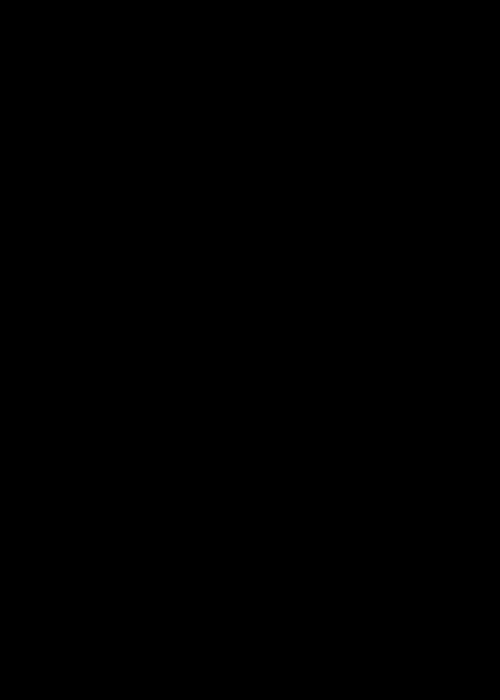
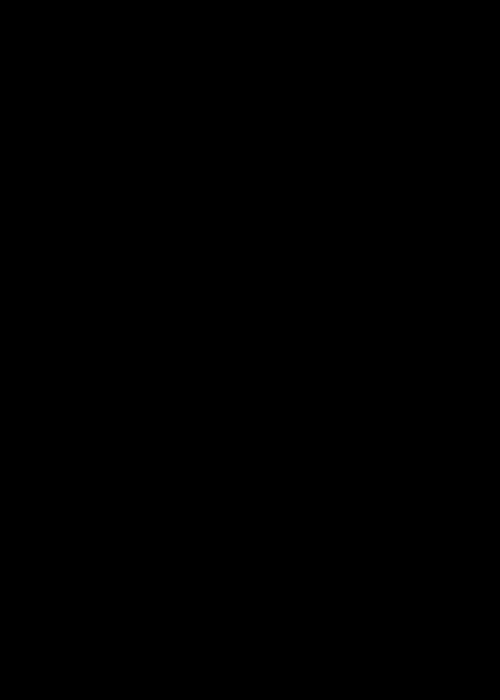
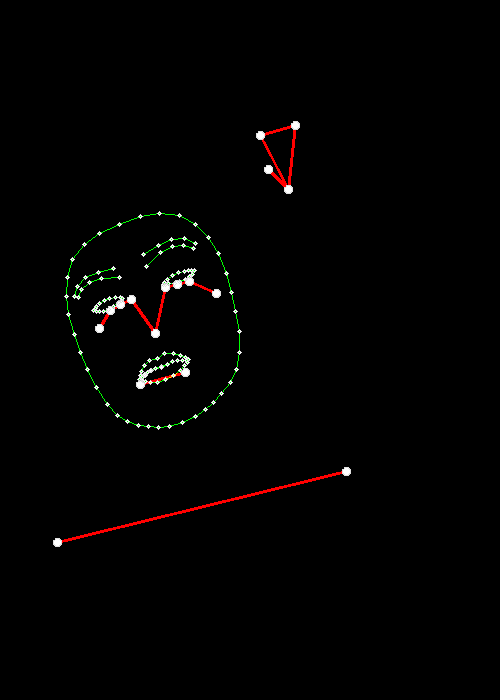
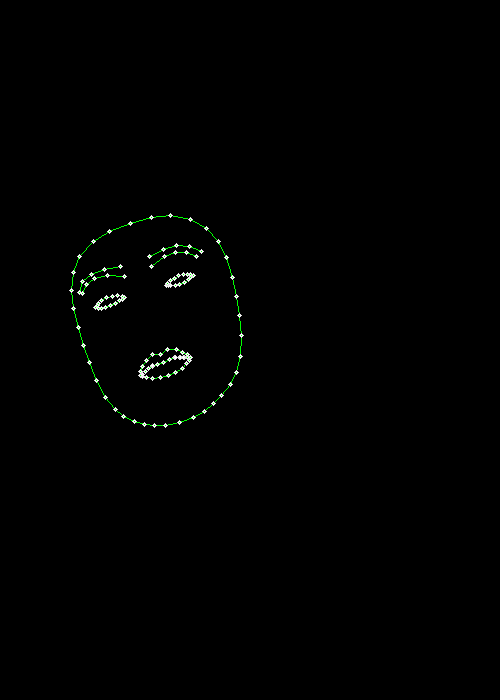
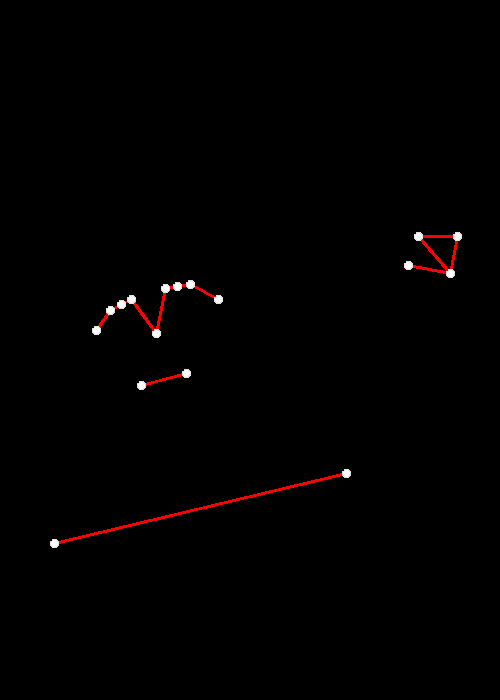
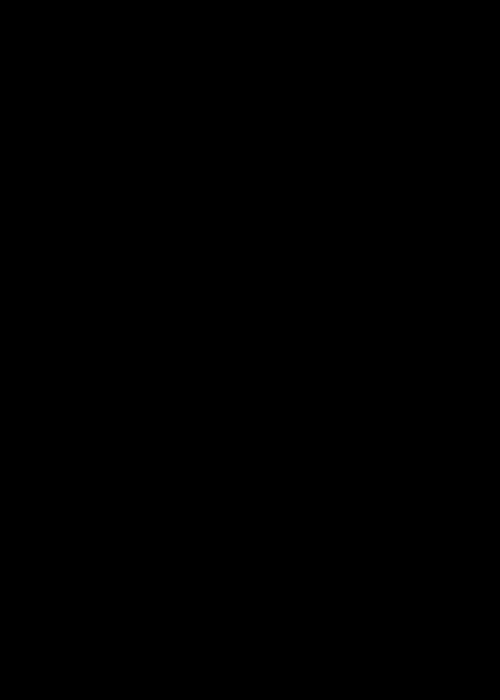
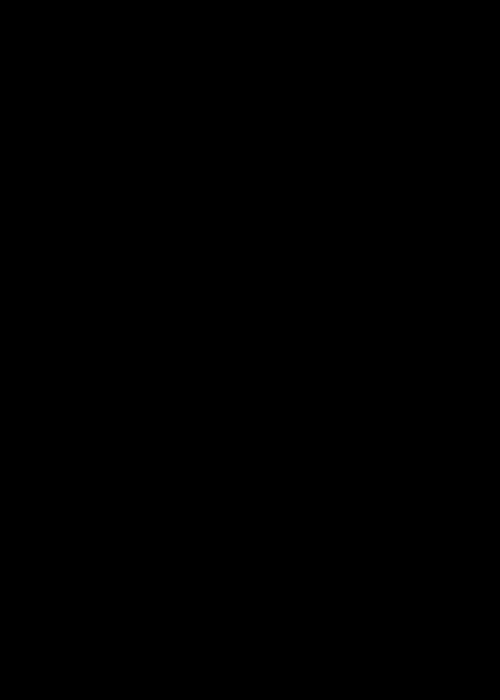
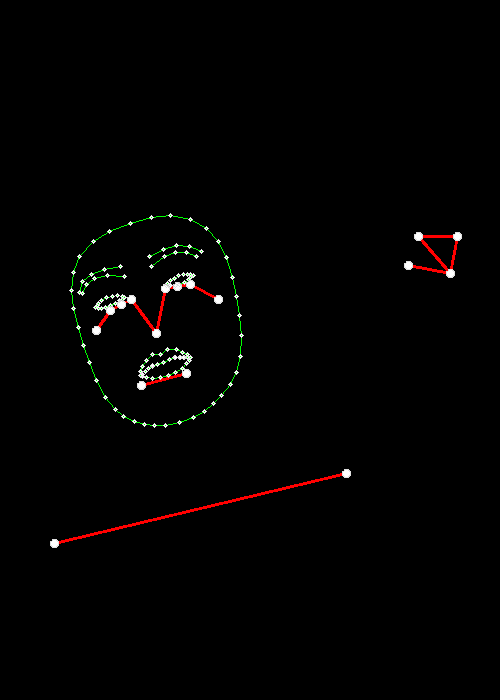
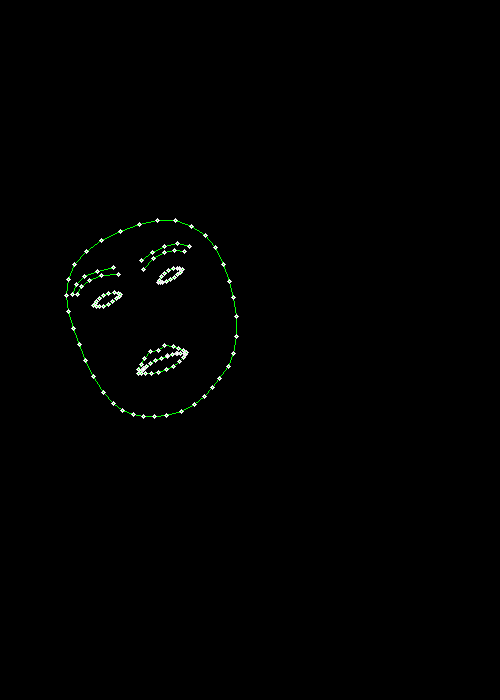
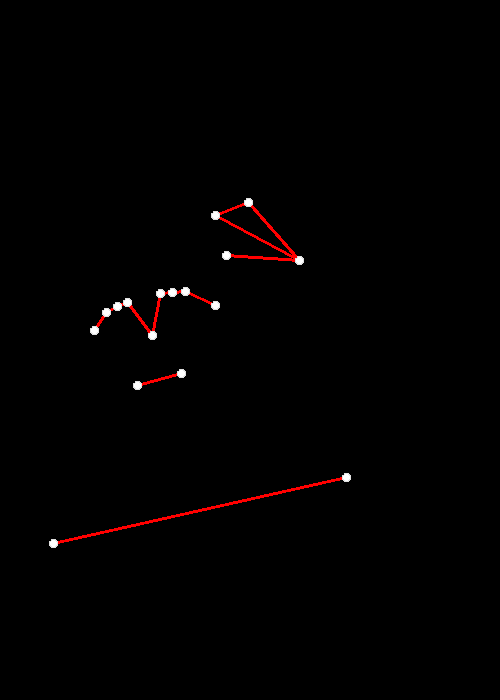
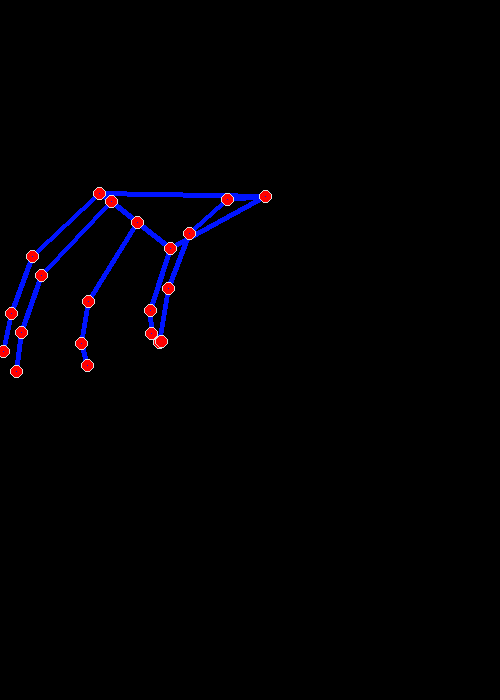
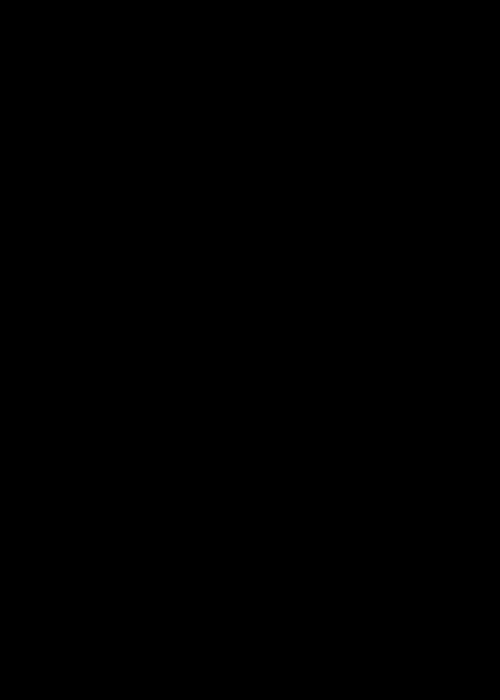
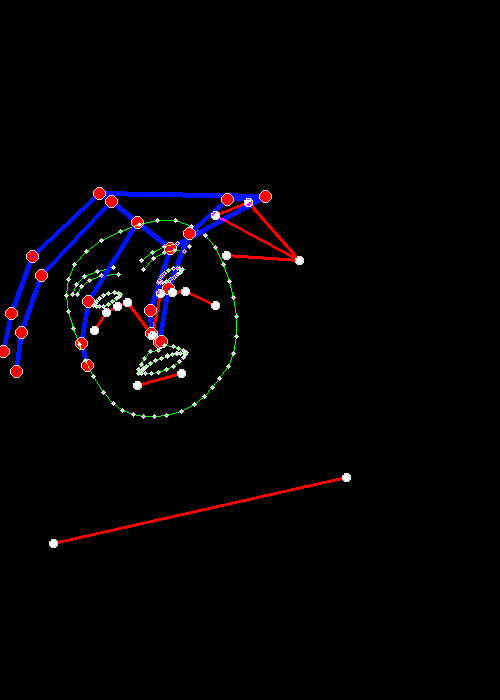
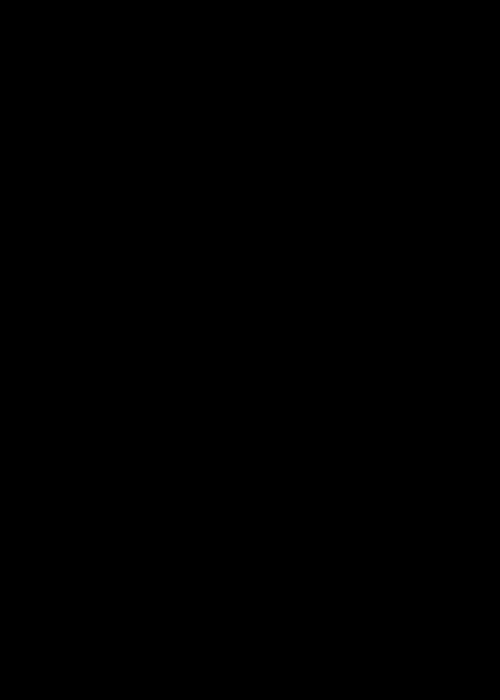
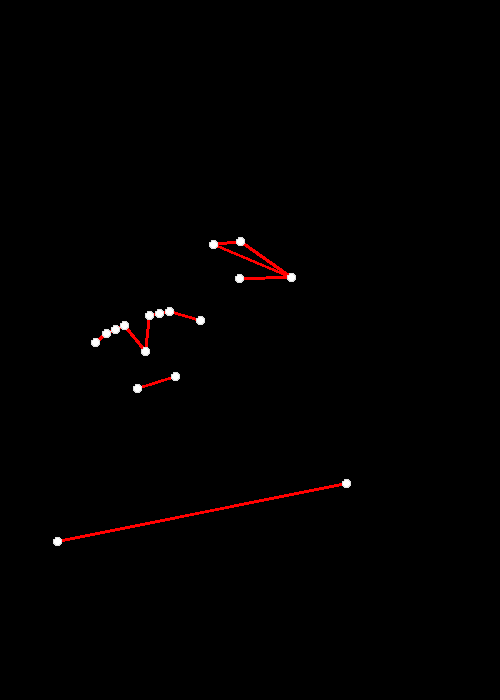
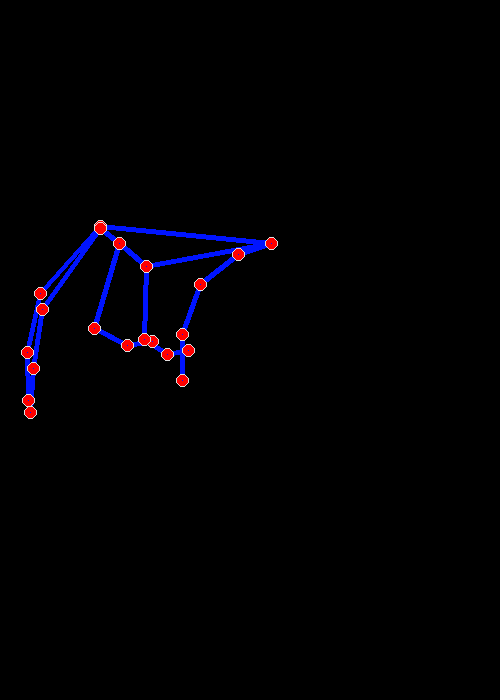
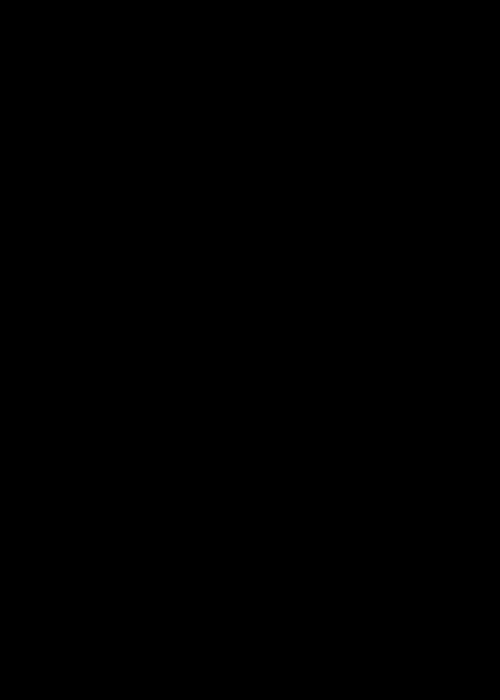
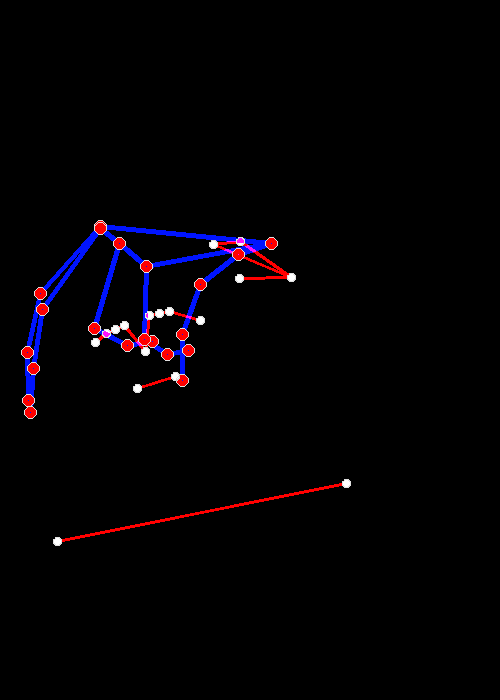

In [15]:
participant_id, sequence_id = get_ids(train_df[train_df['sign'] == 'cloud'], 10 )
fig = draw_data(participant_id,sequence_id,train_data)
fig.show(config= dict(displayModeBar = False))

<span style="font-size:20px; font-family:Georgia;"><b>Example 3: Flower</b></span>


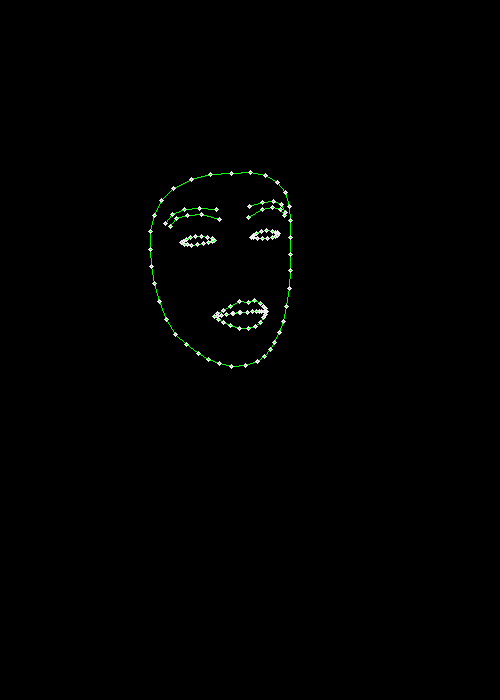
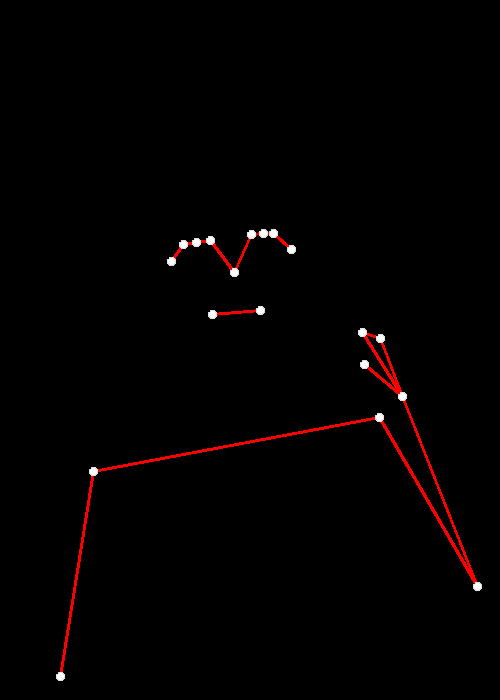
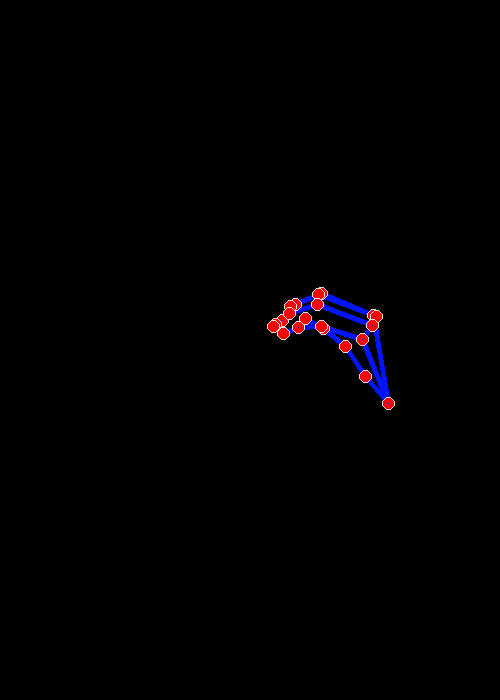
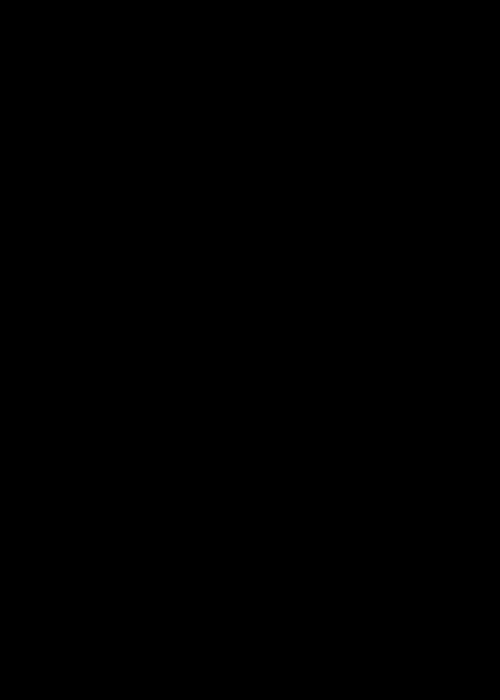
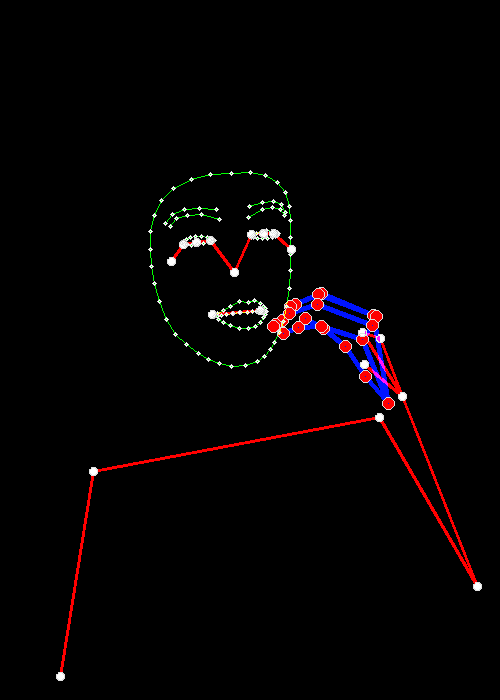
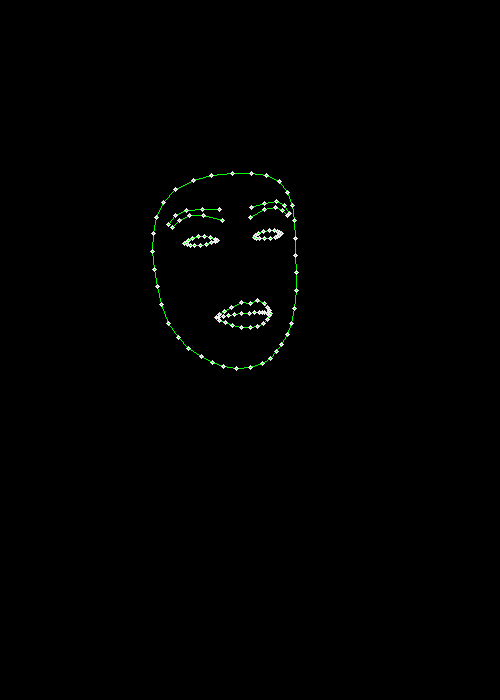
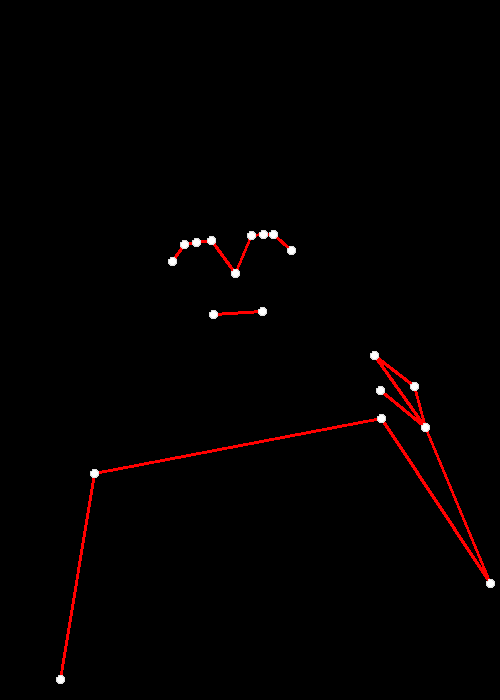
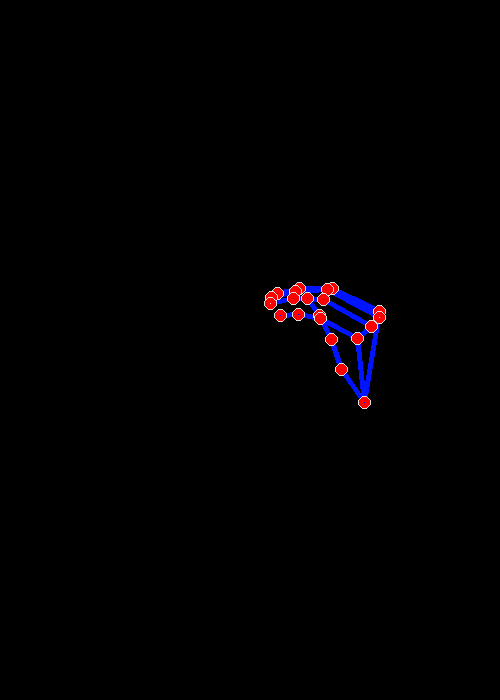
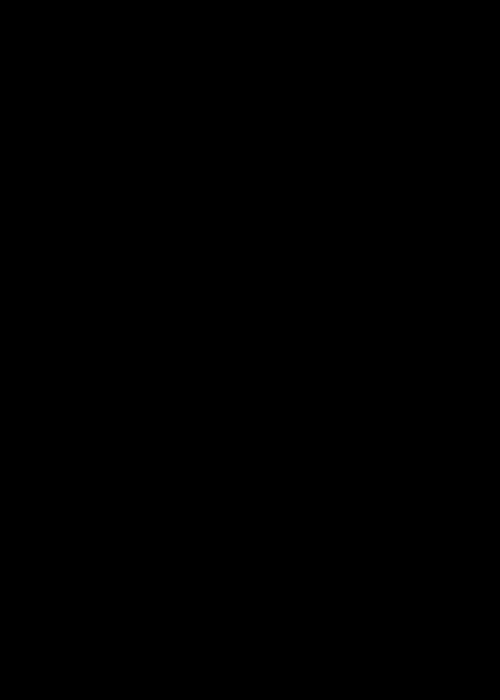
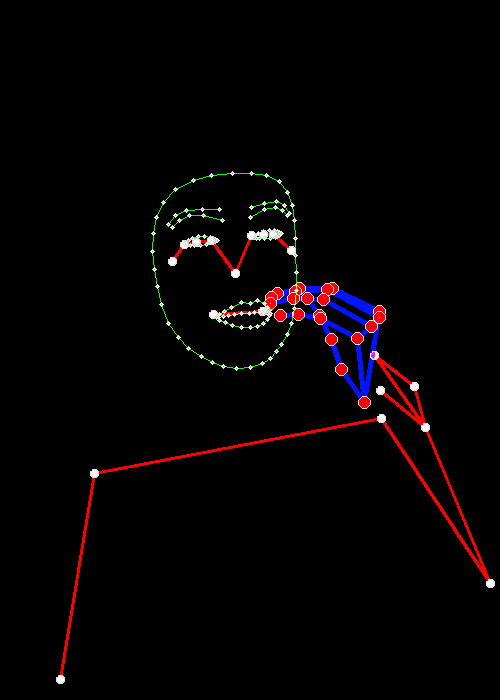
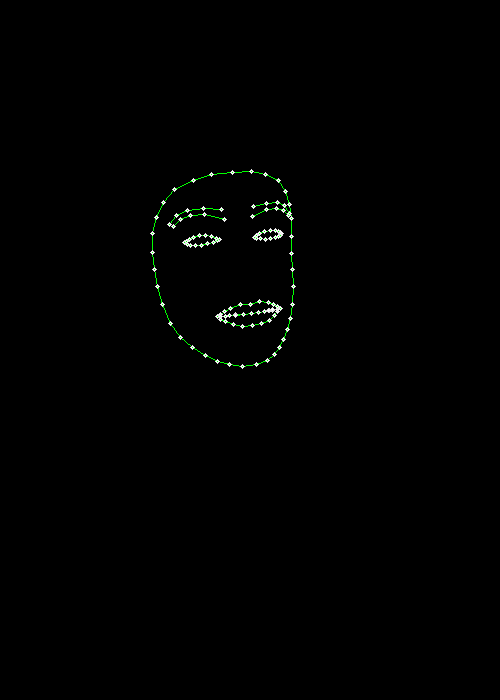
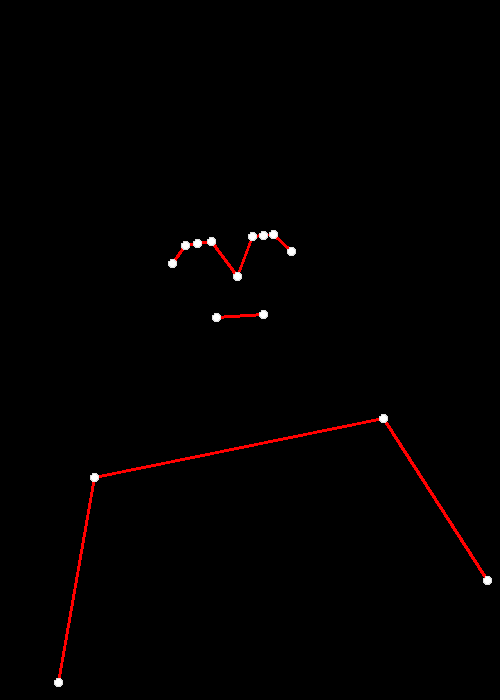
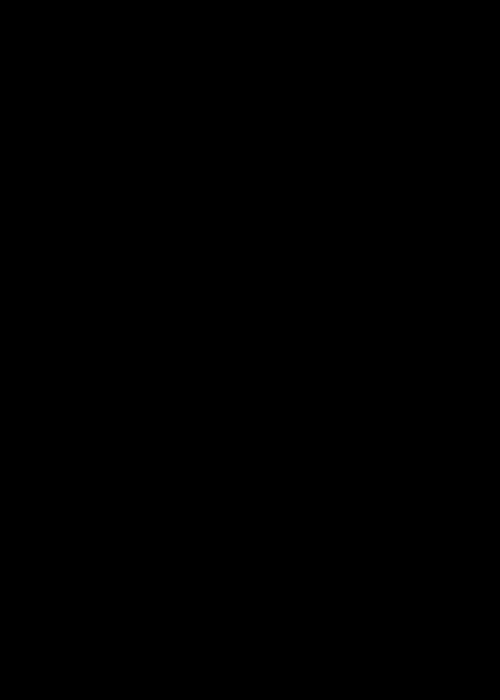
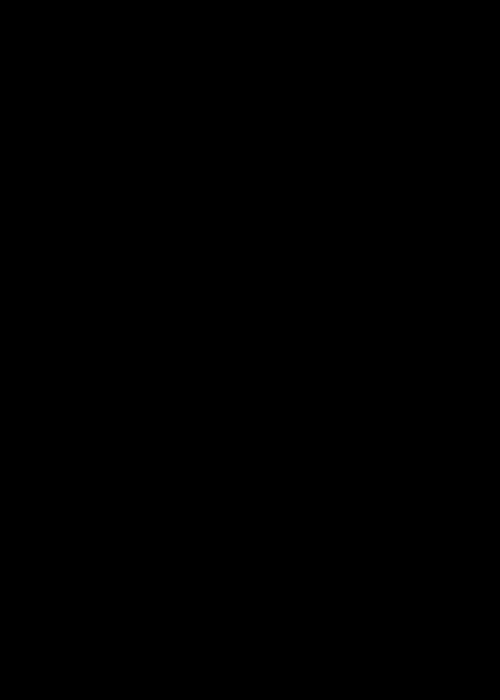
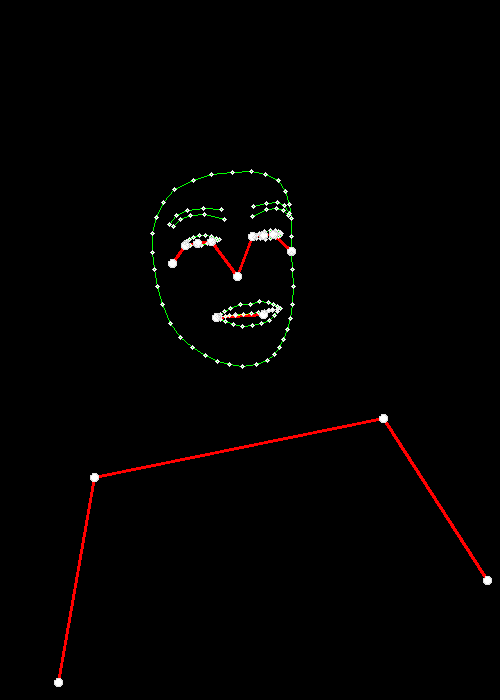
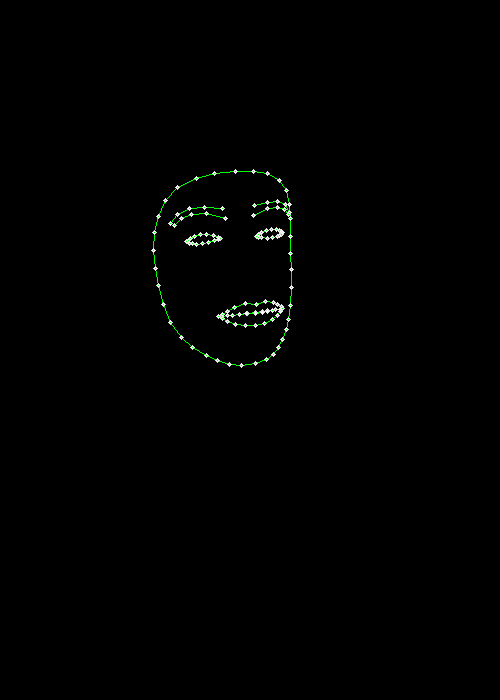
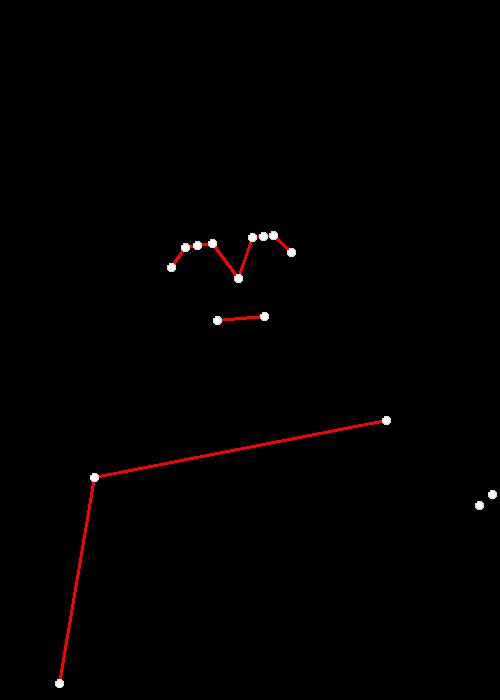
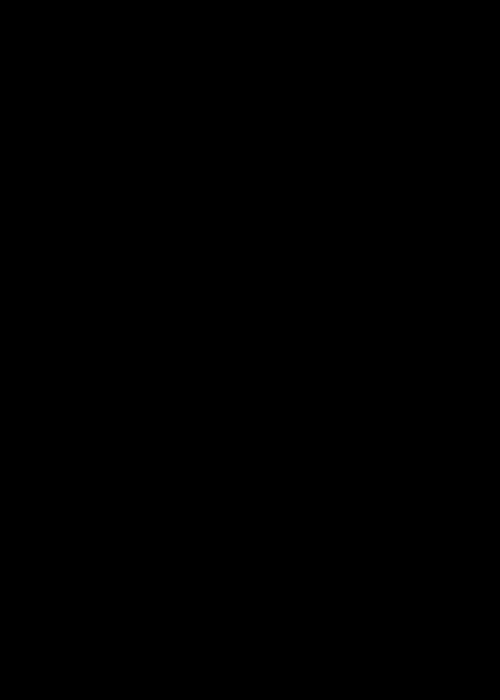
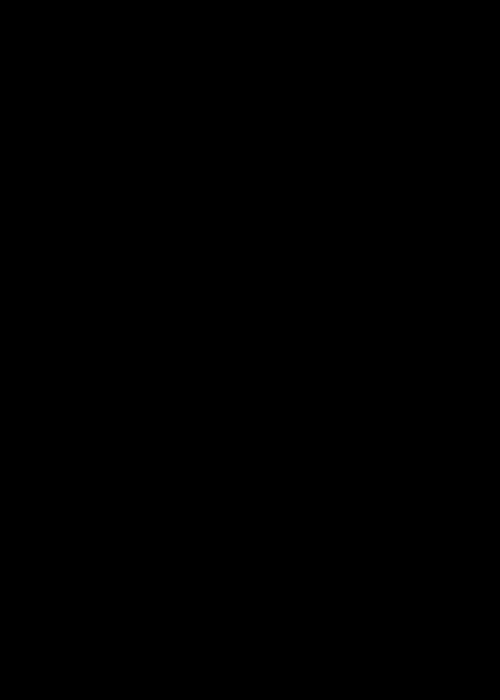
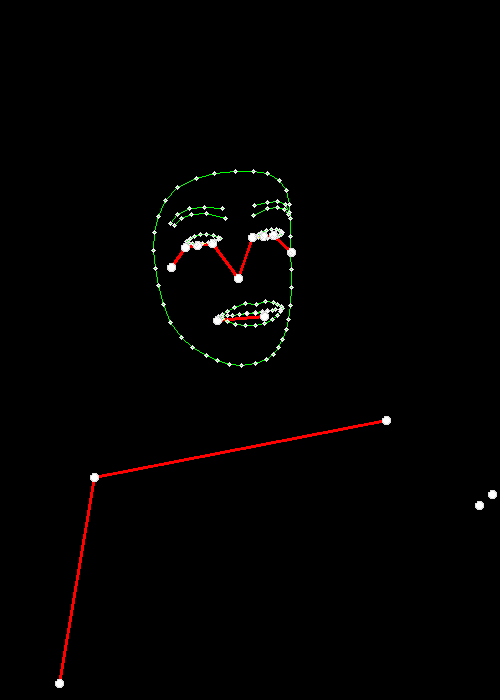
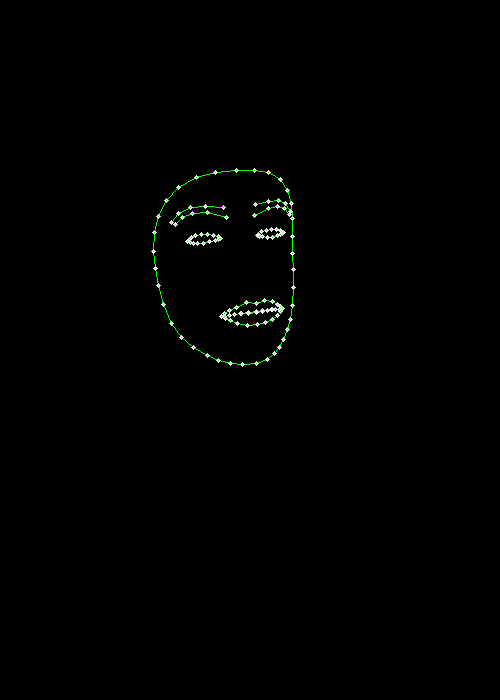
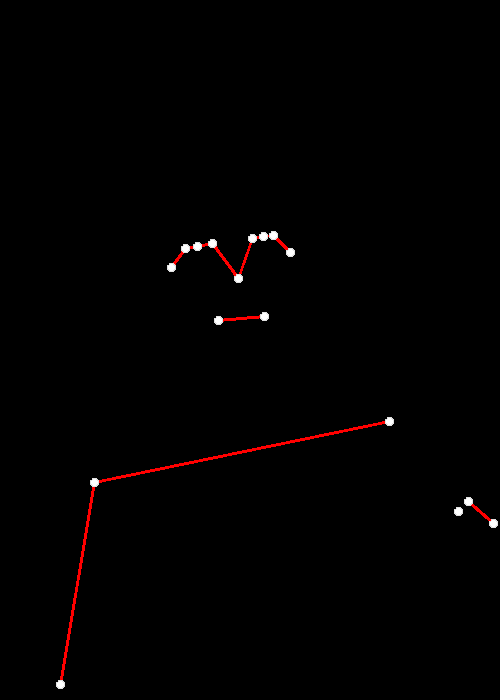
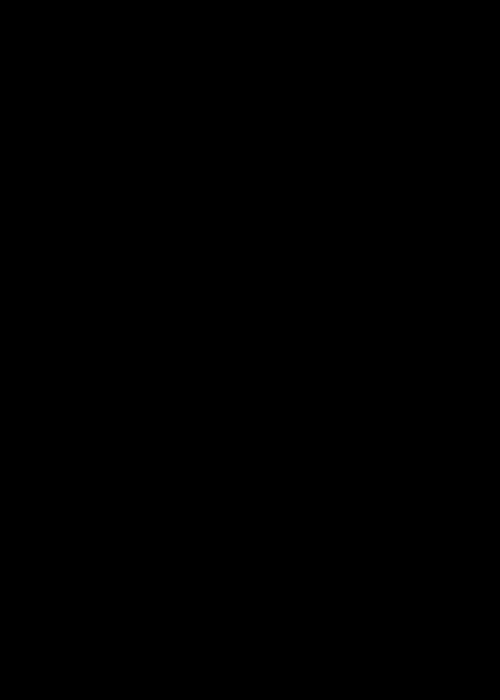
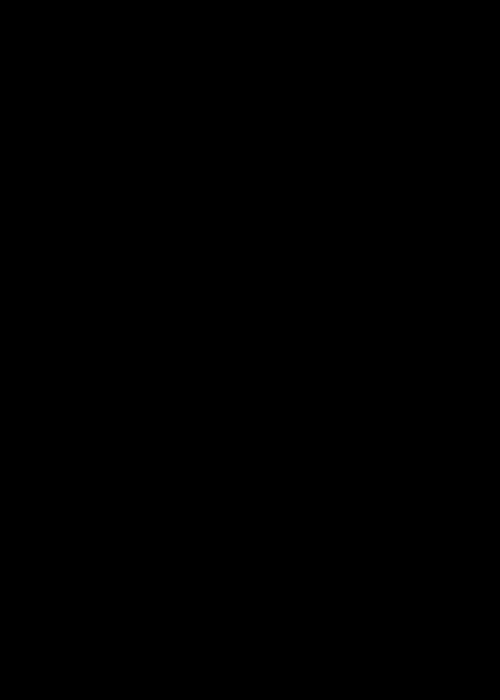
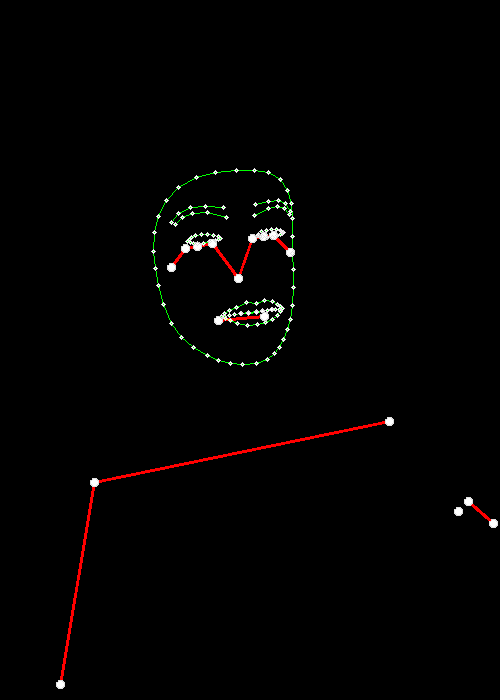
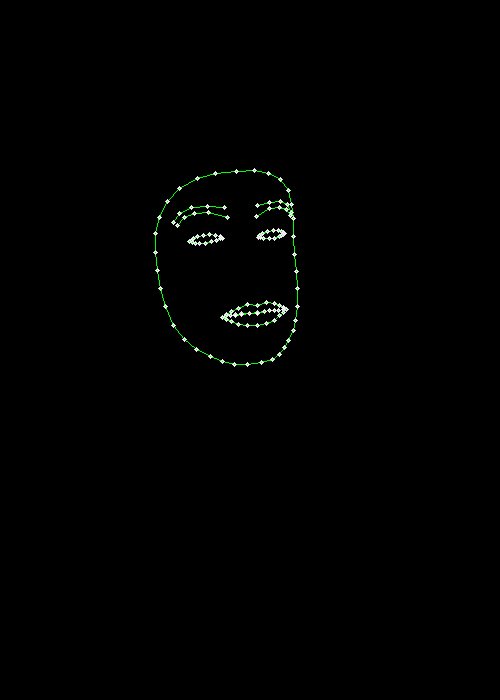
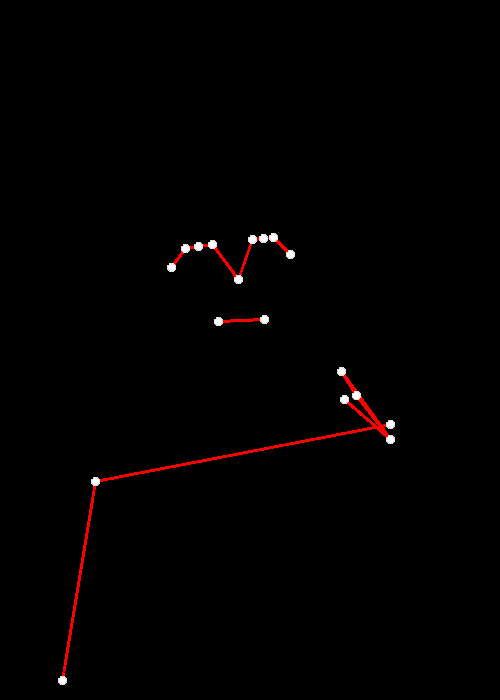
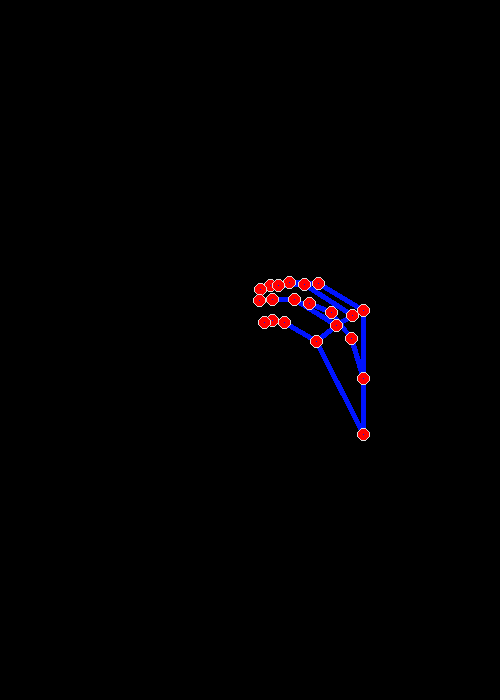
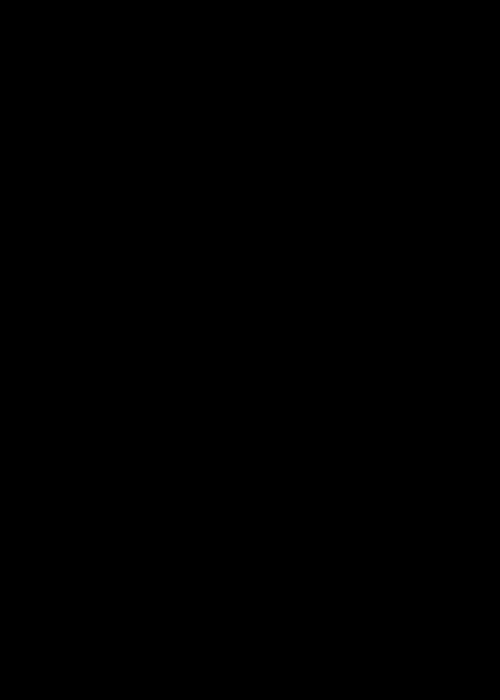
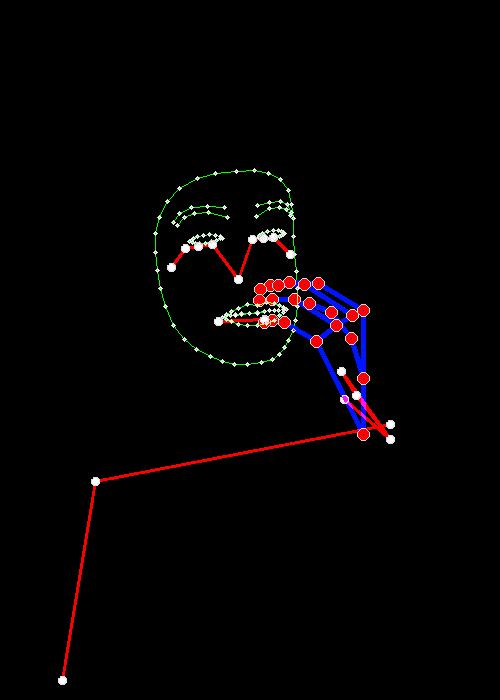
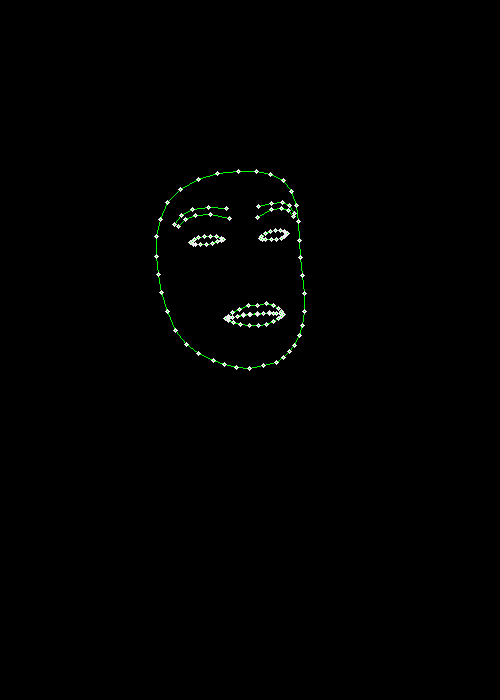
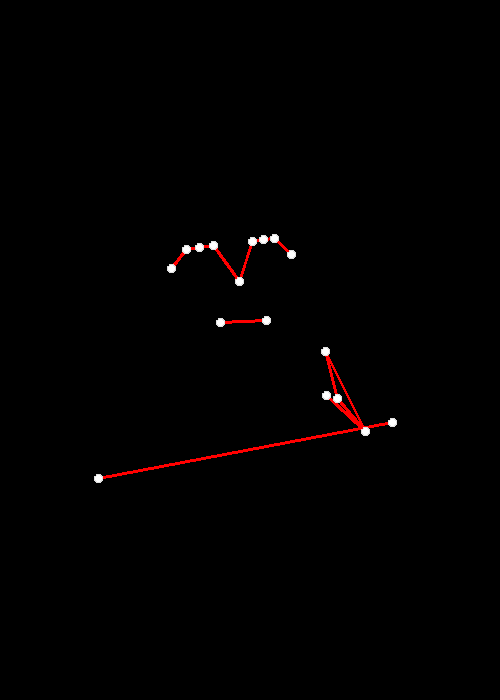
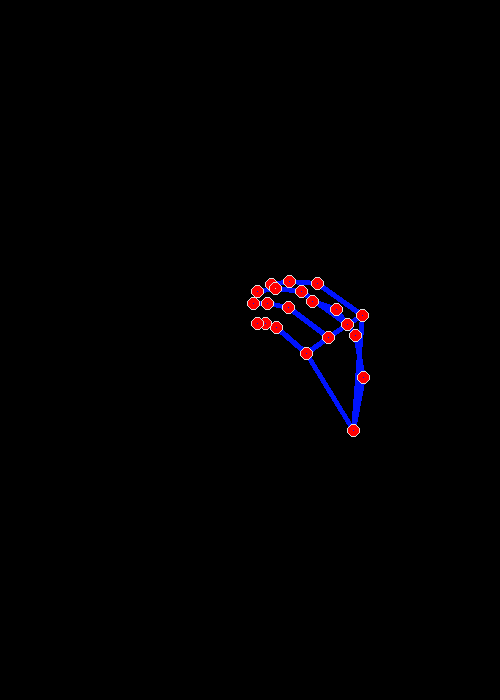
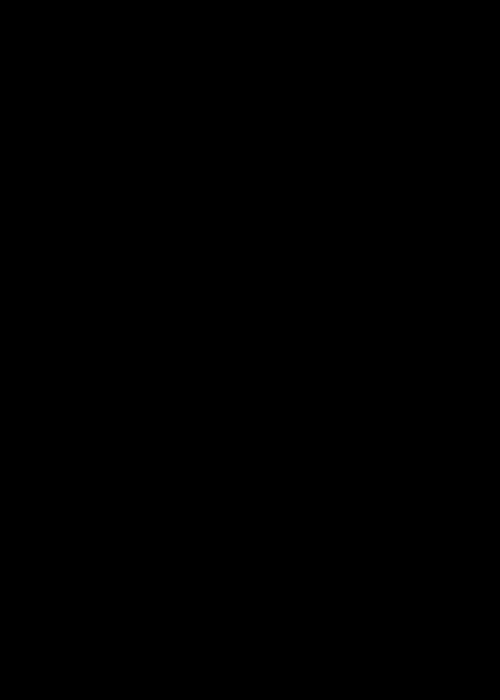
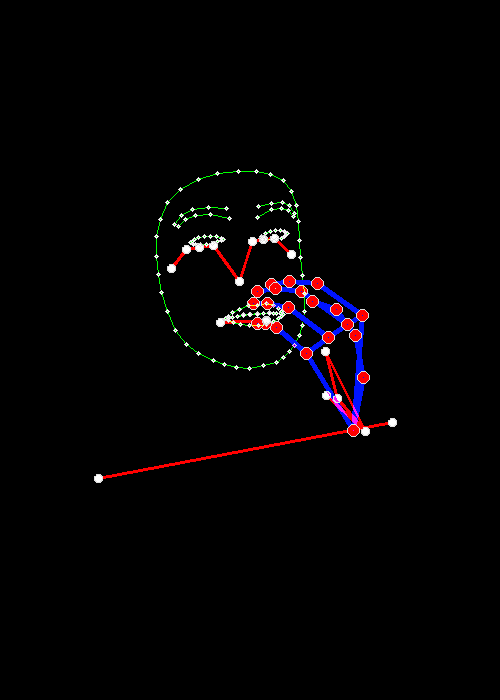
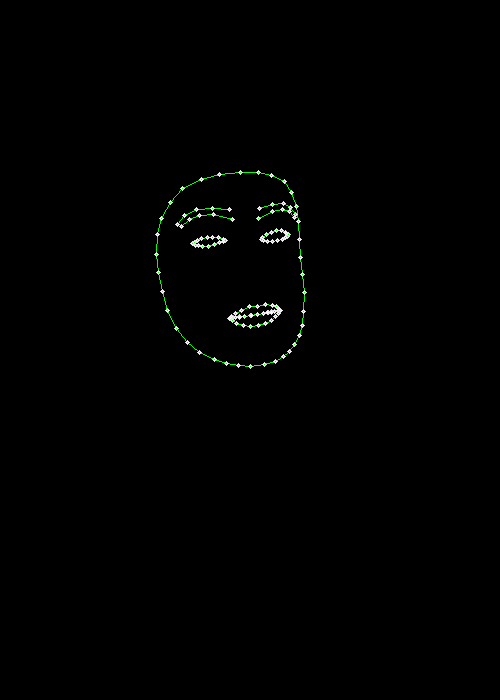
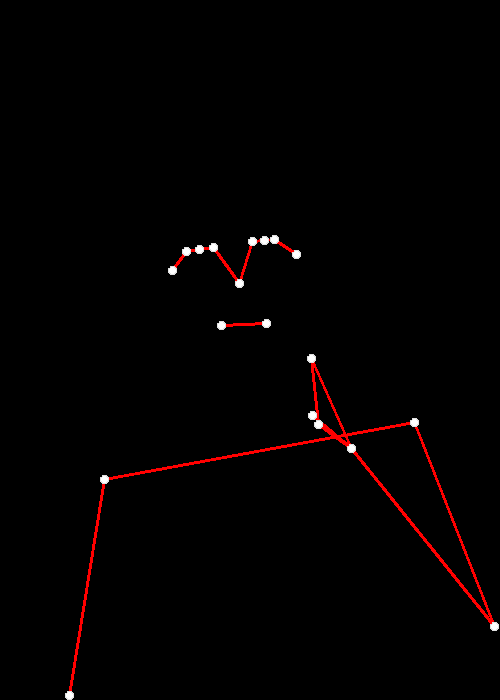
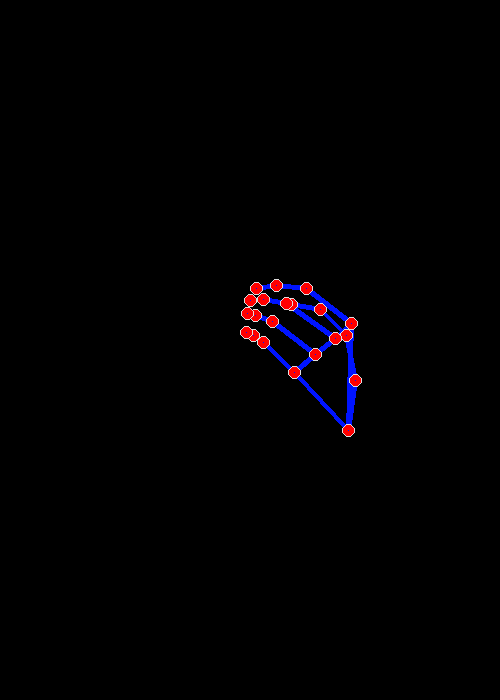
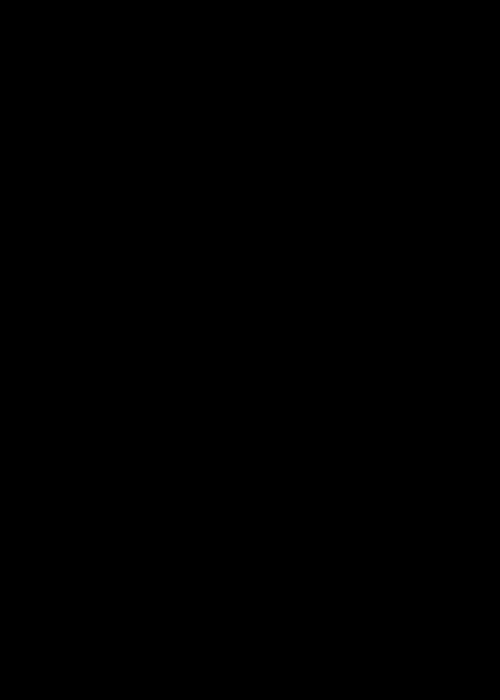
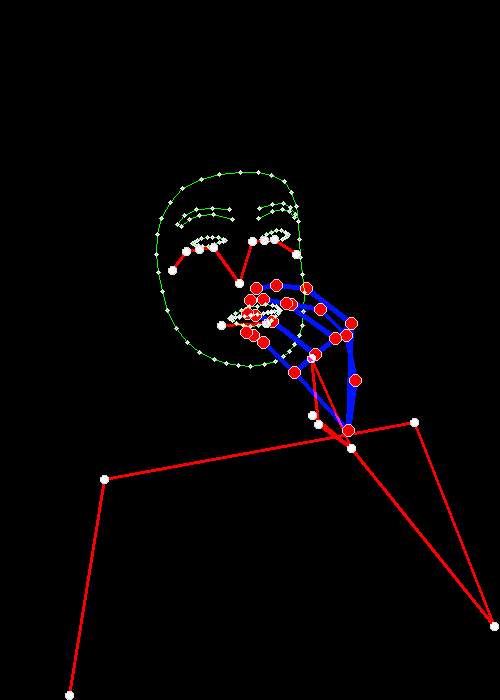
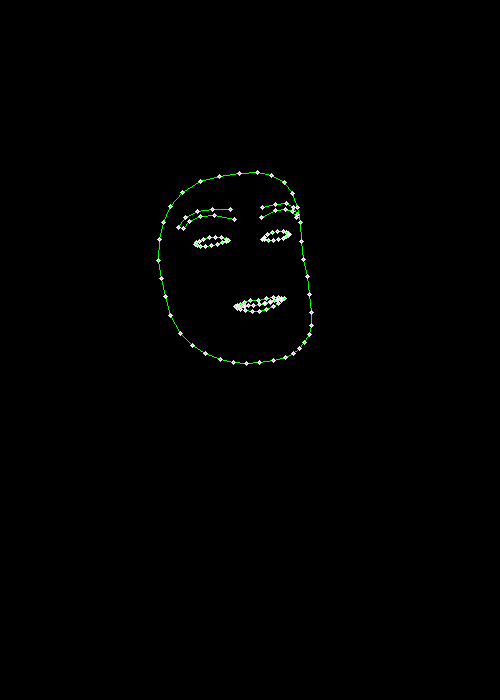
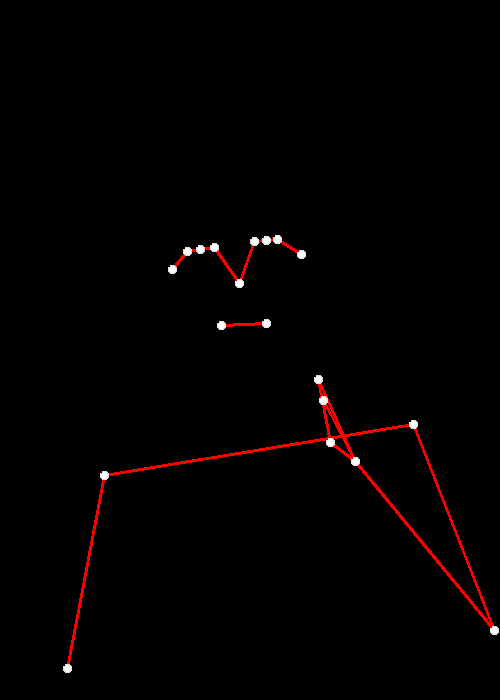
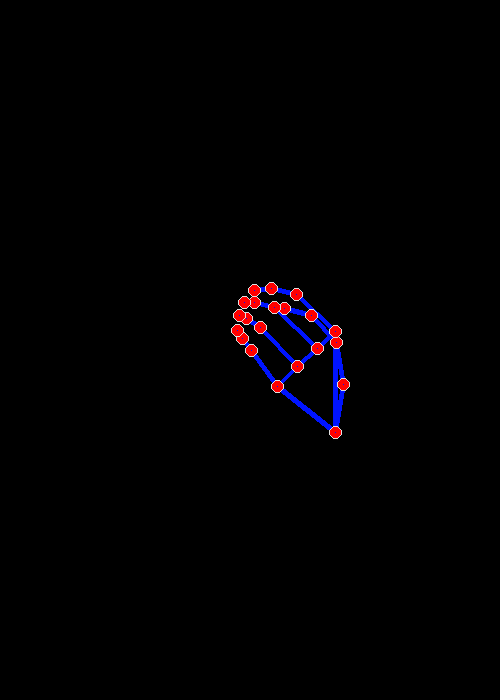
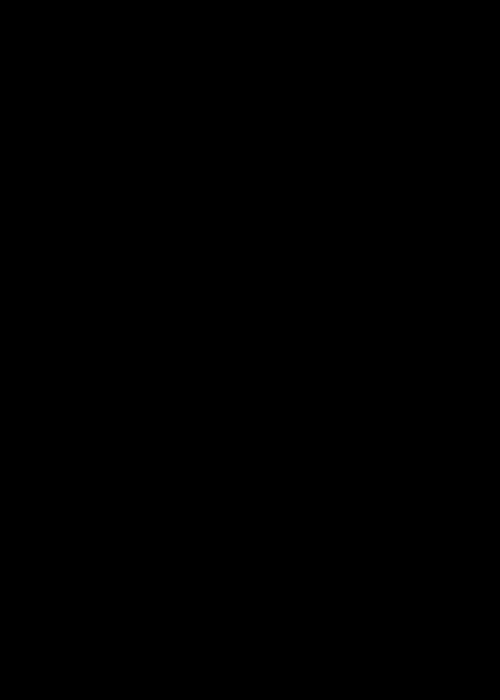
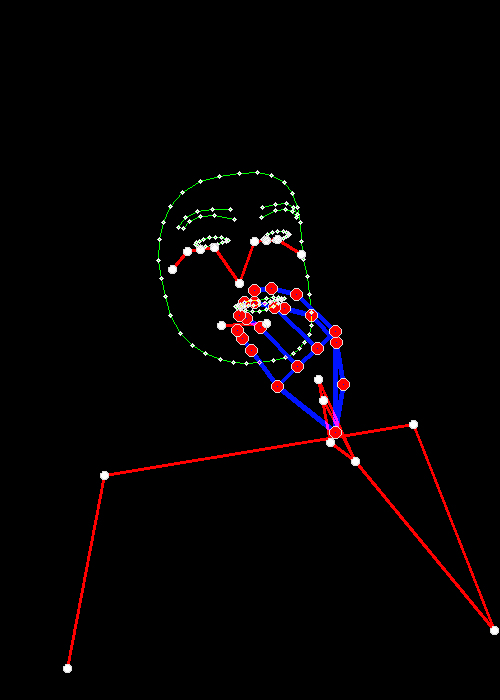
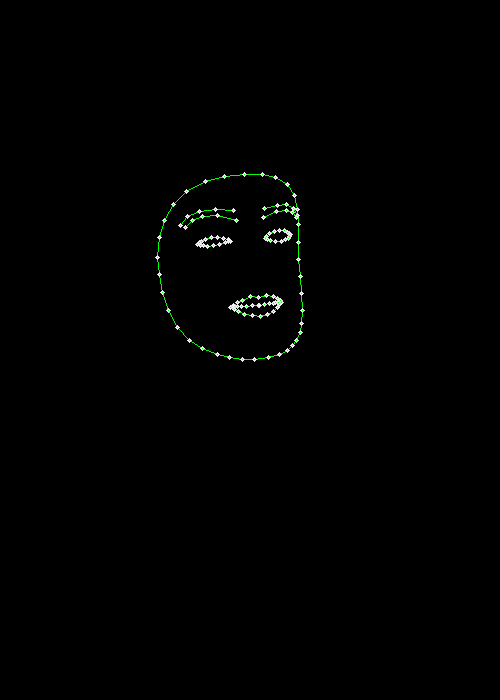
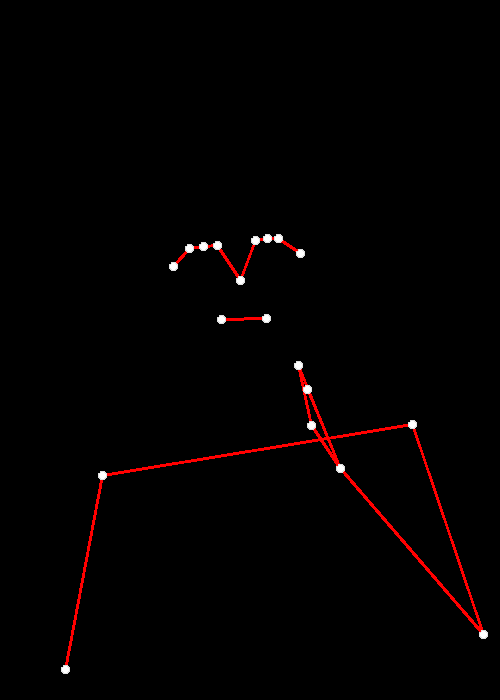
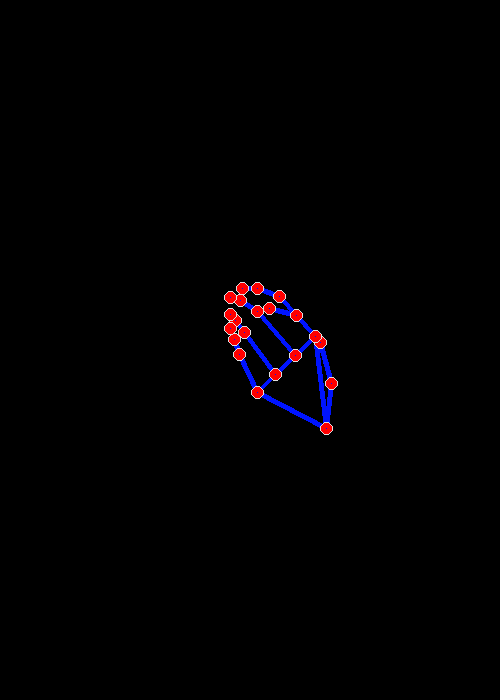
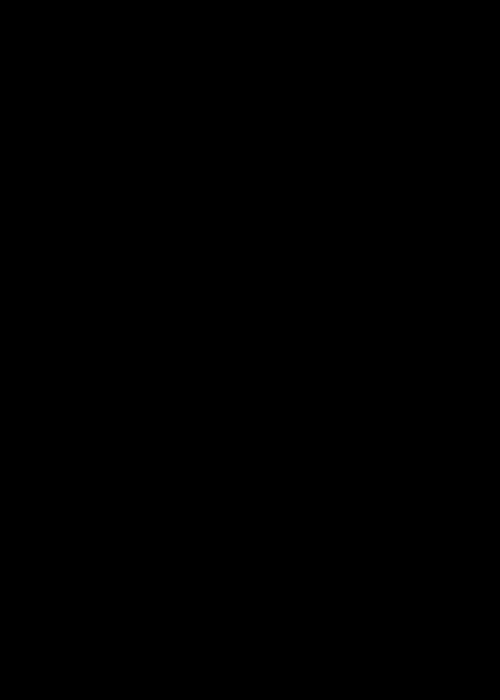
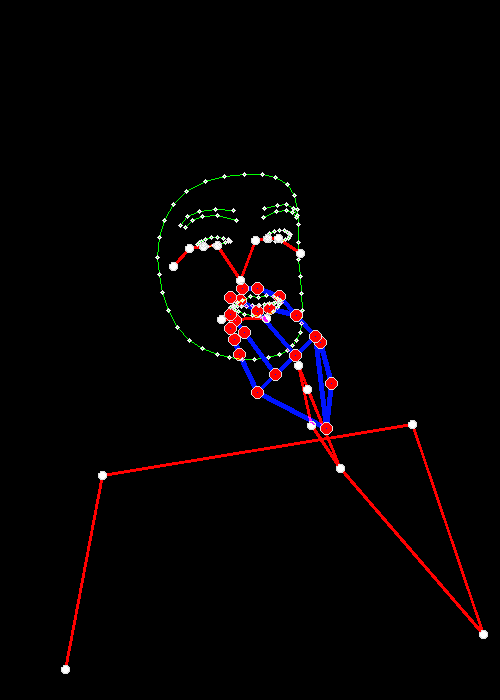
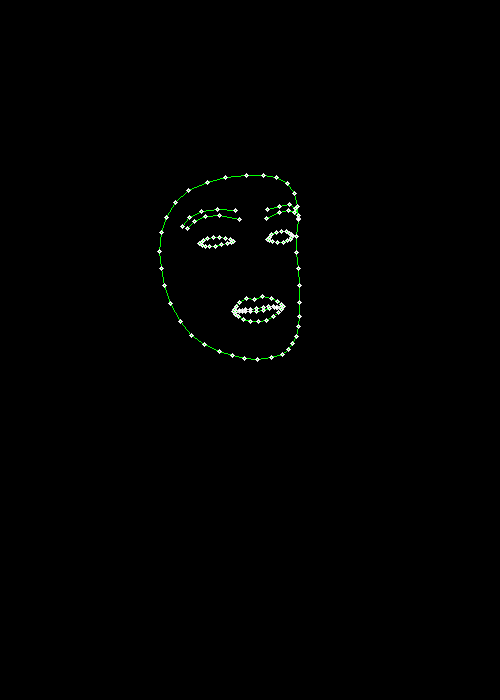
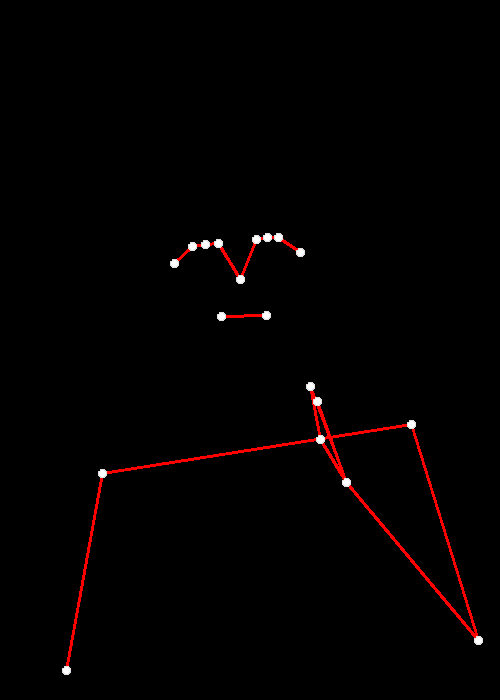
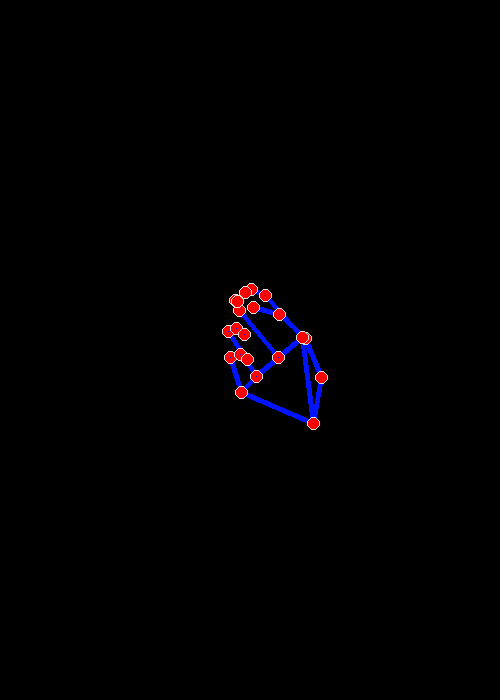
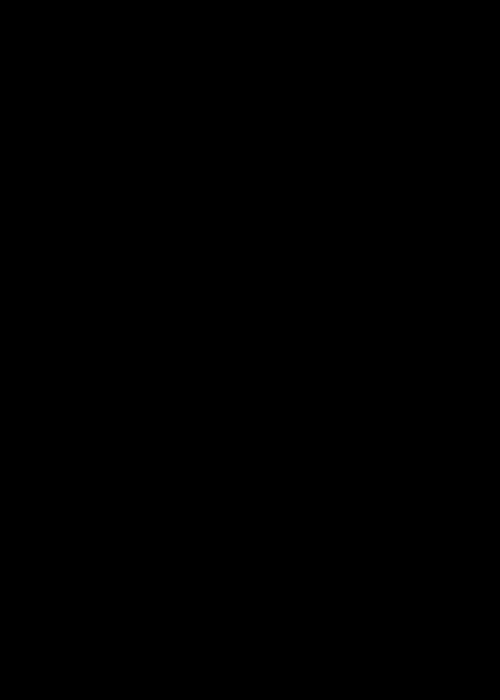
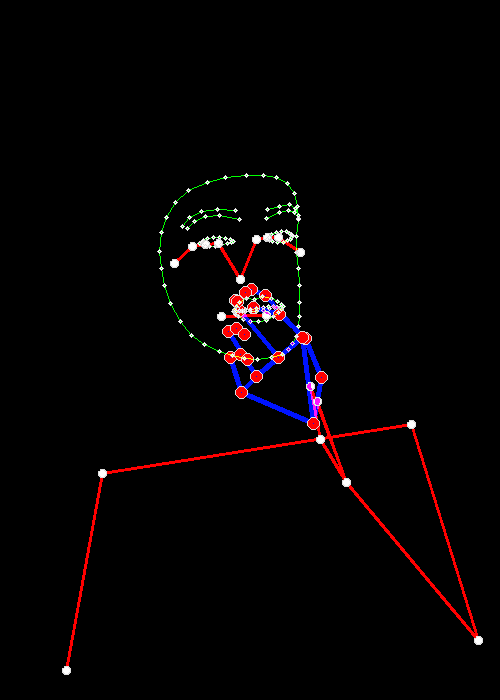
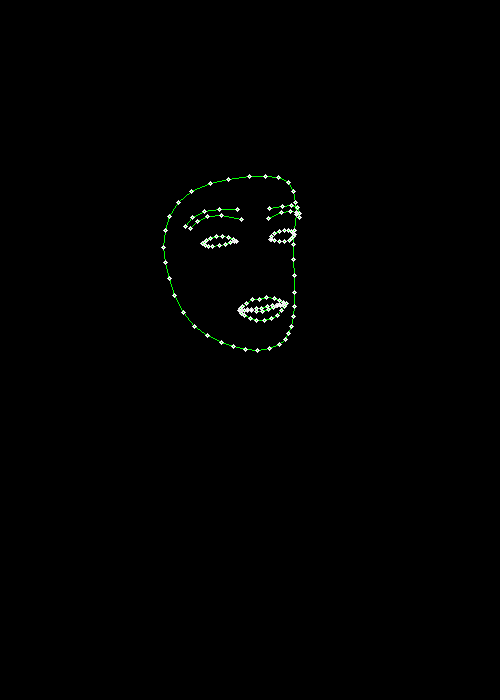
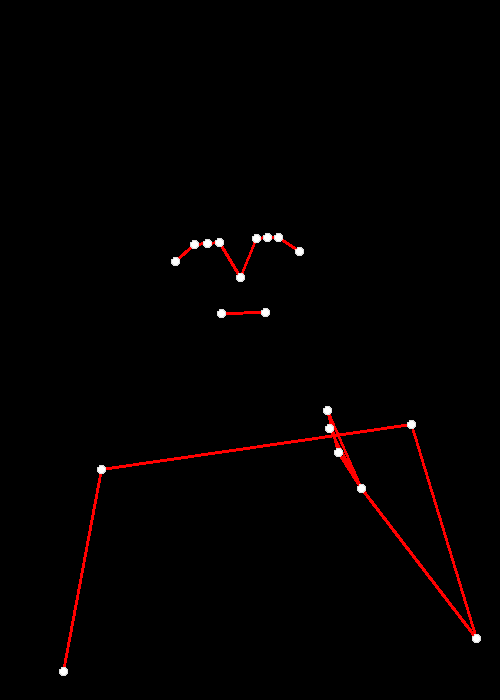
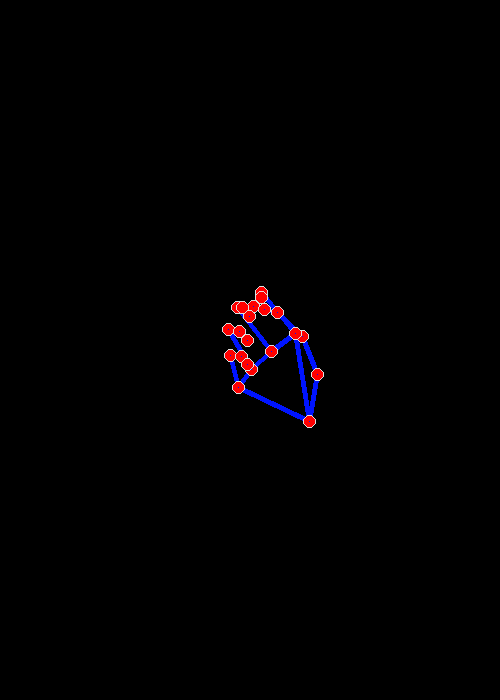
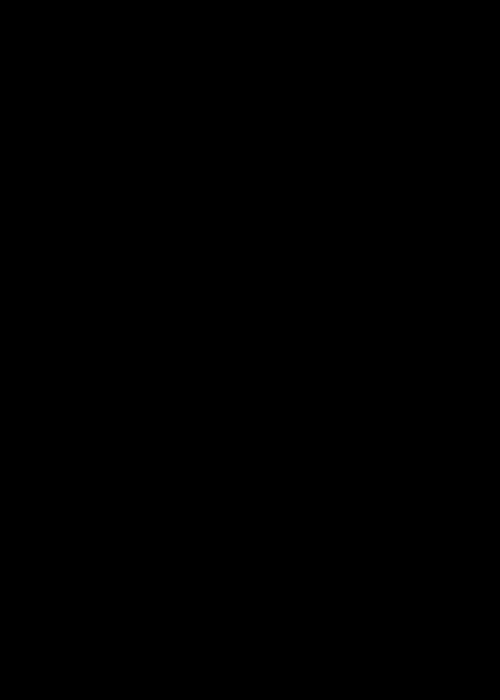
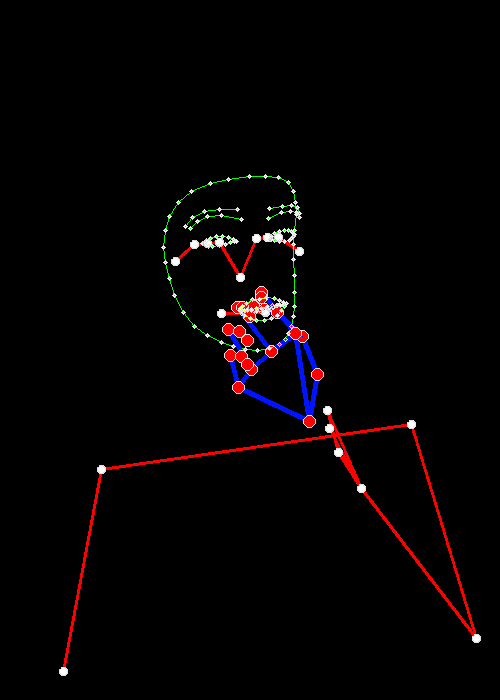
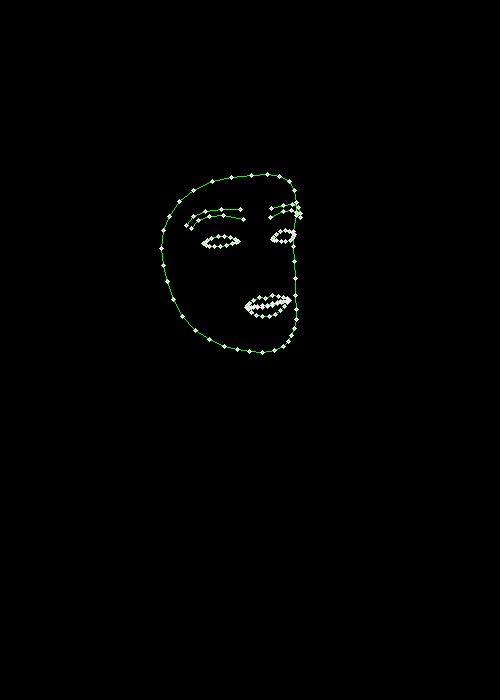
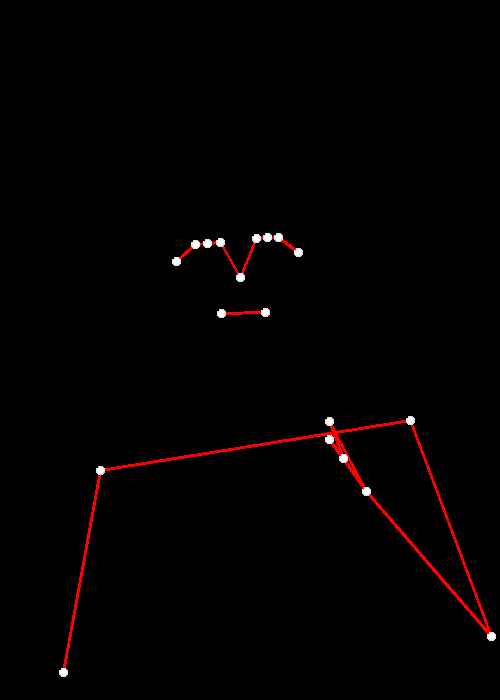
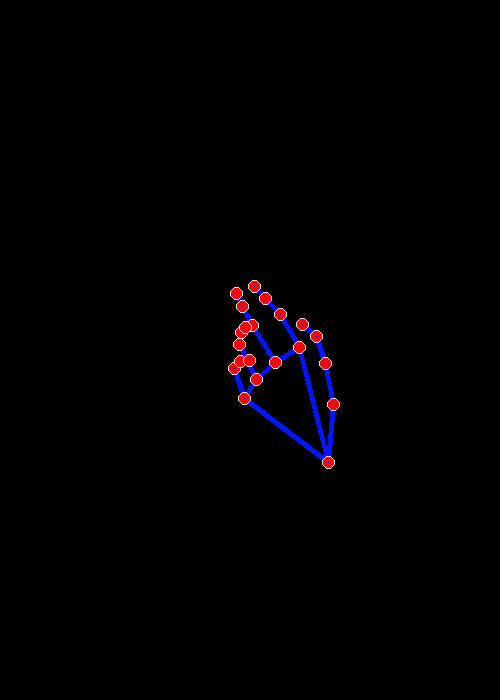
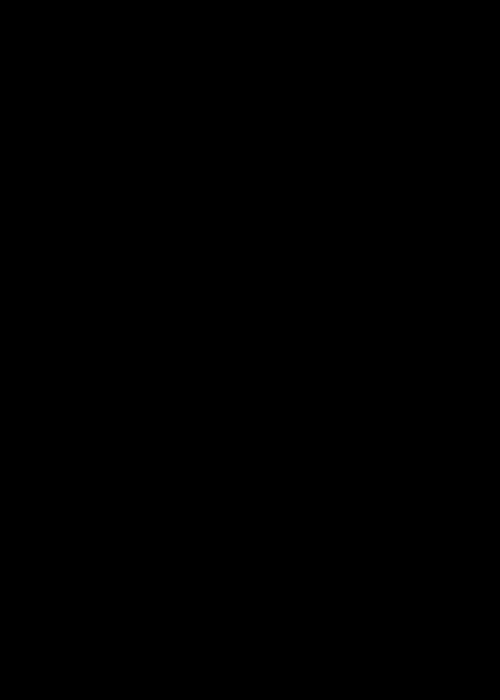
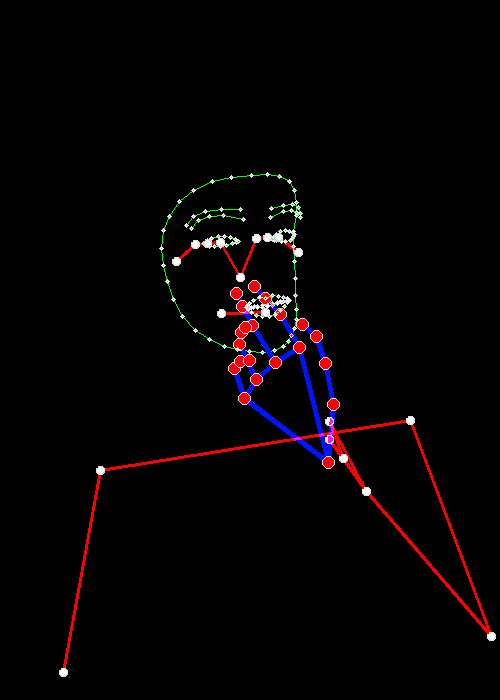
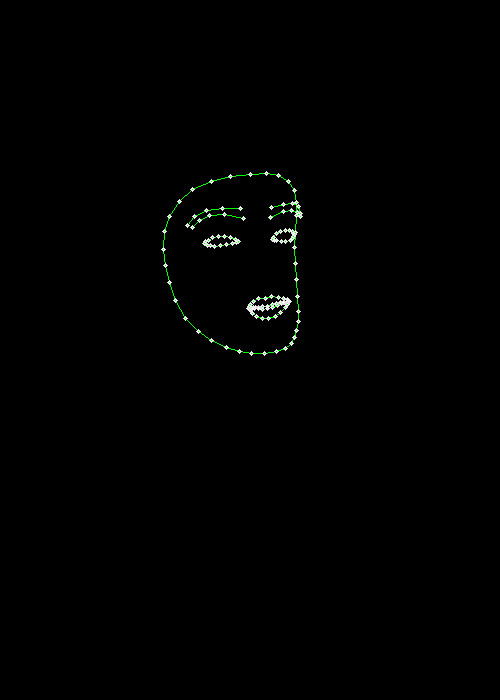
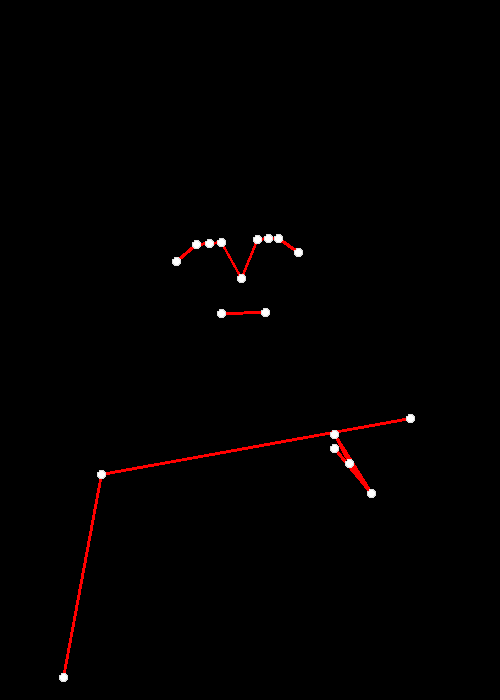
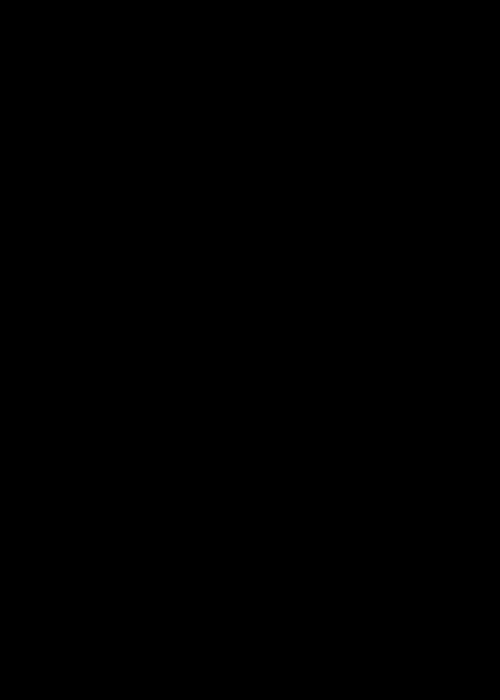
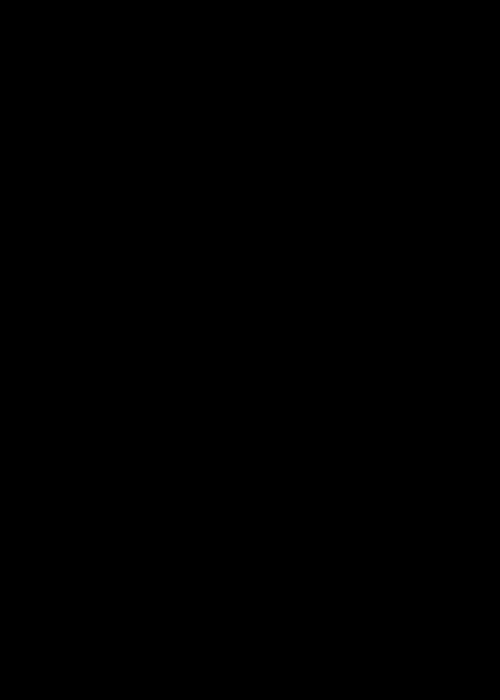
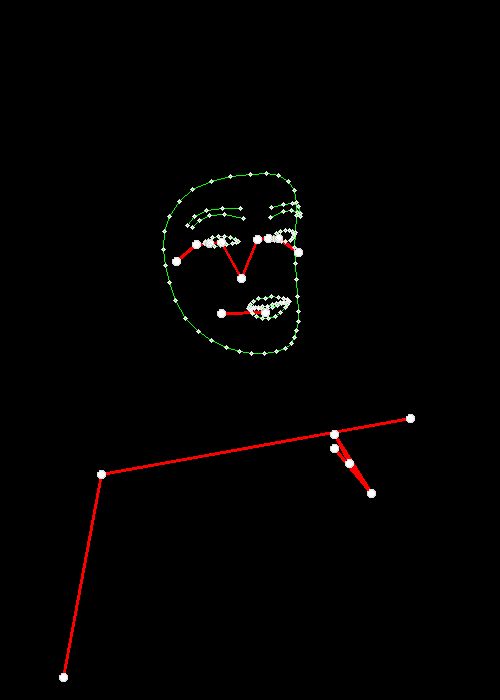
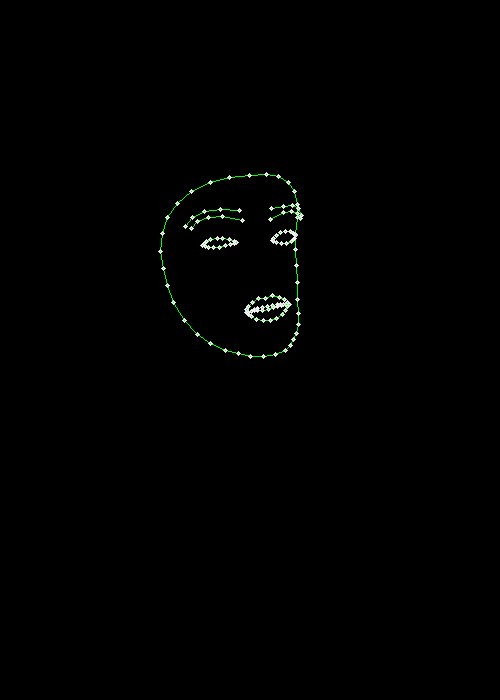
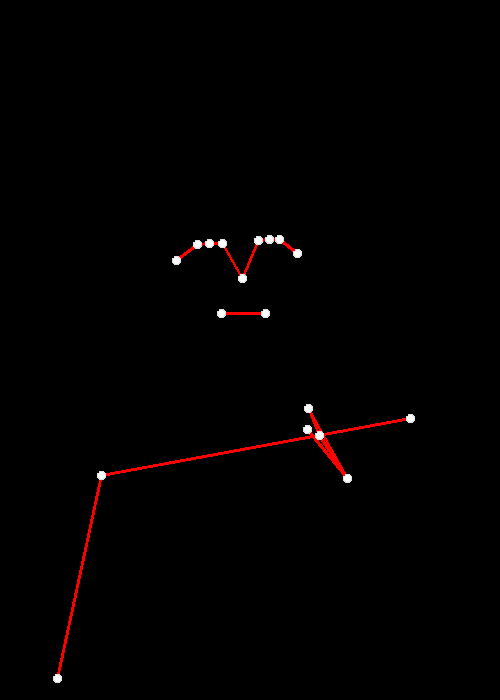
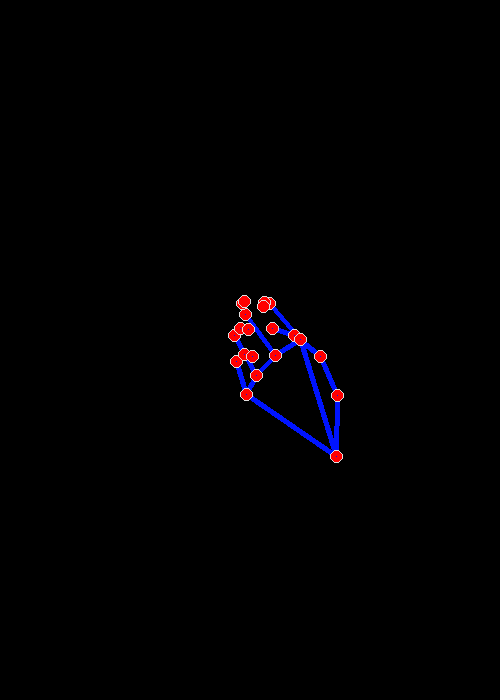
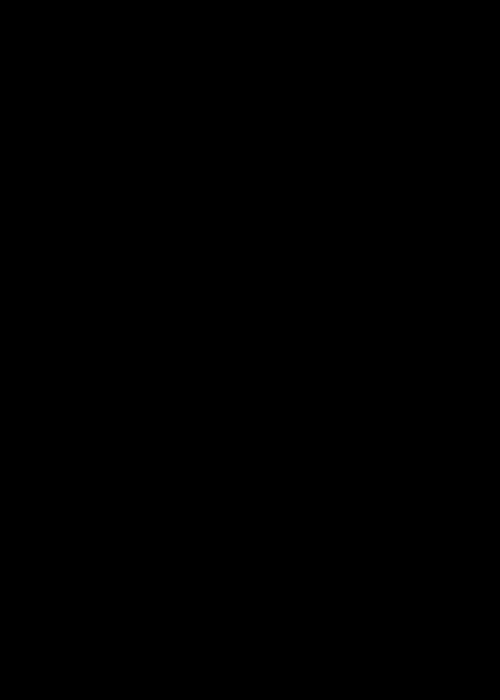
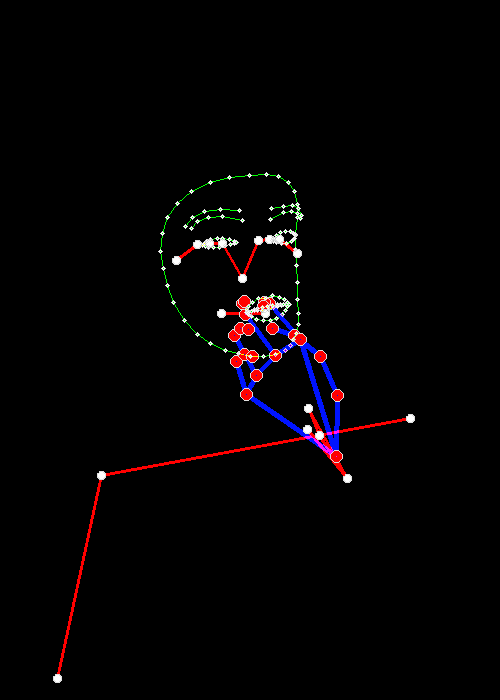
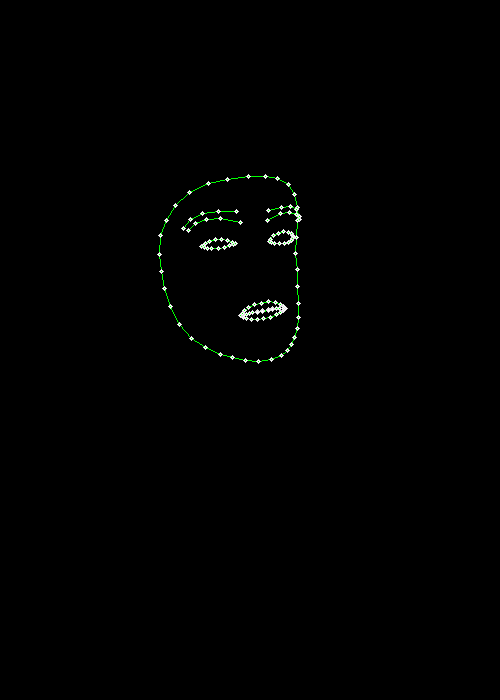
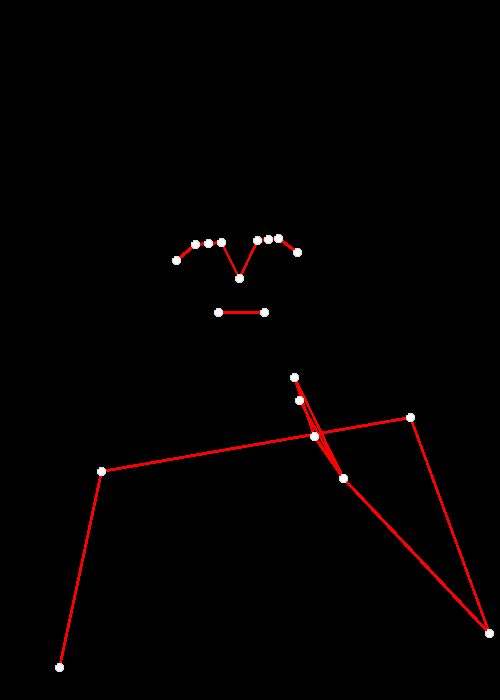
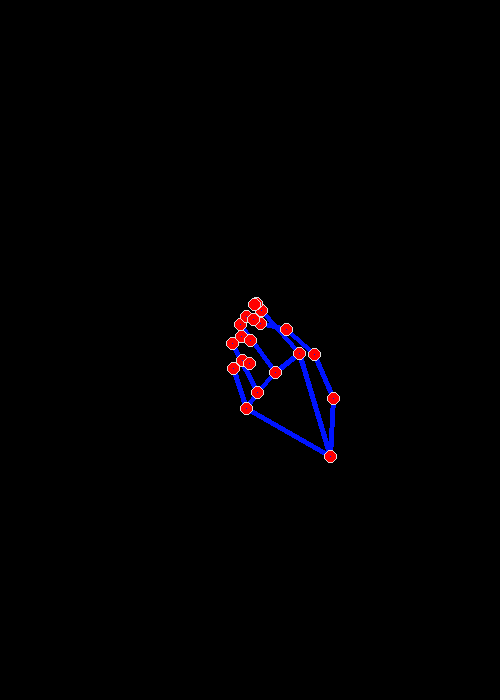
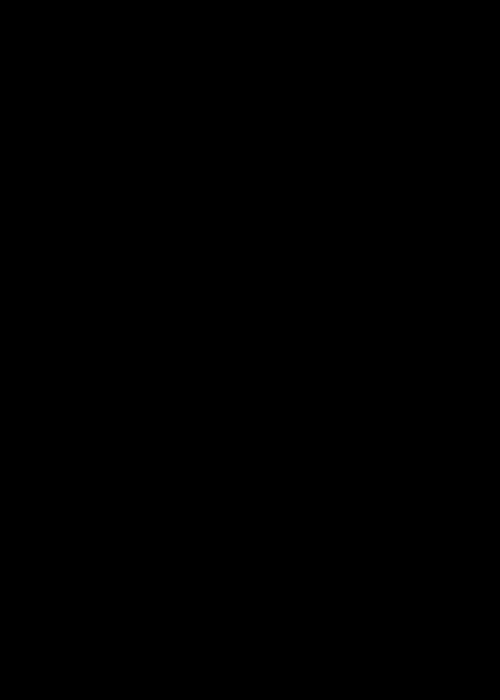
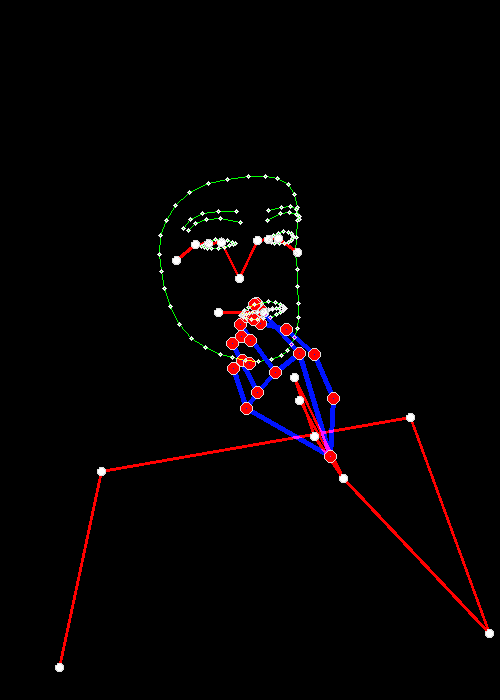
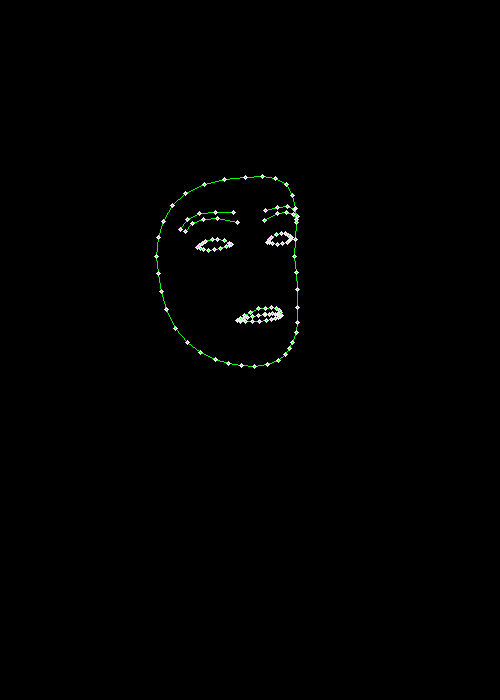
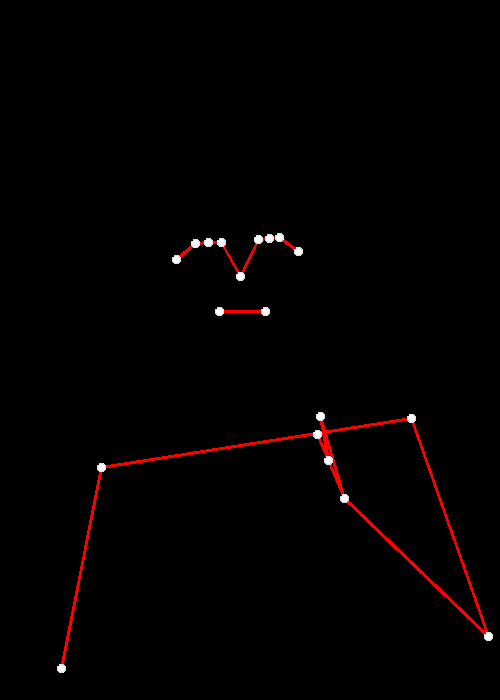
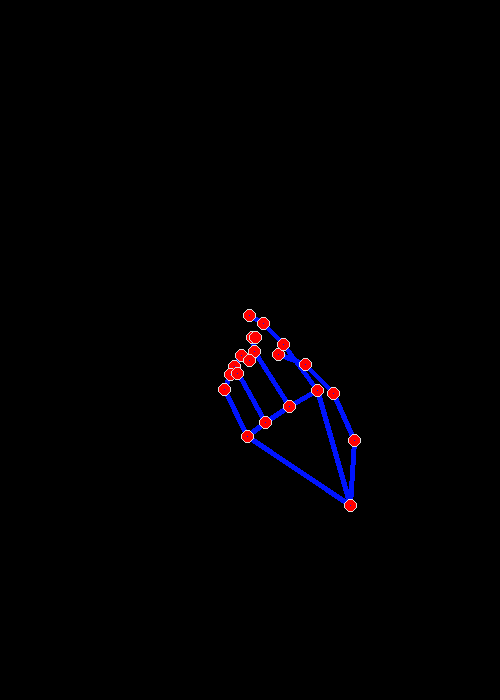
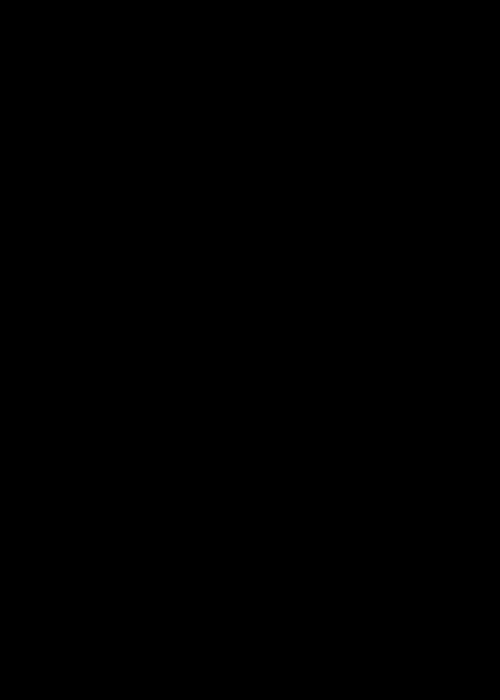
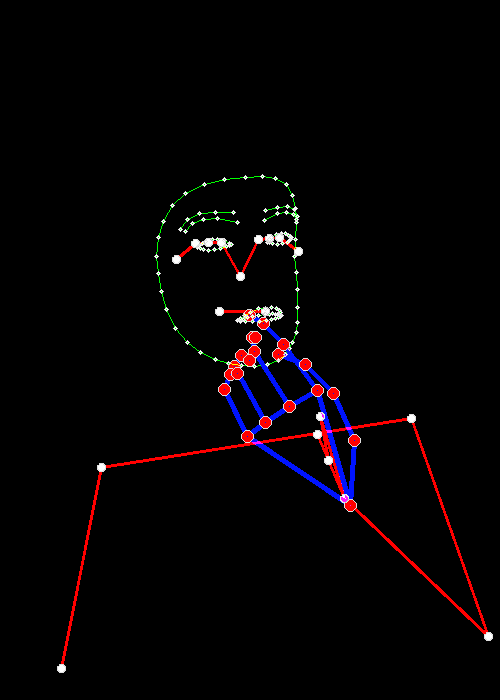

In [16]:
participant_id, sequence_id = get_ids(train_df[train_df['sign'] == 'flower'], 10 )
fig = draw_data(participant_id,sequence_id,train_data)
fig.show(config= dict(displayModeBar = False))

<div style="background-color:white;font-size:22px;font-family:Georgia;border-style: solid;border-color: #F4B400;border-width:5px;padding:20px;margin: 0px;color:black;overflow:hidden">
<span style="font-size:18px; font-family:Georgia;"><b>Observations:</b> </span>

<ul style=“list-style-type:circle;”><span style='font-size:18px; font-family:Georgia;'>

<li>Some face frames are NaN, only pose landmarks are always available</li>

<li>Either left hand or right hand landmarks are available </li>
    
<li>Key frames aren't always from first and last frames</li>

<li>Lots of empty hand frames in a sequence</li>

</span></ul>

<span style="font-size:18px; font-family:Georgia;">=> Besides Mediapipe artifacts (normalized coordinates out of range [0,1]), we need to deal with NaN coordinates as well!</span>
</div>

# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#4285F4;overflow:hidden">Feature Processing</div>

<span style="font-size:25px; font-family:Georgia;"><b>Processing</b>: </span>

<span style="font-size:18px; font-family:Georgia;">In this section, I want to visualize and implement a feature preprocessing, inspired by Robert Hatch <a href="https://www.kaggle.com/code/roberthatch/gislr-feature-data-on-the-shoulders/notebook">[C2]</a>, Darien Schettler <a href="https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline">[C3]</a> , and Heng CK <a href="https://www.kaggle.com/code/hengck23/lb-0-62-pytorch-transformer-solution/notebook">[C4]</a> public notebooks. <br>There are 3 main steps in my approach (Fig 1):  </span>

<span style="font-size:18px; font-family:Georgia;"><b>Step 1</b>: Data Normalization</span>

<span style="font-size:18px; font-family:Georgia;"><b>Step 2</b>: Landmarks Reduction</span>

<span style="font-size:18px; font-family:Georgia;"><b>Step 3</b>: Frames Interpolation</span>

![](https://drive.google.com/uc?id=1UxXL7aTg_YpSo8-nPV019hk6rLmXZRiz)



In [17]:
# Clean representation for frame idx map inspired by Darien Schettler [C3]
IDX_MAP = {"contours"       : list(set(CONTOURS)),
           "left_hand"      : np.arange(468, 489).tolist(),
           "upper_body"     : np.arange(489, 511).tolist(),
           "right_hand"     : np.arange(522, 543).tolist()}

FIXED_FRAMES = 37 # based on the above observations

In [18]:
class FeaturePreprocess(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_in):
        n_frames = x_in.shape[0]

        # Normalization to a common mean by Heng CK [C4]
        x_in = x_in - x_in[~torch.isnan(x_in)].mean(0,keepdim=True) 
        x_in = x_in / x_in[~torch.isnan(x_in)].std(0, keepdim=True)

        # Landmarks reduction
        contours = x_in[:, IDX_MAP['contours']]
        lhand    = x_in[:, IDX_MAP['left_hand']]
        pose     = x_in[:, IDX_MAP['upper_body']]
        rhand    = x_in[:, IDX_MAP['right_hand']]
       
        x_in = torch.cat([contours,
                          lhand,
                          pose,
                          rhand], 1) # (n_frames, 192, 3)
        
        # Replace nan with 0 before Interpolation
        x_in[torch.isnan(x_in)] = 0
        
        # Frames interpolation inspired by Robert Hatch [C2]
        # If n_frames < k, use linear interpolation,
        # else, use nearest neighbor interpolation
        x_in = x_in.permute(2,1,0) #(3, 192, n_frames)
        if n_frames < FIXED_FRAMES:
            x_in = F.interpolate(x_in, size=(FIXED_FRAMES), mode= 'linear')
        else:
            x_in = F.interpolate(x_in, size=(FIXED_FRAMES), mode= 'nearest-exact')
        
        return x_in.permute(2,1,0)

In [19]:
x_in = torch.tensor(load_relevant_data_subset(train_df.path[0]))
feature_preprocess = FeaturePreprocess()
feature_preprocess(x_in).shape, x_in[0]

(torch.Size([37, 192, 3]),
 tensor([[ 0.4944,  0.3805, -0.0306],
         [ 0.4960,  0.3507, -0.0576],
         [ 0.5008,  0.3593, -0.0303],
         ...,
         [ 0.3137,  0.4123, -0.0527],
         [ 0.3507,  0.3996, -0.0602],
         [ 0.3858,  0.4011, -0.0647]]))

<span style="font-size:25px; font-family:Georgia;"><b>Save Preprocessed Features</b></span>

In [20]:
# adapted and adjusted from Robert Hatch [C2]
right_handed_signer = [26734, 28656, 25571, 62590, 29302, 
                       49445, 53618, 18796,  4718,  2044, 
                       37779, 30680]
left_handed_signer  = [16069, 32319, 36257, 22343, 27610, 
                       61333, 34503, 55372, ]
both_hands_signer   = [37055 ]
messy = [29302 ]

def convert_row(row, right_handed=True):
    x = torch.tensor(load_relevant_data_subset(row[1].path))
    x = feature_preprocess(x).cpu().numpy()
    return x, row[1].label

def convert_and_save_data(df):
    total = df.shape[0]
    npdata = np.zeros((total, 37, 192 ,3))
    nplabels = np.zeros(total)
    for i, row in tqdm(enumerate(df.iterrows()), total=total):
        (x,y) = convert_row(row)
        npdata[i,:,:,:] = x
        nplabels[i] = y
    
    np.save("feature_data.npy", npdata)
    np.save("feature_labels.npy", nplabels)


In [21]:
convert_and_save_data(train_df)

100%|██████████| 94477/94477 [41:30<00:00, 37.94it/s]  


In [22]:
X = np.load("feature_data.npy")
y = np.load("feature_labels.npy")
print(X.shape, y.shape)
print(X[0].shape,y[0])

(94477, 37, 192, 3) (94477,)
(37, 192, 3) 25.0
